# KPA Coherence, Hyper-parameter Tuning and Benchmarking

## Introduction

In this notebook we will show how to select the Key Point Analysis (KPA) model with optimal hyper-parameters, and benchmark KPA against a widely used modern topic modelling algorithm. The main two sections of the analysis are:
- Hyper-parameter tuning - analysis of KPA performance with varying parameters to select the optimal model hyper-parameters.
- Benchmarking - comparing KPA against a standard topic modelling algorithm (LDA).

The performance of topic summarization and modelling algorithms is a complex problem. The performance of KPA and topic models in general can be evaluated qualitatively (by a human) or quantitatively (by a performance measure). 

A human can provide qualitative feedback by interpreting whether the model outputs make sense and if they can deliver valuable insights to a decision-maker. In the research paper that introduced KPA, "Quantitative Argument Summarization and Beyond: Cross-Domain Key Point Analysis",  human interpretation was used to manually label the data to assess the performance of KPA, where it was shown to be effective.

There are various quantitative performance measures that can be utilised to assess the performance of a KPA model. However, these quantitative measures act as a guideline for model performance and need to be used in combination with human intuition as a high quantitative measure associated with a model does not necessarily mean the model outputs will make sense. 

In this notebook we have focused on two quantitative measures:
- Coherence - this is a measure of how semantically similar words are within each topic or key point. A high coherence score means the words that define a topic occur often in combination together and are therefore closely related and have similar meanings. We assume that this will result in a better model with more interpretable results. There are various formulations of this measure that can slightly different results.

- Coverage - this is the proportion of inputs (e.g. sentences or documents) that are assigned to a key point or topic. Generally in topic modelling, all inputs are assigned to a topic. In KPA, only a proportion of inputs will be assigned to a key point. A higher coverage means the key points of the given topic represent a larger proportion of the inputted data. However, a lower coverage could provide better results by removing inputs that provide little information or are misleading.



# Set-up

Firstly we define API information including the private key and domain name, the number of CPU cores, install various packages and the Debater SDK, and download the required data from the Github repository:

In [5]:
print('Set Api-Key')
api_key = '28f28799ac8f86a0d6cb670c8756d0c0L06'

print('Set Domain Name')
domain = 'CREATE_DOMAIN_NAME_HERE'

print('Set Number of Cores')
# Has been set to 1 core for this notebook due to issues with the CoherenceModel
num_cores = 1

print('Install LDA visualization package')
!pip install pyLDAvis

print('Install Early-Access-Program SDK:')
!wget -P . https://early-access-program.debater.res.ibm.com/sdk/python_api.tar.gz
!tar -xvf python_api.tar.gz
!cd python_api ; pip install .
!rm -f python_api.tar.gz*

print('Retrieve datasets and additional code from the Github repo: https://github.com/IBM/Analysing-Medical-Transcipts-using-Project-Debater :') 
!rm -f top_sentences*
!rm -f mtsamples_clean*
!rm -f austin_utils*
!wget -P . https://raw.githubusercontent.com/IBM/Analysing-Medical-Transcipts-using-Project-Debater/main/Data/top_sentences.csv
!wget -P . https://raw.githubusercontent.com/IBM/Analysing-Medical-Transcipts-using-Project-Debater/main/Data/mtsamples_clean.csv
!wget -P . https://raw.githubusercontent.com/IBM/Analysing-Medical-Transcipts-using-Project-Debater/main/Data/austin_utils.py

Set Api-Key
Set Domain Name
Set Number of Cores
Install LDA visualization package
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Install Early-Access-Program SDK:
--2021-10-19 09:10:02--  https://early-access-program.debater.res.ibm.com/sdk/python_api.tar.gz
Resolving early-access-program.debater.res.ibm.com (early-access-program.debater.res.ibm.com)... 169.55.93.82
Connecting to early-access-program.debater.res.ibm.com (early-access-program.debater.res.ibm.com)|169.55.93.82|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 441774 (431K) [application/x-gzip]
Saving

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Processing /home/wsuser/work/python_api
  Created wheel for debater-python-api: filename=debater_python_api-3.5.8.RELEASE-py3-none-any.whl size=87347 sha256=3dafad7207b1b2c1978c3e67087f0f1137c11fd2a1f80bb2be95b8714ec81e00
  Stored in directory: /tmp/wsuser/pip-ephem-wheel-cache-yqcn1xed/wheels/09/eb/75/57a472eddae6a5184611be4a6800dd7ea356ab23aabbe340df
Successfully built debater-python-api
  Attempting uninstall: debater-python-api
    Found existing installation: debater-python-api 3.5.8.RELEASE
    Uninstalling debater-python-api-3.5.8.RE

--2021-10-19 09:10:13--  https://raw.githubusercontent.com/IBM/Analysing-Medical-Transcipts-using-Project-Debater/main/Data/austin_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7746 (7.6K) [text/plain]
Saving to: ‘./austin_utils.py’

austin_utils.py     100%[===================>]   7.56K  --.-KB/s    in 0s      

2021-10-19 09:10:13 (55.6 MB/s) - ‘./austin_utils.py’ saved [7746/7746]



In [2]:
# Import required packages

# General / data
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Debater API and tools
from debater_python_api.api.debater_api import DebaterApi
from austin_utils import init_logger

# Word processing
import re
import nltk 
from nltk.corpus import stopwords

# Topic modelling and coherence scoring
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess

Finally create a list of stopwords, i.e. words that offer little information such as "I", "this", "and" etc, and initialize the Debater API and Key Point Analysis client:

In [3]:
# For later use, download a list of stopwords
nltk.download('stopwords')

# Create list of stop words - five most common words in the dataset are added. 
# More words could be removed but medical domain knowledge would be useful for identifying these words
stop_words = stopwords.words('english') + ['left', 'right', 'patient', 'placed', 'well']

# Print first 5 words
stop_words[0:5]

[nltk_data] Downloading package stopwords to /home/wsuser/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['i', 'me', 'my', 'myself', 'we']

In [6]:
# Initialize Debater API and KPA client
init_logger()
debater_api = DebaterApi(apikey=api_key)
keypoints_client = debater_api.get_keypoints_client()

## Section 1: Hyper-parameter Tuning and Model Selection

### 1.0 Introduction

In this section we will show how to select optimal model parameters for KPA. The choice of model parameters can fine-tune how a KPA is trained and its outputs, so the choice of parameters can have a large impact on the model. To allow hyper-parameter tuning, a quantitative measure of performance needs to be used to quickly evaluate the performance of various models. In this notebook, the quantitative performance measure chosen is the model coherence. However, we will also monitor the coverage.

The two hyper-parameters chosen for optimisation in this section are:
- Number of key points (n_top_kps) - the maximum number of key points in the model. 
- Mapping threshold (mapping_threshold) - the match score required to assign an sentence to a key point. For example, if the mapping threshold is set to 0.9, only sentences that have a match score of 0.9 or higher will be assigned to a key point. 

Additional KPA model hyper-parameters could be optimised such as:

- arg_min_len and arg_max_len - specify the minimum and maximum length of sentences that are assigned to key points.
- arg_relative_aq_threshold - filter out sentences with an argument quality score below the given percentile.
- kp_relative_aq_threshold - specify the argument quality score required for a sentence to be selected as a key point.

Full documentation of the KPA service and parameters is available here - https://early-access-program.debater.res.ibm.com/docs/services/keypoints/keypoints_pydoc.html#KpaIllegalInputException

#### Common Functions

The below function will run KPA with the inputted sentences and parameters. The results are returned in a Pandas DataFrame:

In [6]:
def run_kpa(sentences, run_params):
    sentences_texts = sentences['text'].to_list()
    sentences_ids = sentences['id'].astype(str).to_list()

    # Clear domain in case it existed already
    keypoints_client.delete_domain_cannot_be_undone(domain) 

    keypoints_client.upload_comments(domain=domain, 
                                     comments_ids=sentences_ids, 
                                     comments_texts=sentences_texts, 
                                     dont_split=True)

    keypoints_client.wait_till_all_comments_are_processed(domain=domain)

    future = keypoints_client.start_kp_analysis_job(domain=domain, 
                                                    comments_ids=sentences_ids, 
                                                    run_params=run_params)

    kpa_result = future.get_result(high_verbosity=False, 
                                   polling_timout_secs=5)
    
    matchings_rows = []
    for keypoint_matching in kpa_result['keypoint_matchings']:
        kp = keypoint_matching['keypoint']
        for match in keypoint_matching['matching']:
            match_row = [kp, 
                         match["sentence_text"], 
                         match["score"], 
                         match["comment_id"], 
                         match["sentence_id"],
                         match["sents_in_comment"], 
                         match["span_start"], 
                         match["span_end"], 
                         match["num_tokens"],
                         match["argument_quality"]]

            matchings_rows.append(match_row)

    cols = ["kp", 
            "sentence_text", 
            "match_score", 
            'comment_id', 
            'sentence_id', 
            'sents_in_comment', 
            'span_start',
            'span_end', 
            'num_tokens', 
            'argument_quality']
    
    kpa_result_df = pd.DataFrame(matchings_rows, columns=cols)
    
    return kpa_result_df

The below function takes the KPA results and processes these into a more standard topic-modelling format, where each topic is represented by a collection of words. This formatting is required to calculate the coherence score:

In [7]:
def score_kpa(df_results):

    # Calculate the coverage
    coverage = len(df_results[df_results['kp']!='none'])/len(df_results)

    # Remove sentences not assigned to a cluster
    df_results = df_results[df_results['kp']!='none']
    
    # Make list of lists of sentences grouped by keypoint
    kp_list = []
    for kp in df_results['kp'].unique():
        kp_list.append(list(df_results[df_results['kp']==kp]['sentence_text'].to_list()))
        
    # Tokenize sentences, remove punctuation and stopwords
    kpa_words = []
    kpa_topics = []
    for kps in kp_list:
        kp_sentences_updated = []
        kpa_topic_words = set()
        for sentence in kps:
            # Remove punctuation and numbers from description and convert to lower-case
            sentence = re.sub(r'[,\.!?\d+]', '', sentence).lower()
            # Convert description to lists of words, and remove furtherpunctuation
            words = simple_preprocess(sentence, deacc=True)
            # Remove stopwords
            words = [word for word in words if word not in stop_words]
            kpa_words.append(words)
            for word in words:
                kpa_topic_words.add(word)
        kpa_topics.append(list(kpa_topic_words))
    
    # Create a dictionary and corpus
    kpa_dict = corpora.Dictionary(kpa_words)
    kpa_corpus = [kpa_dict.doc2bow(word) for word in kpa_words]
    
    # Create c_v coherence model
    coherence_model_kpa = CoherenceModel(topics = kpa_topics, 
                                         texts = kpa_words, 
                                         dictionary = kpa_dict, 
                                         coherence = 'c_v',
                                         topn=20,
                                         processes=num_cores)
    
    # Calculate c_v coherence score
    cv_coherence_score = coherence_model_kpa.get_coherence()
    
    return cv_coherence_score, coverage

### 1.1 Coherence and Coverage by Number of Key Points

Here we will analyse how the model coherence varies as the number of key points parameter is changed. It is important to note that this is the maximum number of key points. A sentence will not be considered as a key point candidate if it does not meet certain criteria, such as a specified argument quality score.

Firstly, we will import the top 1000 sentences with the highest argument quality scores that were identified in the previous notebook:

In [8]:
# Import data
top_sentences = pd.read_csv('top_sentences.csv', 
                            index_col='Unnamed: 0')

The below function can be used to calculate the coherence and coverage across a specified numbers of topics:

In [9]:
def kpa_gridsearch_num_kps(sentences, min_kps, max_kps, mapping_threshold=0.9):
    results = []

    for num_kps in range(min_kps, max_kps + 1):

        # Run KPA
        kpa_result = run_kpa(top_sentences, {'n_top_kps': num_kps,
                                             'mapping_threshold': mapping_threshold})

        # Calculate coherence and percentage of sentences assigned to a cluster
        cv_coherence_score, coverage = score_kpa(kpa_result)

        # Append results
        results.append([num_kps, mapping_threshold, cv_coherence_score, coverage])
        
    # Convert results to dataframe
    results = pd.DataFrame(results, columns=['Number of Key Points', 
                                             'Mapping Threshold',
                                             'Coherence', 
                                             'Coverage'])
        
    return results

We will now use this function to calculate the coherence and coverage for each number of topics in the given range. Please note that as a KPA model has to be created for each number of key points, this can take a significant amount of time and places stress on the free-to-use servers. Please use this responsibly or you may risk having your API key revoked:

In [10]:
num_kps_results = kpa_gridsearch_num_kps(top_sentences, min_kps=1, max_kps=25)

2021-10-08 14:28:27,554 [INFO] keypoints_client.py 214: client calls service (delete): https://keypoint-matching-backend.debater.res.ibm.com/data
2021-10-08 14:28:28,158 [INFO] keypoints_client.py 284: uploading 1000 comments in batches
2021-10-08 14:28:28,159 [INFO] keypoints_client.py 214: client calls service (post): https://keypoint-matching-backend.debater.res.ibm.com/comments
2021-10-08 14:28:31,105 [INFO] keypoints_client.py 301: uploaded 1000 comments, out of 1000
2021-10-08 14:28:31,106 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/comments
2021-10-08 14:28:34,063 [INFO] keypoints_client.py 313: domain: ag_test, comments status: {'processed_comments': 0, 'pending_comments': 1000, 'processed_sentences': 0}
2021-10-08 14:28:44,114 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/comments
2021-10-08 14:28:44,657 [INFO] keypoints_client.py 313: domai

2021-10-08 14:31:24,274 [INFO] keypoints_client.py 313: domain: ag_test, comments status: {'processed_comments': 640, 'pending_comments': 1000, 'processed_sentences': 1000}
2021-10-08 14:31:34,303 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/comments
2021-10-08 14:31:34,684 [INFO] keypoints_client.py 313: domain: ag_test, comments status: {'processed_comments': 1000, 'pending_comments': 0, 'processed_sentences': 1000}
2021-10-08 14:31:34,685 [INFO] keypoints_client.py 214: client calls service (post): https://keypoint-matching-backend.debater.res.ibm.com/kp_extraction
2021-10-08 14:31:38,980 [INFO] keypoints_client.py 375: started a kp analysis job - domain: ag_test, job_id: 6160564ace5127f612ba9a89
2021-10-08 14:31:38,981 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/kp_extraction
2021-10-08 14:31:45,663 [INFO] keypoints_client.py 214: client calls s

2021-10-08 14:34:30,953 [INFO] keypoints_client.py 375: started a kp analysis job - domain: ag_test, job_id: 616056f6ce5127f612ba9a93
2021-10-08 14:34:30,954 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/kp_extraction
2021-10-08 14:34:37,889 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/kp_extraction
2021-10-08 14:34:43,287 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/kp_extraction
2021-10-08 14:34:48,687 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/kp_extraction
2021-10-08 14:34:54,087 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/kp_extraction
2021-10-08 14:34:59,471 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-match

2021-10-08 14:37:44,875 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/kp_extraction
2021-10-08 14:37:50,364 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/kp_extraction
2021-10-08 14:37:55,852 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/kp_extraction
2021-10-08 14:37:56,758 [INFO] keypoints_client.py 555: job_id 61605791ce5127f612ba9a9d is done, returning result
2021-10-08 14:37:56,798 [INFO] dictionary.py 209: adding document #0 to Dictionary(0 unique tokens: [])
2021-10-08 14:37:56,806 [INFO] dictionary.py 216: built Dictionary(1616 unique tokens: ['arthritis', 'may', 'reactive', 'abdominal', 'disease']...) from 493 documents (total 4346 corpus positions)
2021-10-08 14:37:56,812 [INFO] probability_estimation.py 155: using WordOccurrenceAccumulator to estimate probabilities from slid

2021-10-08 14:40:42,183 [INFO] probability_estimation.py 155: using WordOccurrenceAccumulator to estimate probabilities from sliding windows
2021-10-08 14:40:42,557 [INFO] keypoints_client.py 214: client calls service (delete): https://keypoint-matching-backend.debater.res.ibm.com/data
2021-10-08 14:40:44,935 [INFO] keypoints_client.py 284: uploading 1000 comments in batches
2021-10-08 14:40:44,937 [INFO] keypoints_client.py 214: client calls service (post): https://keypoint-matching-backend.debater.res.ibm.com/comments
2021-10-08 14:40:47,712 [INFO] keypoints_client.py 301: uploaded 1000 comments, out of 1000
2021-10-08 14:40:47,713 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/comments
2021-10-08 14:40:50,756 [INFO] keypoints_client.py 313: domain: ag_test, comments status: {'processed_comments': 0, 'pending_comments': 1000, 'processed_sentences': 0}
2021-10-08 14:41:00,803 [INFO] keypoints_client.py 214: client call

2021-10-08 14:43:40,973 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/comments
2021-10-08 14:43:41,355 [INFO] keypoints_client.py 313: domain: ag_test, comments status: {'processed_comments': 1000, 'pending_comments': 0, 'processed_sentences': 1000}
2021-10-08 14:43:41,355 [INFO] keypoints_client.py 214: client calls service (post): https://keypoint-matching-backend.debater.res.ibm.com/kp_extraction
2021-10-08 14:43:45,454 [INFO] keypoints_client.py 375: started a kp analysis job - domain: ag_test, job_id: 61605921ce5127f612ba9ab6
2021-10-08 14:43:45,455 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/kp_extraction
2021-10-08 14:43:52,351 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/kp_extraction
2021-10-08 14:43:58,010 [INFO] keypoints_client.py 214: client calls service (get): https:/

2021-10-08 14:46:42,375 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/kp_extraction
2021-10-08 14:46:47,750 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/kp_extraction
2021-10-08 14:46:53,126 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/kp_extraction
2021-10-08 14:47:00,527 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/kp_extraction
2021-10-08 14:47:05,929 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/kp_extraction
2021-10-08 14:47:11,330 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/kp_extraction
2021-10-08 14:47:16,826 [INFO] keypoints_client.py 214: client calls service (get): http

2021-10-08 14:50:01,718 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/kp_extraction
2021-10-08 14:50:02,746 [INFO] keypoints_client.py 555: job_id 61605a67ce5127f612ba9aca is done, returning result
2021-10-08 14:50:02,796 [INFO] dictionary.py 209: adding document #0 to Dictionary(0 unique tokens: [])
2021-10-08 14:50:02,806 [INFO] dictionary.py 216: built Dictionary(1828 unique tokens: ['arthritis', 'may', 'reactive', 'abdominal', 'disease']...) from 609 documents (total 5250 corpus positions)
2021-10-08 14:50:02,814 [INFO] probability_estimation.py 155: using WordOccurrenceAccumulator to estimate probabilities from sliding windows
2021-10-08 14:50:03,514 [INFO] keypoints_client.py 214: client calls service (delete): https://keypoint-matching-backend.debater.res.ibm.com/data
2021-10-08 14:50:05,624 [INFO] keypoints_client.py 284: uploading 1000 comments in batches
2021-10-08 14:50:05,625 [INFO] keypoints_client.py 214:

2021-10-08 14:52:53,859 [INFO] keypoints_client.py 214: client calls service (delete): https://keypoint-matching-backend.debater.res.ibm.com/data
2021-10-08 14:52:55,872 [INFO] keypoints_client.py 284: uploading 1000 comments in batches
2021-10-08 14:52:55,873 [INFO] keypoints_client.py 214: client calls service (post): https://keypoint-matching-backend.debater.res.ibm.com/comments
2021-10-08 14:52:58,651 [INFO] keypoints_client.py 301: uploaded 1000 comments, out of 1000
2021-10-08 14:52:58,653 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/comments
2021-10-08 14:53:01,628 [INFO] keypoints_client.py 313: domain: ag_test, comments status: {'processed_comments': 0, 'pending_comments': 1000, 'processed_sentences': 313}
2021-10-08 14:53:11,664 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/comments
2021-10-08 14:53:12,068 [INFO] keypoints_client.py 313: dom

2021-10-08 14:55:47,160 [INFO] keypoints_client.py 375: started a kp analysis job - domain: ag_test, job_id: 61605bf3ce5127f612ba9ae3
2021-10-08 14:55:47,161 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/kp_extraction
2021-10-08 14:55:54,068 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/kp_extraction
2021-10-08 14:55:59,450 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/kp_extraction
2021-10-08 14:56:04,841 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/kp_extraction
2021-10-08 14:56:10,234 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/kp_extraction
2021-10-08 14:56:15,627 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-match

2021-10-08 14:59:00,898 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/kp_extraction
2021-10-08 14:59:06,467 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/kp_extraction
2021-10-08 14:59:07,488 [INFO] keypoints_client.py 555: job_id 61605c87ce5127f612ba9aed is done, returning result
2021-10-08 14:59:07,543 [INFO] dictionary.py 209: adding document #0 to Dictionary(0 unique tokens: [])
2021-10-08 14:59:07,554 [INFO] dictionary.py 216: built Dictionary(1909 unique tokens: ['arthritis', 'may', 'reactive', 'abdominal', 'disease']...) from 642 documents (total 5537 corpus positions)
2021-10-08 14:59:07,562 [INFO] probability_estimation.py 155: using WordOccurrenceAccumulator to estimate probabilities from sliding windows
2021-10-08 14:59:08,472 [INFO] keypoints_client.py 214: client calls service (delete): https://keypoint-matching-backend.debater.res.ibm.com

#### View and Plot Results

In [11]:
# View results
num_kps_results.head()

Number of Key Points  Mapping Threshold  Coherence  Coverage
0                     1                0.9   0.864352  0.199125
1                     2                0.9   0.855640  0.311816
2                     3                0.9   0.843931  0.396061
3                     4                0.9   0.834762  0.445295
4                     5                0.9   0.824185  0.459519

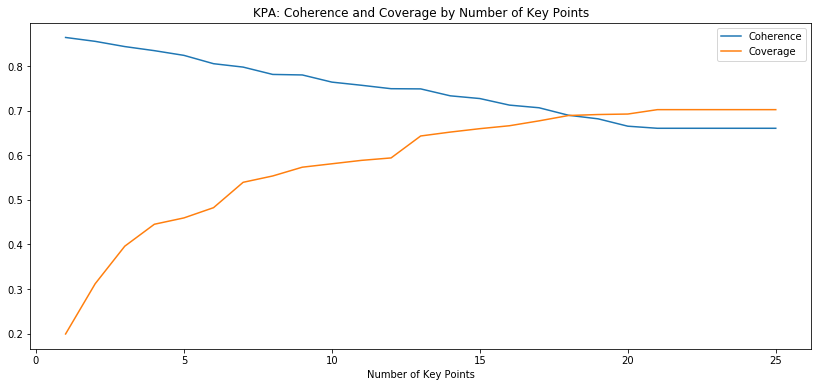

In [12]:
# Plot results
num_kps_results.plot(title='KPA: Coherence and Coverage by Number of Key Points',
                     x='Number of Key Points', 
                     y=['Coherence', 'Coverage'], 
                     figsize=(14,6))

#### Results Interpretation

Once the maximum number of key points parameter is increased to 22 or above, KPA only produces models with 22 key points. This is because there are only 22 suitable candidate sentences that could become key points. Therefore we can consider the maximum number of topics parameters in the range from 1 to 22.

Interestingly, the coherence decreases as the number of key points increases. We might be able to infer that this is because the first topic is the highest "quality" with the most sentences closely associated and has the highest coherence. When only one topic is selected, a large proportion of sentences are not assigned to a topic. In standard topic modelling, all sentences must be assigned to a topic so a single topic is extremely unlikely to maximize the coherence.

The coverage increases as the number of topics increases, as more sentences can be assigned to a key point. Therefore, there is a trade-off between coherence and coverage.

### 1.2 Coherence and Coverage by Mapping Threshold

Here we will analyse how the model coherence varies as the mapping threshold parameter is changed. The below function can be used to calculate the coherence and coverage across a specified range of mapping thresholds:

In [13]:
def kpa_gridsearch_mt(sentences, mt_values, num_kps=30):
    results = []

    for mapping_threshold in mt_values:

        # Run KPA
        kpa_result = run_kpa(top_sentences, {'n_top_kps': num_kps,
                                             'mapping_threshold': mapping_threshold})

        # Calculate coherence and percentage of sentences assigned to a cluster
        cv_coherence_score, coverage = score_kpa(kpa_result)

        # Append results
        results.append([num_kps, mapping_threshold, cv_coherence_score, coverage])
        
    # Convert results to dataframe
    results = pd.DataFrame(results, columns=['Number of Key Points', 
                                             'Mapping Threshold',
                                             'Coherence', 
                                             'Coverage'])

    return results

We will now calculate coherence and coverage for mapping thresholds from 0.5 to 0.99 with 20 key points:

In [14]:
mapping_thresholds = np.linspace(0.5, 0.99, 20)
mt_results = kpa_gridsearch_mt(top_sentences, mapping_thresholds, num_kps=20)

2021-10-08 15:01:32,876 [INFO] keypoints_client.py 214: client calls service (delete): https://keypoint-matching-backend.debater.res.ibm.com/data
2021-10-08 15:01:34,582 [INFO] keypoints_client.py 284: uploading 1000 comments in batches
2021-10-08 15:01:34,583 [INFO] keypoints_client.py 214: client calls service (post): https://keypoint-matching-backend.debater.res.ibm.com/comments
2021-10-08 15:01:37,293 [INFO] keypoints_client.py 301: uploaded 1000 comments, out of 1000
2021-10-08 15:01:37,294 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/comments
2021-10-08 15:01:40,262 [INFO] keypoints_client.py 313: domain: ag_test, comments status: {'processed_comments': 0, 'pending_comments': 1000, 'processed_sentences': 0}
2021-10-08 15:01:50,313 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/comments
2021-10-08 15:01:50,683 [INFO] keypoints_client.py 313: domai

2021-10-08 15:04:32,866 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/comments
2021-10-08 15:04:35,828 [INFO] keypoints_client.py 313: domain: ag_test, comments status: {'processed_comments': 0, 'pending_comments': 1000, 'processed_sentences': 0}
2021-10-08 15:04:45,879 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/comments
2021-10-08 15:04:46,481 [INFO] keypoints_client.py 313: domain: ag_test, comments status: {'processed_comments': 941, 'pending_comments': 1000, 'processed_sentences': 1000}
2021-10-08 15:04:56,515 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/comments
2021-10-08 15:04:56,904 [INFO] keypoints_client.py 313: domain: ag_test, comments status: {'processed_comments': 1000, 'pending_comments': 0, 'processed_sentences': 1000}
2021-10-08 15:04:56,905 [INFO] keypoints_client

2021-10-08 15:07:42,861 [INFO] keypoints_client.py 214: client calls service (post): https://keypoint-matching-backend.debater.res.ibm.com/kp_extraction
2021-10-08 15:07:47,001 [INFO] keypoints_client.py 375: started a kp analysis job - domain: ag_test, job_id: 61605ec2ce5127f612ba9b10
2021-10-08 15:07:47,002 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/kp_extraction
2021-10-08 15:07:53,858 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/kp_extraction
2021-10-08 15:07:59,259 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/kp_extraction
2021-10-08 15:08:04,633 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/kp_extraction
2021-10-08 15:08:10,030 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matc

2021-10-08 15:10:56,332 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/kp_extraction
2021-10-08 15:11:01,837 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/kp_extraction
2021-10-08 15:11:02,728 [INFO] keypoints_client.py 555: job_id 61605f58ce5127f612ba9b1a is done, returning result
2021-10-08 15:11:02,786 [INFO] dictionary.py 209: adding document #0 to Dictionary(0 unique tokens: [])
2021-10-08 15:11:02,798 [INFO] dictionary.py 216: built Dictionary(2018 unique tokens: ['arthritis', 'may', 'reactive', 'abdominal', 'disease']...) from 692 documents (total 5936 corpus positions)
2021-10-08 15:11:02,805 [INFO] probability_estimation.py 155: using WordOccurrenceAccumulator to estimate probabilities from sliding windows
2021-10-08 15:11:03,664 [INFO] keypoints_client.py 214: client calls service (delete): https://keypoint-matching-backend.debater.res.ibm.com

2021-10-08 15:13:48,827 [INFO] keypoints_client.py 214: client calls service (delete): https://keypoint-matching-backend.debater.res.ibm.com/data
2021-10-08 15:13:50,803 [INFO] keypoints_client.py 284: uploading 1000 comments in batches
2021-10-08 15:13:50,804 [INFO] keypoints_client.py 214: client calls service (post): https://keypoint-matching-backend.debater.res.ibm.com/comments
2021-10-08 15:13:53,628 [INFO] keypoints_client.py 301: uploaded 1000 comments, out of 1000
2021-10-08 15:13:53,629 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/comments
2021-10-08 15:13:56,529 [INFO] keypoints_client.py 313: domain: ag_test, comments status: {'processed_comments': 0, 'pending_comments': 1000, 'processed_sentences': 0}
2021-10-08 15:14:06,563 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/comments
2021-10-08 15:14:06,949 [INFO] keypoints_client.py 313: domai

2021-10-08 15:16:42,196 [INFO] keypoints_client.py 214: client calls service (post): https://keypoint-matching-backend.debater.res.ibm.com/kp_extraction
2021-10-08 15:16:46,239 [INFO] keypoints_client.py 375: started a kp analysis job - domain: ag_test, job_id: 616060dece5127f612ba9b33
2021-10-08 15:16:46,240 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/kp_extraction
2021-10-08 15:16:53,239 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/kp_extraction
2021-10-08 15:16:58,618 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/kp_extraction
2021-10-08 15:17:04,005 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/kp_extraction
2021-10-08 15:17:09,470 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matc

2021-10-08 15:19:55,771 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/kp_extraction
2021-10-08 15:20:01,546 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/kp_extraction
2021-10-08 15:20:02,523 [INFO] keypoints_client.py 555: job_id 6160616ece5127f612ba9b3d is done, returning result
2021-10-08 15:20:02,576 [INFO] dictionary.py 209: adding document #0 to Dictionary(0 unique tokens: [])
2021-10-08 15:20:02,587 [INFO] dictionary.py 216: built Dictionary(1929 unique tokens: ['arthritis', 'may', 'reactive', 'abdominal', 'disease']...) from 653 documents (total 5594 corpus positions)
2021-10-08 15:20:02,595 [INFO] probability_estimation.py 155: using WordOccurrenceAccumulator to estimate probabilities from sliding windows
2021-10-08 15:20:03,484 [INFO] keypoints_client.py 214: client calls service (delete): https://keypoint-matching-backend.debater.res.ibm.com

2021-10-08 15:22:38,612 [INFO] keypoints_client.py 301: uploaded 1000 comments, out of 1000
2021-10-08 15:22:38,613 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/comments
2021-10-08 15:22:41,582 [INFO] keypoints_client.py 313: domain: ag_test, comments status: {'processed_comments': 0, 'pending_comments': 1000, 'processed_sentences': 0}
2021-10-08 15:22:51,634 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/comments
2021-10-08 15:22:52,051 [INFO] keypoints_client.py 313: domain: ag_test, comments status: {'processed_comments': 1000, 'pending_comments': 0, 'processed_sentences': 1000}
2021-10-08 15:22:52,052 [INFO] keypoints_client.py 214: client calls service (post): https://keypoint-matching-backend.debater.res.ibm.com/kp_extraction
2021-10-08 15:22:56,094 [INFO] keypoints_client.py 375: started a kp analysis job - domain: ag_test, job_id: 61606250ce512

2021-10-08 15:25:37,925 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/kp_extraction
2021-10-08 15:25:43,315 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/kp_extraction
2021-10-08 15:25:48,761 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/kp_extraction
2021-10-08 15:25:54,163 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/kp_extraction
2021-10-08 15:25:59,571 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/kp_extraction
2021-10-08 15:26:05,481 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/kp_extraction
2021-10-08 15:26:11,111 [INFO] keypoints_client.py 214: client calls service (get): http

#### View and Plot Results

In [15]:
# View results
mt_results.tail()

Number of Key Points  Mapping Threshold  Coherence  Coverage
15                    20           0.886842   0.665473  0.699125
16                    20           0.912632   0.664746  0.685996
17                    20           0.938421   0.661727  0.665208
18                    20           0.964211   0.644345  0.629103
19                    20           0.990000   0.616798  0.542670

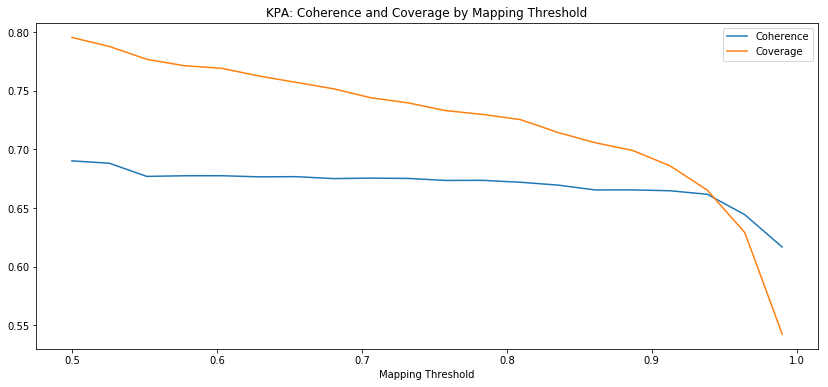

In [16]:
# Plot results
mt_results.plot(title='KPA: Coherence and Coverage by Mapping Threshold',
                x='Mapping Threshold', 
                y=['Coherence', 'Coverage'],  
                figsize=(14,6))

#### Results Interpretation


We can see that the coverage decreases slightly as the mapping threshold increases, decreasing at a faster pace as the mapping threshold appraoches 1. This is because a high mapping threshold means sentences require a higher match score to be assigned to a key point.

There is generally a very slight decrease in coherence as the mapping threshold is increased. Once the mapping threshold reaches 0.95-0.99, there is a significant decrease in both the coherence and coverage, indicating that the model is being too strict and removing too many quality sentences.

This analysis indicates that a mapping threshold of 0.95 or below is suitable for performing KPA on this data. The final choice would depend on the coverage required.

## Section 2: KPA Benchmarking

In this section we will benchmark the performance of KPA against a high performing topic modelling algorithm - Latent Dirichtlet Allocation (LDA). This model considers each document as a collection of words (i.e. the syntax and order of the words is not considered), and uses this to assign documents to a specified number of topics.

### 2.1 LDA

Firstly we will train an LDA model and perform hyper-parameter tuning. Initially, we import a pyLDAvis package for visualizing LDA models and import data that was generated in the previous notebook.

In [7]:
# Import pyLDAvis package to visualise LDA output - this is not required to train the LDA model
import pyLDAvis 
import pyLDAvis.gensim_models as pygen
pyLDAvis.enable_notebook()

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/sklearn/decomposition/_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [8]:
# Import processed DataFrame that was created in the first notebook
df = pd.read_csv('mtsamples_clean.csv', index_col='Unnamed: 0')
df.sample(5)

description  \
1130   Excision of left upper cheek skin neoplasm an...   
1223   Repair of upper lid canalicular laceration - ...   
1278   Hematemesis in a patient with longstanding di...   
2188   Atrial fibrillation with rapid ventricular re...   
1048   Repair of bilateral cleft of the palate with ...   

                   medical_specialty                   sample_name  \
1130                         Surgery    Excision - Skin Neoplasm     
1223                         Surgery        Lid Laceration Repair    
1278                         Surgery                BICAP Cautery    
2188   SOAP / Chart / Progress Notes   Atrial Fibrillation - SOAP    
1048                         Surgery                 Cleft Repair    

                                          transcription  \
1130  PREOPERATIVE DIAGNOSES:,1.  Enlarging nevus of...   
1223  PREOPERATIVE DIAGNOSES:,1. XXX upper lid lacer...   
1278  PREOPERATIVE DIAGNOSIS: ,  Hematemesis in a pa...   
2188  SUBJECTIVE: , The patient states that she feel...   
1048  PREOPERATIVE DIAGNOSES: , Bilateral cleft lip ...   

                                               keywords  \
1130  surgery, enlarging nevus, nevus, skin neoplasm...   
1223  surgery, laceration, monoka tube, westcott sci...   
1278  surgery, mallory-weiss tear, submucosal hemorr...   
2188  soap / chart / progress notes, ventricular tac...   
1048  surgery, bilateral cleft, cleft lip, oral muco...   

      medical_specialty_new  year               borough  
1130            Dermatology  2013               Enfield  
1223          Ophthalmology  2010  Richmond upon Thames  
1278       Gastroenterology  2013        Waltham Forest  
2188       General Medicine  2016                Merton  
1048   ENT - Otolaryngology  2016         Tower Hamlets

We apply a number of pre-processing steps to remove punctuation and stop-words, tokenize the text and generate the objects required to train an LDA model such as the dictionary and word corpus:

In [9]:
# Remove punctuation and numbers from description and convert to lower-case
df['description_processed'] = df['description'].map(lambda x: re.sub(r'[,\.!?\d+]', '', x)) \
                                               .map(lambda x: x.lower())

# Create list of descriptions
descriptions = df['description_processed'].to_list()

# Tokenize descriptions and filter out stopwords
description_words = []
for description in descriptions:
    # Convert description to lists of words, and remove furtherpunctuation
    words = simple_preprocess(description, deacc=True)
    # Remove stopwords
    words = [word for word in words if word not in stop_words]
    description_words.append(words)
    
# Create corpus and dictionary for descriptions
description_dict = corpora.Dictionary(description_words)
description_corpus = [description_dict.doc2bow(word) for word in description_words]

The below code performs hyper-parameter tuning for LDA models with a variety of parameters. Note that this function uses multiple CPU cores but as many models are tested it may take a long time. Reduce the number of parameters to test to reduce the amount of run-time:

In [20]:
MulLda_coherence_scores = []
MulLda_topics_val = []
MulLda_perplexity_val = []
MulLda_alphas = []
MulLda_etas = []

# Alpha parameter
alphas = list(np.arange(0.01, 1, 0.3))
alphas.append('symmetric')
alphas.append('asymmetric')

# Eta parameter
etas = list(np.arange(0.01, 1, 0.3))
etas.append('symmetric')

for topics in range(4, 20, 2):
    for alpha in alphas:
        for eta in etas:

            lda_model_multi = gensim.models.LdaMulticore(
                         corpus = description_corpus,
                         id2word = description_dict,
                         random_state = 42,
                         num_topics = topics,
                         alpha = alpha,
                         eta = eta,
                         passes=10,
                         chunksize=512,
                         offset=64,
                         iterations=100,
                         per_word_topics=True)

            coherence_model_MulLda = CoherenceModel(model = lda_model_multi, 
                                       texts = description_words, 
                                       dictionary = description_dict, 
                                       coherence = 'c_v',
                                       processes = num_cores)

            coherence_MulLda = coherence_model_MulLda.get_coherence()
            perplexity_MulLda = lda_model_multi.log_perplexity(description_corpus)

            MulLda_topics_val.append(topics)
            MulLda_alphas.append(alpha)   
            MulLda_etas.append(eta)
            MulLda_coherence_scores.append(coherence_MulLda)
            MulLda_perplexity_val.append(perplexity_MulLda)
            
df_mulLDA = pd.DataFrame(list(zip(MulLda_topics_val, 
                                  MulLda_alphas, 
                                  MulLda_etas, 
                                  MulLda_coherence_scores, 
                                  MulLda_perplexity_val)), 
                         columns = ["MulLda_Topic_Num", 
                                    "MulLda_alpha_val",
                                    "MulLda_etas", 
                                    "MulLda_Coherence_score", 
                                    "MulLda_Perplexity_val"])

df_mulLDA.sort_values("MulLda_Coherence_score", 
                      axis = 0, 
                      ascending = False, 
                      inplace = True) 

2021-10-08 15:27:34,890 [INFO] ldamodel.py 481: using serial LDA version on this node
2021-10-08 15:27:34,898 [INFO] ldamulticore.py 243: running online LDA training, 4 topics, 10 passes over the supplied corpus of 1862 documents, updating every 28160 documents, evaluating every ~1862 documents, iterating 100x with a convergence threshold of 0.001000
2021-10-08 15:27:34,899 [INFO] ldamulticore.py 279: training LDA model using 55 processes
2021-10-08 15:27:35,216 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:27:35,225 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:27:35,228 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:27:35,232 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #3 = documents up to #1862/1862, out

2021-10-08 15:27:37,019 [INFO] ldamodel.py 1171: topic #1 (0.010): 0.005*"anterior" + 0.004*"excision" + 0.004*"laparoscopic" + 0.004*"artery" + 0.004*"mass" + 0.004*"insertion" + 0.003*"bilateral" + 0.003*"carpal" + 0.003*"coronary" + 0.003*"tunnel"
2021-10-08 15:27:37,021 [INFO] ldamodel.py 1171: topic #2 (0.010): 0.010*"old" + 0.010*"year" + 0.009*"history" + 0.008*"pain" + 0.005*"female" + 0.004*"male" + 0.004*"normal" + 0.003*"hernia" + 0.003*"inguinal" + 0.003*"biopsy"
2021-10-08 15:27:37,023 [INFO] ldamodel.py 1171: topic #3 (0.010): 0.008*"ct" + 0.006*"contrast" + 0.005*"chest" + 0.005*"eye" + 0.005*"without" + 0.005*"pain" + 0.003*"cataract" + 0.003*"bilateral" + 0.003*"abdomen" + 0.003*"lower"
2021-10-08 15:27:37,024 [INFO] ldamodel.py 1049: topic diff=0.189320, rho=0.118150
2021-10-08 15:27:37,114 [INFO] ldamodel.py 824: -10.491 per-word bound, 1438.7 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:27:37,115 [INFO] ldamulticore.p

2021-10-08 15:27:38,051 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:27:38,054 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:27:38,057 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:27:38,176 [INFO] ldamodel.py 1171: topic #0 (0.010): 0.010*"bilateral" + 0.007*"knee" + 0.006*"open" + 0.006*"fracture" + 0.006*"fixation" + 0.005*"shoulder" + 0.005*"reduction" + 0.005*"repair" + 0.005*"internal" + 0.004*"upper"
2021-10-08 15:27:38,177 [INFO] ldamodel.py 1171: topic #1 (0.010): 0.007*"anterior" + 0.006*"excision" + 0.006*"laparoscopic" + 0.006*"artery" + 0.005*"insertion" + 0.005*"mass" + 0.005*"carpal" + 0.005*"cervical" + 0.005*"coronary" + 0.005*"tunnel"
2021-10-08 15:27:38,179 [INFO] ldamodel.py 1171: topic #2 (0.010): 0.01

2021-10-08 15:27:40,949 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:27:41,203 [INFO] ldamodel.py 1171: topic #0 (0.010): 0.004*"bilateral" + 0.003*"knee" + 0.003*"open" + 0.003*"fixation" + 0.002*"fracture" + 0.002*"repair" + 0.002*"internal" + 0.002*"upper" + 0.002*"reduction" + 0.002*"post"
2021-10-08 15:27:41,203 [INFO] ldamodel.py 1171: topic #1 (0.010): 0.003*"anterior" + 0.003*"excision" + 0.003*"artery" + 0.003*"laparoscopic" + 0.003*"mass" + 0.003*"insertion" + 0.002*"bilateral" + 0.002*"carpal" + 0.002*"coronary" + 0.002*"tunnel"
2021-10-08 15:27:41,206 [INFO] ldamodel.py 1171: topic #2 (0.010): 0.007*"old" + 0.007*"year" + 0.006*"history" + 0.006*"pain" + 0.004*"female" + 0.003*"male" + 0.003*"normal" + 0.002*"hernia" + 0.002*"inguinal" + 0.002*"biopsy"
2021-10-08 15:27:41,209 [INFO] ldamodel.py 1171: topic #3 (0.010): 0.005*"ct" + 0.004*"contrast" + 0.003*"eye" + 0.003*"chest" + 0.003*

2021-10-08 15:27:42,568 [INFO] ldamodel.py 1049: topic diff=0.093842, rho=0.115751
2021-10-08 15:27:42,660 [INFO] ldamodel.py 824: -8.126 per-word bound, 279.4 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:27:42,661 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:27:42,666 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:27:42,667 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:27:42,669 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:27:42,793 [INFO] ldamodel.py 1171: topic #0 (0.010): 0.007*"bilateral" + 0.005*"knee" + 0.005*"fracture" + 0.005*"open" + 0.005*"fixation" + 0.004*"shoulder" + 0.004*"

2021-10-08 15:27:45,491 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:27:45,494 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:27:45,497 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:27:45,757 [INFO] ldamodel.py 1171: topic #0 (0.010): 0.003*"bilateral" + 0.002*"knee" + 0.002*"fixation" + 0.002*"open" + 0.001*"upper" + 0.001*"repair" + 0.001*"internal" + 0.001*"fracture" + 0.001*"reduction" + 0.001*"acute"
2021-10-08 15:27:45,757 [INFO] ldamodel.py 1171: topic #1 (0.010): 0.002*"anterior" + 0.002*"excision" + 0.002*"artery" + 0.002*"laparoscopic" + 0.002*"mass" + 0.002*"insertion" + 0.002*"bilateral" + 0.002*"carpal" + 0.002*"coronary" + 0.002*"tunnel"
2021-10-08 15:27:45,759 [INFO] ldamodel.py 1171: topic #2 (0.010): 0.005*

2021-10-08 15:27:47,288 [INFO] ldamodel.py 1171: topic #3 (0.010): 0.007*"ct" + 0.005*"contrast" + 0.004*"eye" + 0.004*"chest" + 0.004*"without" + 0.003*"pain" + 0.003*"cataract" + 0.003*"abdomen" + 0.002*"lens" + 0.002*"lower"
2021-10-08 15:27:47,289 [INFO] ldamodel.py 1049: topic diff=0.063713, rho=0.116534
2021-10-08 15:27:47,405 [INFO] ldamodel.py 824: -8.077 per-word bound, 269.9 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:27:47,406 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:27:47,409 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:27:47,413 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:27:47,416 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #3 = docume

2021-10-08 15:27:50,175 [INFO] ldamodel.py 824: -8.590 per-word bound, 385.4 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:27:50,176 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:27:50,180 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:27:50,184 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:27:50,184 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:27:50,470 [INFO] ldamodel.py 1171: topic #0 (0.010): 0.002*"bilateral" + 0.001*"fixation" + 0.001*"open" + 0.001*"knee" + 0.001*"upper" + 0.001*"repair" + 0.001*"acute" + 0.001*"internal" + 0.001*"post" + 0.001*"placement"
2021-10-08 15:27:50,471 [IN

2021-10-08 15:27:51,881 [INFO] ldamodel.py 1171: topic #2 (0.010): 0.007*"old" + 0.007*"year" + 0.006*"history" + 0.006*"pain" + 0.004*"female" + 0.003*"male" + 0.003*"normal" + 0.002*"hernia" + 0.002*"inguinal" + 0.002*"biopsy"
2021-10-08 15:27:51,881 [INFO] ldamodel.py 1171: topic #3 (0.010): 0.005*"ct" + 0.004*"contrast" + 0.003*"eye" + 0.003*"chest" + 0.003*"without" + 0.003*"pain" + 0.002*"cataract" + 0.002*"abdomen" + 0.002*"lens" + 0.002*"lower"
2021-10-08 15:27:51,882 [INFO] ldamodel.py 1049: topic diff=0.052716, rho=0.117333
2021-10-08 15:27:51,983 [INFO] ldamodel.py 824: -8.095 per-word bound, 273.5 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:27:51,984 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:27:51,987 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:

2021-10-08 15:27:54,215 [INFO] ldamodel.py 481: using serial LDA version on this node
2021-10-08 15:27:54,218 [INFO] ldamulticore.py 243: running online LDA training, 4 topics, 10 passes over the supplied corpus of 1862 documents, updating every 28160 documents, evaluating every ~1862 documents, iterating 100x with a convergence threshold of 0.001000
2021-10-08 15:27:54,219 [INFO] ldamulticore.py 279: training LDA model using 55 processes
2021-10-08 15:27:54,556 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:27:54,565 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:27:54,569 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:27:54,570 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #3 = documents up to #1862/1862, out

2021-10-08 15:27:56,563 [INFO] ldamodel.py 1171: topic #1 (0.010): 0.004*"anterior" + 0.004*"excision" + 0.004*"artery" + 0.003*"laparoscopic" + 0.003*"mass" + 0.003*"insertion" + 0.003*"bilateral" + 0.003*"coronary" + 0.003*"carpal" + 0.003*"tunnel"
2021-10-08 15:27:56,564 [INFO] ldamodel.py 1171: topic #2 (0.010): 0.009*"old" + 0.008*"year" + 0.008*"history" + 0.007*"pain" + 0.005*"female" + 0.003*"male" + 0.003*"normal" + 0.003*"hernia" + 0.003*"inguinal" + 0.003*"biopsy"
2021-10-08 15:27:56,565 [INFO] ldamodel.py 1171: topic #3 (0.010): 0.007*"ct" + 0.005*"contrast" + 0.004*"eye" + 0.004*"chest" + 0.004*"without" + 0.004*"pain" + 0.003*"cataract" + 0.003*"bilateral" + 0.002*"abdomen" + 0.002*"lower"
2021-10-08 15:27:56,566 [INFO] ldamodel.py 1049: topic diff=0.116383, rho=0.118150
2021-10-08 15:27:56,660 [INFO] ldamodel.py 824: -8.353 per-word bound, 327.0 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:27:56,661 [INFO] ldamulticore.py 

2021-10-08 15:27:57,893 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:27:57,894 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:27:57,894 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:27:58,092 [INFO] ldamodel.py 1171: topic #0 (0.010): 0.008*"bilateral" + 0.006*"knee" + 0.005*"open" + 0.005*"fracture" + 0.005*"fixation" + 0.005*"shoulder" + 0.004*"repair" + 0.004*"reduction" + 0.004*"internal" + 0.003*"upper"
2021-10-08 15:27:58,093 [INFO] ldamodel.py 1171: topic #1 (0.010): 0.006*"anterior" + 0.005*"artery" + 0.005*"excision" + 0.005*"laparoscopic" + 0.004*"coronary" + 0.004*"insertion" + 0.004*"mass" + 0.004*"cervical" + 0.004*"carpal" + 0.004*"tunnel"
2021-10-08 15:27:58,094 [INFO] ldamodel.py 1171: topic #2 (0.010): 0.01

2021-10-08 15:28:01,514 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:28:01,834 [INFO] ldamodel.py 1171: topic #0 (0.310): 0.006*"bilateral" + 0.003*"fixation" + 0.003*"open" + 0.003*"internal" + 0.003*"fracture" + 0.003*"knee" + 0.003*"reduction" + 0.003*"repair" + 0.003*"upper" + 0.002*"nerve"
2021-10-08 15:28:01,835 [INFO] ldamodel.py 1171: topic #1 (0.310): 0.004*"anterior" + 0.004*"excision" + 0.004*"artery" + 0.003*"laparoscopic" + 0.003*"mass" + 0.003*"carpal" + 0.003*"tunnel" + 0.003*"insertion" + 0.003*"disease" + 0.002*"coronary"
2021-10-08 15:28:01,835 [INFO] ldamodel.py 1171: topic #2 (0.310): 0.009*"old" + 0.009*"year" + 0.008*"history" + 0.007*"pain" + 0.005*"female" + 0.003*"normal" + 0.003*"male" + 0.003*"hernia" + 0.003*"biopsy" + 0.003*"inguinal"
2021-10-08 15:28:01,836 [INFO] ldamodel.py 1171: topic #3 (0.310): 0.007*"ct" + 0.005*"contrast" + 0.004*"chest" + 0.004*"eye" + 0.004*"

2021-10-08 15:28:03,535 [INFO] ldamodel.py 824: -10.319 per-word bound, 1277.3 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:28:03,535 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:28:03,539 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:28:03,543 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:28:03,544 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:28:03,872 [INFO] ldamodel.py 1171: topic #0 (0.310): 0.010*"bilateral" + 0.006*"knee" + 0.006*"open" + 0.006*"fracture" + 0.006*"fixation" + 0.005*"reduction" + 0.005*"repair" + 0.005*"internal" + 0.005*"shoulder" + 0.004*"nerve"
2021-10-08 15:28:0

2021-10-08 15:28:07,264 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:28:07,267 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:28:07,271 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:28:07,649 [INFO] ldamodel.py 1171: topic #0 (0.310): 0.004*"bilateral" + 0.002*"fixation" + 0.002*"open" + 0.002*"internal" + 0.002*"knee" + 0.002*"upper" + 0.002*"fracture" + 0.002*"repair" + 0.002*"reduction" + 0.002*"nerve"
2021-10-08 15:28:07,650 [INFO] ldamodel.py 1171: topic #1 (0.310): 0.003*"anterior" + 0.002*"excision" + 0.002*"artery" + 0.002*"laparoscopic" + 0.002*"mass" + 0.002*"carpal" + 0.002*"insertion" + 0.002*"tunnel" + 0.002*"disease" + 0.002*"syndrome"
2021-10-08 15:28:07,651 [INFO] ldamodel.py 1171: topic #2 (0.310): 0.006*"o

2021-10-08 15:28:09,500 [INFO] ldamodel.py 1171: topic #3 (0.310): 0.009*"ct" + 0.006*"contrast" + 0.006*"chest" + 0.005*"eye" + 0.005*"without" + 0.004*"pain" + 0.003*"cataract" + 0.003*"abdomen" + 0.003*"mri" + 0.003*"bilateral"
2021-10-08 15:28:09,501 [INFO] ldamodel.py 1049: topic diff=0.097894, rho=0.116534
2021-10-08 15:28:09,617 [INFO] ldamodel.py 824: -8.296 per-word bound, 314.3 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:28:09,618 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:28:09,621 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:28:09,625 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:28:09,625 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #3 = doc

2021-10-08 15:28:13,215 [INFO] ldamodel.py 824: -8.808 per-word bound, 448.3 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:28:13,216 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:28:13,217 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:28:13,220 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:28:13,221 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:28:13,630 [INFO] ldamodel.py 1171: topic #0 (0.310): 0.002*"bilateral" + 0.001*"fixation" + 0.001*"open" + 0.001*"internal" + 0.001*"upper" + 0.001*"repair" + 0.001*"knee" + 0.001*"acute" + 0.001*"placement" + 0.001*"reduction"
2021-10-08 15:28:13,63

2021-10-08 15:28:15,533 [INFO] ldamodel.py 1171: topic #2 (0.310): 0.008*"old" + 0.008*"year" + 0.007*"history" + 0.007*"pain" + 0.005*"female" + 0.003*"normal" + 0.003*"male" + 0.003*"hernia" + 0.003*"biopsy" + 0.002*"inguinal"
2021-10-08 15:28:15,534 [INFO] ldamodel.py 1171: topic #3 (0.310): 0.006*"ct" + 0.004*"contrast" + 0.004*"eye" + 0.004*"chest" + 0.003*"without" + 0.003*"pain" + 0.003*"cataract" + 0.002*"abdomen" + 0.002*"lower" + 0.002*"mri"
2021-10-08 15:28:15,535 [INFO] ldamodel.py 1049: topic diff=0.068931, rho=0.117333
2021-10-08 15:28:15,655 [INFO] ldamodel.py 824: -8.246 per-word bound, 303.6 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:28:15,656 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:28:15,659 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:2

2021-10-08 15:28:18,160 [INFO] ldamulticore.py 243: running online LDA training, 4 topics, 10 passes over the supplied corpus of 1862 documents, updating every 28160 documents, evaluating every ~1862 documents, iterating 100x with a convergence threshold of 0.001000
2021-10-08 15:28:18,162 [INFO] ldamulticore.py 279: training LDA model using 55 processes
2021-10-08 15:28:18,494 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:28:18,503 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:28:18,506 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:28:18,509 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:28:19,197 [INFO] ldamodel.py 1171: topic #0 (0.310

2021-10-08 15:28:21,432 [INFO] ldamodel.py 1171: topic #1 (0.310): 0.003*"anterior" + 0.003*"artery" + 0.003*"excision" + 0.002*"mass" + 0.002*"laparoscopic" + 0.002*"insertion" + 0.002*"carpal" + 0.002*"tunnel" + 0.002*"cervical" + 0.002*"disease"
2021-10-08 15:28:21,433 [INFO] ldamodel.py 1171: topic #2 (0.310): 0.007*"old" + 0.006*"year" + 0.006*"history" + 0.005*"pain" + 0.004*"female" + 0.002*"normal" + 0.002*"male" + 0.002*"hernia" + 0.002*"biopsy" + 0.002*"inguinal"
2021-10-08 15:28:21,434 [INFO] ldamodel.py 1171: topic #3 (0.310): 0.005*"ct" + 0.003*"contrast" + 0.003*"eye" + 0.003*"chest" + 0.003*"without" + 0.002*"pain" + 0.002*"cataract" + 0.002*"abdomen" + 0.002*"lower" + 0.002*"stress"
2021-10-08 15:28:21,435 [INFO] ldamodel.py 1049: topic diff=0.058140, rho=0.118150
2021-10-08 15:28:21,560 [INFO] ldamodel.py 824: -8.280 per-word bound, 310.7 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:28:21,561 [INFO] ldamulticore.py 297: 

2021-10-08 15:28:23,206 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:28:23,209 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:28:23,497 [INFO] ldamodel.py 1171: topic #0 (0.310): 0.007*"bilateral" + 0.004*"knee" + 0.004*"fracture" + 0.004*"fixation" + 0.004*"open" + 0.003*"repair" + 0.003*"reduction" + 0.003*"shoulder" + 0.003*"internal" + 0.002*"nerve"
2021-10-08 15:28:23,498 [INFO] ldamodel.py 1171: topic #1 (0.310): 0.005*"anterior" + 0.004*"artery" + 0.004*"excision" + 0.003*"mass" + 0.003*"coronary" + 0.003*"cervical" + 0.003*"insertion" + 0.003*"carpal" + 0.003*"tunnel" + 0.003*"laparoscopic"
2021-10-08 15:28:23,499 [INFO] ldamodel.py 1171: topic #2 (0.310): 0.010*"old" + 0.009*"year" + 0.008*"history" + 0.008*"pain" + 0.005*"female" + 0.003*"normal" + 0.003*"male" + 0.003*"hernia" + 0.003*"inguinal" + 0.

2021-10-08 15:28:27,549 [INFO] ldamodel.py 1171: topic #0 (0.310): 0.005*"bilateral" + 0.003*"fixation" + 0.003*"open" + 0.003*"knee" + 0.003*"fracture" + 0.002*"internal" + 0.002*"reduction" + 0.002*"repair" + 0.002*"upper" + 0.002*"nerve"
2021-10-08 15:28:27,550 [INFO] ldamodel.py 1171: topic #1 (0.310): 0.004*"anterior" + 0.003*"excision" + 0.003*"artery" + 0.003*"laparoscopic" + 0.003*"mass" + 0.002*"carpal" + 0.002*"insertion" + 0.002*"tunnel" + 0.002*"disease" + 0.002*"cervical"
2021-10-08 15:28:27,551 [INFO] ldamodel.py 1171: topic #2 (0.310): 0.008*"old" + 0.007*"year" + 0.007*"history" + 0.006*"pain" + 0.004*"female" + 0.003*"normal" + 0.003*"male" + 0.003*"hernia" + 0.002*"biopsy" + 0.002*"inguinal"
2021-10-08 15:28:27,554 [INFO] ldamodel.py 1171: topic #3 (0.310): 0.006*"ct" + 0.004*"contrast" + 0.004*"chest" + 0.004*"eye" + 0.003*"without" + 0.003*"pain" + 0.002*"cataract" + 0.002*"bilateral" + 0.002*"abdomen" + 0.002*"lower"
2021-10-08 15:28:27,555 [INFO] ldamodel.py 1049:

2021-10-08 15:28:29,447 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:28:29,450 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:28:29,454 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:28:29,457 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:28:29,621 [INFO] ldamodel.py 1171: topic #0 (0.310): 0.009*"bilateral" + 0.005*"knee" + 0.005*"fixation" + 0.005*"fracture" + 0.005*"open" + 0.004*"reduction" + 0.004*"repair" + 0.004*"internal" + 0.004*"shoulder" + 0.003*"nerve"
2021-10-08 15:28:29,622 [INFO] ldamodel.py 1171: topic #1 (0.310): 0.006*"anterior" + 0.005*"excision" + 0.005*"artery" + 0.004*"mass" + 0.004*"insertion" + 0.004*"cervical" + 0

2021-10-08 15:28:33,495 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:28:33,964 [INFO] ldamodel.py 1171: topic #0 (0.610): 0.005*"bilateral" + 0.003*"fixation" + 0.002*"open" + 0.002*"upper" + 0.002*"internal" + 0.002*"repair" + 0.002*"knee" + 0.002*"nerve" + 0.002*"acute" + 0.002*"reduction"
2021-10-08 15:28:33,965 [INFO] ldamodel.py 1171: topic #1 (0.610): 0.003*"artery" + 0.003*"anterior" + 0.003*"excision" + 0.003*"laparoscopic" + 0.003*"disease" + 0.002*"coronary" + 0.002*"carpal" + 0.002*"tunnel" + 0.002*"insertion" + 0.002*"renal"
2021-10-08 15:28:33,966 [INFO] ldamodel.py 1171: topic #2 (0.610): 0.007*"old" + 0.007*"year" + 0.006*"history" + 0.005*"pain" + 0.003*"female" + 0.002*"normal" + 0.002*"biopsy" + 0.002*"hernia" + 0.002*"male" + 0.002*"inguinal"
2021-10-08 15:28:33,966 [INFO] ldamodel.py 1171: topic #3 (0.610): 0.005*"ct" + 0.003*"contrast" + 0.003*"pain" + 0.003*"eye" + 0.003*"che

2021-10-08 15:28:35,624 [INFO] ldamodel.py 824: -10.510 per-word bound, 1457.8 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:28:35,624 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:28:35,628 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:28:35,631 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:28:35,632 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:28:35,864 [INFO] ldamodel.py 1171: topic #0 (0.610): 0.012*"bilateral" + 0.006*"knee" + 0.006*"fixation" + 0.006*"fracture" + 0.006*"open" + 0.005*"repair" + 0.005*"reduction" + 0.005*"internal" + 0.004*"nerve" + 0.004*"upper"
2021-10-08 15:28:35,8

2021-10-08 15:28:39,066 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:28:39,069 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:28:39,069 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:28:39,697 [INFO] ldamodel.py 1171: topic #0 (0.610): 0.003*"bilateral" + 0.001*"upper" + 0.001*"fixation" + 0.001*"open" + 0.001*"internal" + 0.001*"acute" + 0.001*"repair" + 0.001*"pain" + 0.001*"knee" + 0.001*"nerve"
2021-10-08 15:28:39,698 [INFO] ldamodel.py 1171: topic #1 (0.610): 0.002*"artery" + 0.002*"anterior" + 0.002*"laparoscopic" + 0.002*"excision" + 0.001*"disease" + 0.001*"pain" + 0.001*"carpal" + 0.001*"tunnel" + 0.001*"coronary" + 0.001*"foot"
2021-10-08 15:28:39,699 [INFO] ldamodel.py 1171: topic #2 (0.610): 0.004*"old" + 0.003*"

2021-10-08 15:28:42,094 [INFO] ldamodel.py 1171: topic #3 (0.610): 0.008*"ct" + 0.005*"contrast" + 0.005*"chest" + 0.005*"eye" + 0.004*"without" + 0.004*"pain" + 0.003*"cataract" + 0.003*"abdomen" + 0.003*"lower" + 0.002*"bilateral"
2021-10-08 15:28:42,094 [INFO] ldamodel.py 1049: topic diff=0.097717, rho=0.117333
2021-10-08 15:28:42,212 [INFO] ldamodel.py 824: -8.430 per-word bound, 344.8 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:28:42,213 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:28:42,216 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:28:42,220 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:28:42,220 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #3 = d

2021-10-08 15:28:44,756 [INFO] ldamulticore.py 279: training LDA model using 55 processes
2021-10-08 15:28:45,095 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:28:45,104 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:28:45,112 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:28:45,114 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:28:46,048 [INFO] ldamodel.py 1171: topic #0 (0.610): 0.001*"bilateral" + 0.001*"old" + 0.001*"upper" + 0.001*"pain" + 0.001*"acute" + 0.001*"open" + 0.001*"year" + 0.001*"fixation" + 0.001*"repair" + 0.001*"cervical"
2021-10-08 15:28:46,049 [INFO] ldamodel.py 1171: topic #1 (0.610): 0.001*"pain" + 0.001*"laparoscopi

2021-10-08 15:28:49,038 [INFO] ldamodel.py 1171: topic #2 (0.610): 0.007*"old" + 0.007*"year" + 0.006*"history" + 0.006*"pain" + 0.004*"female" + 0.002*"normal" + 0.002*"male" + 0.002*"biopsy" + 0.002*"hernia" + 0.002*"inguinal"
2021-10-08 15:28:49,039 [INFO] ldamodel.py 1171: topic #3 (0.610): 0.006*"ct" + 0.004*"contrast" + 0.003*"eye" + 0.003*"chest" + 0.003*"without" + 0.003*"pain" + 0.002*"cataract" + 0.002*"abdomen" + 0.002*"lower" + 0.002*"bilateral"
2021-10-08 15:28:49,040 [INFO] ldamodel.py 1049: topic diff=0.071391, rho=0.118150
2021-10-08 15:28:49,182 [INFO] ldamodel.py 824: -8.371 per-word bound, 331.2 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:28:49,183 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:28:49,187 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-0

2021-10-08 15:28:51,262 [INFO] ldamodel.py 1171: topic #0 (0.610): 0.010*"bilateral" + 0.005*"knee" + 0.005*"fracture" + 0.005*"fixation" + 0.004*"open" + 0.004*"repair" + 0.004*"reduction" + 0.004*"internal" + 0.003*"nerve" + 0.003*"upper"
2021-10-08 15:28:51,264 [INFO] ldamodel.py 1171: topic #1 (0.610): 0.006*"anterior" + 0.005*"artery" + 0.005*"coronary" + 0.005*"excision" + 0.004*"renal" + 0.004*"disease" + 0.004*"laparoscopic" + 0.004*"mass" + 0.004*"insertion" + 0.003*"carpal"
2021-10-08 15:28:51,265 [INFO] ldamodel.py 1171: topic #2 (0.610): 0.011*"old" + 0.010*"year" + 0.009*"history" + 0.009*"pain" + 0.006*"female" + 0.004*"male" + 0.004*"normal" + 0.003*"biopsy" + 0.003*"hernia" + 0.003*"inguinal"
2021-10-08 15:28:51,266 [INFO] ldamodel.py 1171: topic #3 (0.610): 0.010*"ct" + 0.006*"chest" + 0.006*"contrast" + 0.006*"eye" + 0.005*"without" + 0.003*"pain" + 0.003*"cataract" + 0.003*"mri" + 0.003*"abdomen" + 0.003*"lower"
2021-10-08 15:28:51,267 [INFO] ldamodel.py 1049: topic 

2021-10-08 15:28:56,200 [INFO] ldamodel.py 1171: topic #2 (0.610): 0.005*"old" + 0.005*"year" + 0.005*"history" + 0.004*"pain" + 0.003*"female" + 0.002*"normal" + 0.002*"male" + 0.002*"biopsy" + 0.002*"hernia" + 0.002*"inguinal"
2021-10-08 15:28:56,201 [INFO] ldamodel.py 1171: topic #3 (0.610): 0.004*"ct" + 0.002*"contrast" + 0.002*"eye" + 0.002*"chest" + 0.002*"without" + 0.002*"pain" + 0.001*"cataract" + 0.001*"abdomen" + 0.001*"lower" + 0.001*"bilateral"
2021-10-08 15:28:56,202 [INFO] ldamodel.py 1049: topic diff=0.060338, rho=0.118983
2021-10-08 15:28:56,359 [INFO] ldamodel.py 824: -8.409 per-word bound, 340.0 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:28:56,360 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:28:56,363 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-0

2021-10-08 15:28:58,702 [INFO] ldamodel.py 1171: topic #0 (0.610): 0.008*"bilateral" + 0.004*"knee" + 0.004*"fixation" + 0.004*"fracture" + 0.003*"open" + 0.003*"internal" + 0.003*"reduction" + 0.003*"repair" + 0.002*"nerve" + 0.002*"upper"
2021-10-08 15:28:58,703 [INFO] ldamodel.py 1171: topic #1 (0.610): 0.005*"anterior" + 0.004*"artery" + 0.004*"coronary" + 0.004*"excision" + 0.003*"disease" + 0.003*"mass" + 0.003*"renal" + 0.003*"laparoscopic" + 0.003*"insertion" + 0.003*"carpal"
2021-10-08 15:28:58,704 [INFO] ldamodel.py 1171: topic #2 (0.610): 0.009*"old" + 0.008*"year" + 0.008*"pain" + 0.008*"history" + 0.005*"female" + 0.003*"male" + 0.003*"normal" + 0.003*"biopsy" + 0.003*"post" + 0.003*"hernia"
2021-10-08 15:28:58,705 [INFO] ldamodel.py 1171: topic #3 (0.610): 0.008*"ct" + 0.005*"chest" + 0.005*"contrast" + 0.005*"eye" + 0.004*"without" + 0.003*"cataract" + 0.003*"pain" + 0.003*"abdomen" + 0.003*"mri" + 0.002*"lower"
2021-10-08 15:28:58,706 [INFO] ldamodel.py 1049: topic diff

2021-10-08 15:29:02,947 [INFO] ldamodel.py 1171: topic #1 (0.610): 0.003*"artery" + 0.002*"anterior" + 0.002*"excision" + 0.002*"laparoscopic" + 0.002*"disease" + 0.002*"coronary" + 0.002*"carpal" + 0.002*"tunnel" + 0.002*"mass" + 0.002*"insertion"
2021-10-08 15:29:02,948 [INFO] ldamodel.py 1171: topic #2 (0.610): 0.006*"old" + 0.006*"year" + 0.005*"history" + 0.005*"pain" + 0.003*"female" + 0.002*"normal" + 0.002*"biopsy" + 0.002*"hernia" + 0.002*"male" + 0.002*"inguinal"
2021-10-08 15:29:02,950 [INFO] ldamodel.py 1171: topic #3 (0.610): 0.004*"ct" + 0.003*"contrast" + 0.003*"eye" + 0.003*"pain" + 0.003*"chest" + 0.002*"without" + 0.002*"bilateral" + 0.002*"chronic" + 0.002*"lower" + 0.002*"cataract"
2021-10-08 15:29:02,950 [INFO] ldamodel.py 1049: topic diff=0.118806, rho=0.119834
2021-10-08 15:29:03,107 [INFO] ldamodel.py 824: -8.783 per-word bound, 440.4 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:29:03,108 [INFO] ldamulticore.py 29

2021-10-08 15:29:04,883 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:29:04,884 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:29:05,137 [INFO] ldamodel.py 1171: topic #0 (0.610): 0.010*"bilateral" + 0.005*"knee" + 0.005*"fixation" + 0.005*"fracture" + 0.005*"open" + 0.004*"repair" + 0.004*"internal" + 0.004*"reduction" + 0.004*"nerve" + 0.003*"upper"
2021-10-08 15:29:05,138 [INFO] ldamodel.py 1171: topic #1 (0.610): 0.006*"anterior" + 0.006*"artery" + 0.005*"excision" + 0.005*"coronary" + 0.004*"laparoscopic" + 0.004*"disease" + 0.004*"renal" + 0.004*"insertion" + 0.004*"mass" + 0.004*"carpal"
2021-10-08 15:29:05,139 [INFO] ldamodel.py 1171: topic #2 (0.610): 0.012*"old" + 0.011*"year" + 0.010*"history" + 0.010*"pain" + 0.007*"female" + 0.004*"male" + 0.004*"normal" + 0.004*"biopsy" + 0.003*"hernia" + 0.003*"in

2021-10-08 15:29:08,327 [INFO] ldamodel.py 1171: topic #1 (0.910): 0.002*"pain" + 0.002*"artery" + 0.002*"anterior" + 0.002*"laparoscopic" + 0.002*"disease" + 0.002*"bilateral" + 0.002*"excision" + 0.001*"year" + 0.001*"old" + 0.001*"chest"
2021-10-08 15:29:08,329 [INFO] ldamodel.py 1171: topic #2 (0.910): 0.004*"old" + 0.003*"history" + 0.003*"year" + 0.003*"pain" + 0.002*"bilateral" + 0.002*"female" + 0.002*"biopsy" + 0.001*"repair" + 0.001*"normal" + 0.001*"hernia"
2021-10-08 15:29:08,329 [INFO] ldamodel.py 1171: topic #3 (0.910): 0.003*"ct" + 0.002*"pain" + 0.002*"bilateral" + 0.002*"eye" + 0.002*"chest" + 0.002*"contrast" + 0.002*"without" + 0.001*"old" + 0.001*"chronic" + 0.001*"year"
2021-10-08 15:29:08,330 [INFO] ldamodel.py 1049: topic diff=0.158395, rho=0.120704
2021-10-08 15:29:08,481 [INFO] ldamodel.py 824: -11.267 per-word bound, 2464.9 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:29:08,482 [INFO] ldamulticore.py 297: PROGRE

2021-10-08 15:29:10,160 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:29:10,163 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:29:10,459 [INFO] ldamodel.py 1171: topic #0 (0.910): 0.010*"bilateral" + 0.005*"fixation" + 0.005*"open" + 0.004*"fracture" + 0.004*"knee" + 0.004*"internal" + 0.004*"reduction" + 0.004*"nerve" + 0.004*"upper" + 0.004*"repair"
2021-10-08 15:29:10,460 [INFO] ldamodel.py 1171: topic #1 (0.910): 0.006*"artery" + 0.006*"anterior" + 0.005*"excision" + 0.005*"coronary" + 0.005*"disease" + 0.004*"laparoscopic" + 0.004*"renal" + 0.004*"insertion" + 0.004*"carpal" + 0.004*"tunnel"
2021-10-08 15:29:10,461 [INFO] ldamodel.py 1171: topic #2 (0.910): 0.013*"old" + 0.012*"year" + 0.011*"history" + 0.009*"pain" + 0.006*"female" + 0.004*"male" + 0.004*"hernia" + 0.004*"normal" + 0.004*"inguinal" + 0.004

2021-10-08 15:29:13,165 [INFO] ldamodel.py 1171: topic #0 (0.910): 0.001*"bilateral" + 0.001*"old" + 0.001*"pain" + 0.001*"upper" + 0.001*"year" + 0.001*"history" + 0.001*"acute" + 0.001*"female" + 0.001*"cervical" + 0.001*"open"
2021-10-08 15:29:13,166 [INFO] ldamodel.py 1171: topic #1 (0.910): 0.001*"pain" + 0.001*"bilateral" + 0.001*"year" + 0.001*"old" + 0.001*"laparoscopic" + 0.001*"anterior" + 0.001*"disease" + 0.001*"artery" + 0.001*"history" + 0.001*"chest"
2021-10-08 15:29:13,167 [INFO] ldamodel.py 1171: topic #2 (0.910): 0.001*"history" + 0.001*"old" + 0.001*"pain" + 0.001*"year" + 0.001*"bilateral" + 0.001*"normal" + 0.001*"biopsy" + 0.001*"repair" + 0.001*"cervical" + 0.001*"open"
2021-10-08 15:29:13,168 [INFO] ldamodel.py 1171: topic #3 (0.910): 0.001*"ct" + 0.001*"pain" + 0.001*"bilateral" + 0.001*"old" + 0.001*"year" + 0.001*"history" + 0.001*"chronic" + 0.001*"eye" + 0.001*"chest" + 0.001*"knee"
2021-10-08 15:29:13,168 [INFO] ldamodel.py 1049: topic diff=0.143201, rho=0

2021-10-08 15:29:15,285 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:29:15,289 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:29:15,289 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:29:15,293 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:29:15,619 [INFO] ldamodel.py 1171: topic #0 (0.910): 0.007*"bilateral" + 0.003*"fixation" + 0.003*"open" + 0.003*"fracture" + 0.003*"knee" + 0.003*"internal" + 0.003*"upper" + 0.003*"reduction" + 0.002*"nerve" + 0.002*"repair"
2021-10-08 15:29:15,620 [INFO] ldamodel.py 1171: topic #1 (0.910): 0.004*"artery" + 0.004*"anterior" + 0.004*"coronary" + 0.003*"excision" + 0.003*"disease" + 0.003*"laparoscopic" 

2021-10-08 15:29:17,038 [INFO] ldamodel.py 1171: topic #3 (0.910): 0.011*"ct" + 0.007*"chest" + 0.007*"contrast" + 0.006*"eye" + 0.006*"without" + 0.005*"pain" + 0.004*"abdomen" + 0.004*"cataract" + 0.003*"lower" + 0.003*"mri"
2021-10-08 15:29:17,038 [INFO] ldamodel.py 1049: topic diff=0.082118, rho=0.114230
2021-10-08 15:29:17,140 [INFO] ldamodel.py 824: -8.328 per-word bound, 321.3 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:29:17,391 [INFO] probability_estimation.py 155: using WordOccurrenceAccumulator to estimate probabilities from sliding windows
2021-10-08 15:29:17,441 [INFO] text_analysis.py 124: WordOccurrenceAccumulator accumulated stats from 1000 documents
2021-10-08 15:29:18,206 [INFO] ldamodel.py 824: -8.161 per-word bound, 286.3 perplexity estimate based on a held-out corpus of 1862 documents with 21664 words
2021-10-08 15:29:18,208 [INFO] ldamodel.py 481: using serial LDA version on this node
2021-10-08 15:29:18,210 [INFO]

2021-10-08 15:29:20,975 [INFO] ldamodel.py 824: -8.502 per-word bound, 362.5 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:29:20,976 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:29:20,977 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:29:20,981 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:29:20,985 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:29:21,353 [INFO] ldamodel.py 1171: topic #0 (0.910): 0.005*"bilateral" + 0.002*"fixation" + 0.002*"open" + 0.002*"internal" + 0.002*"fracture" + 0.002*"upper" + 0.002*"knee" + 0.002*"reduction" + 0.002*"repair" + 0.002*"nerve"
2021-10-08 15:29:21,354

2021-10-08 15:29:23,109 [INFO] ldamodel.py 1171: topic #2 (0.910): 0.010*"old" + 0.009*"year" + 0.009*"history" + 0.008*"pain" + 0.005*"female" + 0.003*"male" + 0.003*"biopsy" + 0.003*"hernia" + 0.003*"normal" + 0.003*"inguinal"
2021-10-08 15:29:23,131 [INFO] ldamodel.py 1171: topic #3 (0.910): 0.008*"ct" + 0.005*"contrast" + 0.005*"chest" + 0.005*"eye" + 0.004*"without" + 0.004*"pain" + 0.003*"abdomen" + 0.003*"cataract" + 0.003*"lower" + 0.002*"mri"
2021-10-08 15:29:23,131 [INFO] ldamodel.py 1049: topic diff=0.052713, rho=0.114983
2021-10-08 15:29:23,248 [INFO] ldamodel.py 824: -8.274 per-word bound, 309.6 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:29:23,249 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:29:23,253 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:2

2021-10-08 15:29:26,447 [INFO] ldamodel.py 1049: topic diff=0.059743, rho=0.119834
2021-10-08 15:29:26,597 [INFO] ldamodel.py 824: -8.529 per-word bound, 369.5 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:29:26,598 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:29:26,602 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:29:26,605 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:29:26,605 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:29:27,044 [INFO] ldamodel.py 1171: topic #0 (0.910): 0.003*"bilateral" + 0.002*"fixation" + 0.001*"open" + 0.001*"upper" + 0.001*"pain" + 0.001*"internal" + 0.001*"kne

2021-10-08 15:29:29,043 [INFO] ldamodel.py 1171: topic #2 (0.910): 0.008*"old" + 0.007*"year" + 0.007*"history" + 0.006*"pain" + 0.004*"female" + 0.003*"male" + 0.002*"biopsy" + 0.002*"hernia" + 0.002*"inguinal" + 0.002*"normal"
2021-10-08 15:29:29,044 [INFO] ldamodel.py 1171: topic #3 (0.910): 0.006*"ct" + 0.004*"contrast" + 0.004*"eye" + 0.004*"chest" + 0.003*"without" + 0.003*"pain" + 0.002*"abdomen" + 0.002*"cataract" + 0.002*"lower" + 0.002*"lens"
2021-10-08 15:29:29,044 [INFO] ldamodel.py 1049: topic diff=0.041047, rho=0.115751
2021-10-08 15:29:29,204 [INFO] ldamodel.py 824: -8.293 per-word bound, 313.7 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:29:29,205 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:29:29,209 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:

2021-10-08 15:29:32,593 [INFO] ldamodel.py 1171: topic #3 (0.910): 0.002*"ct" + 0.002*"pain" + 0.002*"bilateral" + 0.001*"eye" + 0.001*"chest" + 0.001*"contrast" + 0.001*"without" + 0.001*"old" + 0.001*"chronic" + 0.001*"year"
2021-10-08 15:29:32,594 [INFO] ldamodel.py 1049: topic diff=0.117018, rho=0.120704
2021-10-08 15:29:32,748 [INFO] ldamodel.py 824: -8.984 per-word bound, 506.4 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:29:32,749 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:29:32,753 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:29:32,756 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:29:32,760 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #3 = documen

2021-10-08 15:29:35,184 [INFO] ldamodel.py 1171: topic #1 (0.910): 0.005*"artery" + 0.005*"anterior" + 0.004*"coronary" + 0.004*"excision" + 0.004*"disease" + 0.003*"laparoscopic" + 0.003*"renal" + 0.003*"carpal" + 0.003*"insertion" + 0.003*"tunnel"
2021-10-08 15:29:35,186 [INFO] ldamodel.py 1171: topic #2 (0.910): 0.011*"old" + 0.010*"year" + 0.009*"history" + 0.008*"pain" + 0.005*"female" + 0.003*"male" + 0.003*"hernia" + 0.003*"biopsy" + 0.003*"inguinal" + 0.003*"normal"
2021-10-08 15:29:35,188 [INFO] ldamodel.py 1171: topic #3 (0.910): 0.009*"ct" + 0.005*"contrast" + 0.005*"chest" + 0.005*"eye" + 0.005*"without" + 0.004*"pain" + 0.003*"abdomen" + 0.003*"cataract" + 0.003*"bilateral" + 0.003*"lower"
2021-10-08 15:29:35,189 [INFO] ldamodel.py 1049: topic diff=0.097010, rho=0.116534
2021-10-08 15:29:35,304 [INFO] ldamodel.py 824: -8.518 per-word bound, 366.6 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:29:35,304 [INFO] ldamulticore.py 2

2021-10-08 15:29:38,596 [INFO] ldamodel.py 1171: topic #2 (0.250): 0.003*"old" + 0.002*"history" + 0.002*"year" + 0.002*"pain" + 0.001*"normal" + 0.001*"female" + 0.001*"hernia" + 0.001*"biopsy" + 0.001*"inguinal" + 0.001*"repair"
2021-10-08 15:29:38,597 [INFO] ldamodel.py 1171: topic #3 (0.250): 0.002*"ct" + 0.001*"pain" + 0.001*"contrast" + 0.001*"eye" + 0.001*"chest" + 0.001*"without" + 0.001*"bilateral" + 0.001*"chronic" + 0.001*"knee" + 0.001*"coronary"
2021-10-08 15:29:38,599 [INFO] ldamodel.py 1049: topic diff=0.231144, rho=0.125000
2021-10-08 15:29:38,748 [INFO] ldamodel.py 824: -11.388 per-word bound, 2680.0 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:29:38,749 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:29:38,752 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-1

2021-10-08 15:29:40,521 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:29:40,774 [INFO] ldamodel.py 1171: topic #0 (0.250): 0.008*"bilateral" + 0.005*"open" + 0.005*"fixation" + 0.005*"knee" + 0.004*"fracture" + 0.004*"internal" + 0.004*"reduction" + 0.004*"repair" + 0.003*"shoulder" + 0.003*"upper"
2021-10-08 15:29:40,775 [INFO] ldamodel.py 1171: topic #1 (0.250): 0.006*"anterior" + 0.005*"excision" + 0.005*"artery" + 0.004*"laparoscopic" + 0.004*"mass" + 0.004*"insertion" + 0.004*"carpal" + 0.004*"tunnel" + 0.003*"cervical" + 0.003*"coronary"
2021-10-08 15:29:40,776 [INFO] ldamodel.py 1171: topic #2 (0.250): 0.012*"old" + 0.011*"year" + 0.010*"history" + 0.009*"pain" + 0.007*"female" + 0.004*"normal" + 0.004*"male" + 0.004*"hernia" + 0.004*"inguinal" + 0.004*"biopsy"
2021-10-08 15:29:40,776 [INFO] ldamodel.py 1171: topic #3 (0.250): 0.010*"ct" + 0.007*"contrast" + 0.006*"eye" + 0.006*"chest" + 0.0

2021-10-08 15:29:42,145 [INFO] ldamodel.py 824: -10.145 per-word bound, 1132.5 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:29:42,417 [INFO] probability_estimation.py 155: using WordOccurrenceAccumulator to estimate probabilities from sliding windows
2021-10-08 15:29:42,469 [INFO] text_analysis.py 124: WordOccurrenceAccumulator accumulated stats from 1000 documents
2021-10-08 15:29:43,245 [INFO] ldamodel.py 824: -9.777 per-word bound, 877.3 perplexity estimate based on a held-out corpus of 1862 documents with 21664 words
2021-10-08 15:29:43,246 [INFO] ldamodel.py 557: using symmetric alpha at 0.25
2021-10-08 15:29:43,247 [INFO] ldamodel.py 481: using serial LDA version on this node
2021-10-08 15:29:43,250 [INFO] ldamulticore.py 243: running online LDA training, 4 topics, 10 passes over the supplied corpus of 1862 documents, updating every 28160 documents, evaluating every ~1862 documents, iterating 100x with a convergence threshold of 0.

2021-10-08 15:29:45,879 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:29:45,880 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:29:45,881 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:29:46,117 [INFO] ldamodel.py 1171: topic #0 (0.250): 0.006*"bilateral" + 0.003*"knee" + 0.003*"fixation" + 0.003*"open" + 0.003*"fracture" + 0.003*"internal" + 0.003*"reduction" + 0.003*"repair" + 0.003*"upper" + 0.002*"shoulder"
2021-10-08 15:29:46,118 [INFO] ldamodel.py 1171: topic #1 (0.250): 0.004*"anterior" + 0.004*"excision" + 0.003*"artery" + 0.003*"mass" + 0.003*"insertion" + 0.003*"laparoscopic" + 0.003*"carpal" + 0.003*"tunnel" + 0.002*"cervical" + 0.002*"coronary"
2021-10-08 15:29:46,119 [INFO] ldamodel.py 1171: topic #2 (0.250): 0.00

2021-10-08 15:29:47,595 [INFO] ldamodel.py 1171: topic #3 (0.250): 0.011*"ct" + 0.007*"contrast" + 0.007*"eye" + 0.006*"chest" + 0.006*"without" + 0.005*"pain" + 0.004*"cataract" + 0.004*"mri" + 0.003*"lens" + 0.003*"abdomen"
2021-10-08 15:29:47,596 [INFO] ldamodel.py 1049: topic diff=0.091105, rho=0.114983
2021-10-08 15:29:47,701 [INFO] ldamodel.py 824: -8.201 per-word bound, 294.2 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:29:47,702 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:29:47,706 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:29:47,706 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:29:47,710 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #3 = document

2021-10-08 15:29:51,198 [INFO] ldamodel.py 1049: topic diff=0.090182, rho=0.119834
2021-10-08 15:29:51,330 [INFO] ldamodel.py 824: -8.439 per-word bound, 346.9 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:29:51,331 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:29:51,335 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:29:51,336 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:29:51,336 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:29:51,676 [INFO] ldamodel.py 1171: topic #0 (0.250): 0.004*"bilateral" + 0.002*"fixation" + 0.002*"knee" + 0.002*"open" + 0.002*"fracture" + 0.002*"internal" + 0.002*"

2021-10-08 15:29:53,274 [INFO] ldamodel.py 1171: topic #2 (0.250): 0.010*"old" + 0.009*"year" + 0.008*"history" + 0.008*"pain" + 0.006*"female" + 0.003*"normal" + 0.003*"male" + 0.003*"biopsy" + 0.003*"hernia" + 0.003*"inguinal"
2021-10-08 15:29:53,275 [INFO] ldamodel.py 1171: topic #3 (0.250): 0.008*"ct" + 0.005*"contrast" + 0.005*"eye" + 0.004*"chest" + 0.004*"without" + 0.004*"pain" + 0.003*"cataract" + 0.003*"mri" + 0.003*"abdomen" + 0.003*"lens"
2021-10-08 15:29:53,276 [INFO] ldamodel.py 1049: topic diff=0.059757, rho=0.115751
2021-10-08 15:29:53,385 [INFO] ldamodel.py 824: -8.156 per-word bound, 285.2 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:29:53,386 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:29:53,389 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:29

2021-10-08 15:29:56,780 [INFO] ldamodel.py 1171: topic #3 (0.250): 0.002*"ct" + 0.001*"contrast" + 0.001*"pain" + 0.001*"eye" + 0.001*"chest" + 0.001*"without" + 0.001*"bilateral" + 0.001*"cataract" + 0.001*"abdomen" + 0.001*"chronic"
2021-10-08 15:29:56,780 [INFO] ldamodel.py 1049: topic diff=0.083733, rho=0.120704
2021-10-08 15:29:56,924 [INFO] ldamodel.py 824: -8.519 per-word bound, 366.9 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:29:56,924 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:29:56,928 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:29:56,929 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:29:56,932 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #3 =

2021-10-08 15:29:59,020 [INFO] ldamodel.py 1171: topic #1 (0.250): 0.004*"anterior" + 0.003*"artery" + 0.003*"excision" + 0.003*"mass" + 0.003*"coronary" + 0.003*"insertion" + 0.003*"cervical" + 0.003*"carpal" + 0.002*"tunnel" + 0.002*"laparoscopic"
2021-10-08 15:29:59,021 [INFO] ldamodel.py 1171: topic #2 (0.250): 0.008*"old" + 0.007*"year" + 0.007*"history" + 0.006*"pain" + 0.005*"female" + 0.003*"normal" + 0.003*"male" + 0.002*"biopsy" + 0.002*"hernia" + 0.002*"inguinal"
2021-10-08 15:29:59,022 [INFO] ldamodel.py 1171: topic #3 (0.250): 0.006*"ct" + 0.004*"contrast" + 0.004*"eye" + 0.004*"chest" + 0.003*"without" + 0.003*"pain" + 0.002*"cataract" + 0.002*"abdomen" + 0.002*"mri" + 0.002*"stress"
2021-10-08 15:29:59,023 [INFO] ldamodel.py 1049: topic diff=0.048211, rho=0.116534
2021-10-08 15:29:59,134 [INFO] ldamodel.py 824: -8.183 per-word bound, 290.5 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:29:59,135 [INFO] ldamulticore.py 297: P

2021-10-08 15:30:02,256 [INFO] ldamodel.py 1171: topic #2 (0.250): 0.002*"old" + 0.002*"history" + 0.002*"year" + 0.002*"pain" + 0.001*"normal" + 0.001*"female" + 0.001*"hernia" + 0.001*"biopsy" + 0.001*"inguinal" + 0.001*"repair"
2021-10-08 15:30:02,257 [INFO] ldamodel.py 1171: topic #3 (0.250): 0.001*"ct" + 0.001*"pain" + 0.001*"contrast" + 0.001*"eye" + 0.001*"chest" + 0.001*"without" + 0.001*"bilateral" + 0.001*"chronic" + 0.001*"knee" + 0.001*"coronary"
2021-10-08 15:30:02,258 [INFO] ldamodel.py 1049: topic diff=0.174084, rho=0.125000
2021-10-08 15:30:02,412 [INFO] ldamodel.py 824: -9.090 per-word bound, 544.8 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:30:02,413 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:30:02,417 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-

2021-10-08 15:30:04,427 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:30:04,688 [INFO] ldamodel.py 1171: topic #0 (0.250): 0.007*"bilateral" + 0.004*"knee" + 0.004*"fixation" + 0.004*"open" + 0.004*"fracture" + 0.003*"internal" + 0.003*"reduction" + 0.003*"repair" + 0.003*"upper" + 0.003*"shoulder"
2021-10-08 15:30:04,689 [INFO] ldamodel.py 1171: topic #1 (0.250): 0.005*"anterior" + 0.004*"excision" + 0.004*"artery" + 0.003*"mass" + 0.003*"insertion" + 0.003*"carpal" + 0.003*"laparoscopic" + 0.003*"tunnel" + 0.003*"cervical" + 0.003*"coronary"
2021-10-08 15:30:04,690 [INFO] ldamodel.py 1171: topic #2 (0.250): 0.010*"old" + 0.010*"year" + 0.009*"history" + 0.008*"pain" + 0.006*"female" + 0.004*"normal" + 0.004*"male" + 0.003*"hernia" + 0.003*"biopsy" + 0.003*"inguinal"
2021-10-08 15:30:04,691 [INFO] ldamodel.py 1171: topic #3 (0.250): 0.009*"ct" + 0.006*"contrast" + 0.005*"eye" + 0.005*"chest" + 0.0

2021-10-08 15:30:06,260 [INFO] ldamodel.py 824: -8.214 per-word bound, 296.9 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:30:06,517 [INFO] probability_estimation.py 155: using WordOccurrenceAccumulator to estimate probabilities from sliding windows
2021-10-08 15:30:06,572 [INFO] text_analysis.py 124: WordOccurrenceAccumulator accumulated stats from 1000 documents
2021-10-08 15:30:07,327 [INFO] ldamodel.py 824: -8.031 per-word bound, 261.5 perplexity estimate based on a held-out corpus of 1862 documents with 21664 words
2021-10-08 15:30:07,328 [INFO] ldamodel.py 564: using asymmetric alpha [0.38961035, 0.25974026, 0.19480518, 0.15584415]
2021-10-08 15:30:07,329 [INFO] ldamodel.py 481: using serial LDA version on this node
2021-10-08 15:30:07,332 [INFO] ldamulticore.py 243: running online LDA training, 4 topics, 10 passes over the supplied corpus of 1862 documents, updating every 28160 documents, evaluating every ~1862 documents, iterating

2021-10-08 15:30:10,108 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:30:10,109 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:30:10,110 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:30:10,369 [INFO] ldamodel.py 1171: topic #0 (0.390): 0.007*"bilateral" + 0.007*"pain" + 0.005*"old" + 0.005*"year" + 0.004*"anterior" + 0.004*"cervical" + 0.004*"history" + 0.004*"upper" + 0.004*"knee" + 0.003*"female"
2021-10-08 15:30:10,370 [INFO] ldamodel.py 1171: topic #1 (0.260): 0.004*"laparoscopic" + 0.004*"excision" + 0.003*"carpal" + 0.003*"coronary" + 0.003*"tunnel" + 0.003*"foot" + 0.003*"heart" + 0.003*"artery" + 0.003*"chest" + 0.003*"disease"
2021-10-08 15:30:10,370 [INFO] ldamodel.py 1171: topic #2 (0.195): 0.007*"history" + 0.006

2021-10-08 15:30:11,756 [INFO] ldamodel.py 1049: topic diff=0.231919, rho=0.114983
2021-10-08 15:30:11,862 [INFO] ldamodel.py 824: -10.255 per-word bound, 1222.3 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:30:11,862 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:30:11,866 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:30:11,866 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:30:11,867 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:30:12,079 [INFO] ldamodel.py 1171: topic #0 (0.390): 0.009*"bilateral" + 0.008*"pain" + 0.006*"old" + 0.005*"year" + 0.005*"anterior" + 0.005*"cervical" + 0.004*"his

2021-10-08 15:30:15,556 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:30:15,560 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:30:15,561 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:30:15,562 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:30:15,959 [INFO] ldamodel.py 1171: topic #0 (0.390): 0.006*"bilateral" + 0.005*"pain" + 0.004*"old" + 0.004*"year" + 0.003*"anterior" + 0.003*"history" + 0.003*"cervical" + 0.003*"upper" + 0.003*"knee" + 0.003*"female"
2021-10-08 15:30:15,960 [INFO] ldamodel.py 1171: topic #1 (0.260): 0.003*"laparoscopic" + 0.003*"excision" + 0.002*"coronary" + 0.002*"carpal" + 0.002*"foot" + 0.002*"tunnel" + 0.002*"hear

2021-10-08 15:30:17,423 [INFO] ldamodel.py 1171: topic #3 (0.156): 0.006*"ct" + 0.005*"contrast" + 0.004*"abdomen" + 0.004*"pelvis" + 0.003*"stress" + 0.002*"chest" + 0.002*"test" + 0.002*"without" + 0.002*"pain" + 0.002*"exercise"
2021-10-08 15:30:17,423 [INFO] ldamodel.py 1049: topic diff=0.082858, rho=0.115751
2021-10-08 15:30:17,531 [INFO] ldamodel.py 824: -8.252 per-word bound, 304.9 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:30:17,532 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:30:17,532 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:30:17,536 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:30:17,540 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #3 = do

2021-10-08 15:30:20,751 [INFO] ldamodel.py 1049: topic diff=0.090163, rho=0.120704
2021-10-08 15:30:20,892 [INFO] ldamodel.py 824: -8.491 per-word bound, 359.7 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:30:20,892 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:30:20,896 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:30:20,901 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:30:20,906 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:30:21,241 [INFO] ldamodel.py 1171: topic #0 (0.390): 0.004*"bilateral" + 0.004*"pain" + 0.003*"old" + 0.003*"year" + 0.002*"anterior" + 0.002*"cervical" + 0.002*"histo

2021-10-08 15:30:22,847 [INFO] ldamodel.py 1171: topic #2 (0.195): 0.004*"history" + 0.003*"old" + 0.003*"year" + 0.003*"hernia" + 0.002*"inguinal" + 0.002*"therapy" + 0.002*"body" + 0.002*"foreign" + 0.002*"colon" + 0.002*"past"
2021-10-08 15:30:22,849 [INFO] ldamodel.py 1171: topic #3 (0.156): 0.004*"ct" + 0.003*"contrast" + 0.002*"abdomen" + 0.002*"pelvis" + 0.002*"stress" + 0.001*"test" + 0.001*"exercise" + 0.001*"chest" + 0.001*"without" + 0.001*"scan"
2021-10-08 15:30:22,850 [INFO] ldamodel.py 1049: topic diff=0.050903, rho=0.116534
2021-10-08 15:30:22,960 [INFO] ldamodel.py 824: -8.180 per-word bound, 290.0 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:30:22,961 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:30:22,965 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-0

2021-10-08 15:30:26,047 [INFO] ldamodel.py 1171: topic #3 (0.156): 0.001*"ct" + 0.001*"contrast" + 0.001*"pain" + 0.000*"lower" + 0.000*"without" + 0.000*"eye" + 0.000*"chest" + 0.000*"abdomen" + 0.000*"chronic" + 0.000*"cataract"
2021-10-08 15:30:26,049 [INFO] ldamodel.py 1049: topic diff=0.101218, rho=0.125000
2021-10-08 15:30:26,210 [INFO] ldamodel.py 824: -8.642 per-word bound, 399.4 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:30:26,211 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:30:26,215 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:30:26,221 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:30:26,224 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #3 = doc

2021-10-08 15:30:28,394 [INFO] ldamodel.py 1171: topic #1 (0.260): 0.002*"laparoscopic" + 0.002*"excision" + 0.002*"tunnel" + 0.002*"carpal" + 0.002*"foot" + 0.002*"coronary" + 0.002*"heart" + 0.001*"artery" + 0.001*"release" + 0.001*"catheterization"
2021-10-08 15:30:28,395 [INFO] ldamodel.py 1171: topic #2 (0.195): 0.003*"history" + 0.002*"old" + 0.002*"year" + 0.002*"hernia" + 0.002*"inguinal" + 0.002*"therapy" + 0.001*"body" + 0.001*"colon" + 0.001*"foreign" + 0.001*"past"
2021-10-08 15:30:28,396 [INFO] ldamodel.py 1171: topic #3 (0.156): 0.001*"ct" + 0.001*"abdomen" + 0.001*"contrast" + 0.001*"pelvis" + 0.001*"stress" + 0.001*"test" + 0.001*"dental" + 0.001*"scan" + 0.001*"chest" + 0.001*"nuclear"
2021-10-08 15:30:28,397 [INFO] ldamodel.py 1049: topic diff=0.038391, rho=0.117333
2021-10-08 15:30:28,506 [INFO] ldamodel.py 824: -8.179 per-word bound, 289.9 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:30:28,507 [INFO] ldamulticore.py 2

2021-10-08 15:30:30,793 [INFO] ldamodel.py 824: -7.994 per-word bound, 254.9 perplexity estimate based on a held-out corpus of 1862 documents with 21664 words
2021-10-08 15:30:30,794 [INFO] ldamodel.py 564: using asymmetric alpha [0.38961035, 0.25974026, 0.19480518, 0.15584415]
2021-10-08 15:30:30,795 [INFO] ldamodel.py 557: using symmetric eta at 0.25
2021-10-08 15:30:30,796 [INFO] ldamodel.py 481: using serial LDA version on this node
2021-10-08 15:30:30,798 [INFO] ldamulticore.py 243: running online LDA training, 4 topics, 10 passes over the supplied corpus of 1862 documents, updating every 28160 documents, evaluating every ~1862 documents, iterating 100x with a convergence threshold of 0.001000
2021-10-08 15:30:30,800 [INFO] ldamulticore.py 279: training LDA model using 55 processes
2021-10-08 15:30:31,185 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:30:31,195 [INFO] ldamulticore.py 297: PROGRE

2021-10-08 15:30:33,463 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:30:33,724 [INFO] ldamodel.py 1171: topic #0 (0.390): 0.007*"bilateral" + 0.006*"pain" + 0.005*"old" + 0.004*"year" + 0.004*"anterior" + 0.003*"history" + 0.003*"cervical" + 0.003*"upper" + 0.003*"female" + 0.003*"knee"
2021-10-08 15:30:33,725 [INFO] ldamodel.py 1171: topic #1 (0.260): 0.004*"laparoscopic" + 0.003*"excision" + 0.003*"coronary" + 0.003*"carpal" + 0.003*"tunnel" + 0.003*"heart" + 0.003*"foot" + 0.002*"artery" + 0.002*"chest" + 0.002*"disease"
2021-10-08 15:30:33,726 [INFO] ldamodel.py 1171: topic #2 (0.195): 0.005*"history" + 0.004*"old" + 0.004*"year" + 0.003*"hernia" + 0.002*"inguinal" + 0.002*"therapy" + 0.002*"body" + 0.002*"past" + 0.002*"foreign" + 0.002*"female"
2021-10-08 15:30:33,727 [INFO] ldamodel.py 1171: topic #3 (0.156): 0.004*"ct" + 0.003*"contrast" + 0.003*"abdomen" + 0.002*"pelvis" + 0.002*"stress" 

2021-10-08 15:30:35,110 [INFO] ldamodel.py 824: -8.269 per-word bound, 308.4 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:30:35,111 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:30:35,115 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:30:35,116 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:30:35,120 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:30:35,279 [INFO] ldamodel.py 1171: topic #0 (0.390): 0.008*"bilateral" + 0.008*"pain" + 0.006*"old" + 0.005*"year" + 0.004*"anterior" + 0.004*"history" + 0.004*"cervical" + 0.004*"female" + 0.004*"knee" + 0.004*"upper"
2021-10-08 15:30:35,280 [INFO] 

2021-10-08 15:30:38,244 [INFO] ldamodel.py 1171: topic #2 (0.010): 0.007*"old" + 0.007*"year" + 0.006*"history" + 0.004*"female" + 0.004*"pain" + 0.003*"male" + 0.003*"biopsy" + 0.003*"normal" + 0.002*"bilateral" + 0.002*"inguinal"
2021-10-08 15:30:38,245 [INFO] ldamodel.py 1049: topic diff=0.180412, rho=0.119834
2021-10-08 15:30:38,346 [INFO] ldamodel.py 824: -12.137 per-word bound, 4502.8 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:30:38,347 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:30:38,348 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:30:38,352 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:30:38,355 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #3 = 

2021-10-08 15:30:39,604 [INFO] ldamodel.py 1049: topic diff=0.224504, rho=0.116534
2021-10-08 15:30:39,696 [INFO] ldamodel.py 824: -11.442 per-word bound, 2781.5 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:30:39,696 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:30:39,700 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:30:39,701 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:30:39,704 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:30:39,872 [INFO] ldamodel.py 1171: topic #3 (0.010): 0.014*"ct" + 0.010*"contrast" + 0.009*"eye" + 0.007*"without" + 0.006*"pain" + 0.005*"cataract" + 0.005*"chest" 

2021-10-08 15:30:42,480 [INFO] ldamodel.py 1171: topic #2 (0.010): 0.002*"old" + 0.002*"year" + 0.001*"history" + 0.001*"pain" + 0.001*"biopsy" + 0.001*"normal" + 0.001*"female" + 0.001*"male" + 0.001*"disease" + 0.001*"bilateral"
2021-10-08 15:30:42,480 [INFO] ldamodel.py 1171: topic #3 (0.010): 0.001*"ct" + 0.001*"pain" + 0.001*"contrast" + 0.001*"without" + 0.001*"eye" + 0.001*"lower" + 0.001*"chest" + 0.001*"knee" + 0.001*"abdomen" + 0.001*"chronic"
2021-10-08 15:30:42,481 [INFO] ldamodel.py 1171: topic #4 (0.010): 0.001*"bilateral" + 0.001*"insertion" + 0.001*"old" + 0.001*"mass" + 0.001*"hernia" + 0.001*"open" + 0.001*"placement" + 0.001*"reduction" + 0.001*"incision" + 0.001*"removal"
2021-10-08 15:30:42,482 [INFO] ldamodel.py 1049: topic diff=0.136088, rho=0.125000
2021-10-08 15:30:42,609 [INFO] ldamodel.py 824: -9.167 per-word bound, 575.0 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:30:42,610 [INFO] ldamulticore.py 297: PROGRES

2021-10-08 15:30:43,896 [INFO] ldamodel.py 1171: topic #2 (0.010): 0.009*"old" + 0.009*"year" + 0.007*"history" + 0.005*"female" + 0.005*"pain" + 0.003*"male" + 0.003*"biopsy" + 0.003*"normal" + 0.002*"bilateral" + 0.002*"hernia"
2021-10-08 15:30:43,897 [INFO] ldamodel.py 1171: topic #4 (0.010): 0.003*"bilateral" + 0.002*"insertion" + 0.002*"placement" + 0.002*"drainage" + 0.002*"reduction" + 0.002*"removal" + 0.002*"incision" + 0.002*"mass" + 0.002*"nasal" + 0.002*"excision"
2021-10-08 15:30:43,898 [INFO] ldamodel.py 1049: topic diff=0.103315, rho=0.118150
2021-10-08 15:30:43,996 [INFO] ldamodel.py 824: -8.451 per-word bound, 349.9 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:30:43,996 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:30:44,000 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #1 = documents up to #1024/1862, outstanding que

2021-10-08 15:30:45,161 [INFO] ldamodel.py 1171: topic #0 (0.010): 0.007*"bilateral" + 0.004*"lobe" + 0.003*"knee" + 0.003*"upper" + 0.003*"laceration" + 0.003*"fixation" + 0.003*"internal" + 0.003*"repair" + 0.002*"loss" + 0.002*"bronchoscopy"
2021-10-08 15:30:45,161 [INFO] ldamodel.py 1049: topic diff=0.092906, rho=0.114983
2021-10-08 15:30:45,254 [INFO] ldamodel.py 824: -8.188 per-word bound, 291.5 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:30:45,255 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:30:45,260 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:30:45,270 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:30:45,273 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched 

2021-10-08 15:30:48,294 [INFO] ldamodel.py 1171: topic #3 (0.010): 0.004*"ct" + 0.003*"contrast" + 0.002*"eye" + 0.002*"without" + 0.002*"pain" + 0.001*"abdomen" + 0.001*"chest" + 0.001*"cataract" + 0.001*"knee" + 0.001*"lower"
2021-10-08 15:30:48,295 [INFO] ldamodel.py 1171: topic #0 (0.010): 0.003*"bilateral" + 0.001*"upper" + 0.001*"laceration" + 0.001*"lobe" + 0.001*"fixation" + 0.001*"internal" + 0.001*"knee" + 0.001*"acute" + 0.001*"loss" + 0.001*"repair"
2021-10-08 15:30:48,296 [INFO] ldamodel.py 1171: topic #5 (0.010): 0.002*"pain" + 0.002*"shoulder" + 0.002*"carpal" + 0.002*"tunnel" + 0.002*"syndrome" + 0.002*"release" + 0.002*"low" + 0.001*"bilateral" + 0.001*"resection" + 0.001*"bladder"
2021-10-08 15:30:48,296 [INFO] ldamodel.py 1171: topic #2 (0.010): 0.005*"old" + 0.005*"year" + 0.004*"history" + 0.003*"female" + 0.002*"pain" + 0.002*"biopsy" + 0.002*"male" + 0.002*"normal" + 0.001*"bilateral" + 0.001*"hernia"
2021-10-08 15:30:48,297 [INFO] ldamodel.py 1049: topic diff=0.

2021-10-08 15:30:49,734 [INFO] ldamodel.py 1171: topic #5 (0.010): 0.004*"pain" + 0.004*"shoulder" + 0.003*"carpal" + 0.003*"tunnel" + 0.003*"release" + 0.003*"syndrome" + 0.003*"low" + 0.003*"bilateral" + 0.003*"resection" + 0.002*"bladder"
2021-10-08 15:30:49,735 [INFO] ldamodel.py 1171: topic #0 (0.010): 0.005*"bilateral" + 0.002*"knee" + 0.002*"upper" + 0.002*"laceration" + 0.002*"fixation" + 0.002*"lobe" + 0.002*"internal" + 0.002*"repair" + 0.002*"acute" + 0.002*"loss"
2021-10-08 15:30:49,736 [INFO] ldamodel.py 1171: topic #3 (0.010): 0.008*"ct" + 0.005*"contrast" + 0.005*"eye" + 0.004*"without" + 0.003*"pain" + 0.003*"cataract" + 0.003*"abdomen" + 0.003*"chest" + 0.003*"mri" + 0.003*"lens"
2021-10-08 15:30:49,737 [INFO] ldamodel.py 1049: topic diff=0.060514, rho=0.116534
2021-10-08 15:30:49,834 [INFO] ldamodel.py 824: -8.148 per-word bound, 283.6 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:30:49,835 [INFO] ldamulticore.py 297: PR

2021-10-08 15:30:52,391 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:30:52,848 [INFO] ldamodel.py 1171: topic #5 (0.010): 0.001*"pain" + 0.001*"carpal" + 0.001*"history" + 0.001*"tunnel" + 0.001*"syndrome" + 0.001*"release" + 0.001*"shoulder" + 0.001*"female" + 0.001*"old" + 0.001*"bilateral"
2021-10-08 15:30:52,849 [INFO] ldamodel.py 1171: topic #1 (0.010): 0.001*"laparoscopic" + 0.001*"pain" + 0.001*"artery" + 0.001*"chest" + 0.001*"anterior" + 0.001*"excision" + 0.001*"disease" + 0.001*"coronary" + 0.001*"old" + 0.000*"year"
2021-10-08 15:30:52,850 [INFO] ldamodel.py 1171: topic #2 (0.010): 0.001*"old" + 0.001*"year" + 0.001*"history" + 0.001*"pain" + 0.001*"biopsy" + 0.001*"normal" + 0.001*"female" + 0.001*"male" + 0.001*"disease" + 0.001*"bilateral"
2021-10-08 15:30:52,851 [INFO] ldamodel.py 1171: topic #3 (0.010): 0.001*"ct" + 0.001*"pain" + 0.001*"contrast" + 0.001*"without" + 0.001*"eye" +

2021-10-08 15:30:54,600 [INFO] ldamodel.py 1171: topic #1 (0.010): 0.003*"anterior" + 0.003*"artery" + 0.003*"coronary" + 0.003*"laparoscopic" + 0.002*"cervical" + 0.002*"chest" + 0.002*"heart" + 0.002*"disease" + 0.002*"excision" + 0.002*"renal"
2021-10-08 15:30:54,601 [INFO] ldamodel.py 1171: topic #3 (0.010): 0.005*"ct" + 0.003*"contrast" + 0.003*"eye" + 0.003*"without" + 0.002*"pain" + 0.002*"cataract" + 0.002*"abdomen" + 0.002*"chest" + 0.002*"mri" + 0.002*"knee"
2021-10-08 15:30:54,601 [INFO] ldamodel.py 1171: topic #2 (0.010): 0.007*"old" + 0.006*"year" + 0.005*"history" + 0.004*"female" + 0.003*"pain" + 0.002*"biopsy" + 0.002*"male" + 0.002*"normal" + 0.002*"hernia" + 0.002*"bilateral"
2021-10-08 15:30:54,602 [INFO] ldamodel.py 1171: topic #4 (0.010): 0.002*"bilateral" + 0.002*"insertion" + 0.001*"placement" + 0.001*"drainage" + 0.001*"reduction" + 0.001*"incision" + 0.001*"removal" + 0.001*"open" + 0.001*"abscess" + 0.001*"nasal"
2021-10-08 15:30:54,603 [INFO] ldamodel.py 1049

2021-10-08 15:30:55,975 [INFO] ldamodel.py 1171: topic #3 (0.010): 0.008*"ct" + 0.005*"contrast" + 0.005*"eye" + 0.004*"without" + 0.003*"cataract" + 0.003*"pain" + 0.003*"abdomen" + 0.003*"mri" + 0.003*"chest" + 0.003*"lens"
2021-10-08 15:30:55,976 [INFO] ldamodel.py 1171: topic #2 (0.010): 0.010*"old" + 0.009*"year" + 0.008*"history" + 0.005*"female" + 0.005*"pain" + 0.004*"biopsy" + 0.003*"male" + 0.003*"normal" + 0.003*"hernia" + 0.002*"bilateral"
2021-10-08 15:30:55,977 [INFO] ldamodel.py 1171: topic #0 (0.010): 0.005*"bilateral" + 0.002*"knee" + 0.002*"lobe" + 0.002*"laceration" + 0.002*"fixation" + 0.002*"internal" + 0.002*"upper" + 0.002*"repair" + 0.002*"loss" + 0.002*"open"
2021-10-08 15:30:55,978 [INFO] ldamodel.py 1049: topic diff=0.036959, rho=0.114983
2021-10-08 15:30:56,097 [INFO] ldamodel.py 824: -8.068 per-word bound, 268.3 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:30:56,099 [INFO] ldamulticore.py 297: PROGRESS: pass 

2021-10-08 15:30:59,234 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:30:59,235 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:30:59,518 [INFO] ldamodel.py 1171: topic #4 (0.010): 0.002*"bilateral" + 0.002*"insertion" + 0.002*"placement" + 0.001*"reduction" + 0.001*"drainage" + 0.001*"removal" + 0.001*"incision" + 0.001*"mass" + 0.001*"open" + 0.001*"hernia"
2021-10-08 15:30:59,519 [INFO] ldamodel.py 1171: topic #3 (0.010): 0.005*"ct" + 0.003*"contrast" + 0.003*"eye" + 0.003*"without" + 0.002*"pain" + 0.002*"chest" + 0.002*"abdomen" + 0.002*"cataract" + 0.002*"lower" + 0.002*"knee"
2021-10-08 15:30:59,520 [INFO] ldamodel.py 1171: topic #0 (0.010): 0.004*"bilateral" + 0.002*"upper" + 0.002*"lobe" + 0.002*"laceration" + 0.001*"fixation" + 0.001*"knee" + 0.001*"internal" + 0.001*"acute" + 0.001*"loss" + 0.001*"tota

2021-10-08 15:31:00,911 [INFO] ldamodel.py 1171: topic #4 (0.010): 0.004*"bilateral" + 0.004*"insertion" + 0.003*"placement" + 0.003*"drainage" + 0.003*"incision" + 0.003*"removal" + 0.003*"reduction" + 0.002*"abscess" + 0.002*"mass" + 0.002*"nasal"
2021-10-08 15:31:00,912 [INFO] ldamodel.py 1171: topic #1 (0.010): 0.006*"anterior" + 0.006*"artery" + 0.006*"coronary" + 0.005*"laparoscopic" + 0.005*"cervical" + 0.004*"heart" + 0.004*"chest" + 0.003*"excision" + 0.003*"disease" + 0.003*"renal"
2021-10-08 15:31:00,913 [INFO] ldamodel.py 1171: topic #5 (0.010): 0.006*"pain" + 0.005*"shoulder" + 0.005*"carpal" + 0.005*"tunnel" + 0.005*"release" + 0.004*"syndrome" + 0.004*"low" + 0.004*"bilateral" + 0.003*"resection" + 0.003*"bladder"
2021-10-08 15:31:00,914 [INFO] ldamodel.py 1171: topic #0 (0.010): 0.007*"bilateral" + 0.004*"upper" + 0.003*"lobe" + 0.003*"knee" + 0.003*"laceration" + 0.003*"fixation" + 0.003*"internal" + 0.002*"acute" + 0.002*"repair" + 0.002*"loss"
2021-10-08 15:31:00,914

2021-10-08 15:31:02,988 [INFO] ldamulticore.py 279: training LDA model using 55 processes
2021-10-08 15:31:03,336 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:31:03,346 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:31:03,348 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:31:03,352 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:31:03,860 [INFO] ldamodel.py 1171: topic #5 (0.310): 0.001*"pain" + 0.001*"carpal" + 0.001*"tunnel" + 0.001*"history" + 0.001*"shoulder" + 0.001*"syndrome" + 0.001*"release" + 0.001*"bilateral" + 0.001*"coronary" + 0.001*"female"
2021-10-08 15:31:03,861 [INFO] ldamodel.py 1171: topic #1 (0.310): 0.001*"artery" + 0.0

2021-10-08 15:31:05,388 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:31:05,389 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:31:05,392 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:31:05,694 [INFO] ldamodel.py 1171: topic #0 (0.310): 0.007*"bilateral" + 0.004*"fixation" + 0.003*"internal" + 0.003*"knee" + 0.003*"upper" + 0.003*"open" + 0.003*"laceration" + 0.003*"lobe" + 0.002*"total" + 0.002*"repair"
2021-10-08 15:31:05,696 [INFO] ldamodel.py 1171: topic #1 (0.310): 0.006*"anterior" + 0.006*"artery" + 0.005*"coronary" + 0.005*"laparoscopic" + 0.004*"cervical" + 0.004*"renal" + 0.004*"heart" + 0.003*"excision" + 0.003*"disease" + 0.003*"bypass"
2021-10-08 15:31:05,697 [INFO] ldamodel.py 1171: topic #3 (0.310): 0.010*"ct" +

2021-10-08 15:31:06,814 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:31:06,818 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:31:07,061 [INFO] ldamodel.py 1171: topic #4 (0.310): 0.006*"insertion" + 0.006*"drainage" + 0.004*"incision" + 0.004*"bilateral" + 0.004*"subclavian" + 0.004*"mass" + 0.003*"abscess" + 0.003*"adhesions" + 0.003*"placement" + 0.003*"reduction"
2021-10-08 15:31:07,062 [INFO] ldamodel.py 1171: topic #1 (0.310): 0.009*"anterior" + 0.009*"artery" + 0.008*"coronary" + 0.007*"cervical" + 0.007*"laparoscopic" + 0.006*"renal" + 0.006*"heart" + 0.005*"excision" + 0.005*"disease" + 0.004*"bypass"
2021-10-08 15:31:07,063 [INFO] ldamodel.py 1171: topic #3 (0.310): 0.017*"ct" + 0.011*"contrast" + 0.010*"eye" + 0.009*"chest" + 0.008*"without" + 0.006*"pain" + 0.006*"cataract" + 0.006*"abdomen" + 0.005*

2021-10-08 15:31:10,563 [INFO] ldamodel.py 1049: topic diff=0.115971, rho=0.120704
2021-10-08 15:31:10,718 [INFO] ldamodel.py 824: -9.101 per-word bound, 549.0 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:31:10,718 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:31:10,722 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:31:10,723 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:31:10,726 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:31:11,066 [INFO] ldamodel.py 1171: topic #4 (0.310): 0.001*"bilateral" + 0.001*"insertion" + 0.001*"drainage" + 0.001*"incision" + 0.001*"mass" + 0.001*"open" + 0.001*

2021-10-08 15:31:12,566 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:31:12,569 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:31:12,570 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:31:12,573 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:31:12,804 [INFO] ldamodel.py 1171: topic #4 (0.310): 0.003*"insertion" + 0.003*"drainage" + 0.002*"incision" + 0.002*"mass" + 0.002*"subclavian" + 0.002*"adhesions" + 0.002*"bilateral" + 0.002*"abscess" + 0.002*"placement" + 0.002*"tube"
2021-10-08 15:31:12,805 [INFO] ldamodel.py 1171: topic #1 (0.310): 0.006*"anterior" + 0.006*"artery" + 0.005*"coronary" + 0.005*"cervical" + 0.004*"laparoscopic" + 0.004

2021-10-08 15:31:14,358 [INFO] text_analysis.py 124: WordOccurrenceAccumulator accumulated stats from 1000 documents
2021-10-08 15:31:15,270 [INFO] ldamodel.py 824: -8.178 per-word bound, 289.6 perplexity estimate based on a held-out corpus of 1862 documents with 21664 words
2021-10-08 15:31:15,272 [INFO] ldamodel.py 481: using serial LDA version on this node
2021-10-08 15:31:15,275 [INFO] ldamulticore.py 243: running online LDA training, 6 topics, 10 passes over the supplied corpus of 1862 documents, updating every 28160 documents, evaluating every ~1862 documents, iterating 100x with a convergence threshold of 0.001000
2021-10-08 15:31:15,277 [INFO] ldamulticore.py 279: training LDA model using 55 processes
2021-10-08 15:31:15,604 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:31:15,614 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #1 = documents up to #1024/1862, outstanding queue

2021-10-08 15:31:18,228 [INFO] ldamodel.py 1171: topic #5 (0.310): 0.003*"pain" + 0.003*"shoulder" + 0.002*"carpal" + 0.002*"tunnel" + 0.002*"syndrome" + 0.002*"release" + 0.002*"bilateral" + 0.002*"low" + 0.002*"dissection" + 0.002*"resection"
2021-10-08 15:31:18,228 [INFO] ldamodel.py 1049: topic diff=0.072920, rho=0.118983
2021-10-08 15:31:18,359 [INFO] ldamodel.py 824: -8.554 per-word bound, 375.9 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:31:18,360 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:31:18,364 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:31:18,364 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:31:18,368 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched 

2021-10-08 15:31:20,034 [INFO] ldamodel.py 1049: topic diff=0.055895, rho=0.115751
2021-10-08 15:31:20,155 [INFO] ldamodel.py 824: -8.319 per-word bound, 319.4 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:31:20,155 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:31:20,160 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:31:20,160 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:31:20,164 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:31:20,454 [INFO] ldamodel.py 1171: topic #4 (0.310): 0.003*"insertion" + 0.002*"drainage" + 0.002*"incision" + 0.002*"subclavian" + 0.002*"adhesions" + 0.002*"abscess"

2021-10-08 15:31:24,076 [INFO] ldamodel.py 1171: topic #4 (0.310): 0.001*"bilateral" + 0.001*"insertion" + 0.001*"open" + 0.001*"reduction" + 0.001*"incision" + 0.001*"mass" + 0.001*"drainage" + 0.001*"pelvic" + 0.001*"adhesions" + 0.001*"placement"
2021-10-08 15:31:24,076 [INFO] ldamodel.py 1171: topic #5 (0.310): 0.002*"pain" + 0.001*"shoulder" + 0.001*"carpal" + 0.001*"tunnel" + 0.001*"syndrome" + 0.001*"release" + 0.001*"bilateral" + 0.001*"history" + 0.001*"low" + 0.001*"dissection"
2021-10-08 15:31:24,077 [INFO] ldamodel.py 1171: topic #1 (0.310): 0.001*"anterior" + 0.001*"artery" + 0.001*"laparoscopic" + 0.001*"coronary" + 0.001*"cervical" + 0.001*"renal" + 0.001*"excision" + 0.001*"disease" + 0.001*"heart" + 0.001*"bypass"
2021-10-08 15:31:24,078 [INFO] ldamodel.py 1049: topic diff=0.068863, rho=0.120704
2021-10-08 15:31:24,235 [INFO] ldamodel.py 824: -8.736 per-word bound, 426.3 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:31:24

2021-10-08 15:31:25,782 [INFO] ldamodel.py 1171: topic #0 (0.310): 0.004*"bilateral" + 0.003*"fixation" + 0.002*"internal" + 0.002*"knee" + 0.002*"open" + 0.002*"reduction" + 0.002*"laceration" + 0.002*"fracture" + 0.002*"lobe" + 0.002*"upper"
2021-10-08 15:31:25,783 [INFO] ldamodel.py 1171: topic #2 (0.310): 0.008*"old" + 0.007*"year" + 0.006*"history" + 0.004*"pain" + 0.004*"female" + 0.003*"male" + 0.002*"normal" + 0.002*"hernia" + 0.002*"biopsy" + 0.002*"bilateral"
2021-10-08 15:31:25,784 [INFO] ldamodel.py 1049: topic diff=0.046659, rho=0.117333
2021-10-08 15:31:25,906 [INFO] ldamodel.py 824: -8.382 per-word bound, 333.6 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:31:25,907 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:31:25,910 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size

2021-10-08 15:31:27,622 [INFO] ldamodel.py 1171: topic #1 (0.310): 0.005*"anterior" + 0.005*"artery" + 0.005*"coronary" + 0.004*"cervical" + 0.004*"laparoscopic" + 0.003*"excision" + 0.003*"renal" + 0.003*"heart" + 0.003*"disease" + 0.003*"mass"
2021-10-08 15:31:27,622 [INFO] ldamodel.py 1049: topic diff=0.033440, rho=0.114230
2021-10-08 15:31:27,740 [INFO] ldamodel.py 824: -8.272 per-word bound, 309.1 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:31:27,972 [INFO] probability_estimation.py 155: using WordOccurrenceAccumulator to estimate probabilities from sliding windows
2021-10-08 15:31:28,022 [INFO] text_analysis.py 124: WordOccurrenceAccumulator accumulated stats from 1000 documents
2021-10-08 15:31:29,042 [INFO] ldamodel.py 824: -8.141 per-word bound, 282.4 perplexity estimate based on a held-out corpus of 1862 documents with 21664 words
2021-10-08 15:31:29,043 [INFO] ldamodel.py 557: using symmetric eta at 0.16666666666666666
2021-1

2021-10-08 15:31:31,806 [INFO] ldamodel.py 1171: topic #1 (0.310): 0.004*"anterior" + 0.004*"artery" + 0.003*"coronary" + 0.003*"laparoscopic" + 0.003*"cervical" + 0.003*"renal" + 0.003*"excision" + 0.003*"heart" + 0.002*"disease" + 0.002*"bypass"
2021-10-08 15:31:31,806 [INFO] ldamodel.py 1171: topic #0 (0.310): 0.005*"bilateral" + 0.003*"fixation" + 0.002*"knee" + 0.002*"internal" + 0.002*"upper" + 0.002*"laceration" + 0.002*"open" + 0.002*"lobe" + 0.002*"total" + 0.002*"repair"
2021-10-08 15:31:31,807 [INFO] ldamodel.py 1171: topic #3 (0.310): 0.007*"ct" + 0.005*"contrast" + 0.004*"eye" + 0.004*"without" + 0.004*"chest" + 0.003*"pain" + 0.003*"cataract" + 0.003*"abdomen" + 0.002*"lower" + 0.002*"knee"
2021-10-08 15:31:31,808 [INFO] ldamodel.py 1171: topic #5 (0.310): 0.004*"pain" + 0.004*"shoulder" + 0.003*"carpal" + 0.003*"tunnel" + 0.003*"syndrome" + 0.003*"release" + 0.003*"bilateral" + 0.003*"low" + 0.002*"dissection" + 0.002*"resection"
2021-10-08 15:31:31,808 [INFO] ldamodel.p

2021-10-08 15:31:33,486 [INFO] ldamodel.py 1171: topic #1 (0.310): 0.008*"anterior" + 0.007*"artery" + 0.007*"coronary" + 0.006*"cervical" + 0.005*"laparoscopic" + 0.005*"renal" + 0.005*"heart" + 0.004*"excision" + 0.004*"disease" + 0.004*"bypass"
2021-10-08 15:31:33,487 [INFO] ldamodel.py 1171: topic #5 (0.310): 0.006*"shoulder" + 0.006*"pain" + 0.005*"carpal" + 0.005*"syndrome" + 0.005*"tunnel" + 0.005*"release" + 0.005*"bilateral" + 0.004*"low" + 0.004*"dissection" + 0.004*"incision"
2021-10-08 15:31:33,488 [INFO] ldamodel.py 1171: topic #0 (0.310): 0.008*"bilateral" + 0.006*"fixation" + 0.005*"internal" + 0.005*"knee" + 0.004*"open" + 0.004*"laceration" + 0.004*"reduction" + 0.004*"fracture" + 0.003*"upper" + 0.003*"lobe"
2021-10-08 15:31:33,489 [INFO] ldamodel.py 1049: topic diff=0.135987, rho=0.115751
2021-10-08 15:31:33,597 [INFO] ldamodel.py 824: -8.698 per-word bound, 415.2 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:31:33,598 

2021-10-08 15:31:36,814 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:31:37,308 [INFO] ldamodel.py 1171: topic #2 (0.610): 0.004*"old" + 0.004*"year" + 0.003*"history" + 0.002*"pain" + 0.002*"female" + 0.001*"hernia" + 0.001*"biopsy" + 0.001*"normal" + 0.001*"repair" + 0.001*"male"
2021-10-08 15:31:37,309 [INFO] ldamodel.py 1171: topic #3 (0.610): 0.003*"ct" + 0.002*"contrast" + 0.002*"eye" + 0.002*"without" + 0.002*"chest" + 0.002*"pain" + 0.001*"lower" + 0.001*"knee" + 0.001*"cataract" + 0.001*"abdomen"
2021-10-08 15:31:37,310 [INFO] ldamodel.py 1171: topic #4 (0.610): 0.002*"bilateral" + 0.001*"old" + 0.001*"mass" + 0.001*"pain" + 0.001*"insertion" + 0.001*"open" + 0.001*"incision" + 0.001*"placement" + 0.001*"excision" + 0.001*"year"
2021-10-08 15:31:37,311 [INFO] ldamodel.py 1171: topic #5 (0.610): 0.003*"pain" + 0.002*"history" + 0.002*"shoulder" + 0.002*"carpal" + 0.002*"bilateral" + 0.002*"

2021-10-08 15:31:39,451 [INFO] ldamodel.py 1171: topic #4 (0.610): 0.003*"insertion" + 0.003*"drainage" + 0.003*"bilateral" + 0.002*"mass" + 0.002*"adhesions" + 0.002*"incision" + 0.002*"placement" + 0.002*"subclavian" + 0.002*"breast" + 0.002*"port"
2021-10-08 15:31:39,452 [INFO] ldamodel.py 1171: topic #5 (0.610): 0.006*"pain" + 0.005*"shoulder" + 0.005*"syndrome" + 0.005*"bilateral" + 0.005*"release" + 0.005*"carpal" + 0.004*"tunnel" + 0.004*"low" + 0.004*"dissection" + 0.004*"incision"
2021-10-08 15:31:39,453 [INFO] ldamodel.py 1171: topic #3 (0.610): 0.012*"ct" + 0.007*"contrast" + 0.007*"eye" + 0.007*"chest" + 0.006*"without" + 0.004*"pain" + 0.004*"cataract" + 0.004*"abdomen" + 0.004*"lower" + 0.003*"lens"
2021-10-08 15:31:39,454 [INFO] ldamodel.py 1171: topic #0 (0.610): 0.008*"bilateral" + 0.006*"fixation" + 0.004*"internal" + 0.004*"open" + 0.004*"reduction" + 0.004*"fracture" + 0.003*"laceration" + 0.003*"upper" + 0.003*"knee" + 0.003*"repair"
2021-10-08 15:31:39,455 [INFO] 

2021-10-08 15:31:40,829 [INFO] ldamodel.py 1171: topic #4 (0.610): 0.006*"drainage" + 0.006*"insertion" + 0.005*"adhesions" + 0.004*"incision" + 0.004*"mass" + 0.003*"bilateral" + 0.003*"subclavian" + 0.003*"port" + 0.003*"abscess" + 0.003*"axillary"
2021-10-08 15:31:40,830 [INFO] ldamodel.py 1171: topic #5 (0.610): 0.008*"pain" + 0.008*"shoulder" + 0.007*"syndrome" + 0.007*"release" + 0.007*"bilateral" + 0.006*"carpal" + 0.006*"tunnel" + 0.006*"low" + 0.005*"dissection" + 0.005*"incision"
2021-10-08 15:31:40,830 [INFO] ldamodel.py 1171: topic #0 (0.610): 0.014*"bilateral" + 0.010*"fixation" + 0.008*"open" + 0.007*"internal" + 0.007*"fracture" + 0.007*"reduction" + 0.006*"knee" + 0.005*"laceration" + 0.005*"repair" + 0.004*"upper"
2021-10-08 15:31:40,831 [INFO] ldamodel.py 1171: topic #1 (0.610): 0.009*"anterior" + 0.009*"artery" + 0.008*"coronary" + 0.007*"excision" + 0.007*"laparoscopic" + 0.007*"renal" + 0.006*"heart" + 0.006*"cervical" + 0.005*"disease" + 0.005*"bypass"
2021-10-08 

2021-10-08 15:31:44,503 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:31:44,504 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:31:44,507 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:31:44,832 [INFO] ldamodel.py 1171: topic #4 (0.610): 0.002*"bilateral" + 0.001*"insertion" + 0.001*"mass" + 0.001*"drainage" + 0.001*"incision" + 0.001*"placement" + 0.001*"adhesions" + 0.001*"pain" + 0.001*"removal" + 0.001*"breast"
2021-10-08 15:31:44,835 [INFO] ldamodel.py 1171: topic #1 (0.610): 0.003*"artery" + 0.003*"anterior" + 0.003*"laparoscopic" + 0.002*"coronary" + 0.002*"excision" + 0.002*"renal" + 0.002*"disease" + 0.002*"heart" + 0.002*"bypass" + 0.002*"graft"
2021-10-08 15:31:44,836 [INFO] ldamodel.py 1171: topic #0 (0.610): 0.004

2021-10-08 15:31:46,339 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:31:46,340 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:31:46,664 [INFO] ldamodel.py 1171: topic #3 (0.610): 0.011*"ct" + 0.007*"contrast" + 0.007*"eye" + 0.007*"chest" + 0.006*"without" + 0.004*"cataract" + 0.004*"abdomen" + 0.004*"pain" + 0.004*"lower" + 0.003*"mri"
2021-10-08 15:31:46,665 [INFO] ldamodel.py 1171: topic #2 (0.610): 0.012*"old" + 0.011*"year" + 0.010*"history" + 0.007*"pain" + 0.007*"female" + 0.004*"male" + 0.004*"hernia" + 0.003*"normal" + 0.003*"biopsy" + 0.003*"inguinal"
2021-10-08 15:31:46,666 [INFO] ldamodel.py 1171: topic #1 (0.610): 0.006*"artery" + 0.006*"anterior" + 0.005*"coronary" + 0.005*"excision" + 0.005*"laparoscopic" + 0.004*"renal" + 0.004*"heart" + 0.004*"cervical" + 0.004*"disease" + 0.003*"insertion"
202

2021-10-08 15:31:49,475 [INFO] ldamodel.py 1049: topic diff=0.085901, rho=0.125000
2021-10-08 15:31:49,722 [INFO] ldamodel.py 824: -9.131 per-word bound, 560.7 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:31:49,723 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:31:49,727 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:31:49,731 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:31:49,731 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:31:50,437 [INFO] ldamodel.py 1171: topic #2 (0.610): 0.003*"old" + 0.002*"year" + 0.002*"history" + 0.002*"pain" + 0.001*"female" + 0.001*"hernia" + 0.001*"biopsy" + 0

2021-10-08 15:31:52,523 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:31:52,524 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:31:52,528 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:31:52,529 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:31:52,765 [INFO] ldamodel.py 1171: topic #4 (0.610): 0.001*"bilateral" + 0.001*"drainage" + 0.001*"insertion" + 0.001*"incision" + 0.001*"mass" + 0.001*"placement" + 0.001*"adhesions" + 0.001*"axillary" + 0.001*"removal" + 0.001*"subclavian"
2021-10-08 15:31:52,766 [INFO] ldamodel.py 1171: topic #5 (0.610): 0.004*"pain" + 0.003*"shoulder" + 0.003*"syndrome" + 0.003*"bilateral" + 0.003*"release" + 0.003*"

2021-10-08 15:31:54,169 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:31:54,170 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:31:54,174 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:31:54,375 [INFO] ldamodel.py 1171: topic #2 (0.610): 0.012*"old" + 0.011*"year" + 0.009*"history" + 0.006*"pain" + 0.006*"female" + 0.004*"male" + 0.003*"biopsy" + 0.003*"normal" + 0.003*"hernia" + 0.003*"inguinal"
2021-10-08 15:31:54,375 [INFO] ldamodel.py 1171: topic #4 (0.610): 0.002*"drainage" + 0.002*"incision" + 0.001*"insertion" + 0.001*"axillary" + 0.001*"bilateral" + 0.001*"line" + 0.001*"mass" + 0.001*"abscess" + 0.001*"teeth" + 0.001*"placement"
2021-10-08 15:31:54,376 [INFO] ldamodel.py 1171: topic #5 (0.610): 0.005*"pain" + 0.005*"s

2021-10-08 15:31:58,250 [INFO] ldamodel.py 1171: topic #2 (0.610): 0.004*"old" + 0.003*"year" + 0.003*"history" + 0.002*"pain" + 0.002*"female" + 0.001*"male" + 0.001*"hernia" + 0.001*"biopsy" + 0.001*"inguinal" + 0.001*"normal"
2021-10-08 15:31:58,250 [INFO] ldamodel.py 1049: topic diff=0.052471, rho=0.119834
2021-10-08 15:31:58,425 [INFO] ldamodel.py 824: -8.717 per-word bound, 420.7 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:31:58,426 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:31:58,431 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:31:58,432 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:31:58,436 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #3 = docum

2021-10-08 15:32:00,222 [INFO] ldamodel.py 1049: topic diff=0.040611, rho=0.116534
2021-10-08 15:32:00,359 [INFO] ldamodel.py 824: -8.439 per-word bound, 347.1 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:32:00,360 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:32:00,363 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:32:00,364 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:32:00,368 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:32:00,569 [INFO] ldamodel.py 1171: topic #3 (0.610): 0.007*"ct" + 0.004*"contrast" + 0.004*"eye" + 0.004*"chest" + 0.004*"without" + 0.003*"cataract" + 0.003*"abdomen"

2021-10-08 15:32:03,866 [INFO] ldamodel.py 1171: topic #2 (0.610): 0.001*"old" + 0.001*"history" + 0.001*"year" + 0.001*"pain" + 0.001*"normal" + 0.001*"bilateral" + 0.001*"repair" + 0.001*"biopsy" + 0.001*"cervical" + 0.001*"secondary"
2021-10-08 15:32:03,867 [INFO] ldamodel.py 1171: topic #3 (0.610): 0.001*"ct" + 0.001*"pain" + 0.001*"bilateral" + 0.001*"eye" + 0.001*"chest" + 0.001*"without" + 0.001*"old" + 0.001*"contrast" + 0.001*"year" + 0.001*"lower"
2021-10-08 15:32:03,868 [INFO] ldamodel.py 1171: topic #4 (0.610): 0.001*"bilateral" + 0.001*"old" + 0.001*"pain" + 0.001*"year" + 0.001*"open" + 0.001*"mass" + 0.001*"excision" + 0.001*"incision" + 0.001*"placement" + 0.001*"chronic"
2021-10-08 15:32:03,868 [INFO] ldamodel.py 1049: topic diff=0.133443, rho=0.125000
2021-10-08 15:32:04,087 [INFO] ldamodel.py 824: -9.923 per-word bound, 971.0 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:32:04,088 [INFO] ldamulticore.py 297: PROGRESS: p

2021-10-08 15:32:06,408 [INFO] ldamodel.py 1171: topic #2 (0.610): 0.010*"old" + 0.009*"year" + 0.008*"history" + 0.005*"pain" + 0.005*"female" + 0.003*"male" + 0.003*"hernia" + 0.003*"normal" + 0.003*"biopsy" + 0.003*"inguinal"
2021-10-08 15:32:06,409 [INFO] ldamodel.py 1171: topic #4 (0.610): 0.002*"bilateral" + 0.002*"insertion" + 0.002*"drainage" + 0.002*"mass" + 0.002*"incision" + 0.002*"adhesions" + 0.001*"placement" + 0.001*"breast" + 0.001*"subclavian" + 0.001*"removal"
2021-10-08 15:32:06,410 [INFO] ldamodel.py 1049: topic diff=0.120020, rho=0.118150
2021-10-08 15:32:06,538 [INFO] ldamodel.py 824: -9.145 per-word bound, 566.1 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:32:06,539 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:32:06,543 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #1 = documents up to #1024/1862, outstanding q

2021-10-08 15:32:07,859 [INFO] ldamodel.py 1171: topic #0 (0.610): 0.010*"bilateral" + 0.007*"fixation" + 0.006*"open" + 0.006*"internal" + 0.005*"fracture" + 0.005*"reduction" + 0.004*"knee" + 0.004*"laceration" + 0.003*"repair" + 0.003*"upper"
2021-10-08 15:32:07,860 [INFO] ldamodel.py 1049: topic diff=0.128949, rho=0.114983
2021-10-08 15:32:07,966 [INFO] ldamodel.py 824: -8.763 per-word bound, 434.5 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:32:07,967 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:32:07,971 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:32:07,974 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:32:07,974 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched

2021-10-08 15:32:11,336 [INFO] ldamodel.py 1171: topic #0 (0.910): 0.003*"bilateral" + 0.002*"old" + 0.002*"fixation" + 0.002*"pain" + 0.002*"upper" + 0.002*"acute" + 0.001*"open" + 0.001*"internal" + 0.001*"repair" + 0.001*"year"
2021-10-08 15:32:11,338 [INFO] ldamodel.py 1171: topic #5 (0.910): 0.003*"pain" + 0.003*"history" + 0.002*"bilateral" + 0.002*"shoulder" + 0.002*"carpal" + 0.002*"tunnel" + 0.002*"old" + 0.002*"syndrome" + 0.002*"release" + 0.002*"year"
2021-10-08 15:32:11,339 [INFO] ldamodel.py 1171: topic #2 (0.910): 0.004*"old" + 0.004*"year" + 0.004*"history" + 0.003*"pain" + 0.002*"female" + 0.002*"repair" + 0.002*"bilateral" + 0.002*"biopsy" + 0.002*"hernia" + 0.002*"normal"
2021-10-08 15:32:11,339 [INFO] ldamodel.py 1049: topic diff=0.137554, rho=0.119834
2021-10-08 15:32:11,473 [INFO] ldamodel.py 824: -12.642 per-word bound, 6390.6 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:32:11,474 [INFO] ldamulticore.py 297: PROGRE

2021-10-08 15:32:13,095 [INFO] ldamodel.py 1171: topic #0 (0.910): 0.008*"bilateral" + 0.005*"fixation" + 0.004*"open" + 0.004*"internal" + 0.004*"fracture" + 0.003*"reduction" + 0.003*"laceration" + 0.003*"acute" + 0.003*"knee" + 0.003*"repair"
2021-10-08 15:32:13,096 [INFO] ldamodel.py 1171: topic #3 (0.910): 0.011*"ct" + 0.007*"contrast" + 0.007*"eye" + 0.006*"chest" + 0.006*"without" + 0.005*"pain" + 0.004*"abdomen" + 0.004*"cataract" + 0.004*"lower" + 0.003*"lens"
2021-10-08 15:32:13,097 [INFO] ldamodel.py 1049: topic diff=0.175052, rho=0.116534
2021-10-08 15:32:13,203 [INFO] ldamodel.py 824: -12.025 per-word bound, 4166.4 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:32:13,204 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:32:13,205 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #1 = documents up to #1024/1862, outstanding queue si

2021-10-08 15:32:16,029 [INFO] ldamodel.py 1171: topic #5 (0.910): 0.001*"pain" + 0.001*"history" + 0.001*"old" + 0.001*"year" + 0.001*"bilateral" + 0.001*"female" + 0.001*"coronary" + 0.001*"ct" + 0.001*"upper" + 0.001*"post"
2021-10-08 15:32:16,030 [INFO] ldamodel.py 1171: topic #1 (0.910): 0.001*"pain" + 0.001*"bilateral" + 0.001*"year" + 0.001*"laparoscopic" + 0.001*"old" + 0.001*"anterior" + 0.001*"disease" + 0.001*"chest" + 0.001*"artery" + 0.001*"history"
2021-10-08 15:32:16,031 [INFO] ldamodel.py 1171: topic #2 (0.910): 0.001*"history" + 0.001*"old" + 0.001*"pain" + 0.001*"year" + 0.001*"bilateral" + 0.001*"normal" + 0.001*"repair" + 0.001*"biopsy" + 0.001*"anterior" + 0.001*"placement"
2021-10-08 15:32:16,032 [INFO] ldamodel.py 1171: topic #3 (0.910): 0.001*"ct" + 0.001*"pain" + 0.001*"bilateral" + 0.001*"old" + 0.001*"year" + 0.001*"history" + 0.001*"chest" + 0.001*"eye" + 0.001*"knee" + 0.001*"chronic"
2021-10-08 15:32:16,033 [INFO] ldamodel.py 1171: topic #4 (0.910): 0.001*

2021-10-08 15:32:18,250 [INFO] ldamodel.py 1171: topic #3 (0.910): 0.006*"ct" + 0.003*"contrast" + 0.003*"eye" + 0.003*"without" + 0.003*"chest" + 0.003*"pain" + 0.002*"abdomen" + 0.002*"cataract" + 0.002*"lower" + 0.002*"bilateral"
2021-10-08 15:32:18,251 [INFO] ldamodel.py 1171: topic #2 (0.910): 0.007*"old" + 0.006*"year" + 0.005*"history" + 0.004*"pain" + 0.003*"female" + 0.002*"hernia" + 0.002*"inguinal" + 0.002*"repair" + 0.002*"male" + 0.002*"biopsy"
2021-10-08 15:32:18,252 [INFO] ldamodel.py 1171: topic #4 (0.910): 0.003*"bilateral" + 0.002*"pain" + 0.002*"old" + 0.002*"mass" + 0.001*"insertion" + 0.001*"incision" + 0.001*"excision" + 0.001*"placement" + 0.001*"year" + 0.001*"removal"
2021-10-08 15:32:18,252 [INFO] ldamodel.py 1049: topic diff=0.080284, rho=0.118150
2021-10-08 15:32:18,412 [INFO] ldamodel.py 824: -8.928 per-word bound, 487.2 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:32:18,413 [INFO] ldamulticore.py 297: PROGRE

2021-10-08 15:32:20,039 [INFO] ldamodel.py 1171: topic #2 (0.910): 0.012*"old" + 0.011*"year" + 0.009*"history" + 0.006*"female" + 0.006*"pain" + 0.004*"male" + 0.004*"hernia" + 0.003*"inguinal" + 0.003*"biopsy" + 0.003*"secondary"
2021-10-08 15:32:20,039 [INFO] ldamodel.py 1171: topic #0 (0.910): 0.007*"bilateral" + 0.005*"fixation" + 0.004*"open" + 0.004*"internal" + 0.004*"fracture" + 0.003*"reduction" + 0.003*"knee" + 0.003*"laceration" + 0.002*"repair" + 0.002*"foot"
2021-10-08 15:32:20,040 [INFO] ldamodel.py 1049: topic diff=0.079928, rho=0.114983
2021-10-08 15:32:20,174 [INFO] ldamodel.py 824: -8.640 per-word bound, 399.0 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:32:20,175 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:32:20,176 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #1 = documents up to #1024/1862, outstanding queue s

2021-10-08 15:32:23,553 [INFO] ldamodel.py 1171: topic #3 (0.910): 0.002*"ct" + 0.001*"pain" + 0.001*"contrast" + 0.001*"without" + 0.001*"eye" + 0.001*"bilateral" + 0.001*"chest" + 0.001*"old" + 0.001*"year" + 0.001*"history"
2021-10-08 15:32:23,554 [INFO] ldamodel.py 1171: topic #0 (0.910): 0.002*"bilateral" + 0.001*"old" + 0.001*"pain" + 0.001*"upper" + 0.001*"acute" + 0.001*"year" + 0.001*"fixation" + 0.001*"repair" + 0.001*"open" + 0.001*"history"
2021-10-08 15:32:23,555 [INFO] ldamodel.py 1171: topic #5 (0.910): 0.002*"pain" + 0.002*"history" + 0.001*"bilateral" + 0.001*"old" + 0.001*"carpal" + 0.001*"shoulder" + 0.001*"year" + 0.001*"tunnel" + 0.001*"syndrome" + 0.001*"release"
2021-10-08 15:32:23,556 [INFO] ldamodel.py 1171: topic #2 (0.910): 0.002*"old" + 0.002*"year" + 0.002*"history" + 0.002*"pain" + 0.001*"bilateral" + 0.001*"female" + 0.001*"repair" + 0.001*"biopsy" + 0.001*"normal" + 0.001*"hernia"
2021-10-08 15:32:23,557 [INFO] ldamodel.py 1049: topic diff=0.061452, rho=

2021-10-08 15:32:25,423 [INFO] ldamodel.py 1171: topic #5 (0.910): 0.004*"pain" + 0.003*"shoulder" + 0.003*"syndrome" + 0.003*"carpal" + 0.003*"bilateral" + 0.003*"release" + 0.003*"tunnel" + 0.002*"history" + 0.002*"incision" + 0.002*"low"
2021-10-08 15:32:25,424 [INFO] ldamodel.py 1171: topic #0 (0.910): 0.004*"bilateral" + 0.003*"fixation" + 0.002*"open" + 0.002*"internal" + 0.002*"fracture" + 0.002*"knee" + 0.002*"reduction" + 0.002*"laceration" + 0.002*"acute" + 0.002*"repair"
2021-10-08 15:32:25,425 [INFO] ldamodel.py 1171: topic #3 (0.910): 0.006*"ct" + 0.004*"contrast" + 0.004*"eye" + 0.003*"without" + 0.003*"chest" + 0.003*"pain" + 0.002*"abdomen" + 0.002*"cataract" + 0.002*"lower" + 0.002*"lens"
2021-10-08 15:32:25,426 [INFO] ldamodel.py 1049: topic diff=0.049944, rho=0.116534
2021-10-08 15:32:25,546 [INFO] ldamodel.py 824: -8.580 per-word bound, 382.6 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:32:25,547 [INFO] ldamulticore.p

2021-10-08 15:32:28,449 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:32:28,798 [INFO] ldamodel.py 1171: topic #5 (0.910): 0.001*"pain" + 0.001*"history" + 0.001*"old" + 0.001*"year" + 0.001*"bilateral" + 0.000*"female" + 0.000*"coronary" + 0.000*"ct" + 0.000*"upper" + 0.000*"post"
2021-10-08 15:32:28,799 [INFO] ldamodel.py 1171: topic #1 (0.910): 0.001*"pain" + 0.001*"bilateral" + 0.001*"year" + 0.001*"laparoscopic" + 0.001*"old" + 0.001*"anterior" + 0.000*"disease" + 0.000*"chest" + 0.000*"artery" + 0.000*"history"
2021-10-08 15:32:28,800 [INFO] ldamodel.py 1171: topic #2 (0.910): 0.001*"history" + 0.001*"old" + 0.001*"pain" + 0.001*"year" + 0.001*"bilateral" + 0.000*"normal" + 0.000*"repair" + 0.000*"biopsy" + 0.000*"anterior" + 0.000*"placement"
2021-10-08 15:32:28,801 [INFO] ldamodel.py 1171: topic #3 (0.910): 0.001*"ct" + 0.001*"pain" + 0.001*"bilateral" + 0.001*"old" + 0.001*"year" + 0.000*"

2021-10-08 15:32:30,871 [INFO] ldamodel.py 1171: topic #1 (0.910): 0.002*"artery" + 0.002*"anterior" + 0.002*"coronary" + 0.002*"disease" + 0.002*"laparoscopic" + 0.001*"pain" + 0.001*"bilateral" + 0.001*"excision" + 0.001*"chest" + 0.001*"graft"
2021-10-08 15:32:30,872 [INFO] ldamodel.py 1171: topic #3 (0.910): 0.004*"ct" + 0.002*"contrast" + 0.002*"without" + 0.002*"pain" + 0.002*"eye" + 0.002*"chest" + 0.001*"abdomen" + 0.001*"bilateral" + 0.001*"lower" + 0.001*"cataract"
2021-10-08 15:32:30,873 [INFO] ldamodel.py 1171: topic #2 (0.910): 0.004*"old" + 0.004*"year" + 0.003*"history" + 0.002*"pain" + 0.002*"female" + 0.001*"hernia" + 0.001*"repair" + 0.001*"inguinal" + 0.001*"bilateral" + 0.001*"male"
2021-10-08 15:32:30,873 [INFO] ldamodel.py 1171: topic #4 (0.910): 0.002*"bilateral" + 0.001*"pain" + 0.001*"old" + 0.001*"mass" + 0.001*"year" + 0.001*"excision" + 0.001*"open" + 0.001*"placement" + 0.001*"incision" + 0.001*"removal"
2021-10-08 15:32:30,874 [INFO] ldamodel.py 1049: topi

2021-10-08 15:32:32,699 [INFO] ldamodel.py 1171: topic #3 (0.910): 0.007*"ct" + 0.004*"contrast" + 0.004*"eye" + 0.004*"without" + 0.003*"chest" + 0.003*"pain" + 0.002*"abdomen" + 0.002*"cataract" + 0.002*"scan" + 0.002*"lower"
2021-10-08 15:32:32,700 [INFO] ldamodel.py 1171: topic #2 (0.910): 0.008*"old" + 0.008*"year" + 0.006*"history" + 0.004*"female" + 0.004*"pain" + 0.003*"male" + 0.002*"hernia" + 0.002*"inguinal" + 0.002*"biopsy" + 0.002*"secondary"
2021-10-08 15:32:32,701 [INFO] ldamodel.py 1171: topic #0 (0.910): 0.004*"bilateral" + 0.003*"fixation" + 0.003*"open" + 0.002*"internal" + 0.002*"fracture" + 0.002*"reduction" + 0.002*"knee" + 0.002*"laceration" + 0.002*"foot" + 0.002*"repair"
2021-10-08 15:32:32,702 [INFO] ldamodel.py 1049: topic diff=0.032687, rho=0.114983
2021-10-08 15:32:32,822 [INFO] ldamodel.py 824: -8.469 per-word bound, 354.4 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:32:32,824 [INFO] ldamulticore.py 297: PRO

2021-10-08 15:32:36,094 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:32:36,433 [INFO] ldamodel.py 1171: topic #4 (0.910): 0.002*"bilateral" + 0.002*"old" + 0.001*"pain" + 0.001*"year" + 0.001*"mass" + 0.001*"open" + 0.001*"excision" + 0.001*"incision" + 0.001*"placement" + 0.001*"chronic"
2021-10-08 15:32:36,435 [INFO] ldamodel.py 1171: topic #3 (0.910): 0.003*"ct" + 0.002*"pain" + 0.002*"contrast" + 0.002*"eye" + 0.002*"without" + 0.002*"chest" + 0.002*"bilateral" + 0.001*"old" + 0.001*"lower" + 0.001*"year"
2021-10-08 15:32:36,435 [INFO] ldamodel.py 1171: topic #0 (0.910): 0.003*"bilateral" + 0.001*"old" + 0.001*"pain" + 0.001*"fixation" + 0.001*"upper" + 0.001*"acute" + 0.001*"open" + 0.001*"repair" + 0.001*"internal" + 0.001*"year"
2021-10-08 15:32:36,436 [INFO] ldamodel.py 1171: topic #5 (0.910): 0.003*"pain" + 0.002*"history" + 0.002*"bilateral" + 0.002*"shoulder" + 0.002*"carpal" + 0.002*"t

2021-10-08 15:32:38,089 [INFO] ldamodel.py 1171: topic #1 (0.910): 0.006*"artery" + 0.005*"anterior" + 0.005*"coronary" + 0.004*"laparoscopic" + 0.004*"disease" + 0.003*"excision" + 0.003*"heart" + 0.003*"renal" + 0.003*"graft" + 0.003*"bypass"
2021-10-08 15:32:38,089 [INFO] ldamodel.py 1171: topic #5 (0.910): 0.006*"pain" + 0.005*"shoulder" + 0.004*"syndrome" + 0.004*"bilateral" + 0.004*"carpal" + 0.004*"release" + 0.004*"tunnel" + 0.003*"incision" + 0.003*"history" + 0.003*"low"
2021-10-08 15:32:38,090 [INFO] ldamodel.py 1171: topic #0 (0.910): 0.006*"bilateral" + 0.004*"fixation" + 0.004*"open" + 0.003*"internal" + 0.003*"fracture" + 0.003*"reduction" + 0.003*"laceration" + 0.003*"knee" + 0.002*"acute" + 0.002*"repair"
2021-10-08 15:32:38,091 [INFO] ldamodel.py 1171: topic #3 (0.910): 0.010*"ct" + 0.006*"contrast" + 0.006*"eye" + 0.005*"chest" + 0.005*"without" + 0.004*"pain" + 0.003*"abdomen" + 0.003*"cataract" + 0.003*"lower" + 0.003*"lens"
2021-10-08 15:32:38,092 [INFO] ldamodel.

2021-10-08 15:32:40,824 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:32:40,833 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:32:40,837 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:32:40,841 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:32:41,316 [INFO] ldamodel.py 1171: topic #5 (0.167): 0.001*"pain" + 0.001*"carpal" + 0.001*"tunnel" + 0.001*"history" + 0.001*"shoulder" + 0.001*"syndrome" + 0.001*"release" + 0.001*"bladder" + 0.001*"female" + 0.001*"bilateral"
2021-10-08 15:32:41,317 [INFO] ldamodel.py 1171: topic #1 (0.167): 0.001*"laparoscopic" + 0.001*"artery" + 0.001*"pain" + 0.001*"anterior" + 0.001*"chest" + 0.001*"foot" + 0.001*

2021-10-08 15:32:42,764 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:32:42,764 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:32:42,917 [INFO] ldamodel.py 1171: topic #0 (0.167): 0.007*"bilateral" + 0.003*"upper" + 0.003*"laceration" + 0.003*"lobe" + 0.003*"total" + 0.003*"fixation" + 0.002*"knee" + 0.002*"repair" + 0.002*"internal" + 0.002*"loss"
2021-10-08 15:32:42,918 [INFO] ldamodel.py 1171: topic #1 (0.167): 0.006*"anterior" + 0.006*"artery" + 0.005*"coronary" + 0.004*"laparoscopic" + 0.004*"cervical" + 0.003*"excision" + 0.003*"heart" + 0.003*"renal" + 0.003*"chest" + 0.003*"disease"
2021-10-08 15:32:42,919 [INFO] ldamodel.py 1171: topic #3 (0.167): 0.010*"ct" + 0.007*"contrast" + 0.006*"eye" + 0.005*"without" + 0.004*"pain" + 0.004*"cataract" + 0.004*"chest" + 0.004*"abdomen" + 0.003*"knee" + 0.003*"lens

2021-10-08 15:32:44,086 [INFO] ldamodel.py 1171: topic #4 (0.167): 0.006*"reduction" + 0.006*"insertion" + 0.005*"drainage" + 0.005*"bilateral" + 0.005*"open" + 0.004*"incision" + 0.004*"fracture" + 0.004*"abscess" + 0.004*"placement" + 0.003*"subclavian"
2021-10-08 15:32:44,087 [INFO] ldamodel.py 1171: topic #1 (0.167): 0.009*"anterior" + 0.009*"artery" + 0.008*"coronary" + 0.006*"cervical" + 0.006*"laparoscopic" + 0.006*"renal" + 0.005*"heart" + 0.005*"excision" + 0.005*"chest" + 0.005*"post"
2021-10-08 15:32:44,088 [INFO] ldamodel.py 1171: topic #3 (0.167): 0.016*"ct" + 0.011*"contrast" + 0.010*"eye" + 0.008*"without" + 0.007*"pain" + 0.006*"cataract" + 0.006*"chest" + 0.006*"abdomen" + 0.005*"knee" + 0.005*"lens"
2021-10-08 15:32:44,089 [INFO] ldamodel.py 1171: topic #2 (0.167): 0.017*"old" + 0.016*"year" + 0.013*"history" + 0.009*"female" + 0.009*"pain" + 0.006*"male" + 0.005*"normal" + 0.005*"inguinal" + 0.005*"hernia" + 0.004*"bilateral"
2021-10-08 15:32:44,090 [INFO] ldamodel.p

2021-10-08 15:32:47,302 [INFO] ldamodel.py 1049: topic diff=0.117688, rho=0.120704
2021-10-08 15:32:47,424 [INFO] ldamodel.py 824: -9.024 per-word bound, 520.5 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:32:47,426 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:32:47,430 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:32:47,431 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:32:47,464 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:32:47,796 [INFO] ldamodel.py 1171: topic #4 (0.167): 0.002*"bilateral" + 0.002*"reduction" + 0.001*"insertion" + 0.001*"open" + 0.001*"drainage" + 0.001*"incision" + 0

2021-10-08 15:32:49,299 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:32:49,302 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:32:49,303 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:32:49,306 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:32:49,537 [INFO] ldamodel.py 1171: topic #4 (0.167): 0.003*"reduction" + 0.003*"insertion" + 0.003*"drainage" + 0.003*"open" + 0.003*"bilateral" + 0.002*"incision" + 0.002*"placement" + 0.002*"fracture" + 0.002*"mass" + 0.002*"abscess"
2021-10-08 15:32:49,588 [INFO] ldamodel.py 1171: topic #1 (0.167): 0.006*"anterior" + 0.006*"artery" + 0.005*"coronary" + 0.004*"laparoscopic" + 0.004*"cervical" + 0.004*"

2021-10-08 15:32:51,001 [INFO] text_analysis.py 124: WordOccurrenceAccumulator accumulated stats from 1000 documents
2021-10-08 15:32:51,850 [INFO] ldamodel.py 824: -8.119 per-word bound, 277.9 perplexity estimate based on a held-out corpus of 1862 documents with 21664 words
2021-10-08 15:32:51,851 [INFO] ldamodel.py 557: using symmetric alpha at 0.16666666666666666
2021-10-08 15:32:51,852 [INFO] ldamodel.py 481: using serial LDA version on this node
2021-10-08 15:32:51,856 [INFO] ldamulticore.py 243: running online LDA training, 6 topics, 10 passes over the supplied corpus of 1862 documents, updating every 28160 documents, evaluating every ~1862 documents, iterating 100x with a convergence threshold of 0.001000
2021-10-08 15:32:51,857 [INFO] ldamulticore.py 279: training LDA model using 55 processes
2021-10-08 15:32:52,195 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:32:52,205 [INFO] ldamulticore.

2021-10-08 15:32:54,179 [INFO] ldamodel.py 1171: topic #5 (0.167): 0.003*"shoulder" + 0.003*"pain" + 0.002*"carpal" + 0.002*"tunnel" + 0.002*"syndrome" + 0.002*"release" + 0.002*"low" + 0.002*"bilateral" + 0.002*"resection" + 0.002*"bladder"
2021-10-08 15:32:54,179 [INFO] ldamodel.py 1049: topic diff=0.073684, rho=0.118983
2021-10-08 15:32:54,290 [INFO] ldamodel.py 824: -8.477 per-word bound, 356.4 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:32:54,291 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:32:54,295 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:32:54,298 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:32:54,299 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chu

2021-10-08 15:32:55,688 [INFO] ldamodel.py 1049: topic diff=0.056322, rho=0.115751
2021-10-08 15:32:55,787 [INFO] ldamodel.py 824: -8.247 per-word bound, 303.7 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:32:55,788 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:32:55,789 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:32:55,793 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:32:55,799 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:32:56,068 [INFO] ldamodel.py 1171: topic #4 (0.167): 0.004*"reduction" + 0.003*"open" + 0.003*"insertion" + 0.003*"drainage" + 0.003*"fracture" + 0.002*"incision" + 0.

2021-10-08 15:32:59,247 [INFO] ldamodel.py 1171: topic #4 (0.167): 0.001*"bilateral" + 0.001*"reduction" + 0.001*"insertion" + 0.001*"open" + 0.001*"mass" + 0.001*"drainage" + 0.001*"incision" + 0.001*"placement" + 0.001*"removal" + 0.001*"excision"
2021-10-08 15:32:59,248 [INFO] ldamodel.py 1171: topic #5 (0.167): 0.001*"pain" + 0.001*"shoulder" + 0.001*"carpal" + 0.001*"tunnel" + 0.001*"syndrome" + 0.001*"release" + 0.001*"bilateral" + 0.001*"resection" + 0.001*"bladder" + 0.001*"history"
2021-10-08 15:32:59,249 [INFO] ldamodel.py 1171: topic #1 (0.167): 0.001*"artery" + 0.001*"anterior" + 0.001*"laparoscopic" + 0.001*"coronary" + 0.001*"chest" + 0.001*"pain" + 0.001*"excision" + 0.001*"heart" + 0.001*"disease" + 0.001*"foot"
2021-10-08 15:32:59,249 [INFO] ldamodel.py 1049: topic diff=0.070027, rho=0.120704
2021-10-08 15:32:59,374 [INFO] ldamodel.py 824: -8.655 per-word bound, 403.2 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:32:59,37

2021-10-08 15:33:00,978 [INFO] ldamodel.py 1171: topic #0 (0.167): 0.004*"bilateral" + 0.002*"laceration" + 0.002*"upper" + 0.002*"fixation" + 0.002*"lobe" + 0.002*"repair" + 0.002*"knee" + 0.001*"total" + 0.001*"internal" + 0.001*"loss"
2021-10-08 15:33:00,978 [INFO] ldamodel.py 1171: topic #2 (0.167): 0.008*"old" + 0.007*"year" + 0.006*"history" + 0.005*"pain" + 0.004*"female" + 0.003*"male" + 0.003*"normal" + 0.002*"hernia" + 0.002*"inguinal" + 0.002*"biopsy"
2021-10-08 15:33:00,979 [INFO] ldamodel.py 1049: topic diff=0.047209, rho=0.117333
2021-10-08 15:33:01,081 [INFO] ldamodel.py 824: -8.304 per-word bound, 316.1 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:33:01,082 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:33:01,086 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021

2021-10-08 15:33:02,307 [INFO] ldamodel.py 1171: topic #1 (0.167): 0.005*"anterior" + 0.005*"artery" + 0.005*"coronary" + 0.004*"cervical" + 0.004*"laparoscopic" + 0.003*"renal" + 0.003*"heart" + 0.003*"excision" + 0.003*"disease" + 0.003*"chest"
2021-10-08 15:33:02,307 [INFO] ldamodel.py 1049: topic diff=0.033541, rho=0.114230
2021-10-08 15:33:02,408 [INFO] ldamodel.py 824: -8.197 per-word bound, 293.4 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:33:02,652 [INFO] probability_estimation.py 155: using WordOccurrenceAccumulator to estimate probabilities from sliding windows
2021-10-08 15:33:02,702 [INFO] text_analysis.py 124: WordOccurrenceAccumulator accumulated stats from 1000 documents
2021-10-08 15:33:03,548 [INFO] ldamodel.py 824: -8.077 per-word bound, 270.1 perplexity estimate based on a held-out corpus of 1862 documents with 21664 words
2021-10-08 15:33:03,549 [INFO] ldamodel.py 557: using symmetric alpha at 0.16666666666666666
202

2021-10-08 15:33:05,915 [INFO] ldamodel.py 1171: topic #1 (0.167): 0.004*"anterior" + 0.004*"artery" + 0.004*"coronary" + 0.003*"laparoscopic" + 0.003*"cervical" + 0.003*"excision" + 0.003*"chest" + 0.002*"heart" + 0.002*"renal" + 0.002*"disease"
2021-10-08 15:33:05,916 [INFO] ldamodel.py 1171: topic #0 (0.167): 0.005*"bilateral" + 0.002*"upper" + 0.002*"laceration" + 0.002*"lobe" + 0.002*"fixation" + 0.002*"total" + 0.002*"repair" + 0.002*"knee" + 0.002*"internal" + 0.002*"loss"
2021-10-08 15:33:05,917 [INFO] ldamodel.py 1171: topic #3 (0.167): 0.007*"ct" + 0.005*"contrast" + 0.004*"eye" + 0.004*"without" + 0.003*"pain" + 0.003*"cataract" + 0.003*"chest" + 0.003*"abdomen" + 0.002*"knee" + 0.002*"lens"
2021-10-08 15:33:05,918 [INFO] ldamodel.py 1171: topic #5 (0.167): 0.004*"shoulder" + 0.004*"pain" + 0.003*"carpal" + 0.003*"tunnel" + 0.003*"syndrome" + 0.003*"release" + 0.002*"low" + 0.002*"bilateral" + 0.002*"resection" + 0.002*"bladder"
2021-10-08 15:33:05,919 [INFO] ldamodel.py 104

2021-10-08 15:33:07,669 [INFO] ldamodel.py 1171: topic #1 (0.167): 0.007*"anterior" + 0.007*"artery" + 0.007*"coronary" + 0.005*"laparoscopic" + 0.005*"cervical" + 0.005*"renal" + 0.004*"heart" + 0.004*"excision" + 0.004*"chest" + 0.004*"disease"
2021-10-08 15:33:07,670 [INFO] ldamodel.py 1171: topic #5 (0.167): 0.006*"shoulder" + 0.005*"pain" + 0.005*"carpal" + 0.005*"tunnel" + 0.005*"syndrome" + 0.005*"release" + 0.004*"low" + 0.004*"bilateral" + 0.004*"resection" + 0.004*"nerve"
2021-10-08 15:33:07,671 [INFO] ldamodel.py 1171: topic #0 (0.167): 0.008*"bilateral" + 0.004*"laceration" + 0.004*"upper" + 0.003*"lobe" + 0.003*"fixation" + 0.003*"total" + 0.003*"knee" + 0.003*"repair" + 0.003*"internal" + 0.002*"loss"
2021-10-08 15:33:07,672 [INFO] ldamodel.py 1049: topic diff=0.137103, rho=0.115751
2021-10-08 15:33:07,766 [INFO] ldamodel.py 824: -8.631 per-word bound, 396.5 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:33:07,767 [INFO] ldam

2021-10-08 15:33:10,830 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:33:10,831 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:33:11,249 [INFO] ldamodel.py 1171: topic #5 (0.096): 0.002*"carpal" + 0.002*"tunnel" + 0.002*"release" + 0.002*"pain" + 0.002*"syndrome" + 0.001*"shoulder" + 0.001*"bladder" + 0.001*"history" + 0.001*"resection" + 0.001*"back"
2021-10-08 15:33:11,250 [INFO] ldamodel.py 1171: topic #4 (0.111): 0.001*"line" + 0.001*"insertion" + 0.001*"bilateral" + 0.001*"hernia" + 0.001*"skin" + 0.001*"pregnancy" + 0.001*"chronic" + 0.001*"pain" + 0.001*"scleral" + 0.001*"bone"
2021-10-08 15:33:11,251 [INFO] ldamodel.py 1171: topic #2 (0.161): 0.004*"history" + 0.004*"old" + 0.004*"year" + 0.002*"pain" + 0.002*"female" + 0.002*"hernia" + 0.001*"inguinal" + 0.001*"body" + 0.001*"foreign" + 0.001*"secondary

2021-10-08 15:33:12,637 [INFO] ldamodel.py 1171: topic #5 (0.096): 0.007*"carpal" + 0.007*"tunnel" + 0.006*"release" + 0.004*"syndrome" + 0.003*"bladder" + 0.002*"resection" + 0.002*"shoulder" + 0.002*"pain" + 0.002*"tonsillectomy" + 0.002*"back"
2021-10-08 15:33:12,638 [INFO] ldamodel.py 1171: topic #4 (0.111): 0.002*"line" + 0.001*"scleral" + 0.001*"central" + 0.001*"insertion" + 0.001*"prosthesis" + 0.001*"opening" + 0.001*"hernia" + 0.001*"inflatable" + 0.001*"penile" + 0.001*"buckle"
2021-10-08 15:33:12,639 [INFO] ldamodel.py 1171: topic #2 (0.161): 0.011*"history" + 0.010*"old" + 0.010*"year" + 0.005*"female" + 0.005*"inguinal" + 0.004*"hernia" + 0.004*"pain" + 0.003*"body" + 0.003*"foreign" + 0.003*"therapy"
2021-10-08 15:33:12,640 [INFO] ldamodel.py 1171: topic #1 (0.208): 0.006*"coronary" + 0.006*"artery" + 0.006*"laparoscopic" + 0.005*"heart" + 0.004*"excision" + 0.004*"disease" + 0.004*"chest" + 0.003*"foot" + 0.003*"pain" + 0.003*"renal"
2021-10-08 15:33:12,641 [INFO] ldamo

2021-10-08 15:33:13,818 [INFO] ldamodel.py 1171: topic #4 (0.111): 0.004*"line" + 0.003*"central" + 0.003*"scleral" + 0.002*"insertion" + 0.002*"prosthesis" + 0.002*"opening" + 0.002*"inflatable" + 0.002*"penile" + 0.002*"buckle" + 0.001*"hernia"
2021-10-08 15:33:13,819 [INFO] ldamodel.py 1171: topic #2 (0.161): 0.016*"history" + 0.015*"old" + 0.015*"year" + 0.008*"female" + 0.007*"inguinal" + 0.007*"hernia" + 0.006*"pain" + 0.005*"body" + 0.004*"foreign" + 0.004*"colon"
2021-10-08 15:33:13,820 [INFO] ldamodel.py 1171: topic #1 (0.208): 0.009*"coronary" + 0.008*"artery" + 0.008*"laparoscopic" + 0.007*"heart" + 0.006*"excision" + 0.005*"disease" + 0.005*"chest" + 0.005*"renal" + 0.004*"foot" + 0.004*"catheterization"
2021-10-08 15:33:13,821 [INFO] ldamodel.py 1171: topic #0 (0.293): 0.010*"bilateral" + 0.007*"pain" + 0.005*"anterior" + 0.005*"old" + 0.005*"cervical" + 0.005*"knee" + 0.005*"mass" + 0.004*"year" + 0.004*"biopsy" + 0.004*"post"
2021-10-08 15:33:13,822 [INFO] ldamodel.py 10

2021-10-08 15:33:17,079 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:33:17,083 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:33:17,085 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:33:17,088 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:33:17,373 [INFO] ldamodel.py 1171: topic #5 (0.096): 0.003*"carpal" + 0.003*"tunnel" + 0.003*"release" + 0.002*"syndrome" + 0.002*"bladder" + 0.001*"shoulder" + 0.001*"resection" + 0.001*"pain" + 0.001*"tonsillectomy" + 0.001*"history"
2021-10-08 15:33:17,374 [INFO] ldamodel.py 1171: topic #4 (0.111): 0.001*"line" + 0.001*"insertion" + 0.001*"scleral" + 0.001*"central" + 0.001*"hernia" + 0.001*"prosthesi

2021-10-08 15:33:18,564 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:33:18,568 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:33:18,568 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:33:18,784 [INFO] ldamodel.py 1171: topic #5 (0.096): 0.007*"carpal" + 0.007*"tunnel" + 0.005*"release" + 0.003*"syndrome" + 0.002*"bladder" + 0.002*"resection" + 0.002*"tonsillectomy" + 0.001*"thumb" + 0.001*"transverse" + 0.001*"made"
2021-10-08 15:33:18,785 [INFO] ldamodel.py 1171: topic #4 (0.111): 0.002*"line" + 0.001*"scleral" + 0.001*"central" + 0.001*"insertion" + 0.001*"prosthesis" + 0.001*"opening" + 0.001*"inflatable" + 0.001*"penile" + 0.001*"buckle" + 0.001*"hernia"
2021-10-08 15:33:18,786 [INFO] ldamodel.py 1171: topic #2 (0.161): 0

2021-10-08 15:33:21,663 [INFO] ldamodel.py 1171: topic #1 (0.208): 0.001*"laparoscopic" + 0.001*"pain" + 0.001*"artery" + 0.001*"chest" + 0.001*"excision" + 0.001*"anterior" + 0.001*"disease" + 0.001*"lower" + 0.001*"foot" + 0.001*"coronary"
2021-10-08 15:33:21,664 [INFO] ldamodel.py 1171: topic #0 (0.293): 0.002*"bilateral" + 0.001*"old" + 0.001*"year" + 0.001*"upper" + 0.001*"knee" + 0.001*"cervical" + 0.001*"total" + 0.001*"anterior" + 0.001*"normal" + 0.001*"pain"
2021-10-08 15:33:21,665 [INFO] ldamodel.py 1049: topic diff=0.100891, rho=0.125000
2021-10-08 15:33:21,819 [INFO] ldamodel.py 824: -8.906 per-word bound, 479.6 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:33:21,820 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:33:21,821 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 

2021-10-08 15:33:23,621 [INFO] ldamodel.py 1171: topic #0 (0.293): 0.006*"bilateral" + 0.005*"pain" + 0.004*"old" + 0.003*"year" + 0.003*"anterior" + 0.003*"cervical" + 0.003*"knee" + 0.003*"upper" + 0.003*"mass" + 0.003*"biopsy"
2021-10-08 15:33:23,622 [INFO] ldamodel.py 1049: topic diff=0.057391, rho=0.118150
2021-10-08 15:33:23,734 [INFO] ldamodel.py 824: -8.335 per-word bound, 322.8 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:33:23,734 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:33:23,738 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:33:23,738 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:33:23,742 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #3 = docu

2021-10-08 15:33:25,039 [INFO] ldamodel.py 1049: topic diff=0.045722, rho=0.114983
2021-10-08 15:33:25,158 [INFO] ldamodel.py 824: -8.171 per-word bound, 288.2 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:33:25,159 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:33:25,163 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:33:25,166 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:33:25,167 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:33:25,395 [INFO] ldamodel.py 1171: topic #5 (0.096): 0.006*"carpal" + 0.006*"tunnel" + 0.005*"release" + 0.003*"syndrome" + 0.001*"thumb" + 0.001*"tonsillectomy" + 0.0

2021-10-08 15:33:28,768 [INFO] ldamodel.py 1171: topic #2 (0.161): 0.003*"history" + 0.003*"old" + 0.003*"year" + 0.001*"female" + 0.001*"pain" + 0.001*"hernia" + 0.001*"inguinal" + 0.001*"body" + 0.001*"foreign" + 0.001*"therapy"
2021-10-08 15:33:28,769 [INFO] ldamodel.py 1171: topic #1 (0.208): 0.002*"laparoscopic" + 0.002*"artery" + 0.002*"coronary" + 0.001*"excision" + 0.001*"heart" + 0.001*"disease" + 0.001*"chest" + 0.001*"pain" + 0.001*"foot" + 0.001*"renal"
2021-10-08 15:33:28,769 [INFO] ldamodel.py 1171: topic #0 (0.293): 0.004*"bilateral" + 0.003*"pain" + 0.002*"old" + 0.002*"year" + 0.002*"anterior" + 0.002*"cervical" + 0.002*"knee" + 0.002*"upper" + 0.002*"mass" + 0.002*"normal"
2021-10-08 15:33:28,770 [INFO] ldamodel.py 1049: topic diff=0.052297, rho=0.119834
2021-10-08 15:33:28,898 [INFO] ldamodel.py 824: -8.435 per-word bound, 346.2 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:33:28,899 [INFO] ldamulticore.py 297: PROGRESS

2021-10-08 15:33:30,366 [INFO] ldamodel.py 1171: topic #1 (0.208): 0.004*"coronary" + 0.004*"artery" + 0.003*"laparoscopic" + 0.003*"heart" + 0.002*"disease" + 0.002*"excision" + 0.002*"foot" + 0.002*"catheterization" + 0.002*"bypass" + 0.002*"chest"
2021-10-08 15:33:30,367 [INFO] ldamodel.py 1171: topic #0 (0.293): 0.006*"bilateral" + 0.005*"pain" + 0.004*"old" + 0.003*"year" + 0.003*"anterior" + 0.003*"cervical" + 0.003*"knee" + 0.003*"upper" + 0.003*"mass" + 0.003*"biopsy"
2021-10-08 15:33:30,368 [INFO] ldamodel.py 1049: topic diff=0.035150, rho=0.116534
2021-10-08 15:33:30,483 [INFO] ldamodel.py 824: -8.211 per-word bound, 296.2 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:33:30,484 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:33:30,488 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #1 = documents up to #1024/1862, outstanding que

2021-10-08 15:33:33,252 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:33:33,800 [INFO] ldamodel.py 1171: topic #5 (0.096): 0.001*"carpal" + 0.001*"pain" + 0.001*"tunnel" + 0.001*"history" + 0.001*"syndrome" + 0.001*"release" + 0.001*"bladder" + 0.001*"shoulder" + 0.001*"resection" + 0.001*"back"
2021-10-08 15:33:33,801 [INFO] ldamodel.py 1171: topic #4 (0.111): 0.001*"bilateral" + 0.001*"hernia" + 0.000*"skin" + 0.000*"insertion" + 0.000*"mass" + 0.000*"excision" + 0.000*"pregnancy" + 0.000*"pain" + 0.000*"open" + 0.000*"incision"
2021-10-08 15:33:33,802 [INFO] ldamodel.py 1171: topic #2 (0.161): 0.002*"history" + 0.002*"old" + 0.002*"year" + 0.001*"pain" + 0.001*"female" + 0.001*"hernia" + 0.001*"secondary" + 0.001*"body" + 0.001*"removal" + 0.001*"biopsy"
2021-10-08 15:33:33,803 [INFO] ldamodel.py 1171: topic #1 (0.208): 0.001*"laparoscopic" + 0.001*"pain" + 0.001*"artery" + 0.001*"chest" + 0.001

2021-10-08 15:33:35,505 [INFO] ldamodel.py 1171: topic #4 (0.111): 0.001*"line" + 0.001*"scleral" + 0.001*"central" + 0.001*"insertion" + 0.001*"hernia" + 0.001*"prosthesis" + 0.001*"opening" + 0.001*"inflatable" + 0.001*"penile" + 0.001*"buckle"
2021-10-08 15:33:35,506 [INFO] ldamodel.py 1171: topic #2 (0.161): 0.008*"history" + 0.007*"old" + 0.007*"year" + 0.004*"female" + 0.003*"hernia" + 0.003*"inguinal" + 0.003*"pain" + 0.003*"body" + 0.002*"foreign" + 0.002*"therapy"
2021-10-08 15:33:35,507 [INFO] ldamodel.py 1171: topic #1 (0.208): 0.004*"coronary" + 0.004*"artery" + 0.004*"laparoscopic" + 0.003*"heart" + 0.003*"excision" + 0.003*"disease" + 0.003*"chest" + 0.002*"foot" + 0.002*"pain" + 0.002*"renal"
2021-10-08 15:33:35,508 [INFO] ldamodel.py 1171: topic #0 (0.293): 0.007*"bilateral" + 0.005*"pain" + 0.004*"old" + 0.004*"anterior" + 0.004*"cervical" + 0.004*"year" + 0.004*"knee" + 0.003*"mass" + 0.003*"upper" + 0.003*"biopsy"
2021-10-08 15:33:35,509 [INFO] ldamodel.py 1049: topi

2021-10-08 15:33:36,816 [INFO] ldamodel.py 1171: topic #2 (0.161): 0.012*"history" + 0.012*"old" + 0.011*"year" + 0.006*"female" + 0.006*"inguinal" + 0.005*"hernia" + 0.004*"pain" + 0.004*"body" + 0.004*"foreign" + 0.003*"colon"
2021-10-08 15:33:36,817 [INFO] ldamodel.py 1171: topic #1 (0.208): 0.007*"coronary" + 0.007*"artery" + 0.007*"laparoscopic" + 0.006*"heart" + 0.005*"excision" + 0.005*"disease" + 0.004*"chest" + 0.004*"catheterization" + 0.004*"bypass" + 0.003*"angiography"
2021-10-08 15:33:36,817 [INFO] ldamodel.py 1171: topic #0 (0.293): 0.009*"bilateral" + 0.007*"pain" + 0.005*"old" + 0.005*"anterior" + 0.005*"cervical" + 0.004*"knee" + 0.004*"year" + 0.004*"mass" + 0.004*"upper" + 0.004*"biopsy"
2021-10-08 15:33:36,818 [INFO] ldamodel.py 1049: topic diff=0.128342, rho=0.114983
2021-10-08 15:33:36,924 [INFO] ldamodel.py 824: -8.541 per-word bound, 372.6 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:33:36,924 [INFO] ldamulticore

2021-10-08 15:33:39,742 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:33:39,989 [INFO] ldamodel.py 1171: topic #3 (0.010): 0.006*"ct" + 0.004*"contrast" + 0.004*"chest" + 0.003*"pain" + 0.003*"eye" + 0.003*"without" + 0.002*"abdomen" + 0.002*"cataract" + 0.002*"lower" + 0.002*"ultrasound"
2021-10-08 15:33:39,990 [INFO] ldamodel.py 1171: topic #6 (0.010): 0.004*"artery" + 0.003*"coronary" + 0.003*"internal" + 0.002*"fixation" + 0.002*"placement" + 0.002*"removal" + 0.002*"heart" + 0.002*"fracture" + 0.002*"insertion" + 0.002*"reduction"
2021-10-08 15:33:39,990 [INFO] ldamodel.py 1171: topic #1 (0.010): 0.003*"laparoscopic" + 0.003*"foot" + 0.002*"excision" + 0.002*"renal" + 0.002*"breast" + 0.002*"anterior" + 0.002*"mass" + 0.002*"skin" + 0.002*"negative" + 0.001*"cervical"
2021-10-08 15:33:39,991 [INFO] ldamodel.py 1171: topic #2 (0.010): 0.008*"old" + 0.007*"year" + 0.006*"history" + 0.004*"female

2021-10-08 15:33:41,288 [INFO] ldamodel.py 1171: topic #3 (0.010): 0.014*"ct" + 0.009*"contrast" + 0.009*"chest" + 0.007*"eye" + 0.007*"without" + 0.007*"pain" + 0.005*"cataract" + 0.005*"abdomen" + 0.004*"ultrasound" + 0.004*"lens"
2021-10-08 15:33:41,289 [INFO] ldamodel.py 1171: topic #1 (0.010): 0.006*"laparoscopic" + 0.005*"foot" + 0.005*"excision" + 0.005*"renal" + 0.004*"breast" + 0.004*"mass" + 0.004*"skin" + 0.003*"anterior" + 0.003*"negative" + 0.003*"cervical"
2021-10-08 15:33:41,290 [INFO] ldamodel.py 1171: topic #2 (0.010): 0.016*"old" + 0.015*"year" + 0.011*"history" + 0.008*"female" + 0.006*"pain" + 0.006*"male" + 0.005*"normal" + 0.005*"hernia" + 0.005*"inguinal" + 0.004*"repair"
2021-10-08 15:33:41,291 [INFO] ldamodel.py 1171: topic #0 (0.010): 0.009*"bilateral" + 0.006*"knee" + 0.004*"lobe" + 0.004*"total" + 0.003*"upper" + 0.003*"bronchoscopy" + 0.003*"vaginal" + 0.003*"acute" + 0.002*"pulmonary" + 0.002*"loss"
2021-10-08 15:33:41,291 [INFO] ldamodel.py 1171: topic #5

2021-10-08 15:33:43,459 [INFO] ldamulticore.py 279: training LDA model using 55 processes
2021-10-08 15:33:43,798 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:33:43,808 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:33:43,814 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:33:43,815 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:33:44,255 [INFO] ldamodel.py 1171: topic #3 (0.010): 0.001*"ct" + 0.001*"chest" + 0.001*"pain" + 0.001*"eye" + 0.001*"contrast" + 0.001*"without" + 0.001*"cataract" + 0.001*"abdomen" + 0.001*"lower" + 0.001*"chronic"
2021-10-08 15:33:44,256 [INFO] ldamodel.py 1171: topic #1 (0.010): 0.001*"foot" + 0.001*"laparoscopi

2021-10-08 15:33:45,559 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:33:45,559 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:33:45,563 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:33:45,802 [INFO] ldamodel.py 1171: topic #4 (0.010): 0.001*"incision" + 0.001*"drainage" + 0.001*"pelvic" + 0.001*"bilateral" + 0.001*"insertion" + 0.001*"bone" + 0.001*"axillary" + 0.001*"brain" + 0.001*"pain" + 0.001*"adhesions"
2021-10-08 15:33:45,803 [INFO] ldamodel.py 1171: topic #2 (0.010): 0.010*"old" + 0.009*"year" + 0.007*"history" + 0.005*"female" + 0.004*"pain" + 0.003*"male" + 0.003*"normal" + 0.003*"hernia" + 0.003*"inguinal" + 0.002*"repair"
2021-10-08 15:33:45,803 [INFO] ldamodel.py 1171: topic #5 (0.010): 0.005*"pain" + 0.004*"ca

2021-10-08 15:33:46,799 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:33:46,799 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:33:46,930 [INFO] ldamodel.py 1171: topic #6 (0.010): 0.008*"artery" + 0.007*"coronary" + 0.006*"internal" + 0.005*"fracture" + 0.005*"fixation" + 0.004*"open" + 0.004*"reduction" + 0.004*"placement" + 0.003*"insertion" + 0.003*"heart"
2021-10-08 15:33:46,931 [INFO] ldamodel.py 1171: topic #2 (0.010): 0.014*"old" + 0.013*"year" + 0.010*"history" + 0.007*"female" + 0.006*"pain" + 0.005*"male" + 0.004*"normal" + 0.004*"hernia" + 0.004*"inguinal" + 0.003*"repair"
2021-10-08 15:33:46,932 [INFO] ldamodel.py 1171: topic #7 (0.010): 0.005*"anterior" + 0.004*"cervical" + 0.002*"repair" + 0.002*"discectomy" + 0.002*"tumor" + 0.002*"shoulder" + 0.002*"laceration" + 0.002*"mass" + 0.002*"fusion" + 0

2021-10-08 15:33:49,667 [INFO] ldamodel.py 1049: topic diff=0.079018, rho=0.120704
2021-10-08 15:33:49,788 [INFO] ldamodel.py 824: -8.747 per-word bound, 429.6 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:33:49,788 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:33:49,792 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:33:49,793 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:33:49,796 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:33:50,028 [INFO] ldamodel.py 1171: topic #3 (0.010): 0.004*"ct" + 0.002*"contrast" + 0.002*"chest" + 0.002*"eye" + 0.002*"pain" + 0.002*"without" + 0.001*"abdomen" + 0

2021-10-08 15:33:51,187 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:33:51,192 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:33:51,193 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:33:51,198 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:33:51,403 [INFO] ldamodel.py 1171: topic #3 (0.010): 0.008*"ct" + 0.005*"chest" + 0.005*"contrast" + 0.004*"eye" + 0.004*"without" + 0.004*"pain" + 0.003*"abdomen" + 0.003*"cataract" + 0.003*"lower" + 0.002*"lens"
2021-10-08 15:33:51,404 [INFO] ldamodel.py 1171: topic #1 (0.010): 0.004*"excision" + 0.003*"laparoscopic" + 0.003*"foot" + 0.003*"renal" + 0.003*"anterior" + 0.003*"breast" + 0.003*"mass" + 0.

2021-10-08 15:33:52,620 [INFO] text_analysis.py 124: WordOccurrenceAccumulator accumulated stats from 1000 documents
2021-10-08 15:33:53,531 [INFO] ldamodel.py 824: -7.979 per-word bound, 252.3 perplexity estimate based on a held-out corpus of 1862 documents with 21664 words
2021-10-08 15:33:53,532 [INFO] ldamodel.py 481: using serial LDA version on this node
2021-10-08 15:33:53,536 [INFO] ldamulticore.py 243: running online LDA training, 8 topics, 10 passes over the supplied corpus of 1862 documents, updating every 28160 documents, evaluating every ~1862 documents, iterating 100x with a convergence threshold of 0.001000
2021-10-08 15:33:53,538 [INFO] ldamulticore.py 279: training LDA model using 55 processes
2021-10-08 15:33:53,869 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:33:53,880 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #1 = documents up to #1024/1862, outstanding queue

2021-10-08 15:33:55,571 [INFO] ldamodel.py 1171: topic #7 (0.010): 0.002*"anterior" + 0.002*"cervical" + 0.001*"shoulder" + 0.001*"repair" + 0.001*"discectomy" + 0.001*"decompression" + 0.001*"bilateral" + 0.001*"tumor" + 0.001*"fusion" + 0.001*"laceration"
2021-10-08 15:33:55,572 [INFO] ldamodel.py 1049: topic diff=0.051118, rho=0.118983
2021-10-08 15:33:55,674 [INFO] ldamodel.py 824: -8.368 per-word bound, 330.4 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:33:55,675 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:33:55,678 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:33:55,679 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:33:55,679 [INFO] ldamulticore.py 297: PROGRESS: pass 4

2021-10-08 15:33:56,865 [INFO] ldamodel.py 1049: topic diff=0.036978, rho=0.115751
2021-10-08 15:33:56,960 [INFO] ldamodel.py 824: -8.147 per-word bound, 283.5 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:33:56,961 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:33:56,965 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:33:56,965 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:33:56,968 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:33:57,181 [INFO] ldamodel.py 1171: topic #6 (0.010): 0.005*"artery" + 0.005*"coronary" + 0.004*"internal" + 0.004*"fracture" + 0.003*"fixation" + 0.003*"open" + 0.003*

2021-10-08 15:34:00,020 [INFO] ldamodel.py 1171: topic #1 (0.010): 0.002*"foot" + 0.002*"laparoscopic" + 0.002*"excision" + 0.001*"renal" + 0.001*"anterior" + 0.001*"breast" + 0.001*"mass" + 0.001*"skin" + 0.001*"disease" + 0.001*"negative"
2021-10-08 15:34:00,021 [INFO] ldamodel.py 1171: topic #5 (0.010): 0.003*"pain" + 0.002*"tunnel" + 0.002*"carpal" + 0.002*"syndrome" + 0.001*"release" + 0.001*"history" + 0.001*"low" + 0.001*"bilateral" + 0.001*"back" + 0.001*"nerve"
2021-10-08 15:34:00,022 [INFO] ldamodel.py 1171: topic #6 (0.010): 0.002*"artery" + 0.002*"coronary" + 0.002*"internal" + 0.001*"removal" + 0.001*"placement" + 0.001*"fixation" + 0.001*"heart" + 0.001*"insertion" + 0.001*"reduction" + 0.001*"angiography"
2021-10-08 15:34:00,023 [INFO] ldamodel.py 1049: topic diff=0.139855, rho=0.120704
2021-10-08 15:34:00,137 [INFO] ldamodel.py 824: -9.982 per-word bound, 1011.1 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:34:00,138 [INFO

2021-10-08 15:34:01,394 [INFO] ldamodel.py 1171: topic #7 (0.010): 0.004*"anterior" + 0.004*"cervical" + 0.003*"repair" + 0.002*"shoulder" + 0.002*"discectomy" + 0.002*"tumor" + 0.002*"mass" + 0.002*"bilateral" + 0.002*"decompression" + 0.002*"mm"
2021-10-08 15:34:01,395 [INFO] ldamodel.py 1171: topic #0 (0.010): 0.007*"bilateral" + 0.005*"knee" + 0.003*"total" + 0.003*"lobe" + 0.002*"upper" + 0.002*"vaginal" + 0.002*"bronchoscopy" + 0.002*"acute" + 0.002*"repair" + 0.002*"pulmonary"
2021-10-08 15:34:01,396 [INFO] ldamodel.py 1049: topic diff=0.147675, rho=0.117333
2021-10-08 15:34:01,489 [INFO] ldamodel.py 824: -9.186 per-word bound, 582.7 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:34:01,490 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:34:01,494 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #1 = documents up to #1024/1862, outstan

2021-10-08 15:34:02,703 [INFO] ldamodel.py 1171: topic #5 (0.010): 0.010*"pain" + 0.007*"carpal" + 0.007*"tunnel" + 0.006*"low" + 0.006*"syndrome" + 0.006*"bilateral" + 0.005*"release" + 0.005*"nerve" + 0.004*"back" + 0.004*"shoulder"
2021-10-08 15:34:02,703 [INFO] ldamodel.py 1049: topic diff=0.167582, rho=0.114230
2021-10-08 15:34:02,792 [INFO] ldamodel.py 824: -8.735 per-word bound, 426.0 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:34:03,058 [INFO] probability_estimation.py 155: using WordOccurrenceAccumulator to estimate probabilities from sliding windows
2021-10-08 15:34:03,114 [INFO] text_analysis.py 124: WordOccurrenceAccumulator accumulated stats from 1000 documents
2021-10-08 15:34:03,992 [INFO] ldamodel.py 824: -8.523 per-word bound, 367.9 perplexity estimate based on a held-out corpus of 1862 documents with 21664 words
2021-10-08 15:34:03,994 [INFO] ldamodel.py 481: using serial LDA version on this node
2021-10-08 15:34:03,99

2021-10-08 15:34:06,815 [INFO] ldamodel.py 1171: topic #1 (0.310): 0.004*"laparoscopic" + 0.003*"excision" + 0.003*"foot" + 0.002*"renal" + 0.002*"breast" + 0.002*"mass" + 0.002*"anterior" + 0.002*"skin" + 0.002*"negative" + 0.002*"chest"
2021-10-08 15:34:06,816 [INFO] ldamodel.py 1171: topic #2 (0.310): 0.010*"old" + 0.010*"year" + 0.008*"history" + 0.006*"pain" + 0.005*"female" + 0.003*"male" + 0.003*"hernia" + 0.003*"normal" + 0.003*"inguinal" + 0.003*"bilateral"
2021-10-08 15:34:06,817 [INFO] ldamodel.py 1171: topic #4 (0.310): 0.003*"bilateral" + 0.002*"chronic" + 0.002*"drainage" + 0.002*"insertion" + 0.002*"incision" + 0.001*"carcinoma" + 0.001*"abscess" + 0.001*"subclavian" + 0.001*"diagnosis" + 0.001*"port"
2021-10-08 15:34:06,818 [INFO] ldamodel.py 1171: topic #7 (0.310): 0.004*"anterior" + 0.004*"cervical" + 0.003*"shoulder" + 0.003*"repair" + 0.002*"bilateral" + 0.002*"mass" + 0.002*"arthroscopic" + 0.002*"knee" + 0.002*"status" + 0.002*"post"
2021-10-08 15:34:06,818 [INFO]

2021-10-08 15:34:08,451 [INFO] ldamodel.py 1171: topic #6 (0.310): 0.010*"artery" + 0.009*"coronary" + 0.007*"internal" + 0.007*"fracture" + 0.006*"fixation" + 0.005*"placement" + 0.005*"open" + 0.005*"reduction" + 0.004*"heart" + 0.004*"removal"
2021-10-08 15:34:08,452 [INFO] ldamodel.py 1171: topic #7 (0.310): 0.010*"anterior" + 0.010*"cervical" + 0.007*"shoulder" + 0.005*"repair" + 0.004*"bilateral" + 0.004*"discectomy" + 0.004*"arthroscopic" + 0.003*"knee" + 0.003*"fusion" + 0.003*"decompression"
2021-10-08 15:34:08,452 [INFO] ldamodel.py 1171: topic #4 (0.310): 0.005*"bilateral" + 0.003*"drainage" + 0.003*"chronic" + 0.003*"insertion" + 0.003*"incision" + 0.002*"subclavian" + 0.002*"port" + 0.002*"abscess" + 0.002*"renal" + 0.002*"carcinoma"
2021-10-08 15:34:08,453 [INFO] ldamodel.py 1049: topic diff=0.247984, rho=0.115751
2021-10-08 15:34:08,558 [INFO] ldamodel.py 824: -12.685 per-word bound, 6584.1 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2

2021-10-08 15:34:11,717 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:34:11,721 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:34:12,194 [INFO] ldamodel.py 1171: topic #4 (0.310): 0.001*"bilateral" + 0.001*"drainage" + 0.001*"chronic" + 0.001*"incision" + 0.001*"insertion" + 0.001*"carcinoma" + 0.001*"pain" + 0.001*"pelvic" + 0.001*"reduction" + 0.001*"diagnosis"
2021-10-08 15:34:12,195 [INFO] ldamodel.py 1171: topic #0 (0.310): 0.002*"bilateral" + 0.001*"acute" + 0.001*"upper" + 0.001*"lobe" + 0.001*"knee" + 0.001*"total" + 0.001*"loss" + 0.001*"vaginal" + 0.001*"fixation" + 0.001*"repair"
2021-10-08 15:34:12,196 [INFO] ldamodel.py 1171: topic #1 (0.310): 0.002*"laparoscopic" + 0.001*"excision" + 0.001*"foot" + 0.001*"renal" + 0.001*"anterior" + 0.001*"breast" + 0.001*"chest" + 0.001*"skin" + 0.001*"pain" + 0.0

2021-10-08 15:34:13,707 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:34:13,924 [INFO] ldamodel.py 1171: topic #2 (0.310): 0.011*"old" + 0.010*"year" + 0.008*"history" + 0.007*"pain" + 0.006*"female" + 0.004*"male" + 0.003*"hernia" + 0.003*"normal" + 0.003*"inguinal" + 0.003*"bilateral"
2021-10-08 15:34:13,925 [INFO] ldamodel.py 1171: topic #4 (0.310): 0.002*"bilateral" + 0.002*"drainage" + 0.002*"incision" + 0.002*"insertion" + 0.001*"chronic" + 0.001*"abscess" + 0.001*"port" + 0.001*"subclavian" + 0.001*"carcinoma" + 0.001*"diagnosis"
2021-10-08 15:34:13,926 [INFO] ldamodel.py 1171: topic #5 (0.310): 0.005*"pain" + 0.004*"carpal" + 0.004*"tunnel" + 0.004*"syndrome" + 0.004*"release" + 0.003*"low" + 0.003*"dissection" + 0.003*"nerve" + 0.003*"bilateral" + 0.003*"bladder"
2021-10-08 15:34:13,927 [INFO] ldamodel.py 1171: topic #7 (0.310): 0.005*"anterior" + 0.005*"cervical" + 0.004*"shoulder" + 0.00

2021-10-08 15:34:15,467 [INFO] ldamodel.py 1171: topic #1 (0.310): 0.007*"laparoscopic" + 0.006*"excision" + 0.005*"breast" + 0.004*"mass" + 0.004*"renal" + 0.004*"foot" + 0.003*"skin" + 0.003*"biopsy" + 0.003*"negative" + 0.003*"appendectomy"
2021-10-08 15:34:15,468 [INFO] ldamodel.py 1171: topic #0 (0.310): 0.006*"bilateral" + 0.004*"lobe" + 0.003*"upper" + 0.003*"knee" + 0.003*"acute" + 0.003*"loss" + 0.003*"vaginal" + 0.002*"weight" + 0.002*"bronchoscopy" + 0.002*"approach"
2021-10-08 15:34:15,468 [INFO] ldamodel.py 1171: topic #6 (0.310): 0.009*"artery" + 0.008*"coronary" + 0.006*"internal" + 0.006*"fracture" + 0.006*"fixation" + 0.005*"open" + 0.005*"placement" + 0.004*"reduction" + 0.004*"heart" + 0.004*"insertion"
2021-10-08 15:34:15,469 [INFO] ldamodel.py 1171: topic #4 (0.310): 0.003*"bilateral" + 0.003*"drainage" + 0.002*"incision" + 0.002*"insertion" + 0.002*"port" + 0.002*"abscess" + 0.002*"subclavian" + 0.002*"chronic" + 0.002*"carcinoma" + 0.002*"diagnosis"
2021-10-08 15

2021-10-08 15:34:19,512 [INFO] ldamodel.py 824: -8.861 per-word bound, 465.0 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:34:19,513 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:34:19,517 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:34:19,517 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:34:19,521 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:34:19,900 [INFO] ldamodel.py 1171: topic #6 (0.310): 0.003*"artery" + 0.003*"coronary" + 0.002*"internal" + 0.002*"fracture" + 0.002*"fixation" + 0.002*"placement" + 0.002*"open" + 0.002*"reduction" + 0.002*"heart" + 0.002*"insertion"
2021-10-08 15:3

2021-10-08 15:34:21,242 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:34:21,245 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:34:21,246 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:34:21,250 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:34:21,569 [INFO] ldamodel.py 1171: topic #5 (0.310): 0.004*"pain" + 0.004*"carpal" + 0.004*"tunnel" + 0.004*"release" + 0.004*"syndrome" + 0.003*"low" + 0.003*"dissection" + 0.003*"nerve" + 0.003*"bilateral" + 0.003*"bladder"
2021-10-08 15:34:21,570 [INFO] ldamodel.py 1171: topic #1 (0.310): 0.004*"laparoscopic" + 0.004*"excision" + 0.003*"breast" + 0.003*"mass" + 0.003*"renal" + 0.003*"foot" + 0.002*"sk

2021-10-08 15:34:25,107 [INFO] ldamodel.py 1171: topic #7 (0.310): 0.001*"anterior" + 0.001*"repair" + 0.001*"shoulder" + 0.001*"cervical" + 0.000*"mass" + 0.000*"bilateral" + 0.000*"status" + 0.000*"old" + 0.000*"post" + 0.000*"knee"
2021-10-08 15:34:25,108 [INFO] ldamodel.py 1171: topic #6 (0.310): 0.001*"artery" + 0.001*"coronary" + 0.001*"old" + 0.001*"history" + 0.001*"internal" + 0.001*"year" + 0.001*"removal" + 0.000*"placement" + 0.000*"insertion" + 0.000*"fracture"
2021-10-08 15:34:25,108 [INFO] ldamodel.py 1049: topic diff=0.069537, rho=0.125000
2021-10-08 15:34:25,292 [INFO] ldamodel.py 824: -9.123 per-word bound, 557.7 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:34:25,292 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:34:25,296 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #1 = documents up to #1024/1862, outstanding queue

2021-10-08 15:34:27,421 [INFO] ldamodel.py 1171: topic #0 (0.310): 0.003*"bilateral" + 0.002*"knee" + 0.001*"lobe" + 0.001*"upper" + 0.001*"acute" + 0.001*"total" + 0.001*"loss" + 0.001*"vaginal" + 0.001*"repair" + 0.001*"weight"
2021-10-08 15:34:27,422 [INFO] ldamodel.py 1049: topic diff=0.046052, rho=0.118150
2021-10-08 15:34:27,547 [INFO] ldamodel.py 824: -8.578 per-word bound, 382.2 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:34:27,548 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:34:27,551 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:34:27,552 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:34:27,556 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #3 = docu

2021-10-08 15:34:29,258 [INFO] ldamodel.py 1049: topic diff=0.033671, rho=0.114983
2021-10-08 15:34:29,379 [INFO] ldamodel.py 824: -8.412 per-word bound, 340.6 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:34:29,379 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:34:29,383 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:34:29,384 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:34:29,387 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:34:29,765 [INFO] ldamodel.py 1171: topic #1 (0.310): 0.004*"excision" + 0.004*"laparoscopic" + 0.003*"breast" + 0.003*"mass" + 0.003*"renal" + 0.002*"foot" + 0.002*"sk

2021-10-08 15:34:33,611 [INFO] ldamodel.py 1171: topic #1 (0.310): 0.003*"laparoscopic" + 0.002*"excision" + 0.002*"foot" + 0.002*"renal" + 0.002*"breast" + 0.001*"anterior" + 0.001*"mass" + 0.001*"skin" + 0.001*"chest" + 0.001*"negative"
2021-10-08 15:34:33,612 [INFO] ldamodel.py 1171: topic #2 (0.310): 0.007*"old" + 0.007*"year" + 0.005*"history" + 0.004*"pain" + 0.004*"female" + 0.002*"male" + 0.002*"hernia" + 0.002*"normal" + 0.002*"inguinal" + 0.002*"bilateral"
2021-10-08 15:34:33,613 [INFO] ldamodel.py 1171: topic #0 (0.310): 0.003*"bilateral" + 0.002*"lobe" + 0.002*"acute" + 0.002*"upper" + 0.001*"knee" + 0.001*"total" + 0.001*"loss" + 0.001*"vaginal" + 0.001*"weight" + 0.001*"repair"
2021-10-08 15:34:33,613 [INFO] ldamodel.py 1049: topic diff=0.135617, rho=0.119834
2021-10-08 15:34:33,748 [INFO] ldamodel.py 824: -10.000 per-word bound, 1024.3 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:34:33,748 [INFO] ldamulticore.py 297: PROGR

2021-10-08 15:34:35,391 [INFO] ldamodel.py 1171: topic #0 (0.310): 0.006*"bilateral" + 0.004*"lobe" + 0.003*"upper" + 0.003*"acute" + 0.003*"knee" + 0.003*"vaginal" + 0.003*"loss" + 0.002*"total" + 0.002*"weight" + 0.002*"repair"
2021-10-08 15:34:35,392 [INFO] ldamodel.py 1171: topic #5 (0.310): 0.006*"pain" + 0.005*"carpal" + 0.005*"tunnel" + 0.005*"release" + 0.005*"syndrome" + 0.004*"low" + 0.004*"dissection" + 0.004*"nerve" + 0.004*"bilateral" + 0.003*"resection"
2021-10-08 15:34:35,393 [INFO] ldamodel.py 1049: topic diff=0.151270, rho=0.116534
2021-10-08 15:34:35,506 [INFO] ldamodel.py 824: -9.324 per-word bound, 640.9 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:34:35,506 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:34:35,510 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2

2021-10-08 15:34:38,998 [INFO] ldamodel.py 1171: topic #3 (0.610): 0.001*"ct" + 0.001*"pain" + 0.001*"bilateral" + 0.001*"chest" + 0.001*"year" + 0.001*"old" + 0.001*"eye" + 0.001*"knee" + 0.001*"without" + 0.001*"history"
2021-10-08 15:34:38,999 [INFO] ldamodel.py 1171: topic #1 (0.610): 0.001*"pain" + 0.001*"laparoscopic" + 0.001*"chest" + 0.001*"anterior" + 0.001*"bilateral" + 0.001*"disease" + 0.001*"year" + 0.001*"old" + 0.001*"excision" + 0.001*"artery"
2021-10-08 15:34:39,000 [INFO] ldamodel.py 1171: topic #2 (0.610): 0.001*"old" + 0.001*"year" + 0.001*"history" + 0.001*"pain" + 0.001*"normal" + 0.001*"bilateral" + 0.001*"repair" + 0.001*"biopsy" + 0.001*"disease" + 0.001*"secondary"
2021-10-08 15:34:39,001 [INFO] ldamodel.py 1171: topic #7 (0.610): 0.001*"history" + 0.001*"bilateral" + 0.001*"old" + 0.001*"mass" + 0.001*"repair" + 0.001*"anterior" + 0.001*"ct" + 0.001*"shoulder" + 0.001*"cervical" + 0.001*"contrast"
2021-10-08 15:34:39,002 [INFO] ldamodel.py 1171: topic #6 (0.6

2021-10-08 15:34:41,258 [INFO] ldamodel.py 1171: topic #2 (0.610): 0.011*"old" + 0.010*"year" + 0.008*"history" + 0.006*"pain" + 0.005*"female" + 0.003*"male" + 0.003*"hernia" + 0.003*"normal" + 0.003*"inguinal" + 0.003*"biopsy"
2021-10-08 15:34:41,259 [INFO] ldamodel.py 1171: topic #5 (0.610): 0.006*"pain" + 0.004*"syndrome" + 0.004*"carpal" + 0.004*"tunnel" + 0.004*"release" + 0.004*"shoulder" + 0.003*"dissection" + 0.003*"incision" + 0.003*"bilateral" + 0.003*"nerve"
2021-10-08 15:34:41,259 [INFO] ldamodel.py 1171: topic #3 (0.610): 0.010*"ct" + 0.006*"contrast" + 0.006*"chest" + 0.005*"without" + 0.004*"eye" + 0.004*"pain" + 0.003*"abdomen" + 0.003*"cataract" + 0.003*"pelvis" + 0.003*"scan"
2021-10-08 15:34:41,260 [INFO] ldamodel.py 1171: topic #0 (0.610): 0.005*"bilateral" + 0.003*"acute" + 0.002*"upper" + 0.002*"vaginal" + 0.002*"laceration" + 0.002*"knee" + 0.002*"repair" + 0.002*"open" + 0.002*"lobe" + 0.002*"total"
2021-10-08 15:34:41,260 [INFO] ldamodel.py 1049: topic diff=0.

2021-10-08 15:34:42,909 [INFO] ldamodel.py 1171: topic #7 (0.610): 0.012*"cervical" + 0.012*"anterior" + 0.007*"knee" + 0.006*"repair" + 0.005*"discectomy" + 0.005*"fusion" + 0.004*"bilateral" + 0.004*"pregnancy" + 0.004*"medial" + 0.004*"spine"
2021-10-08 15:34:42,910 [INFO] ldamodel.py 1171: topic #5 (0.610): 0.010*"pain" + 0.008*"syndrome" + 0.007*"carpal" + 0.007*"release" + 0.007*"tunnel" + 0.006*"shoulder" + 0.006*"dissection" + 0.005*"incision" + 0.005*"nerve" + 0.005*"back"
2021-10-08 15:34:42,911 [INFO] ldamodel.py 1171: topic #3 (0.610): 0.018*"ct" + 0.012*"chest" + 0.011*"contrast" + 0.010*"without" + 0.009*"eye" + 0.006*"abdomen" + 0.006*"pain" + 0.006*"cataract" + 0.005*"scan" + 0.005*"pelvis"
2021-10-08 15:34:42,912 [INFO] ldamodel.py 1049: topic diff=0.244049, rho=0.114983
2021-10-08 15:34:43,007 [INFO] ldamodel.py 824: -12.764 per-word bound, 6954.7 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:34:43,008 [INFO] ldamulticor

2021-10-08 15:34:46,477 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:34:46,974 [INFO] ldamodel.py 1171: topic #3 (0.610): 0.004*"ct" + 0.002*"contrast" + 0.002*"chest" + 0.002*"without" + 0.002*"pain" + 0.002*"eye" + 0.001*"abdomen" + 0.001*"knee" + 0.001*"cataract" + 0.001*"lower"
2021-10-08 15:34:46,975 [INFO] ldamodel.py 1171: topic #6 (0.610): 0.003*"artery" + 0.002*"coronary" + 0.002*"internal" + 0.001*"placement" + 0.001*"fixation" + 0.001*"fracture" + 0.001*"heart" + 0.001*"bilateral" + 0.001*"insertion" + 0.001*"graft"
2021-10-08 15:34:46,976 [INFO] ldamodel.py 1171: topic #1 (0.610): 0.002*"laparoscopic" + 0.001*"excision" + 0.001*"renal" + 0.001*"pain" + 0.001*"chest" + 0.001*"disease" + 0.001*"foot" + 0.001*"anterior" + 0.001*"negative" + 0.001*"bilateral"
2021-10-08 15:34:46,977 [INFO] ldamodel.py 1171: topic #2 (0.610): 0.005*"old" + 0.004*"year" + 0.004*"history" + 0.003*"pain" + 0.0

2021-10-08 15:34:49,009 [INFO] ldamodel.py 1171: topic #1 (0.610): 0.005*"laparoscopic" + 0.004*"renal" + 0.004*"excision" + 0.003*"negative" + 0.002*"carcinoma" + 0.002*"skin" + 0.002*"lower" + 0.002*"cell" + 0.002*"mass" + 0.002*"appendectomy"
2021-10-08 15:34:49,010 [INFO] ldamodel.py 1171: topic #2 (0.610): 0.011*"old" + 0.011*"year" + 0.009*"history" + 0.006*"pain" + 0.006*"female" + 0.004*"male" + 0.003*"hernia" + 0.003*"normal" + 0.003*"biopsy" + 0.003*"inguinal"
2021-10-08 15:34:49,011 [INFO] ldamodel.py 1171: topic #0 (0.610): 0.006*"bilateral" + 0.002*"laceration" + 0.002*"acute" + 0.002*"upper" + 0.002*"vaginal" + 0.002*"repair" + 0.001*"approach" + 0.001*"knee" + 0.001*"delivery" + 0.001*"total"
2021-10-08 15:34:49,012 [INFO] ldamodel.py 1171: topic #5 (0.610): 0.006*"pain" + 0.005*"syndrome" + 0.004*"release" + 0.004*"carpal" + 0.004*"tunnel" + 0.004*"shoulder" + 0.003*"dissection" + 0.003*"incision" + 0.003*"nerve" + 0.003*"back"
2021-10-08 15:34:49,012 [INFO] ldamodel.py

2021-10-08 15:34:51,977 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:34:51,982 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:34:51,986 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:34:52,927 [INFO] ldamodel.py 1171: topic #3 (0.610): 0.001*"ct" + 0.001*"pain" + 0.001*"bilateral" + 0.001*"chest" + 0.000*"year" + 0.000*"old" + 0.000*"eye" + 0.000*"knee" + 0.000*"without" + 0.000*"history"
2021-10-08 15:34:52,928 [INFO] ldamodel.py 1171: topic #1 (0.610): 0.001*"pain" + 0.001*"laparoscopic" + 0.001*"chest" + 0.000*"anterior" + 0.000*"bilateral" + 0.000*"disease" + 0.000*"year" + 0.000*"old" + 0.000*"excision" + 0.000*"artery"
2021-10-08 15:34:52,929 [INFO] ldamodel.py 1171: topic #2 (0.610): 0.001*"old" + 0.001*"year" + 0.001

2021-10-08 15:34:56,240 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:34:56,935 [INFO] ldamodel.py 1171: topic #4 (0.610): 0.001*"bilateral" + 0.001*"mass" + 0.001*"drainage" + 0.001*"incision" + 0.001*"pain" + 0.001*"excision" + 0.001*"breast" + 0.001*"insertion" + 0.001*"biopsy" + 0.001*"old"
2021-10-08 15:34:56,936 [INFO] ldamodel.py 1171: topic #2 (0.610): 0.007*"old" + 0.007*"year" + 0.005*"history" + 0.004*"pain" + 0.004*"female" + 0.002*"male" + 0.002*"hernia" + 0.002*"inguinal" + 0.002*"normal" + 0.002*"biopsy"
2021-10-08 15:34:56,938 [INFO] ldamodel.py 1171: topic #5 (0.610): 0.004*"pain" + 0.003*"syndrome" + 0.003*"carpal" + 0.002*"tunnel" + 0.002*"release" + 0.002*"shoulder" + 0.002*"incision" + 0.002*"dissection" + 0.002*"bilateral" + 0.002*"back"
2021-10-08 15:34:56,939 [INFO] ldamodel.py 1171: topic #3 (0.610): 0.005*"ct" + 0.003*"contrast" + 0.003*"chest" + 0.003*"without" + 0.003*"e

2021-10-08 15:34:59,730 [INFO] ldamodel.py 1171: topic #6 (0.610): 0.006*"artery" + 0.006*"coronary" + 0.005*"internal" + 0.004*"fracture" + 0.004*"placement" + 0.004*"fixation" + 0.004*"insertion" + 0.004*"open" + 0.003*"heart" + 0.003*"reduction"
2021-10-08 15:34:59,731 [INFO] ldamodel.py 1171: topic #2 (0.610): 0.011*"old" + 0.010*"year" + 0.008*"history" + 0.006*"pain" + 0.006*"female" + 0.004*"male" + 0.003*"biopsy" + 0.003*"normal" + 0.003*"hernia" + 0.003*"breast"
2021-10-08 15:34:59,732 [INFO] ldamodel.py 1171: topic #7 (0.610): 0.006*"cervical" + 0.006*"anterior" + 0.004*"knee" + 0.003*"repair" + 0.002*"discectomy" + 0.002*"fusion" + 0.002*"bilateral" + 0.002*"medial" + 0.002*"pregnancy" + 0.002*"tubal"
2021-10-08 15:34:59,733 [INFO] ldamodel.py 1171: topic #5 (0.610): 0.005*"pain" + 0.004*"syndrome" + 0.004*"shoulder" + 0.004*"release" + 0.004*"carpal" + 0.004*"tunnel" + 0.003*"incision" + 0.003*"dissection" + 0.003*"nerve" + 0.003*"bilateral"
2021-10-08 15:34:59,733 [INFO] l

2021-10-08 15:35:04,428 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:35:04,432 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:35:04,433 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:35:04,434 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:35:04,803 [INFO] ldamodel.py 1171: topic #3 (0.610): 0.002*"ct" + 0.001*"contrast" + 0.001*"chest" + 0.001*"pain" + 0.001*"without" + 0.001*"eye" + 0.001*"abdomen" + 0.001*"knee" + 0.001*"lower" + 0.001*"bilateral"
2021-10-08 15:35:04,804 [INFO] ldamodel.py 1171: topic #6 (0.610): 0.002*"artery" + 0.002*"coronary" + 0.001*"internal" + 0.001*"placement" + 0.001*"fixation" + 0.001*"fracture" + 0.001*"bilat

2021-10-08 15:35:06,266 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:35:06,267 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:35:06,270 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:35:06,491 [INFO] ldamodel.py 1171: topic #3 (0.610): 0.006*"ct" + 0.004*"contrast" + 0.004*"chest" + 0.003*"without" + 0.003*"eye" + 0.002*"abdomen" + 0.002*"pain" + 0.002*"cataract" + 0.002*"scan" + 0.002*"pelvis"
2021-10-08 15:35:06,492 [INFO] ldamodel.py 1171: topic #1 (0.610): 0.003*"laparoscopic" + 0.002*"excision" + 0.002*"renal" + 0.002*"negative" + 0.001*"carcinoma" + 0.001*"skin" + 0.001*"cell" + 0.001*"lower" + 0.001*"upper" + 0.001*"cyst"
2021-10-08 15:35:06,493 [INFO] ldamodel.py 1171: topic #2 (0.610): 0.008*"old" + 0.007*"year" + 0

2021-10-08 15:35:08,870 [INFO] ldamodel.py 824: -8.371 per-word bound, 331.1 perplexity estimate based on a held-out corpus of 1862 documents with 21664 words
2021-10-08 15:35:08,871 [INFO] ldamodel.py 557: using symmetric eta at 0.125
2021-10-08 15:35:08,873 [INFO] ldamodel.py 481: using serial LDA version on this node
2021-10-08 15:35:08,877 [INFO] ldamulticore.py 243: running online LDA training, 8 topics, 10 passes over the supplied corpus of 1862 documents, updating every 28160 documents, evaluating every ~1862 documents, iterating 100x with a convergence threshold of 0.001000
2021-10-08 15:35:08,878 [INFO] ldamulticore.py 279: training LDA model using 55 processes
2021-10-08 15:35:09,215 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:35:09,224 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:35:09,229 [INFO] l

2021-10-08 15:35:11,932 [INFO] ldamodel.py 1171: topic #7 (0.610): 0.003*"anterior" + 0.003*"cervical" + 0.002*"repair" + 0.002*"bilateral" + 0.002*"mass" + 0.002*"shoulder" + 0.001*"knee" + 0.001*"discectomy" + 0.001*"lower" + 0.001*"pregnancy"
2021-10-08 15:35:11,932 [INFO] ldamodel.py 1049: topic diff=0.120105, rho=0.118983
2021-10-08 15:35:12,067 [INFO] ldamodel.py 824: -10.015 per-word bound, 1034.5 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:35:12,068 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:35:12,068 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:35:12,069 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:35:12,070 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatch

2021-10-08 15:35:13,641 [INFO] ldamodel.py 1049: topic diff=0.142938, rho=0.115751
2021-10-08 15:35:13,747 [INFO] ldamodel.py 824: -9.414 per-word bound, 682.0 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:35:13,748 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:35:13,752 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:35:13,755 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:35:13,756 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:35:14,012 [INFO] ldamodel.py 1171: topic #6 (0.610): 0.009*"artery" + 0.009*"coronary" + 0.007*"internal" + 0.006*"placement" + 0.006*"fracture" + 0.006*"fixation" + 0

2021-10-08 15:35:16,831 [INFO] ldamodel.py 1171: topic #5 (0.910): 0.002*"pain" + 0.001*"history" + 0.001*"year" + 0.001*"bilateral" + 0.001*"old" + 0.001*"female" + 0.001*"carpal" + 0.001*"upper" + 0.001*"disease" + 0.001*"coronary"
2021-10-08 15:35:16,831 [INFO] ldamodel.py 1171: topic #6 (0.910): 0.001*"old" + 0.001*"artery" + 0.001*"year" + 0.001*"bilateral" + 0.001*"history" + 0.001*"pain" + 0.001*"coronary" + 0.001*"placement" + 0.001*"internal" + 0.001*"upper"
2021-10-08 15:35:16,832 [INFO] ldamodel.py 1049: topic diff=0.128429, rho=0.120704
2021-10-08 15:35:16,957 [INFO] ldamodel.py 824: -14.326 per-word bound, 20542.4 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:35:16,957 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:35:16,961 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #1 = documents up to #1024/1862, outstanding queue siz

2021-10-08 15:35:18,475 [INFO] ldamodel.py 1171: topic #0 (0.910): 0.005*"bilateral" + 0.003*"acute" + 0.002*"laceration" + 0.002*"upper" + 0.002*"pain" + 0.002*"repair" + 0.002*"open" + 0.002*"old" + 0.002*"vaginal" + 0.002*"knee"
2021-10-08 15:35:18,476 [INFO] ldamodel.py 1049: topic diff=0.156541, rho=0.117333
2021-10-08 15:35:18,595 [INFO] ldamodel.py 824: -13.591 per-word bound, 12336.3 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:35:18,596 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:35:18,600 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:35:18,601 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:35:18,605 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #3 =

2021-10-08 15:35:19,882 [INFO] ldamodel.py 1049: topic diff=0.230224, rho=0.114230
2021-10-08 15:35:19,978 [INFO] ldamodel.py 824: -12.921 per-word bound, 7756.9 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:35:20,174 [INFO] probability_estimation.py 155: using WordOccurrenceAccumulator to estimate probabilities from sliding windows
2021-10-08 15:35:20,225 [INFO] text_analysis.py 124: WordOccurrenceAccumulator accumulated stats from 1000 documents
2021-10-08 15:35:21,148 [INFO] ldamodel.py 824: -12.349 per-word bound, 5218.2 perplexity estimate based on a held-out corpus of 1862 documents with 21664 words
2021-10-08 15:35:21,150 [INFO] ldamodel.py 481: using serial LDA version on this node
2021-10-08 15:35:21,154 [INFO] ldamulticore.py 243: running online LDA training, 8 topics, 10 passes over the supplied corpus of 1862 documents, updating every 28160 documents, evaluating every ~1862 documents, iterating 100x with a convergence threshol

2021-10-08 15:35:23,165 [INFO] ldamodel.py 1171: topic #4 (0.910): 0.002*"bilateral" + 0.002*"old" + 0.002*"pain" + 0.001*"year" + 0.001*"open" + 0.001*"excision" + 0.001*"mass" + 0.001*"incision" + 0.001*"chronic" + 0.001*"placement"
2021-10-08 15:35:23,165 [INFO] ldamodel.py 1171: topic #7 (0.910): 0.002*"bilateral" + 0.002*"history" + 0.001*"old" + 0.001*"repair" + 0.001*"anterior" + 0.001*"mass" + 0.001*"cervical" + 0.001*"pain" + 0.001*"shoulder" + 0.001*"ct"
2021-10-08 15:35:23,166 [INFO] ldamodel.py 1049: topic diff=0.074266, rho=0.118983
2021-10-08 15:35:23,321 [INFO] ldamodel.py 824: -9.342 per-word bound, 649.0 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:35:23,322 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:35:23,326 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
20

2021-10-08 15:35:24,960 [INFO] ldamodel.py 1171: topic #4 (0.910): 0.003*"bilateral" + 0.002*"pain" + 0.002*"old" + 0.002*"mass" + 0.002*"excision" + 0.001*"incision" + 0.001*"chronic" + 0.001*"drainage" + 0.001*"year" + 0.001*"biopsy"
2021-10-08 15:35:24,960 [INFO] ldamodel.py 1049: topic diff=0.073302, rho=0.115751
2021-10-08 15:35:25,077 [INFO] ldamodel.py 824: -8.994 per-word bound, 509.8 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:35:25,078 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:35:25,078 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:35:25,083 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:35:25,084 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #3 

2021-10-08 15:35:28,140 [INFO] ldamodel.py 1171: topic #1 (0.910): 0.001*"pain" + 0.001*"bilateral" + 0.001*"year" + 0.001*"laparoscopic" + 0.001*"old" + 0.001*"disease" + 0.001*"anterior" + 0.001*"chest" + 0.001*"history" + 0.001*"artery"
2021-10-08 15:35:28,141 [INFO] ldamodel.py 1171: topic #5 (0.910): 0.001*"pain" + 0.001*"history" + 0.001*"year" + 0.001*"old" + 0.001*"bilateral" + 0.001*"female" + 0.001*"upper" + 0.001*"ct" + 0.001*"disease" + 0.001*"coronary"
2021-10-08 15:35:28,142 [INFO] ldamodel.py 1171: topic #6 (0.910): 0.001*"old" + 0.001*"year" + 0.001*"bilateral" + 0.001*"history" + 0.001*"pain" + 0.001*"artery" + 0.001*"coronary" + 0.001*"upper" + 0.001*"placement" + 0.001*"female"
2021-10-08 15:35:28,142 [INFO] ldamodel.py 1049: topic diff=0.059363, rho=0.120704
2021-10-08 15:35:28,261 [INFO] ldamodel.py 824: -9.145 per-word bound, 566.2 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:35:28,262 [INFO] ldamulticore.py 297: PR

2021-10-08 15:35:29,928 [INFO] ldamodel.py 1171: topic #7 (0.910): 0.002*"bilateral" + 0.002*"anterior" + 0.001*"repair" + 0.001*"history" + 0.001*"old" + 0.001*"mass" + 0.001*"cervical" + 0.001*"pain" + 0.001*"knee" + 0.001*"biopsy"
2021-10-08 15:35:29,929 [INFO] ldamodel.py 1171: topic #0 (0.910): 0.003*"bilateral" + 0.002*"pain" + 0.001*"acute" + 0.001*"old" + 0.001*"upper" + 0.001*"repair" + 0.001*"year" + 0.001*"laceration" + 0.001*"knee" + 0.001*"cervical"
2021-10-08 15:35:29,930 [INFO] ldamodel.py 1049: topic diff=0.045107, rho=0.117333
2021-10-08 15:35:30,050 [INFO] ldamodel.py 824: -8.856 per-word bound, 463.4 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:35:30,051 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:35:30,055 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021

2021-10-08 15:35:31,644 [INFO] ldamodel.py 1171: topic #5 (0.910): 0.005*"pain" + 0.004*"shoulder" + 0.004*"carpal" + 0.004*"syndrome" + 0.004*"release" + 0.004*"tunnel" + 0.003*"incision" + 0.003*"bilateral" + 0.003*"dissection" + 0.003*"nerve"
2021-10-08 15:35:31,645 [INFO] ldamodel.py 1049: topic diff=0.039660, rho=0.114230
2021-10-08 15:35:31,755 [INFO] ldamodel.py 824: -8.671 per-word bound, 407.6 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:35:31,993 [INFO] probability_estimation.py 155: using WordOccurrenceAccumulator to estimate probabilities from sliding windows
2021-10-08 15:35:32,044 [INFO] text_analysis.py 124: WordOccurrenceAccumulator accumulated stats from 1000 documents
2021-10-08 15:35:33,034 [INFO] ldamodel.py 824: -8.549 per-word bound, 374.5 perplexity estimate based on a held-out corpus of 1862 documents with 21664 words
2021-10-08 15:35:33,036 [INFO] ldamodel.py 481: using serial LDA version on this node
2021-10-08 

2021-10-08 15:35:35,055 [INFO] ldamodel.py 1171: topic #2 (0.910): 0.002*"old" + 0.002*"year" + 0.002*"history" + 0.002*"pain" + 0.001*"bilateral" + 0.001*"female" + 0.001*"normal" + 0.001*"repair" + 0.001*"biopsy" + 0.001*"disease"
2021-10-08 15:35:35,056 [INFO] ldamodel.py 1171: topic #4 (0.910): 0.001*"bilateral" + 0.001*"pain" + 0.001*"old" + 0.001*"year" + 0.001*"open" + 0.001*"history" + 0.001*"excision" + 0.001*"mass" + 0.001*"female" + 0.001*"chronic"
2021-10-08 15:35:35,057 [INFO] ldamodel.py 1171: topic #7 (0.910): 0.001*"bilateral" + 0.001*"history" + 0.001*"old" + 0.001*"pain" + 0.001*"anterior" + 0.001*"repair" + 0.001*"mass" + 0.001*"ct" + 0.001*"cervical" + 0.001*"year"
2021-10-08 15:35:35,058 [INFO] ldamodel.py 1049: topic diff=0.038007, rho=0.118983
2021-10-08 15:35:35,178 [INFO] ldamodel.py 824: -8.857 per-word bound, 463.8 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:35:35,178 [INFO] ldamulticore.py 297: PROGRESS: pass

2021-10-08 15:35:36,934 [INFO] ldamodel.py 1171: topic #7 (0.910): 0.002*"bilateral" + 0.002*"anterior" + 0.001*"repair" + 0.001*"cervical" + 0.001*"mass" + 0.001*"history" + 0.001*"old" + 0.001*"knee" + 0.001*"pain" + 0.001*"biopsy"
2021-10-08 15:35:36,935 [INFO] ldamodel.py 1171: topic #4 (0.910): 0.002*"bilateral" + 0.001*"pain" + 0.001*"old" + 0.001*"year" + 0.001*"excision" + 0.001*"mass" + 0.001*"chronic" + 0.001*"incision" + 0.001*"open" + 0.001*"biopsy"
2021-10-08 15:35:36,935 [INFO] ldamodel.py 1049: topic diff=0.028592, rho=0.115751
2021-10-08 15:35:37,054 [INFO] ldamodel.py 824: -8.691 per-word bound, 413.3 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:35:37,054 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:35:37,075 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-

2021-10-08 15:35:40,440 [INFO] ldamodel.py 1171: topic #4 (0.910): 0.001*"bilateral" + 0.001*"old" + 0.001*"pain" + 0.001*"year" + 0.001*"open" + 0.001*"excision" + 0.001*"history" + 0.001*"mass" + 0.001*"female" + 0.001*"placement"
2021-10-08 15:35:40,441 [INFO] ldamodel.py 1171: topic #0 (0.910): 0.001*"bilateral" + 0.001*"pain" + 0.001*"old" + 0.001*"year" + 0.001*"upper" + 0.001*"acute" + 0.001*"history" + 0.001*"repair" + 0.001*"female" + 0.001*"cervical"
2021-10-08 15:35:40,442 [INFO] ldamodel.py 1171: topic #1 (0.910): 0.001*"pain" + 0.001*"bilateral" + 0.001*"laparoscopic" + 0.001*"year" + 0.001*"disease" + 0.001*"anterior" + 0.001*"chest" + 0.001*"old" + 0.001*"history" + 0.001*"artery"
2021-10-08 15:35:40,443 [INFO] ldamodel.py 1171: topic #5 (0.910): 0.002*"pain" + 0.001*"history" + 0.001*"year" + 0.001*"bilateral" + 0.001*"old" + 0.001*"female" + 0.001*"upper" + 0.001*"carpal" + 0.001*"disease" + 0.001*"coronary"
2021-10-08 15:35:40,444 [INFO] ldamodel.py 1171: topic #6 (0.

2021-10-08 15:35:42,278 [INFO] ldamodel.py 1171: topic #4 (0.910): 0.003*"bilateral" + 0.002*"pain" + 0.002*"old" + 0.002*"mass" + 0.002*"excision" + 0.002*"year" + 0.001*"incision" + 0.001*"open" + 0.001*"chronic" + 0.001*"placement"
2021-10-08 15:35:42,278 [INFO] ldamodel.py 1171: topic #5 (0.910): 0.005*"pain" + 0.004*"carpal" + 0.004*"tunnel" + 0.003*"shoulder" + 0.003*"syndrome" + 0.003*"release" + 0.003*"history" + 0.003*"bilateral" + 0.003*"incision" + 0.002*"dissection"
2021-10-08 15:35:42,279 [INFO] ldamodel.py 1171: topic #7 (0.910): 0.003*"bilateral" + 0.003*"anterior" + 0.003*"cervical" + 0.003*"repair" + 0.002*"mass" + 0.002*"knee" + 0.002*"history" + 0.002*"old" + 0.002*"biopsy" + 0.002*"lower"
2021-10-08 15:35:42,280 [INFO] ldamodel.py 1171: topic #0 (0.910): 0.004*"bilateral" + 0.002*"acute" + 0.002*"upper" + 0.002*"pain" + 0.002*"laceration" + 0.002*"old" + 0.002*"repair" + 0.002*"open" + 0.002*"knee" + 0.001*"total"
2021-10-08 15:35:42,281 [INFO] ldamodel.py 1049: top

2021-10-08 15:35:43,756 [INFO] ldamodel.py 1171: topic #6 (0.910): 0.009*"artery" + 0.008*"coronary" + 0.007*"internal" + 0.006*"fracture" + 0.006*"fixation" + 0.005*"placement" + 0.005*"heart" + 0.004*"insertion" + 0.004*"open" + 0.004*"foot"
2021-10-08 15:35:43,757 [INFO] ldamodel.py 1171: topic #4 (0.910): 0.004*"bilateral" + 0.003*"drainage" + 0.003*"mass" + 0.002*"pain" + 0.002*"excision" + 0.002*"incision" + 0.002*"biopsy" + 0.002*"breast" + 0.002*"old" + 0.002*"chronic"
2021-10-08 15:35:43,757 [INFO] ldamodel.py 1171: topic #5 (0.910): 0.008*"pain" + 0.006*"shoulder" + 0.006*"syndrome" + 0.006*"carpal" + 0.006*"release" + 0.006*"tunnel" + 0.005*"incision" + 0.005*"dissection" + 0.004*"nerve" + 0.004*"bilateral"
2021-10-08 15:35:43,758 [INFO] ldamodel.py 1049: topic diff=0.134664, rho=0.114230
2021-10-08 15:35:43,857 [INFO] ldamodel.py 824: -9.456 per-word bound, 702.3 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:35:44,092 [INFO] p

2021-10-08 15:35:46,982 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:35:46,982 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:35:47,195 [INFO] ldamodel.py 1171: topic #6 (0.125): 0.005*"artery" + 0.005*"coronary" + 0.004*"internal" + 0.003*"fixation" + 0.003*"fracture" + 0.003*"placement" + 0.002*"reduction" + 0.002*"open" + 0.002*"removal" + 0.002*"insertion"
2021-10-08 15:35:47,196 [INFO] ldamodel.py 1171: topic #1 (0.125): 0.004*"laparoscopic" + 0.003*"excision" + 0.003*"foot" + 0.003*"breast" + 0.003*"renal" + 0.003*"mass" + 0.002*"skin" + 0.002*"anterior" + 0.002*"negative" + 0.002*"tissue"
2021-10-08 15:35:47,197 [INFO] ldamodel.py 1171: topic #2 (0.125): 0.010*"old" + 0.010*"year" + 0.008*"history" + 0.005*"female" + 0.005*"pain" + 0.004*"male" + 0.003*"inguinal" + 0.003*"normal" + 0.003*"hernia" + 0.002

2021-10-08 15:35:48,299 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:35:48,442 [INFO] ldamodel.py 1171: topic #5 (0.125): 0.008*"pain" + 0.007*"carpal" + 0.007*"tunnel" + 0.006*"release" + 0.006*"low" + 0.006*"syndrome" + 0.005*"bilateral" + 0.005*"nerve" + 0.004*"back" + 0.004*"transverse"
2021-10-08 15:35:48,444 [INFO] ldamodel.py 1171: topic #1 (0.125): 0.008*"laparoscopic" + 0.007*"excision" + 0.006*"foot" + 0.006*"breast" + 0.005*"renal" + 0.005*"mass" + 0.004*"skin" + 0.004*"tissue" + 0.003*"negative" + 0.003*"biopsy"
2021-10-08 15:35:48,445 [INFO] ldamodel.py 1171: topic #6 (0.125): 0.010*"artery" + 0.008*"coronary" + 0.007*"internal" + 0.006*"fracture" + 0.006*"fixation" + 0.005*"open" + 0.005*"placement" + 0.005*"reduction" + 0.004*"heart" + 0.004*"angiography"
2021-10-08 15:35:48,446 [INFO] ldamodel.py 1171: topic #7 (0.125): 0.009*"anterior" + 0.008*"cervical" + 0.006*"shoulder" + 0.005

2021-10-08 15:35:51,131 [INFO] ldamodel.py 1049: topic diff=0.120560, rho=0.125000
2021-10-08 15:35:51,260 [INFO] ldamodel.py 824: -9.566 per-word bound, 757.7 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:35:51,261 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:35:51,265 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:35:51,266 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:35:51,269 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:35:51,652 [INFO] ldamodel.py 1171: topic #4 (0.125): 0.001*"bilateral" + 0.001*"drainage" + 0.001*"pelvic" + 0.001*"incision" + 0.001*"insertion" + 0.001*"reduction" +

2021-10-08 15:35:53,017 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:35:53,021 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:35:53,022 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:35:53,025 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:35:53,267 [INFO] ldamodel.py 1171: topic #2 (0.125): 0.011*"old" + 0.011*"year" + 0.008*"history" + 0.006*"female" + 0.006*"pain" + 0.004*"male" + 0.003*"normal" + 0.003*"inguinal" + 0.003*"hernia" + 0.003*"bilateral"
2021-10-08 15:35:53,268 [INFO] ldamodel.py 1171: topic #4 (0.125): 0.002*"bilateral" + 0.002*"drainage" + 0.001*"incision" + 0.001*"consultation" + 0.001*"abscess" + 0.001*"insertion" + 0.0

2021-10-08 15:35:54,373 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:35:54,374 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:35:54,377 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:35:54,590 [INFO] ldamodel.py 1171: topic #1 (0.125): 0.006*"laparoscopic" + 0.006*"excision" + 0.005*"breast" + 0.005*"mass" + 0.005*"foot" + 0.005*"renal" + 0.004*"skin" + 0.003*"tissue" + 0.003*"biopsy" + 0.003*"negative"
2021-10-08 15:35:54,591 [INFO] ldamodel.py 1171: topic #0 (0.125): 0.006*"bilateral" + 0.006*"knee" + 0.003*"total" + 0.003*"vaginal" + 0.003*"lobe" + 0.003*"pulmonary" + 0.002*"upper" + 0.002*"acute" + 0.002*"bronchoscopy" + 0.002*"hematoma"
2021-10-08 15:35:54,592 [INFO] ldamodel.py 1171: topic #6 (0.125): 0.008*"artery" + 

2021-10-08 15:35:57,413 [INFO] ldamodel.py 1171: topic #0 (0.125): 0.002*"bilateral" + 0.002*"knee" + 0.001*"total" + 0.001*"acute" + 0.001*"upper" + 0.001*"lobe" + 0.001*"vaginal" + 0.001*"pulmonary" + 0.001*"loss" + 0.001*"weight"
2021-10-08 15:35:57,414 [INFO] ldamodel.py 1049: topic diff=0.072617, rho=0.119834
2021-10-08 15:35:57,524 [INFO] ldamodel.py 824: -8.717 per-word bound, 420.7 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:35:57,525 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:35:57,528 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:35:57,529 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:35:57,529 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #3 = d

2021-10-08 15:35:58,582 [INFO] ldamodel.py 1049: topic diff=0.057060, rho=0.116534
2021-10-08 15:35:58,689 [INFO] ldamodel.py 824: -8.365 per-word bound, 329.6 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:35:58,689 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:35:58,694 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:35:58,694 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:35:58,695 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:35:58,848 [INFO] ldamodel.py 1171: topic #5 (0.125): 0.005*"pain" + 0.004*"carpal" + 0.004*"tunnel" + 0.004*"release" + 0.004*"syndrome" + 0.004*"bilateral" + 0.003*"l

2021-10-08 15:36:01,858 [INFO] ldamodel.py 1171: topic #2 (0.125): 0.001*"old" + 0.001*"year" + 0.001*"history" + 0.001*"pain" + 0.001*"normal" + 0.001*"female" + 0.001*"bilateral" + 0.001*"disease" + 0.000*"epidural" + 0.000*"inguinal"
2021-10-08 15:36:01,859 [INFO] ldamodel.py 1171: topic #7 (0.125): 0.001*"repair" + 0.001*"shoulder" + 0.001*"anterior" + 0.000*"cervical" + 0.000*"mass" + 0.000*"knee" + 0.000*"status" + 0.000*"bilateral" + 0.000*"post" + 0.000*"history"
2021-10-08 15:36:01,859 [INFO] ldamodel.py 1171: topic #6 (0.125): 0.001*"artery" + 0.001*"coronary" + 0.001*"internal" + 0.001*"history" + 0.000*"removal" + 0.000*"old" + 0.000*"year" + 0.000*"placement" + 0.000*"upper" + 0.000*"insertion"
2021-10-08 15:36:01,860 [INFO] ldamodel.py 1049: topic diff=0.071838, rho=0.125000
2021-10-08 15:36:01,991 [INFO] ldamodel.py 824: -8.981 per-word bound, 505.4 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:36:01,992 [INFO] ldamulticore

2021-10-08 15:36:03,686 [INFO] ldamodel.py 1171: topic #3 (0.125): 0.005*"ct" + 0.003*"contrast" + 0.003*"chest" + 0.003*"eye" + 0.003*"without" + 0.002*"pain" + 0.002*"cataract" + 0.002*"abdomen" + 0.002*"lens" + 0.002*"lower"
2021-10-08 15:36:03,687 [INFO] ldamodel.py 1171: topic #0 (0.125): 0.003*"bilateral" + 0.002*"knee" + 0.001*"total" + 0.001*"lobe" + 0.001*"upper" + 0.001*"acute" + 0.001*"vaginal" + 0.001*"pulmonary" + 0.001*"repair" + 0.001*"bronchoscopy"
2021-10-08 15:36:03,688 [INFO] ldamodel.py 1049: topic diff=0.047017, rho=0.118150
2021-10-08 15:36:03,789 [INFO] ldamodel.py 824: -8.434 per-word bound, 346.0 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:36:03,790 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:36:03,794 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
20

2021-10-08 15:36:05,100 [INFO] ldamodel.py 1171: topic #3 (0.125): 0.008*"ct" + 0.005*"contrast" + 0.005*"chest" + 0.005*"eye" + 0.004*"without" + 0.003*"pain" + 0.003*"cataract" + 0.003*"abdomen" + 0.003*"lower" + 0.003*"lens"
2021-10-08 15:36:05,101 [INFO] ldamodel.py 1049: topic diff=0.034143, rho=0.114983
2021-10-08 15:36:05,194 [INFO] ldamodel.py 824: -8.270 per-word bound, 308.7 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:36:05,195 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:36:05,199 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:36:05,200 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:36:05,203 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #3 = docume

2021-10-08 15:36:08,461 [INFO] ldamodel.py 1171: topic #6 (0.125): 0.004*"artery" + 0.003*"coronary" + 0.003*"internal" + 0.002*"fixation" + 0.002*"fracture" + 0.002*"placement" + 0.002*"reduction" + 0.002*"removal" + 0.002*"open" + 0.002*"insertion"
2021-10-08 15:36:08,462 [INFO] ldamodel.py 1171: topic #1 (0.125): 0.003*"laparoscopic" + 0.002*"excision" + 0.002*"foot" + 0.002*"breast" + 0.002*"renal" + 0.002*"mass" + 0.002*"anterior" + 0.002*"skin" + 0.001*"negative" + 0.001*"bilateral"
2021-10-08 15:36:08,470 [INFO] ldamodel.py 1171: topic #2 (0.125): 0.007*"old" + 0.007*"year" + 0.005*"history" + 0.004*"pain" + 0.004*"female" + 0.002*"male" + 0.002*"normal" + 0.002*"inguinal" + 0.002*"hernia" + 0.002*"bilateral"
2021-10-08 15:36:08,471 [INFO] ldamodel.py 1171: topic #0 (0.125): 0.003*"bilateral" + 0.002*"knee" + 0.002*"total" + 0.001*"acute" + 0.001*"upper" + 0.001*"lobe" + 0.001*"vaginal" + 0.001*"pulmonary" + 0.001*"loss" + 0.001*"weight"
2021-10-08 15:36:08,472 [INFO] ldamodel.p

2021-10-08 15:36:09,706 [INFO] ldamodel.py 1171: topic #2 (0.125): 0.014*"old" + 0.014*"year" + 0.010*"history" + 0.007*"female" + 0.007*"pain" + 0.005*"male" + 0.004*"normal" + 0.004*"inguinal" + 0.004*"hernia" + 0.003*"disease"
2021-10-08 15:36:09,706 [INFO] ldamodel.py 1171: topic #0 (0.125): 0.006*"bilateral" + 0.004*"knee" + 0.003*"total" + 0.003*"lobe" + 0.003*"vaginal" + 0.003*"pulmonary" + 0.002*"acute" + 0.002*"upper" + 0.002*"loss" + 0.002*"weight"
2021-10-08 15:36:09,707 [INFO] ldamodel.py 1171: topic #5 (0.125): 0.007*"pain" + 0.005*"carpal" + 0.005*"tunnel" + 0.005*"release" + 0.005*"low" + 0.005*"syndrome" + 0.004*"bilateral" + 0.004*"nerve" + 0.003*"back" + 0.003*"transverse"
2021-10-08 15:36:09,708 [INFO] ldamodel.py 1049: topic diff=0.152562, rho=0.116534
2021-10-08 15:36:09,805 [INFO] ldamodel.py 824: -9.190 per-word bound, 583.9 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:36:09,806 [INFO] ldamulticore.py 297: PROGRESS

2021-10-08 15:36:12,263 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:36:12,267 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:36:12,270 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:36:12,732 [INFO] ldamodel.py 1171: topic #7 (0.069): 0.001*"repair" + 0.001*"shoulder" + 0.001*"mass" + 0.001*"anterior" + 0.001*"lower" + 0.000*"tumor" + 0.000*"bilateral" + 0.000*"history" + 0.000*"status" + 0.000*"post"
2021-10-08 15:36:12,733 [INFO] ldamodel.py 1171: topic #6 (0.076): 0.001*"artery" + 0.001*"coronary" + 0.001*"internal" + 0.001*"history" + 0.001*"removal" + 0.001*"without" + 0.001*"placement" + 0.000*"carotid" + 0.000*"old" + 0.000*"metatarsal"
2021-10-08 15:36:12,734 [INFO] ldamodel.py 1171: topic #2 (0.140): 0.002*"old" + 

2021-10-08 15:36:14,246 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:36:14,522 [INFO] ldamodel.py 1171: topic #7 (0.069): 0.001*"digit" + 0.001*"fifth" + 0.001*"noted" + 0.001*"lead" + 0.001*"code" + 0.001*"thumb" + 0.001*"tendon" + 0.001*"goiter" + 0.001*"shoulder" + 0.001*"tumor"
2021-10-08 15:36:14,524 [INFO] ldamodel.py 1171: topic #6 (0.076): 0.003*"carotid" + 0.002*"artery" + 0.001*"internal" + 0.001*"angioplasty" + 0.001*"coronary" + 0.001*"insertion" + 0.001*"endarterectomy" + 0.001*"endoscopic" + 0.001*"malnutrition" + 0.001*"external"
2021-10-08 15:36:14,524 [INFO] ldamodel.py 1171: topic #2 (0.140): 0.011*"old" + 0.011*"year" + 0.009*"history" + 0.006*"pain" + 0.006*"female" + 0.004*"hernia" + 0.004*"inguinal" + 0.003*"male" + 0.003*"therapy" + 0.002*"body"
2021-10-08 15:36:14,525 [INFO] ldamodel.py 1171: topic #1 (0.176): 0.006*"laparoscopic" + 0.005*"excision" + 0.003*"renal" + 0.003*

2021-10-08 15:36:15,738 [INFO] ldamodel.py 1171: topic #6 (0.076): 0.006*"carotid" + 0.004*"artery" + 0.002*"endarterectomy" + 0.002*"angioplasty" + 0.002*"internal" + 0.002*"insertion" + 0.002*"malnutrition" + 0.002*"calorie" + 0.002*"tube" + 0.002*"endoscopic"
2021-10-08 15:36:15,739 [INFO] ldamodel.py 1171: topic #2 (0.140): 0.018*"old" + 0.017*"year" + 0.015*"history" + 0.010*"pain" + 0.009*"female" + 0.006*"hernia" + 0.006*"inguinal" + 0.005*"male" + 0.004*"therapy" + 0.004*"back"
2021-10-08 15:36:15,740 [INFO] ldamodel.py 1171: topic #1 (0.176): 0.009*"laparoscopic" + 0.007*"excision" + 0.006*"heart" + 0.005*"renal" + 0.005*"coronary" + 0.005*"foot" + 0.005*"disease" + 0.005*"breast" + 0.004*"chest" + 0.004*"artery"
2021-10-08 15:36:15,741 [INFO] ldamodel.py 1171: topic #0 (0.238): 0.010*"bilateral" + 0.006*"cervical" + 0.006*"anterior" + 0.005*"knee" + 0.005*"pain" + 0.005*"upper" + 0.004*"ct" + 0.004*"total" + 0.004*"normal" + 0.004*"open"
2021-10-08 15:36:15,741 [INFO] ldamode

2021-10-08 15:36:18,867 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:36:18,870 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:36:18,871 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:36:18,874 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:36:19,177 [INFO] ldamodel.py 1171: topic #7 (0.069): 0.001*"digit" + 0.001*"shoulder" + 0.001*"noted" + 0.001*"fifth" + 0.001*"repair" + 0.001*"thumb" + 0.000*"lead" + 0.000*"code" + 0.000*"tumor" + 0.000*"cm"
2021-10-08 15:36:19,178 [INFO] ldamodel.py 1171: topic #6 (0.076): 0.001*"artery" + 0.001*"carotid" + 0.001*"coronary" + 0.001*"internal" + 0.001*"angioplasty" + 0.001*"insertion" + 0.001*"history"

2021-10-08 15:36:20,451 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:36:20,454 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:36:20,681 [INFO] ldamodel.py 1171: topic #7 (0.069): 0.001*"digit" + 0.001*"fifth" + 0.001*"lead" + 0.001*"noted" + 0.001*"code" + 0.001*"sinus" + 0.001*"thumb" + 0.001*"cm" + 0.001*"deformity" + 0.001*"shoulder"
2021-10-08 15:36:20,681 [INFO] ldamodel.py 1171: topic #6 (0.076): 0.003*"carotid" + 0.002*"artery" + 0.001*"angioplasty" + 0.001*"endarterectomy" + 0.001*"internal" + 0.001*"calorie" + 0.001*"insertion" + 0.001*"external" + 0.001*"time" + 0.001*"tube"
2021-10-08 15:36:20,682 [INFO] ldamodel.py 1171: topic #2 (0.140): 0.012*"old" + 0.011*"year" + 0.010*"history" + 0.006*"pain" + 0.006*"female" + 0.004*"inguinal" + 0.004*"hernia" + 0.003*"male" + 0.003*"therapy" + 0.002*"back"
20

2021-10-08 15:36:22,803 [INFO] ldamodel.py 481: using serial LDA version on this node
2021-10-08 15:36:22,811 [INFO] ldamulticore.py 243: running online LDA training, 8 topics, 10 passes over the supplied corpus of 1862 documents, updating every 28160 documents, evaluating every ~1862 documents, iterating 100x with a convergence threshold of 0.001000
2021-10-08 15:36:22,813 [INFO] ldamulticore.py 279: training LDA model using 55 processes
2021-10-08 15:36:23,197 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:36:23,206 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:36:23,209 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:36:23,213 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #3 = documents up to #1862/1862, out

2021-10-08 15:36:24,762 [INFO] ldamodel.py 1049: topic diff=0.057189, rho=0.118983
2021-10-08 15:36:24,871 [INFO] ldamodel.py 824: -8.519 per-word bound, 366.7 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:36:24,872 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:36:24,875 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:36:24,879 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:36:24,879 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:36:25,048 [INFO] ldamodel.py 1171: topic #7 (0.069): 0.001*"digit" + 0.001*"fifth" + 0.001*"lead" + 0.000*"noted" + 0.000*"cm" + 0.000*"sinus" + 0.000*"deformity" + 0.

2021-10-08 15:36:25,971 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:36:25,975 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:36:25,975 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:36:25,978 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:36:26,155 [INFO] ldamodel.py 1171: topic #7 (0.069): 0.001*"digit" + 0.001*"fifth" + 0.001*"lead" + 0.001*"sinus" + 0.001*"cm" + 0.001*"deformity" + 0.001*"second" + 0.001*"arthroplasty" + 0.001*"priapism" + 0.001*"shunt"
2021-10-08 15:36:26,157 [INFO] ldamodel.py 1171: topic #6 (0.076): 0.003*"carotid" + 0.001*"artery" + 0.001*"endarterectomy" + 0.001*"angioplasty" + 0.001*"internal" + 0.001*"calorie" +

2021-10-08 15:36:29,226 [INFO] ldamodel.py 1171: topic #1 (0.176): 0.001*"laparoscopic" + 0.001*"excision" + 0.001*"foot" + 0.001*"pain" + 0.001*"chest" + 0.001*"disease" + 0.001*"renal" + 0.001*"heart" + 0.001*"artery" + 0.001*"breast"
2021-10-08 15:36:29,227 [INFO] ldamodel.py 1171: topic #0 (0.238): 0.003*"bilateral" + 0.001*"knee" + 0.001*"upper" + 0.001*"cervical" + 0.001*"pain" + 0.001*"anterior" + 0.001*"normal" + 0.001*"total" + 0.001*"old" + 0.001*"placement"
2021-10-08 15:36:29,227 [INFO] ldamodel.py 1049: topic diff=0.054295, rho=0.120704
2021-10-08 15:36:29,352 [INFO] ldamodel.py 824: -8.668 per-word bound, 406.7 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:36:29,353 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:36:29,357 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 

2021-10-08 15:36:30,878 [INFO] ldamodel.py 1171: topic #0 (0.238): 0.006*"bilateral" + 0.004*"pain" + 0.003*"anterior" + 0.003*"cervical" + 0.003*"knee" + 0.003*"upper" + 0.003*"ct" + 0.002*"placement" + 0.002*"posterior" + 0.002*"normal"
2021-10-08 15:36:30,878 [INFO] ldamodel.py 1049: topic diff=0.035125, rho=0.117333
2021-10-08 15:36:30,983 [INFO] ldamodel.py 824: -8.315 per-word bound, 318.5 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:36:30,984 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:36:30,988 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:36:30,988 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:36:30,991 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk 

2021-10-08 15:36:32,293 [INFO] ldamodel.py 1049: topic diff=0.025832, rho=0.114230
2021-10-08 15:36:32,390 [INFO] ldamodel.py 824: -8.208 per-word bound, 295.7 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:36:32,651 [INFO] probability_estimation.py 155: using WordOccurrenceAccumulator to estimate probabilities from sliding windows
2021-10-08 15:36:32,703 [INFO] text_analysis.py 124: WordOccurrenceAccumulator accumulated stats from 1000 documents
2021-10-08 15:36:33,615 [INFO] ldamodel.py 824: -8.065 per-word bound, 267.7 perplexity estimate based on a held-out corpus of 1862 documents with 21664 words
2021-10-08 15:36:33,617 [INFO] ldamodel.py 564: using asymmetric alpha [0.23846216, 0.17617494, 0.13968791, 0.115721256, 0.09877427, 0.08615688, 0.07639785, 0.0686247]
2021-10-08 15:36:33,617 [INFO] ldamodel.py 557: using symmetric eta at 0.125
2021-10-08 15:36:33,619 [INFO] ldamodel.py 481: using serial LDA version on this node
2021-10-08 1

2021-10-08 15:36:35,627 [INFO] ldamodel.py 1171: topic #2 (0.140): 0.008*"old" + 0.008*"year" + 0.007*"history" + 0.005*"pain" + 0.004*"female" + 0.003*"inguinal" + 0.003*"hernia" + 0.002*"male" + 0.002*"therapy" + 0.002*"back"
2021-10-08 15:36:35,628 [INFO] ldamodel.py 1171: topic #1 (0.176): 0.004*"laparoscopic" + 0.003*"excision" + 0.003*"foot" + 0.003*"renal" + 0.003*"disease" + 0.002*"heart" + 0.002*"chest" + 0.002*"breast" + 0.002*"artery" + 0.002*"coronary"
2021-10-08 15:36:35,628 [INFO] ldamodel.py 1171: topic #0 (0.238): 0.007*"bilateral" + 0.004*"anterior" + 0.004*"cervical" + 0.004*"knee" + 0.004*"pain" + 0.003*"upper" + 0.003*"ct" + 0.003*"normal" + 0.003*"total" + 0.003*"open"
2021-10-08 15:36:35,629 [INFO] ldamodel.py 1049: topic diff=0.124975, rho=0.118983
2021-10-08 15:36:35,735 [INFO] ldamodel.py 824: -9.596 per-word bound, 773.8 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:36:35,735 [INFO] ldamulticore.py 297: PROGRESS:

2021-10-08 15:36:36,851 [INFO] ldamodel.py 1171: topic #1 (0.176): 0.008*"laparoscopic" + 0.006*"excision" + 0.005*"heart" + 0.004*"renal" + 0.004*"coronary" + 0.004*"foot" + 0.004*"disease" + 0.004*"breast" + 0.004*"artery" + 0.003*"chest"
2021-10-08 15:36:36,852 [INFO] ldamodel.py 1171: topic #0 (0.238): 0.009*"bilateral" + 0.005*"anterior" + 0.005*"cervical" + 0.005*"pain" + 0.005*"knee" + 0.004*"upper" + 0.004*"ct" + 0.004*"total" + 0.004*"normal" + 0.004*"open"
2021-10-08 15:36:36,853 [INFO] ldamodel.py 1049: topic diff=0.146158, rho=0.115751
2021-10-08 15:36:36,950 [INFO] ldamodel.py 824: -9.059 per-word bound, 533.4 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:36:36,951 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:36:36,955 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2


2021-10-08 15:36:39,965 [INFO] ldamodel.py 1171: topic #0 (0.010): 0.002*"bilateral" + 0.001*"upper" + 0.001*"knee" + 0.001*"vaginal" + 0.001*"loss" + 0.001*"fixation" + 0.001*"total" + 0.001*"needle" + 0.001*"open" + 0.001*"approach"
2021-10-08 15:36:39,966 [INFO] ldamodel.py 1171: topic #9 (0.010): 0.001*"lateral" + 0.001*"excision" + 0.001*"mri" + 0.001*"normal" + 0.001*"acute" + 0.001*"syndrome" + 0.001*"disease" + 0.001*"brain" + 0.001*"incision" + 0.001*"spine"
2021-10-08 15:36:39,967 [INFO] ldamodel.py 1171: topic #7 (0.010): 0.002*"cervical" + 0.001*"shoulder" + 0.001*"repair" + 0.001*"anterior" + 0.001*"status" + 0.001*"bilateral" + 0.001*"pregnancy" + 0.001*"post" + 0.001*"ct" + 0.001*"spine"
2021-10-08 15:36:39,968 [INFO] ldamodel.py 1171: topic #2 (0.010): 0.004*"old" + 0.004*"year" + 0.004*"history" + 0.002*"female" + 0.002*"pain" + 0.002*"hernia" + 0.001*"inguinal" + 0.001*"repair" + 0.001*"male" + 0.001*"bilateral"
2021-10-08 15:36:39,969 [INFO] ldamodel.py 1049: topic d

2021-10-08 15:36:41,290 [INFO] ldamodel.py 1171: topic #2 (0.010): 0.015*"old" + 0.014*"year" + 0.011*"history" + 0.008*"female" + 0.005*"pain" + 0.004*"hernia" + 0.004*"male" + 0.004*"inguinal" + 0.003*"repair" + 0.003*"bilateral"
2021-10-08 15:36:41,291 [INFO] ldamodel.py 1171: topic #6 (0.010): 0.008*"artery" + 0.007*"coronary" + 0.006*"internal" + 0.005*"fixation" + 0.004*"fracture" + 0.004*"placement" + 0.003*"open" + 0.003*"eye" + 0.003*"reduction" + 0.003*"heart"
2021-10-08 15:36:41,292 [INFO] ldamodel.py 1171: topic #0 (0.010): 0.007*"bilateral" + 0.003*"knee" + 0.003*"approach" + 0.003*"vaginal" + 0.003*"loss" + 0.002*"total" + 0.002*"upper" + 0.002*"needle" + 0.002*"planned" + 0.002*"open"
2021-10-08 15:36:41,292 [INFO] ldamodel.py 1049: topic diff=0.212769, rho=0.117333
2021-10-08 15:36:41,389 [INFO] ldamodel.py 824: -14.008 per-word bound, 16472.4 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:36:41,390 [INFO] ldamulticore.py 2

2021-10-08 15:36:42,653 [INFO] ldamodel.py 1171: topic #1 (0.010): 0.011*"laparoscopic" + 0.008*"breast" + 0.008*"mass" + 0.006*"excision" + 0.005*"renal" + 0.005*"chest" + 0.005*"biopsy" + 0.004*"skin" + 0.004*"neck" + 0.004*"pain"
2021-10-08 15:36:42,654 [INFO] ldamodel.py 1171: topic #3 (0.010): 0.020*"ct" + 0.015*"contrast" + 0.010*"without" + 0.007*"eye" + 0.007*"abdomen" + 0.006*"chest" + 0.006*"pelvis" + 0.006*"cataract" + 0.005*"pain" + 0.005*"ultrasound"
2021-10-08 15:36:42,654 [INFO] ldamodel.py 1049: topic diff=0.309797, rho=0.114230
2021-10-08 15:36:42,746 [INFO] ldamodel.py 824: -13.095 per-word bound, 8751.4 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:36:42,951 [INFO] probability_estimation.py 155: using WordOccurrenceAccumulator to estimate probabilities from sliding windows
2021-10-08 15:36:43,012 [INFO] text_analysis.py 124: WordOccurrenceAccumulator accumulated stats from 1000 documents
2021-10-08 15:36:44,011 [INFO] l

2021-10-08 15:36:46,183 [INFO] ldamodel.py 1171: topic #6 (0.010): 0.004*"artery" + 0.004*"coronary" + 0.003*"internal" + 0.002*"fixation" + 0.002*"eye" + 0.002*"fracture" + 0.002*"placement" + 0.002*"open" + 0.002*"reduction" + 0.002*"angiography"
2021-10-08 15:36:46,184 [INFO] ldamodel.py 1171: topic #3 (0.010): 0.005*"ct" + 0.004*"contrast" + 0.003*"without" + 0.002*"abdomen" + 0.002*"chest" + 0.002*"eye" + 0.002*"pain" + 0.002*"pelvis" + 0.001*"cataract" + 0.001*"ultrasound"
2021-10-08 15:36:46,184 [INFO] ldamodel.py 1171: topic #9 (0.010): 0.002*"lateral" + 0.001*"excision" + 0.001*"mri" + 0.001*"brain" + 0.001*"acute" + 0.001*"mild" + 0.001*"normal" + 0.001*"incision" + 0.001*"wrist" + 0.001*"de"
2021-10-08 15:36:46,185 [INFO] ldamodel.py 1171: topic #2 (0.010): 0.008*"old" + 0.008*"year" + 0.006*"history" + 0.004*"female" + 0.003*"pain" + 0.002*"hernia" + 0.002*"male" + 0.002*"inguinal" + 0.002*"repair" + 0.002*"bilateral"
2021-10-08 15:36:46,186 [INFO] ldamodel.py 1049: topic d

2021-10-08 15:36:47,558 [INFO] ldamodel.py 1171: topic #1 (0.010): 0.006*"laparoscopic" + 0.005*"mass" + 0.005*"breast" + 0.004*"excision" + 0.004*"renal" + 0.003*"biopsy" + 0.003*"foot" + 0.003*"chest" + 0.003*"skin" + 0.002*"neck"
2021-10-08 15:36:47,559 [INFO] ldamodel.py 1171: topic #3 (0.010): 0.011*"ct" + 0.008*"contrast" + 0.006*"without" + 0.004*"abdomen" + 0.004*"chest" + 0.003*"pelvis" + 0.003*"mri" + 0.003*"pain" + 0.003*"eye" + 0.002*"lower"
2021-10-08 15:36:47,560 [INFO] ldamodel.py 1171: topic #2 (0.010): 0.014*"old" + 0.013*"year" + 0.011*"history" + 0.008*"female" + 0.006*"pain" + 0.004*"male" + 0.004*"hernia" + 0.003*"inguinal" + 0.003*"repair" + 0.003*"colonoscopy"
2021-10-08 15:36:47,561 [INFO] ldamodel.py 1049: topic diff=0.093336, rho=0.115751
2021-10-08 15:36:47,657 [INFO] ldamodel.py 824: -8.460 per-word bound, 352.1 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:36:47,658 [INFO] ldamulticore.py 297: PROGRESS: pass 8

2021-10-08 15:36:50,531 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:36:50,883 [INFO] ldamodel.py 1171: topic #5 (0.010): 0.001*"pain" + 0.001*"carpal" + 0.001*"tunnel" + 0.001*"syndrome" + 0.001*"history" + 0.001*"release" + 0.001*"back" + 0.001*"bilateral" + 0.001*"dissection" + 0.001*"disease"
2021-10-08 15:36:50,884 [INFO] ldamodel.py 1171: topic #0 (0.010): 0.002*"bilateral" + 0.001*"upper" + 0.001*"loss" + 0.001*"fixation" + 0.001*"knee" + 0.001*"vaginal" + 0.001*"total" + 0.001*"needle" + 0.001*"open" + 0.001*"approach"
2021-10-08 15:36:50,885 [INFO] ldamodel.py 1171: topic #9 (0.010): 0.001*"lateral" + 0.001*"excision" + 0.001*"mri" + 0.001*"normal" + 0.001*"acute" + 0.001*"syndrome" + 0.000*"disease" + 0.000*"brain" + 0.000*"coronary" + 0.000*"mass"
2021-10-08 15:36:50,885 [INFO] ldamodel.py 1171: topic #7 (0.010): 0.001*"cervical" + 0.001*"shoulder" + 0.001*"repair" + 0.001*"anterior" + 

2021-10-08 15:36:52,449 [INFO] ldamodel.py 1171: topic #7 (0.010): 0.004*"cervical" + 0.003*"shoulder" + 0.003*"anterior" + 0.002*"repair" + 0.002*"pregnancy" + 0.002*"section" + 0.002*"cesarean" + 0.001*"discectomy" + 0.001*"transverse" + 0.001*"spine"
2021-10-08 15:36:52,450 [INFO] ldamodel.py 1171: topic #2 (0.010): 0.009*"old" + 0.009*"year" + 0.007*"history" + 0.005*"female" + 0.004*"pain" + 0.003*"male" + 0.003*"hernia" + 0.002*"inguinal" + 0.002*"repair" + 0.002*"bilateral"
2021-10-08 15:36:52,451 [INFO] ldamodel.py 1171: topic #6 (0.010): 0.005*"artery" + 0.004*"coronary" + 0.004*"internal" + 0.003*"fixation" + 0.003*"fracture" + 0.003*"eye" + 0.002*"placement" + 0.002*"open" + 0.002*"reduction" + 0.002*"angiography"
2021-10-08 15:36:52,452 [INFO] ldamodel.py 1171: topic #0 (0.010): 0.005*"bilateral" + 0.002*"loss" + 0.002*"knee" + 0.002*"epidural" + 0.002*"approach" + 0.001*"upper" + 0.001*"needle" + 0.001*"vaginal" + 0.001*"injection" + 0.001*"total"
2021-10-08 15:36:52,452 [

2021-10-08 15:36:53,836 [INFO] ldamodel.py 1171: topic #4 (0.010): 0.003*"insertion" + 0.002*"subclavian" + 0.002*"port" + 0.002*"vein" + 0.001*"placement" + 0.001*"consultation" + 0.001*"line" + 0.001*"carcinoma" + 0.001*"cath" + 0.001*"cardioversion"
2021-10-08 15:36:53,836 [INFO] ldamodel.py 1171: topic #1 (0.010): 0.006*"laparoscopic" + 0.004*"mass" + 0.004*"breast" + 0.004*"excision" + 0.003*"renal" + 0.003*"chest" + 0.003*"biopsy" + 0.003*"skin" + 0.003*"foot" + 0.002*"carcinoma"
2021-10-08 15:36:53,837 [INFO] ldamodel.py 1171: topic #3 (0.010): 0.011*"ct" + 0.008*"contrast" + 0.005*"without" + 0.004*"abdomen" + 0.003*"mri" + 0.003*"lower" + 0.003*"pelvis" + 0.003*"chest" + 0.003*"ultrasound" + 0.002*"pain"
2021-10-08 15:36:53,838 [INFO] ldamodel.py 1049: topic diff=0.046741, rho=0.114230
2021-10-08 15:36:53,935 [INFO] ldamodel.py 824: -8.161 per-word bound, 286.2 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:36:54,133 [INFO] probab

2021-10-08 15:36:57,132 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:36:57,402 [INFO] ldamodel.py 1171: topic #8 (0.010): 0.002*"pain" + 0.002*"normal" + 0.001*"anterior" + 0.001*"stress" + 0.001*"abscess" + 0.001*"drainage" + 0.001*"test" + 0.001*"incision" + 0.001*"removal" + 0.001*"body"
2021-10-08 15:36:57,402 [INFO] ldamodel.py 1171: topic #6 (0.010): 0.003*"artery" + 0.003*"coronary" + 0.002*"internal" + 0.002*"fixation" + 0.002*"fracture" + 0.001*"placement" + 0.001*"open" + 0.001*"reduction" + 0.001*"eye" + 0.001*"insertion"
2021-10-08 15:36:57,403 [INFO] ldamodel.py 1171: topic #3 (0.010): 0.004*"ct" + 0.003*"contrast" + 0.002*"without" + 0.002*"eye" + 0.002*"abdomen" + 0.001*"lower" + 0.001*"pelvis" + 0.001*"pain" + 0.001*"cataract" + 0.001*"ultrasound"
2021-10-08 15:36:57,404 [INFO] ldamodel.py 1171: topic #9 (0.010): 0.001*"lateral" + 0.001*"mri" + 0.001*"excision" + 0.001*"brain" + 0.

2021-10-08 15:36:58,942 [INFO] ldamodel.py 1171: topic #4 (0.010): 0.001*"insertion" + 0.001*"port" + 0.001*"subclavian" + 0.001*"vein" + 0.001*"placement" + 0.001*"carcinoma" + 0.001*"cath" + 0.001*"bilateral" + 0.001*"consultation" + 0.001*"cardioversion"
2021-10-08 15:36:58,943 [INFO] ldamodel.py 1171: topic #5 (0.010): 0.004*"pain" + 0.003*"carpal" + 0.003*"tunnel" + 0.003*"syndrome" + 0.003*"bilateral" + 0.003*"release" + 0.002*"back" + 0.002*"dissection" + 0.002*"nerve" + 0.002*"incision"
2021-10-08 15:36:58,944 [INFO] ldamodel.py 1171: topic #1 (0.010): 0.004*"laparoscopic" + 0.003*"mass" + 0.003*"excision" + 0.003*"breast" + 0.003*"renal" + 0.003*"chest" + 0.002*"foot" + 0.002*"biopsy" + 0.002*"skin" + 0.002*"knee"
2021-10-08 15:36:58,945 [INFO] ldamodel.py 1171: topic #3 (0.010): 0.007*"ct" + 0.005*"contrast" + 0.004*"without" + 0.003*"eye" + 0.003*"abdomen" + 0.002*"lower" + 0.002*"mri" + 0.002*"cataract" + 0.002*"pelvis" + 0.002*"chest"
2021-10-08 15:36:58,946 [INFO] ldamode

2021-10-08 15:37:01,906 [INFO] ldamodel.py 824: -11.150 per-word bound, 2272.1 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:37:01,908 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:37:01,912 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:37:01,913 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:37:01,917 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:37:02,212 [INFO] ldamodel.py 1171: topic #5 (0.010): 0.002*"pain" + 0.002*"carpal" + 0.002*"tunnel" + 0.002*"syndrome" + 0.002*"history" + 0.001*"release" + 0.001*"bilateral" + 0.001*"back" + 0.001*"dissection" + 0.001*"disease"
2021-10-08 15:37:02

2021-10-08 15:37:03,465 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:37:03,466 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:37:03,469 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:37:03,722 [INFO] ldamodel.py 1171: topic #8 (0.010): 0.005*"pain" + 0.005*"normal" + 0.004*"anterior" + 0.003*"stress" + 0.003*"abscess" + 0.003*"template" + 0.003*"chest" + 0.003*"drainage" + 0.003*"test" + 0.002*"removal"
2021-10-08 15:37:03,723 [INFO] ldamodel.py 1171: topic #7 (0.010): 0.006*"cervical" + 0.004*"shoulder" + 0.004*"anterior" + 0.003*"repair" + 0.003*"pregnancy" + 0.003*"section" + 0.002*"cesarean" + 0.002*"status" + 0.002*"spine" + 0.002*"post"
2021-10-08 15:37:03,724 [INFO] ldamodel.py 1171: topic #2 (0.010): 0.014*"old" + 0.

2021-10-08 15:37:04,746 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:37:04,749 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:37:04,891 [INFO] ldamodel.py 1171: topic #9 (0.010): 0.006*"lateral" + 0.003*"excision" + 0.002*"brain" + 0.002*"incision" + 0.002*"mild" + 0.002*"foot" + 0.002*"wrist" + 0.002*"mri" + 0.002*"echocardiogram" + 0.002*"acute"
2021-10-08 15:37:04,892 [INFO] ldamodel.py 1171: topic #5 (0.010): 0.008*"pain" + 0.007*"carpal" + 0.007*"tunnel" + 0.006*"syndrome" + 0.006*"release" + 0.005*"bilateral" + 0.005*"dissection" + 0.005*"incision" + 0.005*"back" + 0.004*"made"
2021-10-08 15:37:04,893 [INFO] ldamodel.py 1171: topic #4 (0.010): 0.006*"insertion" + 0.004*"bilateral" + 0.004*"subclavian" + 0.003*"port" + 0.003*"chronic" + 0.003*"vein" + 0.002*"nasal" + 0.002*"line" + 0.002*"placement" + 0.00

2021-10-08 15:37:08,615 [INFO] ldamodel.py 1049: topic diff=0.165636, rho=0.119834
2021-10-08 15:37:08,748 [INFO] ldamodel.py 824: -15.184 per-word bound, 37224.7 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:37:08,749 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:37:08,753 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:37:08,754 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:37:08,755 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:37:09,083 [INFO] ldamodel.py 1171: topic #8 (0.310): 0.004*"pain" + 0.004*"normal" + 0.002*"template" + 0.002*"knee" + 0.002*"anterior" + 0.002*"sample" + 0.002*"ex

2021-10-08 15:37:10,471 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:37:10,475 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:37:10,476 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:37:10,476 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:37:10,751 [INFO] ldamodel.py 1171: topic #4 (0.310): 0.005*"insertion" + 0.003*"subclavian" + 0.003*"bilateral" + 0.003*"port" + 0.003*"bone" + 0.003*"chronic" + 0.003*"vein" + 0.003*"placement" + 0.002*"carcinoma" + 0.002*"catheter"
2021-10-08 15:37:10,752 [INFO] ldamodel.py 1171: topic #5 (0.310): 0.008*"pain" + 0.007*"carpal" + 0.007*"tunnel" + 0.006*"syndrome" + 0.006*"release" + 0.005*"dissection" +

2021-10-08 15:37:14,038 [INFO] ldamodel.py 1171: topic #9 (0.310): 0.001*"lateral" + 0.001*"disease" + 0.001*"syndrome" + 0.001*"incision" + 0.000*"mri" + 0.000*"excision" + 0.000*"acute" + 0.000*"normal" + 0.000*"coronary" + 0.000*"pain"
2021-10-08 15:37:14,039 [INFO] ldamodel.py 1171: topic #7 (0.310): 0.001*"cervical" + 0.001*"shoulder" + 0.001*"repair" + 0.001*"bilateral" + 0.001*"mass" + 0.001*"anterior" + 0.000*"status" + 0.000*"post" + 0.000*"ct" + 0.000*"old"
2021-10-08 15:37:14,040 [INFO] ldamodel.py 1049: topic diff=0.106341, rho=0.125000
2021-10-08 15:37:14,217 [INFO] ldamodel.py 824: -10.015 per-word bound, 1034.8 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:37:14,218 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:37:14,222 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size

2021-10-08 15:37:16,327 [INFO] ldamodel.py 1171: topic #7 (0.310): 0.004*"cervical" + 0.004*"anterior" + 0.003*"shoulder" + 0.002*"repair" + 0.002*"bilateral" + 0.002*"pregnancy" + 0.002*"discectomy" + 0.002*"section" + 0.002*"fusion" + 0.002*"cesarean"
2021-10-08 15:37:16,328 [INFO] ldamodel.py 1049: topic diff=0.093919, rho=0.118150
2021-10-08 15:37:16,454 [INFO] ldamodel.py 824: -9.132 per-word bound, 561.2 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:37:16,454 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:37:16,458 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:37:16,458 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:37:16,459 [INFO] ldamulticore.py 297: PROGRESS: pass 5, di

2021-10-08 15:37:18,054 [INFO] ldamodel.py 1049: topic diff=0.090710, rho=0.114983
2021-10-08 15:37:18,167 [INFO] ldamodel.py 824: -8.726 per-word bound, 423.5 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:37:18,168 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:37:18,172 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:37:18,173 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:37:18,173 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:37:18,367 [INFO] ldamodel.py 1171: topic #9 (0.310): 0.004*"lateral" + 0.002*"excision" + 0.002*"incision" + 0.002*"drainage" + 0.002*"abscess" + 0.002*"mild" + 0.002*

2021-10-08 15:37:22,228 [INFO] ldamodel.py 1171: topic #4 (0.310): 0.001*"bilateral" + 0.001*"insertion" + 0.001*"chronic" + 0.001*"subclavian" + 0.001*"bone" + 0.001*"vein" + 0.001*"port" + 0.001*"placement" + 0.001*"carcinoma" + 0.001*"open"
2021-10-08 15:37:22,228 [INFO] ldamodel.py 1171: topic #7 (0.310): 0.002*"cervical" + 0.002*"anterior" + 0.001*"shoulder" + 0.001*"repair" + 0.001*"bilateral" + 0.001*"pregnancy" + 0.001*"section" + 0.001*"mass" + 0.001*"cesarean" + 0.001*"discectomy"
2021-10-08 15:37:22,229 [INFO] ldamodel.py 1171: topic #3 (0.310): 0.004*"ct" + 0.003*"contrast" + 0.002*"without" + 0.002*"eye" + 0.001*"abdomen" + 0.001*"chest" + 0.001*"lower" + 0.001*"cataract" + 0.001*"mri" + 0.001*"pelvis"
2021-10-08 15:37:22,230 [INFO] ldamodel.py 1049: topic diff=0.066277, rho=0.119834
2021-10-08 15:37:22,383 [INFO] ldamodel.py 824: -9.050 per-word bound, 530.0 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:37:22,384 [INFO] ldam

2021-10-08 15:37:24,135 [INFO] ldamodel.py 1171: topic #3 (0.310): 0.009*"ct" + 0.006*"contrast" + 0.005*"without" + 0.004*"eye" + 0.003*"mri" + 0.003*"abdomen" + 0.003*"cataract" + 0.003*"lower" + 0.003*"chest" + 0.002*"lens"
2021-10-08 15:37:24,136 [INFO] ldamodel.py 1171: topic #4 (0.310): 0.002*"insertion" + 0.001*"subclavian" + 0.001*"port" + 0.001*"vein" + 0.001*"bilateral" + 0.001*"bone" + 0.001*"carcinoma" + 0.001*"placement" + 0.001*"line" + 0.001*"catheter"
2021-10-08 15:37:24,137 [INFO] ldamodel.py 1049: topic diff=0.054067, rho=0.116534
2021-10-08 15:37:24,259 [INFO] ldamodel.py 824: -8.652 per-word bound, 402.2 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:37:24,260 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:37:24,264 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2

2021-10-08 15:37:28,104 [INFO] ldamodel.py 1171: topic #3 (0.310): 0.001*"ct" + 0.001*"contrast" + 0.001*"eye" + 0.001*"without" + 0.001*"pain" + 0.001*"chest" + 0.000*"abdomen" + 0.000*"lower" + 0.000*"cataract" + 0.000*"pelvis"
2021-10-08 15:37:28,105 [INFO] ldamodel.py 1171: topic #4 (0.310): 0.001*"bilateral" + 0.000*"chronic" + 0.000*"insertion" + 0.000*"open" + 0.000*"hernia" + 0.000*"placement" + 0.000*"cervical" + 0.000*"reduction" + 0.000*"carcinoma" + 0.000*"old"
2021-10-08 15:37:28,106 [INFO] ldamodel.py 1171: topic #1 (0.310): 0.001*"laparoscopic" + 0.001*"chest" + 0.001*"foot" + 0.000*"pain" + 0.000*"renal" + 0.000*"breast" + 0.000*"bilateral" + 0.000*"excision" + 0.000*"injection" + 0.000*"posterior"
2021-10-08 15:37:28,107 [INFO] ldamodel.py 1171: topic #9 (0.310): 0.001*"lateral" + 0.000*"disease" + 0.000*"syndrome" + 0.000*"incision" + 0.000*"mri" + 0.000*"excision" + 0.000*"acute" + 0.000*"normal" + 0.000*"coronary" + 0.000*"pain"
2021-10-08 15:37:28,108 [INFO] ldamod

2021-10-08 15:37:30,568 [INFO] ldamodel.py 1171: topic #9 (0.310): 0.002*"lateral" + 0.001*"excision" + 0.001*"incision" + 0.001*"drainage" + 0.001*"acute" + 0.001*"abscess" + 0.001*"mass" + 0.001*"normal" + 0.001*"thyroid" + 0.001*"severe"
2021-10-08 15:37:30,569 [INFO] ldamodel.py 1171: topic #2 (0.310): 0.007*"old" + 0.007*"year" + 0.005*"history" + 0.004*"female" + 0.004*"pain" + 0.002*"male" + 0.002*"hernia" + 0.002*"bilateral" + 0.002*"disease" + 0.002*"inguinal"
2021-10-08 15:37:30,570 [INFO] ldamodel.py 1171: topic #3 (0.310): 0.005*"ct" + 0.004*"contrast" + 0.003*"without" + 0.002*"eye" + 0.002*"mri" + 0.002*"abdomen" + 0.002*"cataract" + 0.002*"lower" + 0.002*"chest" + 0.001*"pelvis"
2021-10-08 15:37:30,570 [INFO] ldamodel.py 1171: topic #7 (0.310): 0.003*"cervical" + 0.003*"anterior" + 0.002*"shoulder" + 0.001*"repair" + 0.001*"discectomy" + 0.001*"pregnancy" + 0.001*"fusion" + 0.001*"section" + 0.001*"cesarean" + 0.001*"bilateral"
2021-10-08 15:37:30,571 [INFO] ldamodel.py 

2021-10-08 15:37:32,490 [INFO] ldamodel.py 1171: topic #8 (0.310): 0.004*"normal" + 0.003*"pain" + 0.003*"sample" + 0.003*"stress" + 0.002*"knee" + 0.002*"template" + 0.002*"exam" + 0.002*"chest" + 0.002*"medial" + 0.002*"drainage"
2021-10-08 15:37:32,491 [INFO] ldamodel.py 1171: topic #9 (0.310): 0.002*"lateral" + 0.001*"incision" + 0.001*"excision" + 0.001*"drainage" + 0.001*"abscess" + 0.001*"mild" + 0.001*"acute" + 0.001*"approach" + 0.001*"tooth" + 0.001*"thyroid"
2021-10-08 15:37:32,492 [INFO] ldamodel.py 1171: topic #7 (0.310): 0.005*"anterior" + 0.005*"cervical" + 0.003*"shoulder" + 0.002*"discectomy" + 0.002*"fusion" + 0.002*"repair" + 0.002*"pregnancy" + 0.002*"section" + 0.002*"cesarean" + 0.002*"decompression"
2021-10-08 15:37:32,493 [INFO] ldamodel.py 1049: topic diff=0.031979, rho=0.114983
2021-10-08 15:37:32,619 [INFO] ldamodel.py 824: -8.532 per-word bound, 370.3 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:37:32,620 [INF

2021-10-08 15:37:36,473 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:37:36,476 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:37:36,880 [INFO] ldamodel.py 1171: topic #0 (0.310): 0.003*"bilateral" + 0.002*"knee" + 0.002*"upper" + 0.001*"fixation" + 0.001*"total" + 0.001*"vaginal" + 0.001*"acute" + 0.001*"loss" + 0.001*"open" + 0.001*"lobe"
2021-10-08 15:37:36,882 [INFO] ldamodel.py 1171: topic #8 (0.310): 0.003*"pain" + 0.002*"normal" + 0.002*"template" + 0.001*"anterior" + 0.001*"incision" + 0.001*"knee" + 0.001*"male" + 0.001*"exam" + 0.001*"wound" + 0.001*"medial"
2021-10-08 15:37:36,883 [INFO] ldamodel.py 1171: topic #4 (0.310): 0.002*"bilateral" + 0.001*"insertion" + 0.001*"chronic" + 0.001*"subclavian" + 0.001*"bone" + 0.001*"placement" + 0.001*"vein" + 0.001*"port" + 0.001*"carcinoma" + 0.001*"open"
2021

2021-10-08 15:37:38,694 [INFO] ldamodel.py 1171: topic #0 (0.310): 0.007*"bilateral" + 0.004*"knee" + 0.003*"upper" + 0.003*"total" + 0.003*"vaginal" + 0.002*"nerve" + 0.002*"laceration" + 0.002*"loss" + 0.002*"lobe" + 0.002*"acute"
2021-10-08 15:37:38,695 [INFO] ldamodel.py 1171: topic #2 (0.310): 0.015*"old" + 0.014*"year" + 0.012*"history" + 0.008*"female" + 0.007*"pain" + 0.004*"male" + 0.004*"hernia" + 0.004*"bilateral" + 0.004*"inguinal" + 0.003*"disease"
2021-10-08 15:37:38,696 [INFO] ldamodel.py 1171: topic #6 (0.310): 0.009*"artery" + 0.008*"coronary" + 0.006*"internal" + 0.005*"fracture" + 0.005*"fixation" + 0.004*"open" + 0.004*"placement" + 0.004*"reduction" + 0.004*"heart" + 0.003*"angiography"
2021-10-08 15:37:38,697 [INFO] ldamodel.py 1171: topic #3 (0.310): 0.015*"ct" + 0.009*"contrast" + 0.007*"without" + 0.006*"eye" + 0.005*"abdomen" + 0.005*"cataract" + 0.004*"lower" + 0.004*"chest" + 0.004*"mri" + 0.004*"pelvis"
2021-10-08 15:37:38,698 [INFO] ldamodel.py 1171: topic

2021-10-08 15:37:41,266 [INFO] ldamulticore.py 279: training LDA model using 55 processes
2021-10-08 15:37:41,603 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:37:41,616 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:37:41,620 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:37:41,654 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:37:42,109 [INFO] ldamodel.py 1171: topic #3 (0.610): 0.001*"ct" + 0.001*"pain" + 0.001*"bilateral" + 0.001*"year" + 0.001*"old" + 0.001*"chest" + 0.001*"eye" + 0.001*"history" + 0.001*"knee" + 0.001*"without"
2021-10-08 15:37:42,110 [INFO] ldamodel.py 1171: topic #4 (0.610): 0.001*"bilateral" + 0.001*"old" + 0.001*"

2021-10-08 15:37:44,046 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:37:44,046 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:37:44,047 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:37:44,353 [INFO] ldamodel.py 1171: topic #0 (0.610): 0.006*"bilateral" + 0.002*"upper" + 0.002*"knee" + 0.002*"acute" + 0.002*"vaginal" + 0.002*"total" + 0.002*"laceration" + 0.002*"open" + 0.002*"repair" + 0.001*"pulmonary"
2021-10-08 15:37:44,354 [INFO] ldamodel.py 1171: topic #9 (0.610): 0.003*"lateral" + 0.002*"mass" + 0.002*"pain" + 0.001*"mri" + 0.001*"excision" + 0.001*"upper" + 0.001*"syndrome" + 0.001*"disease" + 0.001*"tissue" + 0.001*"approach"
2021-10-08 15:37:44,355 [INFO] ldamodel.py 1171: topic #2 (0.610): 0.011*"old" + 0.011*"yea

2021-10-08 15:37:45,583 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:37:45,584 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:37:45,835 [INFO] ldamodel.py 1171: topic #6 (0.610): 0.011*"artery" + 0.010*"coronary" + 0.008*"internal" + 0.007*"placement" + 0.007*"fracture" + 0.007*"fixation" + 0.006*"insertion" + 0.006*"foot" + 0.006*"open" + 0.006*"heart"
2021-10-08 15:37:45,836 [INFO] ldamodel.py 1171: topic #5 (0.610): 0.008*"pain" + 0.008*"shoulder" + 0.007*"carpal" + 0.007*"release" + 0.007*"syndrome" + 0.007*"tunnel" + 0.006*"dissection" + 0.006*"nerve" + 0.005*"resection" + 0.005*"back"
2021-10-08 15:37:45,836 [INFO] ldamodel.py 1171: topic #8 (0.610): 0.009*"normal" + 0.007*"pain" + 0.006*"knee" + 0.005*"stress" + 0.005*"test" + 0.005*"abscess" + 0.005*"drainage" + 0.005*"medial" + 0.004*"chest" + 0.004*"t

2021-10-08 15:37:49,019 [INFO] ldamodel.py 1049: topic diff=0.077298, rho=0.120704
2021-10-08 15:37:49,199 [INFO] ldamodel.py 824: -9.892 per-word bound, 950.0 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:37:49,200 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:37:49,204 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:37:49,205 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:37:49,206 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:37:49,629 [INFO] ldamodel.py 1171: topic #0 (0.610): 0.002*"bilateral" + 0.001*"upper" + 0.001*"acute" + 0.001*"open" + 0.001*"knee" + 0.001*"total" + 0.001*"repair" +

2021-10-08 15:37:51,486 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:37:51,490 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:37:51,491 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:37:51,491 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:37:51,798 [INFO] ldamodel.py 1171: topic #0 (0.610): 0.006*"bilateral" + 0.002*"knee" + 0.002*"vaginal" + 0.002*"laceration" + 0.002*"acute" + 0.002*"upper" + 0.002*"total" + 0.001*"repair" + 0.001*"open" + 0.001*"delivery"
2021-10-08 15:37:51,799 [INFO] ldamodel.py 1171: topic #2 (0.610): 0.012*"old" + 0.011*"year" + 0.009*"history" + 0.006*"female" + 0.006*"pain" + 0.003*"hernia" + 0.003*"male" + 0.003

2021-10-08 15:37:53,143 [INFO] text_analysis.py 124: WordOccurrenceAccumulator accumulated stats from 1000 documents
2021-10-08 15:37:54,181 [INFO] ldamodel.py 824: -8.662 per-word bound, 405.0 perplexity estimate based on a held-out corpus of 1862 documents with 21664 words
2021-10-08 15:37:54,184 [INFO] ldamodel.py 481: using serial LDA version on this node
2021-10-08 15:37:54,189 [INFO] ldamulticore.py 243: running online LDA training, 10 topics, 10 passes over the supplied corpus of 1862 documents, updating every 28160 documents, evaluating every ~1862 documents, iterating 100x with a convergence threshold of 0.001000
2021-10-08 15:37:54,190 [INFO] ldamulticore.py 279: training LDA model using 55 processes
2021-10-08 15:37:54,551 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:37:54,563 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #1 = documents up to #1024/1862, outstanding queu

2021-10-08 15:37:56,982 [INFO] ldamodel.py 1049: topic diff=0.051063, rho=0.118983
2021-10-08 15:37:57,130 [INFO] ldamodel.py 824: -9.103 per-word bound, 549.8 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:37:57,131 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:37:57,135 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:37:57,135 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:37:57,139 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:37:57,556 [INFO] ldamodel.py 1171: topic #0 (0.610): 0.003*"bilateral" + 0.001*"knee" + 0.001*"upper" + 0.001*"acute" + 0.001*"laceration" + 0.001*"total" + 0.001*"vag

2021-10-08 15:37:59,179 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:37:59,182 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:37:59,183 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:37:59,184 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:37:59,448 [INFO] ldamodel.py 1171: topic #6 (0.610): 0.006*"artery" + 0.006*"coronary" + 0.005*"internal" + 0.004*"fracture" + 0.004*"placement" + 0.004*"fixation" + 0.004*"insertion" + 0.003*"foot" + 0.003*"open" + 0.003*"heart"
2021-10-08 15:37:59,449 [INFO] ldamodel.py 1171: topic #5 (0.610): 0.005*"shoulder" + 0.005*"pain" + 0.004*"syndrome" + 0.004*"release" + 0.004*"carpal" + 0.004*"tunnel" + 0.003

2021-10-08 15:38:02,798 [INFO] ldamodel.py 1171: topic #2 (0.610): 0.001*"old" + 0.001*"year" + 0.001*"history" + 0.001*"pain" + 0.001*"female" + 0.001*"bilateral" + 0.001*"hernia" + 0.001*"repair" + 0.001*"inguinal" + 0.001*"biopsy"
2021-10-08 15:38:02,798 [INFO] ldamodel.py 1049: topic diff=0.041842, rho=0.120704
2021-10-08 15:38:02,989 [INFO] ldamodel.py 824: -9.191 per-word bound, 584.7 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:38:02,990 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:38:02,994 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:38:02,995 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:38:02,998 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #3 = 

2021-10-08 15:38:05,536 [INFO] ldamodel.py 824: -8.808 per-word bound, 448.3 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:38:05,537 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:38:05,540 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:38:05,541 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:38:05,542 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:38:05,893 [INFO] ldamodel.py 1171: topic #0 (0.610): 0.003*"bilateral" + 0.001*"laceration" + 0.001*"knee" + 0.001*"repair" + 0.001*"vaginal" + 0.001*"acute" + 0.001*"upper" + 0.001*"total" + 0.001*"open" + 0.001*"pain"
2021-10-08 15:38:05,894 [INFO]

2021-10-08 15:38:07,316 [INFO] probability_estimation.py 155: using WordOccurrenceAccumulator to estimate probabilities from sliding windows
2021-10-08 15:38:07,367 [INFO] text_analysis.py 124: WordOccurrenceAccumulator accumulated stats from 1000 documents
2021-10-08 15:38:08,450 [INFO] ldamodel.py 824: -8.503 per-word bound, 362.7 perplexity estimate based on a held-out corpus of 1862 documents with 21664 words
2021-10-08 15:38:08,451 [INFO] ldamodel.py 557: using symmetric eta at 0.1
2021-10-08 15:38:08,453 [INFO] ldamodel.py 481: using serial LDA version on this node
2021-10-08 15:38:08,458 [INFO] ldamulticore.py 243: running online LDA training, 10 topics, 10 passes over the supplied corpus of 1862 documents, updating every 28160 documents, evaluating every ~1862 documents, iterating 100x with a convergence threshold of 0.001000
2021-10-08 15:38:08,460 [INFO] ldamulticore.py 279: training LDA model using 55 processes
2021-10-08 15:38:08,806 [INFO] ldamulticore.py 297: PROGRESS: pa

2021-10-08 15:38:11,316 [INFO] ldamodel.py 1171: topic #2 (0.610): 0.008*"old" + 0.007*"year" + 0.006*"history" + 0.004*"female" + 0.004*"pain" + 0.003*"hernia" + 0.002*"inguinal" + 0.002*"male" + 0.002*"biopsy" + 0.002*"bilateral"
2021-10-08 15:38:11,316 [INFO] ldamodel.py 1049: topic diff=0.119869, rho=0.118983
2021-10-08 15:38:11,461 [INFO] ldamodel.py 824: -10.828 per-word bound, 1818.2 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:38:11,462 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:38:11,466 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:38:11,468 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:38:11,472 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #3 = 

2021-10-08 15:38:12,881 [INFO] ldamodel.py 1049: topic diff=0.153431, rho=0.115751
2021-10-08 15:38:12,987 [INFO] ldamodel.py 824: -10.066 per-word bound, 1072.2 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:38:12,988 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:38:12,992 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:38:12,993 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:38:12,993 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:38:13,241 [INFO] ldamodel.py 1171: topic #6 (0.610): 0.010*"artery" + 0.009*"coronary" + 0.007*"internal" + 0.007*"placement" + 0.006*"fracture" + 0.006*"fixation" +

2021-10-08 15:38:15,911 [INFO] ldamodel.py 1171: topic #9 (0.910): 0.001*"pain" + 0.001*"old" + 0.001*"history" + 0.001*"bilateral" + 0.001*"disease" + 0.001*"lateral" + 0.001*"syndrome" + 0.001*"upper" + 0.001*"year" + 0.001*"ct"
2021-10-08 15:38:15,912 [INFO] ldamodel.py 1171: topic #7 (0.910): 0.001*"history" + 0.001*"old" + 0.001*"bilateral" + 0.001*"ct" + 0.001*"mass" + 0.001*"pain" + 0.001*"repair" + 0.001*"anterior" + 0.001*"cervical" + 0.001*"biopsy"
2021-10-08 15:38:15,913 [INFO] ldamodel.py 1171: topic #2 (0.910): 0.002*"year" + 0.001*"history" + 0.001*"old" + 0.001*"pain" + 0.001*"bilateral" + 0.001*"normal" + 0.001*"repair" + 0.001*"biopsy" + 0.001*"cervical" + 0.001*"placement"
2021-10-08 15:38:15,914 [INFO] ldamodel.py 1049: topic diff=0.121210, rho=0.120704
2021-10-08 15:38:16,025 [INFO] ldamodel.py 824: -15.775 per-word bound, 56084.6 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:38:16,026 [INFO] ldamulticore.py 297: PROGR

2021-10-08 15:38:17,575 [INFO] ldamodel.py 1171: topic #0 (0.910): 0.005*"bilateral" + 0.002*"acute" + 0.002*"upper" + 0.002*"pain" + 0.002*"old" + 0.002*"open" + 0.002*"repair" + 0.002*"laceration" + 0.002*"knee" + 0.002*"cervical"
2021-10-08 15:38:17,575 [INFO] ldamodel.py 1049: topic diff=0.151154, rho=0.117333
2021-10-08 15:38:17,689 [INFO] ldamodel.py 824: -14.988 per-word bound, 32504.6 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:38:17,690 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:38:17,693 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:38:17,694 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:38:17,694 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #3 

2021-10-08 15:38:18,952 [INFO] ldamodel.py 1049: topic diff=0.227404, rho=0.114230
2021-10-08 15:38:19,049 [INFO] ldamodel.py 824: -14.202 per-word bound, 18849.8 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:38:19,326 [INFO] probability_estimation.py 155: using WordOccurrenceAccumulator to estimate probabilities from sliding windows
2021-10-08 15:38:19,379 [INFO] text_analysis.py 124: WordOccurrenceAccumulator accumulated stats from 1000 documents
2021-10-08 15:38:20,365 [INFO] ldamodel.py 824: -13.534 per-word bound, 11862.5 perplexity estimate based on a held-out corpus of 1862 documents with 21664 words
2021-10-08 15:38:20,367 [INFO] ldamodel.py 481: using serial LDA version on this node
2021-10-08 15:38:20,372 [INFO] ldamulticore.py 243: running online LDA training, 10 topics, 10 passes over the supplied corpus of 1862 documents, updating every 28160 documents, evaluating every ~1862 documents, iterating 100x with a convergence thres

2021-10-08 15:38:22,279 [INFO] ldamodel.py 1171: topic #9 (0.910): 0.002*"pain" + 0.001*"history" + 0.001*"old" + 0.001*"bilateral" + 0.001*"disease" + 0.001*"lateral" + 0.001*"upper" + 0.001*"year" + 0.001*"syndrome" + 0.001*"mass"
2021-10-08 15:38:22,280 [INFO] ldamodel.py 1171: topic #2 (0.910): 0.002*"year" + 0.002*"old" + 0.002*"history" + 0.002*"pain" + 0.001*"bilateral" + 0.001*"repair" + 0.001*"female" + 0.001*"normal" + 0.001*"biopsy" + 0.001*"inguinal"
2021-10-08 15:38:22,281 [INFO] ldamodel.py 1049: topic diff=0.069915, rho=0.118983
2021-10-08 15:38:22,396 [INFO] ldamodel.py 824: -9.610 per-word bound, 781.2 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:38:22,398 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:38:22,402 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021

2021-10-08 15:38:24,156 [INFO] ldamodel.py 1171: topic #2 (0.910): 0.008*"old" + 0.008*"year" + 0.006*"history" + 0.004*"pain" + 0.003*"female" + 0.003*"hernia" + 0.003*"inguinal" + 0.002*"repair" + 0.002*"bilateral" + 0.002*"biopsy"
2021-10-08 15:38:24,156 [INFO] ldamodel.py 1049: topic diff=0.067825, rho=0.115751
2021-10-08 15:38:24,294 [INFO] ldamodel.py 824: -9.260 per-word bound, 613.2 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:38:24,295 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:38:24,299 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:38:24,331 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:38:24,335 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #3 = 

2021-10-08 15:38:27,824 [INFO] ldamodel.py 1171: topic #9 (0.910): 0.001*"pain" + 0.001*"old" + 0.001*"history" + 0.001*"bilateral" + 0.001*"disease" + 0.001*"year" + 0.001*"upper" + 0.001*"lateral" + 0.001*"syndrome" + 0.001*"ct"
2021-10-08 15:38:27,825 [INFO] ldamodel.py 1171: topic #7 (0.910): 0.001*"history" + 0.001*"old" + 0.001*"bilateral" + 0.001*"pain" + 0.001*"ct" + 0.001*"mass" + 0.001*"anterior" + 0.001*"repair" + 0.001*"year" + 0.001*"biopsy"
2021-10-08 15:38:27,826 [INFO] ldamodel.py 1171: topic #2 (0.910): 0.001*"year" + 0.001*"history" + 0.001*"old" + 0.001*"pain" + 0.001*"bilateral" + 0.001*"normal" + 0.001*"repair" + 0.001*"biopsy" + 0.001*"cervical" + 0.001*"anterior"
2021-10-08 15:38:27,827 [INFO] ldamodel.py 1049: topic diff=0.053327, rho=0.120704
2021-10-08 15:38:27,933 [INFO] ldamodel.py 824: -9.305 per-word bound, 632.5 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:38:27,934 [INFO] ldamulticore.py 297: PROGRESS: pas

2021-10-08 15:38:29,417 [INFO] ldamodel.py 1171: topic #0 (0.910): 0.002*"bilateral" + 0.001*"pain" + 0.001*"old" + 0.001*"year" + 0.001*"upper" + 0.001*"history" + 0.001*"acute" + 0.001*"repair" + 0.001*"cervical" + 0.001*"open"
2021-10-08 15:38:29,418 [INFO] ldamodel.py 1049: topic diff=0.041459, rho=0.117333
2021-10-08 15:38:29,530 [INFO] ldamodel.py 824: -9.035 per-word bound, 524.5 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:38:29,531 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:38:29,534 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:38:29,538 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:38:29,541 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #3 = docu

2021-10-08 15:38:30,975 [INFO] ldamodel.py 1049: topic diff=0.035297, rho=0.114230
2021-10-08 15:38:31,099 [INFO] ldamodel.py 824: -8.858 per-word bound, 463.9 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:38:31,334 [INFO] probability_estimation.py 155: using WordOccurrenceAccumulator to estimate probabilities from sliding windows
2021-10-08 15:38:31,392 [INFO] text_analysis.py 124: WordOccurrenceAccumulator accumulated stats from 1000 documents
2021-10-08 15:38:32,401 [INFO] ldamodel.py 824: -8.746 per-word bound, 429.2 perplexity estimate based on a held-out corpus of 1862 documents with 21664 words
2021-10-08 15:38:32,403 [INFO] ldamodel.py 481: using serial LDA version on this node
2021-10-08 15:38:32,420 [INFO] ldamulticore.py 243: running online LDA training, 10 topics, 10 passes over the supplied corpus of 1862 documents, updating every 28160 documents, evaluating every ~1862 documents, iterating 100x with a convergence threshold o

2021-10-08 15:38:34,395 [INFO] ldamodel.py 1171: topic #9 (0.910): 0.001*"pain" + 0.001*"old" + 0.001*"history" + 0.001*"bilateral" + 0.001*"disease" + 0.001*"year" + 0.001*"upper" + 0.001*"ct" + 0.001*"lateral" + 0.001*"mass"
2021-10-08 15:38:34,397 [INFO] ldamodel.py 1171: topic #2 (0.910): 0.001*"year" + 0.001*"old" + 0.001*"history" + 0.001*"pain" + 0.001*"bilateral" + 0.001*"repair" + 0.001*"normal" + 0.001*"female" + 0.001*"biopsy" + 0.001*"cervical"
2021-10-08 15:38:34,398 [INFO] ldamodel.py 1049: topic diff=0.034480, rho=0.118983
2021-10-08 15:38:34,505 [INFO] ldamodel.py 824: -8.983 per-word bound, 506.0 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:38:34,506 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:38:34,511 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08

2021-10-08 15:38:35,796 [INFO] ldamodel.py 1049: topic diff=0.025399, rho=0.115751
2021-10-08 15:38:35,908 [INFO] ldamodel.py 824: -8.844 per-word bound, 459.5 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:38:35,908 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:38:35,909 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:38:35,914 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:38:35,920 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:38:36,113 [INFO] ldamodel.py 1171: topic #6 (0.910): 0.004*"artery" + 0.003*"coronary" + 0.002*"internal" + 0.002*"bilateral" + 0.002*"old" + 0.002*"fixation" + 0.002*

2021-10-08 15:38:39,507 [INFO] ldamodel.py 1171: topic #7 (0.910): 0.001*"history" + 0.001*"old" + 0.001*"bilateral" + 0.001*"ct" + 0.001*"mass" + 0.001*"pain" + 0.001*"repair" + 0.001*"anterior" + 0.001*"biopsy" + 0.001*"cervical"
2021-10-08 15:38:39,509 [INFO] ldamodel.py 1171: topic #2 (0.910): 0.001*"year" + 0.001*"history" + 0.001*"old" + 0.001*"pain" + 0.001*"bilateral" + 0.001*"normal" + 0.001*"repair" + 0.001*"biopsy" + 0.001*"cervical" + 0.001*"anterior"
2021-10-08 15:38:39,510 [INFO] ldamodel.py 1049: topic diff=0.102684, rho=0.120704
2021-10-08 15:38:39,621 [INFO] ldamodel.py 824: -11.308 per-word bound, 2535.8 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:38:39,622 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:38:39,626 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2

2021-10-08 15:38:41,407 [INFO] ldamodel.py 1049: topic diff=0.112903, rho=0.117333
2021-10-08 15:38:41,524 [INFO] ldamodel.py 824: -10.683 per-word bound, 1643.9 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:38:41,550 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:38:41,555 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:38:41,559 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:38:41,562 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:38:41,752 [INFO] ldamodel.py 1171: topic #0 (0.910): 0.005*"bilateral" + 0.002*"acute" + 0.002*"upper" + 0.002*"laceration" + 0.002*"pain" + 0.002*"old" + 0.002*"rep

2021-10-08 15:38:43,520 [INFO] probability_estimation.py 155: using WordOccurrenceAccumulator to estimate probabilities from sliding windows
2021-10-08 15:38:43,571 [INFO] text_analysis.py 124: WordOccurrenceAccumulator accumulated stats from 1000 documents
2021-10-08 15:38:44,543 [INFO] ldamodel.py 824: -9.842 per-word bound, 917.8 perplexity estimate based on a held-out corpus of 1862 documents with 21664 words
2021-10-08 15:38:44,545 [INFO] ldamodel.py 557: using symmetric alpha at 0.1
2021-10-08 15:38:44,547 [INFO] ldamodel.py 481: using serial LDA version on this node
2021-10-08 15:38:44,552 [INFO] ldamulticore.py 243: running online LDA training, 10 topics, 10 passes over the supplied corpus of 1862 documents, updating every 28160 documents, evaluating every ~1862 documents, iterating 100x with a convergence threshold of 0.001000
2021-10-08 15:38:44,554 [INFO] ldamulticore.py 279: training LDA model using 55 processes
2021-10-08 15:38:45,323 [INFO] ldamulticore.py 297: PROGRESS: 

2021-10-08 15:38:47,435 [INFO] ldamodel.py 1171: topic #9 (0.100): 0.003*"lateral" + 0.002*"excision" + 0.001*"incision" + 0.001*"mri" + 0.001*"drainage" + 0.001*"mild" + 0.001*"syndrome" + 0.001*"normal" + 0.001*"acute" + 0.001*"brain"
2021-10-08 15:38:47,436 [INFO] ldamodel.py 1171: topic #2 (0.100): 0.010*"old" + 0.009*"year" + 0.008*"history" + 0.005*"female" + 0.004*"pain" + 0.003*"hernia" + 0.003*"inguinal" + 0.003*"male" + 0.002*"repair" + 0.002*"bilateral"
2021-10-08 15:38:47,437 [INFO] ldamodel.py 1049: topic diff=0.180746, rho=0.118983
2021-10-08 15:38:47,555 [INFO] ldamodel.py 824: -14.666 per-word bound, 26001.4 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:38:47,556 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:38:47,560 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2

2021-10-08 15:38:49,054 [INFO] ldamodel.py 1171: topic #2 (0.100): 0.018*"old" + 0.018*"year" + 0.014*"history" + 0.009*"female" + 0.007*"pain" + 0.006*"hernia" + 0.005*"male" + 0.005*"inguinal" + 0.004*"repair" + 0.003*"bilateral"
2021-10-08 15:38:49,054 [INFO] ldamodel.py 1049: topic diff=0.255873, rho=0.115751
2021-10-08 15:38:49,146 [INFO] ldamodel.py 824: -13.652 per-word bound, 12873.0 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:38:49,147 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:38:49,151 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:38:49,152 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:38:49,152 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #3 =

2021-10-08 15:38:52,199 [INFO] ldamodel.py 1171: topic #0 (0.100): 0.002*"bilateral" + 0.001*"knee" + 0.001*"upper" + 0.001*"loss" + 0.001*"fixation" + 0.001*"vaginal" + 0.001*"total" + 0.001*"nerve" + 0.001*"needle" + 0.001*"approach"
2021-10-08 15:38:52,200 [INFO] ldamodel.py 1171: topic #9 (0.100): 0.001*"lateral" + 0.001*"excision" + 0.001*"mri" + 0.001*"incision" + 0.001*"syndrome" + 0.001*"disease" + 0.001*"normal" + 0.001*"spine" + 0.001*"acute" + 0.001*"drainage"
2021-10-08 15:38:52,201 [INFO] ldamodel.py 1171: topic #7 (0.100): 0.001*"cervical" + 0.001*"shoulder" + 0.001*"anterior" + 0.001*"repair" + 0.001*"bilateral" + 0.001*"pregnancy" + 0.001*"status" + 0.001*"post" + 0.001*"ct" + 0.001*"arthroscopic"
2021-10-08 15:38:52,202 [INFO] ldamodel.py 1171: topic #2 (0.100): 0.003*"old" + 0.003*"year" + 0.003*"history" + 0.002*"female" + 0.001*"pain" + 0.001*"hernia" + 0.001*"inguinal" + 0.001*"repair" + 0.001*"male" + 0.001*"biopsy"
2021-10-08 15:38:52,203 [INFO] ldamodel.py 1049:

2021-10-08 15:38:53,650 [INFO] ldamodel.py 1171: topic #2 (0.100): 0.012*"old" + 0.011*"year" + 0.009*"history" + 0.006*"female" + 0.004*"pain" + 0.004*"hernia" + 0.003*"male" + 0.003*"inguinal" + 0.002*"repair" + 0.002*"bilateral"
2021-10-08 15:38:53,651 [INFO] ldamodel.py 1171: topic #6 (0.100): 0.006*"artery" + 0.005*"coronary" + 0.004*"internal" + 0.004*"fracture" + 0.004*"fixation" + 0.003*"open" + 0.003*"placement" + 0.003*"reduction" + 0.002*"heart" + 0.002*"angiography"
2021-10-08 15:38:53,652 [INFO] ldamodel.py 1171: topic #0 (0.100): 0.006*"bilateral" + 0.003*"knee" + 0.002*"loss" + 0.002*"approach" + 0.002*"upper" + 0.002*"vaginal" + 0.002*"nerve" + 0.002*"total" + 0.002*"injection" + 0.001*"needle"
2021-10-08 15:38:53,652 [INFO] ldamodel.py 1049: topic diff=0.095177, rho=0.117333
2021-10-08 15:38:53,751 [INFO] ldamodel.py 824: -8.787 per-word bound, 441.6 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:38:53,752 [INFO] ldamultic

2021-10-08 15:38:54,931 [INFO] ldamodel.py 1171: topic #1 (0.100): 0.008*"laparoscopic" + 0.005*"breast" + 0.005*"mass" + 0.005*"renal" + 0.005*"excision" + 0.004*"biopsy" + 0.003*"chest" + 0.003*"skin" + 0.003*"negative" + 0.003*"carcinoma"
2021-10-08 15:38:54,932 [INFO] ldamodel.py 1171: topic #3 (0.100): 0.015*"ct" + 0.010*"contrast" + 0.007*"without" + 0.006*"eye" + 0.005*"abdomen" + 0.005*"cataract" + 0.004*"chest" + 0.004*"mri" + 0.004*"pelvis" + 0.004*"lower"
2021-10-08 15:38:54,933 [INFO] ldamodel.py 1049: topic diff=0.090392, rho=0.114230
2021-10-08 15:38:55,023 [INFO] ldamodel.py 824: -8.442 per-word bound, 347.7 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:38:55,233 [INFO] probability_estimation.py 155: using WordOccurrenceAccumulator to estimate probabilities from sliding windows
2021-10-08 15:38:55,285 [INFO] text_analysis.py 124: WordOccurrenceAccumulator accumulated stats from 1000 documents
2021-10-08 15:38:56,259 [INFO] 

2021-10-08 15:38:58,370 [INFO] ldamodel.py 1171: topic #8 (0.100): 0.003*"pain" + 0.002*"normal" + 0.002*"anterior" + 0.001*"chest" + 0.001*"stress" + 0.001*"template" + 0.001*"abscess" + 0.001*"test" + 0.001*"exam" + 0.001*"wound"
2021-10-08 15:38:58,371 [INFO] ldamodel.py 1171: topic #6 (0.100): 0.003*"artery" + 0.003*"coronary" + 0.003*"internal" + 0.002*"fracture" + 0.002*"fixation" + 0.002*"placement" + 0.002*"open" + 0.002*"reduction" + 0.001*"angiography" + 0.001*"heart"
2021-10-08 15:38:58,372 [INFO] ldamodel.py 1171: topic #3 (0.100): 0.005*"ct" + 0.003*"contrast" + 0.002*"without" + 0.002*"eye" + 0.002*"abdomen" + 0.002*"chest" + 0.002*"cataract" + 0.001*"pelvis" + 0.001*"lower" + 0.001*"mri"
2021-10-08 15:38:58,373 [INFO] ldamodel.py 1171: topic #9 (0.100): 0.002*"lateral" + 0.001*"excision" + 0.001*"incision" + 0.001*"mri" + 0.001*"drainage" + 0.001*"brain" + 0.001*"knee" + 0.001*"mild" + 0.001*"wrist" + 0.001*"mass"
2021-10-08 15:38:58,374 [INFO] ldamodel.py 1171: topic #2

2021-10-08 15:38:59,699 [INFO] ldamodel.py 1171: topic #5 (0.100): 0.005*"pain" + 0.004*"carpal" + 0.004*"tunnel" + 0.003*"syndrome" + 0.003*"release" + 0.003*"dissection" + 0.003*"bilateral" + 0.003*"resection" + 0.003*"back" + 0.003*"incision"
2021-10-08 15:38:59,700 [INFO] ldamodel.py 1171: topic #1 (0.100): 0.005*"laparoscopic" + 0.004*"mass" + 0.003*"breast" + 0.003*"renal" + 0.003*"excision" + 0.003*"biopsy" + 0.003*"skin" + 0.002*"chest" + 0.002*"foot" + 0.002*"negative"
2021-10-08 15:38:59,701 [INFO] ldamodel.py 1171: topic #3 (0.100): 0.009*"ct" + 0.006*"contrast" + 0.005*"without" + 0.004*"eye" + 0.003*"abdomen" + 0.003*"cataract" + 0.003*"chest" + 0.003*"mri" + 0.003*"lower" + 0.002*"pelvis"
2021-10-08 15:38:59,701 [INFO] ldamodel.py 1171: topic #2 (0.100): 0.012*"old" + 0.011*"year" + 0.009*"history" + 0.006*"female" + 0.004*"pain" + 0.003*"male" + 0.003*"hernia" + 0.003*"inguinal" + 0.002*"repair" + 0.002*"disease"
2021-10-08 15:38:59,702 [INFO] ldamodel.py 1049: topic dif

2021-10-08 15:39:02,667 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:39:02,668 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:39:02,671 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:39:03,012 [INFO] ldamodel.py 1171: topic #5 (0.100): 0.001*"pain" + 0.001*"carpal" + 0.001*"tunnel" + 0.001*"syndrome" + 0.001*"history" + 0.001*"release" + 0.001*"back" + 0.001*"low" + 0.001*"bilateral" + 0.001*"dissection"
2021-10-08 15:39:03,014 [INFO] ldamodel.py 1171: topic #0 (0.100): 0.002*"bilateral" + 0.001*"knee" + 0.001*"upper" + 0.001*"loss" + 0.001*"vaginal" + 0.001*"total" + 0.001*"fixation" + 0.001*"nerve" + 0.001*"needle" + 0.001*"approach"
2021-10-08 15:39:03,015 [INFO] ldamodel.py 1171: topic #9 (0.100): 0.001*"lateral" + 0.001

2021-10-08 15:39:04,284 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:39:04,529 [INFO] ldamodel.py 1171: topic #8 (0.100): 0.003*"pain" + 0.003*"normal" + 0.002*"anterior" + 0.002*"chest" + 0.002*"stress" + 0.002*"template" + 0.002*"test" + 0.002*"abscess" + 0.001*"sample" + 0.001*"exam"
2021-10-08 15:39:04,530 [INFO] ldamodel.py 1171: topic #7 (0.100): 0.003*"cervical" + 0.003*"shoulder" + 0.003*"anterior" + 0.002*"repair" + 0.001*"pregnancy" + 0.001*"cuff" + 0.001*"rotator" + 0.001*"section" + 0.001*"cesarean" + 0.001*"arthroscopic"
2021-10-08 15:39:04,531 [INFO] ldamodel.py 1171: topic #2 (0.100): 0.008*"old" + 0.008*"year" + 0.006*"history" + 0.004*"female" + 0.003*"pain" + 0.002*"male" + 0.002*"hernia" + 0.002*"inguinal" + 0.002*"repair" + 0.002*"disease"
2021-10-08 15:39:04,532 [INFO] ldamodel.py 1171: topic #6 (0.100): 0.004*"artery" + 0.004*"coronary" + 0.003*"internal" + 0.003*"fracture" +

2021-10-08 15:39:05,742 [INFO] ldamodel.py 1171: topic #9 (0.100): 0.003*"lateral" + 0.002*"excision" + 0.001*"incision" + 0.001*"drainage" + 0.001*"knee" + 0.001*"wrist" + 0.001*"mild" + 0.001*"upper" + 0.001*"de" + 0.001*"femoral"
2021-10-08 15:39:05,743 [INFO] ldamodel.py 1171: topic #5 (0.100): 0.005*"pain" + 0.004*"carpal" + 0.004*"tunnel" + 0.003*"release" + 0.003*"syndrome" + 0.003*"dissection" + 0.003*"bilateral" + 0.003*"back" + 0.003*"resection" + 0.002*"incision"
2021-10-08 15:39:05,744 [INFO] ldamodel.py 1171: topic #4 (0.100): 0.002*"insertion" + 0.001*"subclavian" + 0.001*"port" + 0.001*"vein" + 0.001*"line" + 0.001*"consultation" + 0.001*"carcinoma" + 0.001*"cardioversion" + 0.001*"placement" + 0.001*"central"
2021-10-08 15:39:05,745 [INFO] ldamodel.py 1171: topic #1 (0.100): 0.005*"laparoscopic" + 0.004*"mass" + 0.003*"renal" + 0.003*"breast" + 0.003*"excision" + 0.003*"biopsy" + 0.003*"skin" + 0.002*"chest" + 0.002*"cholecystectomy" + 0.002*"negative"
2021-10-08 15:39:

2021-10-08 15:39:08,984 [INFO] ldamodel.py 1049: topic diff=0.140154, rho=0.119834
2021-10-08 15:39:09,089 [INFO] ldamodel.py 824: -10.590 per-word bound, 1540.9 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:39:09,090 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:39:09,094 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:39:09,099 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:39:09,100 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:39:09,365 [INFO] ldamodel.py 1171: topic #8 (0.100): 0.004*"pain" + 0.003*"normal" + 0.003*"anterior" + 0.002*"template" + 0.002*"chest" + 0.002*"stress" + 0.002*"ab

2021-10-08 15:39:10,533 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:39:10,537 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:39:10,537 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:39:10,538 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:39:10,742 [INFO] ldamodel.py 1171: topic #4 (0.100): 0.005*"insertion" + 0.003*"subclavian" + 0.003*"bilateral" + 0.003*"port" + 0.002*"vein" + 0.002*"chronic" + 0.002*"catheter" + 0.002*"line" + 0.002*"open" + 0.001*"bone"
2021-10-08 15:39:10,743 [INFO] ldamodel.py 1171: topic #5 (0.100): 0.008*"pain" + 0.006*"carpal" + 0.006*"tunnel" + 0.005*"bilateral" + 0.005*"release" + 0.005*"syndrome" + 0.004*"dis

2021-10-08 15:39:13,653 [INFO] ldamodel.py 1171: topic #1 (0.155): 0.001*"laparoscopic" + 0.001*"pain" + 0.001*"excision" + 0.001*"chest" + 0.001*"renal" + 0.001*"foot" + 0.001*"year" + 0.001*"ct" + 0.001*"anterior" + 0.001*"lower"
2021-10-08 15:39:13,654 [INFO] ldamodel.py 1171: topic #0 (0.203): 0.002*"bilateral" + 0.001*"acute" + 0.001*"old" + 0.001*"upper" + 0.001*"placement" + 0.001*"cervical" + 0.001*"pain" + 0.001*"year" + 0.001*"total" + 0.001*"normal"
2021-10-08 15:39:13,655 [INFO] ldamodel.py 1049: topic diff=0.162208, rho=0.125000
2021-10-08 15:39:13,794 [INFO] ldamodel.py 824: -15.680 per-word bound, 52490.3 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:39:13,795 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:39:13,796 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
202

2021-10-08 15:39:15,147 [INFO] ldamodel.py 1171: topic #0 (0.203): 0.008*"bilateral" + 0.005*"pain" + 0.005*"cervical" + 0.004*"anterior" + 0.004*"knee" + 0.004*"upper" + 0.003*"old" + 0.003*"normal" + 0.003*"placement" + 0.003*"biopsy"
2021-10-08 15:39:15,148 [INFO] ldamodel.py 1049: topic diff=0.177127, rho=0.118150
2021-10-08 15:39:15,252 [INFO] ldamodel.py 824: -14.359 per-word bound, 21008.5 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:39:15,253 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:39:15,257 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:39:15,257 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:39:15,261 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk

2021-10-08 15:39:16,397 [INFO] ldamodel.py 1049: topic diff=0.266170, rho=0.114983
2021-10-08 15:39:16,490 [INFO] ldamodel.py 824: -13.461 per-word bound, 11272.3 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:39:16,491 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:39:16,495 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:39:16,495 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:39:16,496 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:39:16,628 [INFO] ldamodel.py 1171: topic #9 (0.053): 0.003*"radial" + 0.002*"wrist" + 0.002*"volar" + 0.001*"test" + 0.001*"mass" + 0.001*"evidence" + 0.001*"slowin

2021-10-08 15:39:19,929 [INFO] ldamodel.py 1171: topic #2 (0.125): 0.005*"old" + 0.005*"history" + 0.005*"year" + 0.002*"female" + 0.002*"pain" + 0.002*"hernia" + 0.002*"inguinal" + 0.001*"male" + 0.001*"secondary" + 0.001*"repair"
2021-10-08 15:39:19,930 [INFO] ldamodel.py 1171: topic #1 (0.155): 0.003*"laparoscopic" + 0.002*"excision" + 0.002*"foot" + 0.002*"pain" + 0.002*"chest" + 0.002*"renal" + 0.002*"mass" + 0.001*"breast" + 0.001*"lower" + 0.001*"disease"
2021-10-08 15:39:19,931 [INFO] ldamodel.py 1171: topic #0 (0.203): 0.005*"bilateral" + 0.003*"pain" + 0.003*"cervical" + 0.003*"anterior" + 0.002*"knee" + 0.002*"upper" + 0.002*"old" + 0.002*"normal" + 0.002*"placement" + 0.002*"biopsy"
2021-10-08 15:39:19,932 [INFO] ldamodel.py 1049: topic diff=0.085121, rho=0.119834
2021-10-08 15:39:20,045 [INFO] ldamodel.py 824: -9.162 per-word bound, 572.7 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:39:20,048 [INFO] ldamulticore.py 297: PROG

2021-10-08 15:39:21,327 [INFO] ldamodel.py 1171: topic #1 (0.155): 0.006*"laparoscopic" + 0.005*"excision" + 0.004*"foot" + 0.004*"renal" + 0.003*"chest" + 0.003*"breast" + 0.003*"mass" + 0.003*"pain" + 0.002*"heart" + 0.002*"skin"
2021-10-08 15:39:21,328 [INFO] ldamodel.py 1171: topic #0 (0.203): 0.008*"bilateral" + 0.005*"pain" + 0.004*"cervical" + 0.004*"anterior" + 0.004*"knee" + 0.003*"upper" + 0.003*"normal" + 0.003*"eye" + 0.003*"posterior" + 0.003*"biopsy"
2021-10-08 15:39:21,329 [INFO] ldamodel.py 1049: topic diff=0.081823, rho=0.116534
2021-10-08 15:39:21,432 [INFO] ldamodel.py 824: -8.657 per-word bound, 403.6 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:39:21,432 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:39:21,433 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
20

2021-10-08 15:39:24,401 [INFO] ldamodel.py 1171: topic #9 (0.053): 0.000*"lateral" + 0.000*"excision" + 0.000*"syndrome" + 0.000*"radial" + 0.000*"thyroid" + 0.000*"severe" + 0.000*"post" + 0.000*"wall" + 0.000*"disease" + 0.000*"lesion"
2021-10-08 15:39:24,403 [INFO] ldamodel.py 1171: topic #8 (0.058): 0.001*"pain" + 0.000*"anterior" + 0.000*"male" + 0.000*"abscess" + 0.000*"incision" + 0.000*"normal" + 0.000*"shoulder" + 0.000*"axillary" + 0.000*"old" + 0.000*"drainage"
2021-10-08 15:39:24,404 [INFO] ldamodel.py 1171: topic #2 (0.125): 0.001*"history" + 0.001*"old" + 0.001*"year" + 0.001*"pain" + 0.001*"female" + 0.001*"secondary" + 0.000*"normal" + 0.000*"repair" + 0.000*"hernia" + 0.000*"cholecystectomy"
2021-10-08 15:39:24,405 [INFO] ldamodel.py 1171: topic #1 (0.155): 0.001*"laparoscopic" + 0.001*"pain" + 0.001*"excision" + 0.001*"chest" + 0.001*"renal" + 0.001*"foot" + 0.001*"year" + 0.001*"ct" + 0.001*"anterior" + 0.001*"lower"
2021-10-08 15:39:24,406 [INFO] ldamodel.py 1171: t

2021-10-08 15:39:26,101 [INFO] ldamodel.py 1171: topic #8 (0.058): 0.001*"eeg" + 0.001*"abscess" + 0.001*"pain" + 0.001*"incision" + 0.001*"ganglion" + 0.001*"scleral" + 0.001*"dorsal" + 0.001*"wrist" + 0.001*"sleep" + 0.001*"drainage"
2021-10-08 15:39:26,102 [INFO] ldamodel.py 1171: topic #2 (0.125): 0.006*"old" + 0.006*"year" + 0.006*"history" + 0.003*"female" + 0.002*"inguinal" + 0.002*"hernia" + 0.002*"pain" + 0.002*"male" + 0.002*"secondary" + 0.001*"therapy"
2021-10-08 15:39:26,102 [INFO] ldamodel.py 1171: topic #1 (0.155): 0.003*"laparoscopic" + 0.003*"excision" + 0.003*"foot" + 0.002*"renal" + 0.002*"chest" + 0.002*"pain" + 0.002*"breast" + 0.002*"heart" + 0.002*"mass" + 0.002*"disease"
2021-10-08 15:39:26,103 [INFO] ldamodel.py 1171: topic #0 (0.203): 0.006*"bilateral" + 0.004*"pain" + 0.003*"cervical" + 0.003*"anterior" + 0.003*"knee" + 0.003*"upper" + 0.002*"normal" + 0.002*"placement" + 0.002*"ct" + 0.002*"posterior"
2021-10-08 15:39:26,104 [INFO] ldamodel.py 1049: topic di

2021-10-08 15:39:27,450 [INFO] ldamodel.py 1171: topic #2 (0.125): 0.011*"old" + 0.010*"year" + 0.008*"history" + 0.005*"female" + 0.004*"inguinal" + 0.004*"hernia" + 0.003*"male" + 0.003*"pain" + 0.002*"secondary" + 0.002*"past"
2021-10-08 15:39:27,451 [INFO] ldamodel.py 1171: topic #1 (0.155): 0.005*"laparoscopic" + 0.004*"excision" + 0.004*"foot" + 0.003*"renal" + 0.003*"chest" + 0.003*"breast" + 0.003*"pain" + 0.002*"heart" + 0.002*"skin" + 0.002*"mass"
2021-10-08 15:39:27,452 [INFO] ldamodel.py 1171: topic #0 (0.203): 0.008*"bilateral" + 0.006*"pain" + 0.004*"cervical" + 0.004*"anterior" + 0.004*"knee" + 0.003*"upper" + 0.003*"normal" + 0.003*"ct" + 0.003*"eye" + 0.003*"posterior"
2021-10-08 15:39:27,452 [INFO] ldamodel.py 1049: topic diff=0.041125, rho=0.114983
2021-10-08 15:39:27,551 [INFO] ldamodel.py 824: -8.288 per-word bound, 312.6 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:39:27,552 [INFO] ldamulticore.py 297: PROGRESS: pas

2021-10-08 15:39:30,617 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:39:30,620 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:39:30,904 [INFO] ldamodel.py 1171: topic #9 (0.053): 0.000*"radial" + 0.000*"lateral" + 0.000*"wrist" + 0.000*"excision" + 0.000*"volar" + 0.000*"mass" + 0.000*"slowing" + 0.000*"testis" + 0.000*"syndrome" + 0.000*"chest"
2021-10-08 15:39:30,905 [INFO] ldamodel.py 1171: topic #8 (0.058): 0.001*"pain" + 0.001*"abscess" + 0.000*"incision" + 0.000*"eeg" + 0.000*"ganglion" + 0.000*"drainage" + 0.000*"wrist" + 0.000*"dorsal" + 0.000*"sleep" + 0.000*"shoulder"
2021-10-08 15:39:30,906 [INFO] ldamodel.py 1171: topic #2 (0.125): 0.004*"old" + 0.003*"year" + 0.003*"history" + 0.002*"female" + 0.001*"pain" + 0.001*"hernia" + 0.001*"inguinal" + 0.001*"male" + 0.001*"secondary" + 0.001*"therapy"
2021

2021-10-08 15:39:32,317 [INFO] ldamodel.py 1171: topic #9 (0.053): 0.001*"radial" + 0.001*"wrist" + 0.001*"volar" + 0.000*"slowing" + 0.000*"testis" + 0.000*"lateral" + 0.000*"ectopic" + 0.000*"activity" + 0.000*"noted" + 0.000*"mass"
2021-10-08 15:39:32,318 [INFO] ldamodel.py 1171: topic #8 (0.058): 0.001*"eeg" + 0.001*"ganglion" + 0.001*"dorsal" + 0.001*"sleep" + 0.001*"wrist" + 0.001*"incision" + 0.001*"scleral" + 0.001*"scalp" + 0.001*"extensor" + 0.000*"pain"
2021-10-08 15:39:32,318 [INFO] ldamodel.py 1171: topic #2 (0.125): 0.008*"old" + 0.007*"year" + 0.006*"history" + 0.003*"female" + 0.003*"inguinal" + 0.003*"hernia" + 0.002*"male" + 0.002*"pain" + 0.002*"secondary" + 0.002*"past"
2021-10-08 15:39:32,319 [INFO] ldamodel.py 1171: topic #1 (0.155): 0.004*"laparoscopic" + 0.003*"excision" + 0.003*"foot" + 0.002*"renal" + 0.002*"chest" + 0.002*"breast" + 0.002*"heart" + 0.002*"pain" + 0.002*"skin" + 0.002*"mass"
2021-10-08 15:39:32,320 [INFO] ldamodel.py 1171: topic #0 (0.203): 0.

2021-10-08 15:39:34,720 [INFO] ldamulticore.py 279: training LDA model using 55 processes
2021-10-08 15:39:35,053 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:39:35,064 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:39:35,068 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:39:35,069 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:39:35,516 [INFO] ldamodel.py 1171: topic #9 (0.053): 0.001*"lateral" + 0.000*"excision" + 0.000*"syndrome" + 0.000*"radial" + 0.000*"thyroid" + 0.000*"severe" + 0.000*"post" + 0.000*"wall" + 0.000*"disease" + 0.000*"lesion"
2021-10-08 15:39:35,517 [INFO] ldamodel.py 1171: topic #8 (0.058): 0.001*"pain" + 0.001*"ante

2021-10-08 15:39:36,931 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:39:36,931 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:39:36,934 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:39:37,162 [INFO] ldamodel.py 1171: topic #9 (0.053): 0.001*"radial" + 0.001*"wrist" + 0.001*"lateral" + 0.001*"volar" + 0.001*"mass" + 0.001*"test" + 0.001*"excision" + 0.001*"evidence" + 0.001*"probable" + 0.001*"slowing"
2021-10-08 15:39:37,164 [INFO] ldamodel.py 1171: topic #8 (0.058): 0.001*"pain" + 0.001*"abscess" + 0.001*"ganglion" + 0.001*"eeg" + 0.001*"incision" + 0.001*"wrist" + 0.001*"dorsal" + 0.001*"extensor" + 0.001*"excision" + 0.001*"sleep"
2021-10-08 15:39:37,164 [INFO] ldamodel.py 1171: topic #2 (0.125): 0.009*"old" + 0.009*"yea

2021-10-08 15:39:38,029 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:39:38,201 [INFO] ldamodel.py 1171: topic #9 (0.053): 0.002*"radial" + 0.002*"wrist" + 0.001*"volar" + 0.001*"mass" + 0.001*"test" + 0.001*"evidence" + 0.001*"slowing" + 0.001*"probable" + 0.001*"testis" + 0.001*"table"
2021-10-08 15:39:38,202 [INFO] ldamodel.py 1171: topic #8 (0.058): 0.002*"abscess" + 0.002*"ganglion" + 0.002*"eeg" + 0.002*"pain" + 0.002*"wrist" + 0.002*"dorsal" + 0.002*"extensor" + 0.002*"incision" + 0.002*"sleep" + 0.001*"excision"
2021-10-08 15:39:38,203 [INFO] ldamodel.py 1171: topic #2 (0.125): 0.015*"old" + 0.014*"year" + 0.013*"history" + 0.006*"female" + 0.006*"hernia" + 0.006*"inguinal" + 0.005*"pain" + 0.005*"male" + 0.003*"repair" + 0.003*"body"
2021-10-08 15:39:38,204 [INFO] ldamodel.py 1171: topic #1 (0.155): 0.008*"laparoscopic" + 0.006*"excision" + 0.006*"foot" + 0.005*"renal" + 0.004*"chest" + 0.

2021-10-08 15:39:41,388 [INFO] ldamodel.py 824: -16.586 per-word bound, 98378.9 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:39:41,389 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:39:41,390 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:39:41,390 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:39:41,391 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:39:41,629 [INFO] ldamodel.py 1171: topic #10 (0.010): 0.003*"eye" + 0.002*"injection" + 0.001*"bilateral" + 0.001*"cataract" + 0.001*"epidural" + 0.001*"lens" + 0.001*"intraocular" + 0.001*"using" + 0.001*"forearm" + 0.001*"inguinal"
2021-10-08 15

2021-10-08 15:39:42,884 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:39:42,888 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:39:42,889 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:39:42,890 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:39:43,102 [INFO] ldamodel.py 1171: topic #8 (0.010): 0.007*"normal" + 0.006*"sample" + 0.005*"knee" + 0.004*"pain" + 0.004*"exam" + 0.004*"abscess" + 0.004*"template" + 0.004*"drainage" + 0.004*"incision" + 0.003*"removal"
2021-10-08 15:39:43,103 [INFO] ldamodel.py 1171: topic #7 (0.010): 0.005*"bilateral" + 0.004*"cervical" + 0.004*"anterior" + 0.003*"decompression" + 0.003*"status" + 0.003*"post" + 0.0

2021-10-08 15:39:44,421 [INFO] text_analysis.py 124: WordOccurrenceAccumulator accumulated stats from 1000 documents
2021-10-08 15:39:45,504 [INFO] ldamodel.py 824: -13.454 per-word bound, 11224.2 perplexity estimate based on a held-out corpus of 1862 documents with 21664 words
2021-10-08 15:39:45,506 [INFO] ldamodel.py 481: using serial LDA version on this node
2021-10-08 15:39:45,512 [INFO] ldamulticore.py 243: running online LDA training, 12 topics, 10 passes over the supplied corpus of 1862 documents, updating every 28160 documents, evaluating every ~1862 documents, iterating 100x with a convergence threshold of 0.001000
2021-10-08 15:39:45,513 [INFO] ldamulticore.py 279: training LDA model using 55 processes
2021-10-08 15:39:45,864 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:39:45,875 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #1 = documents up to #1024/1862, outstanding q

2021-10-08 15:39:47,578 [INFO] ldamodel.py 1171: topic #0 (0.010): 0.001*"vaginal" + 0.001*"loss" + 0.001*"laceration" + 0.001*"weight" + 0.001*"repair" + 0.001*"delivery" + 0.001*"lobe" + 0.001*"tendon" + 0.001*"fixation" + 0.001*"bilateral"
2021-10-08 15:39:47,579 [INFO] ldamodel.py 1049: topic diff=0.091465, rho=0.118983
2021-10-08 15:39:47,694 [INFO] ldamodel.py 824: -9.128 per-word bound, 559.6 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:39:47,695 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:39:47,699 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:39:47,699 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:39:47,700 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched ch

2021-10-08 15:39:49,031 [INFO] ldamodel.py 1049: topic diff=0.089229, rho=0.115751
2021-10-08 15:39:49,130 [INFO] ldamodel.py 824: -8.602 per-word bound, 388.6 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:39:49,131 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:39:49,134 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:39:49,135 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:39:49,136 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:39:49,301 [INFO] ldamodel.py 1171: topic #0 (0.010): 0.003*"vaginal" + 0.002*"loss" + 0.002*"laceration" + 0.002*"delivery" + 0.002*"weight" + 0.002*"tendon" + 0.002*"

2021-10-08 15:39:52,417 [INFO] ldamodel.py 1171: topic #8 (0.010): 0.001*"pain" + 0.001*"normal" + 0.001*"knee" + 0.001*"exam" + 0.001*"anterior" + 0.001*"abscess" + 0.001*"drainage" + 0.001*"sample" + 0.001*"incision" + 0.001*"removal"
2021-10-08 15:39:52,418 [INFO] ldamodel.py 1171: topic #3 (0.010): 0.001*"chest" + 0.001*"ct" + 0.001*"eye" + 0.001*"pain" + 0.001*"bronchoscopy" + 0.001*"cataract" + 0.001*"stress" + 0.001*"lower" + 0.001*"exercise" + 0.000*"test"
2021-10-08 15:39:52,419 [INFO] ldamodel.py 1171: topic #9 (0.010): 0.001*"lateral" + 0.001*"mri" + 0.001*"brain" + 0.001*"disease" + 0.001*"spine" + 0.001*"excision" + 0.001*"pain" + 0.001*"syndrome" + 0.001*"echocardiogram" + 0.000*"mass"
2021-10-08 15:39:52,420 [INFO] ldamodel.py 1049: topic diff=0.067601, rho=0.120704
2021-10-08 15:39:52,545 [INFO] ldamodel.py 824: -9.010 per-word bound, 515.6 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:39:52,546 [INFO] ldamulticore.py 297:

2021-10-08 15:39:54,047 [INFO] ldamodel.py 1171: topic #4 (0.010): 0.001*"pregnancy" + 0.001*"line" + 0.001*"insertion" + 0.001*"failure" + 0.001*"diagnosis" + 0.001*"central" + 0.001*"prosthesis" + 0.001*"penile" + 0.001*"heart" + 0.001*"fetal"
2021-10-08 15:39:54,048 [INFO] ldamodel.py 1171: topic #8 (0.010): 0.003*"normal" + 0.003*"sample" + 0.003*"knee" + 0.002*"exam" + 0.002*"drainage" + 0.002*"pain" + 0.002*"abscess" + 0.002*"incision" + 0.002*"template" + 0.002*"removal"
2021-10-08 15:39:54,049 [INFO] ldamodel.py 1049: topic diff=0.053563, rho=0.117333
2021-10-08 15:39:54,154 [INFO] ldamodel.py 824: -8.454 per-word bound, 350.8 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:39:54,155 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:39:54,159 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #1 = documents up to #1024/1862, outstanding q

2021-10-08 15:39:55,345 [INFO] ldamodel.py 1171: topic #5 (0.010): 0.005*"carpal" + 0.005*"tunnel" + 0.005*"shoulder" + 0.005*"syndrome" + 0.004*"release" + 0.003*"resection" + 0.003*"dissection" + 0.002*"pain" + 0.002*"cuff" + 0.002*"hip"
2021-10-08 15:39:55,346 [INFO] ldamodel.py 1049: topic diff=0.043724, rho=0.114230
2021-10-08 15:39:55,444 [INFO] ldamodel.py 824: -8.233 per-word bound, 300.9 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:39:55,697 [INFO] probability_estimation.py 155: using WordOccurrenceAccumulator to estimate probabilities from sliding windows
2021-10-08 15:39:55,758 [INFO] text_analysis.py 124: WordOccurrenceAccumulator accumulated stats from 1000 documents
2021-10-08 15:39:56,932 [INFO] ldamodel.py 824: -8.071 per-word bound, 269.0 perplexity estimate based on a held-out corpus of 1862 documents with 21664 words
2021-10-08 15:39:56,933 [INFO] ldamodel.py 481: using serial LDA version on this node
2021-10-08 15:39:

2021-10-08 15:39:59,154 [INFO] ldamodel.py 1171: topic #8 (0.010): 0.002*"normal" + 0.002*"pain" + 0.001*"sample" + 0.001*"exam" + 0.001*"knee" + 0.001*"drainage" + 0.001*"abscess" + 0.001*"incision" + 0.001*"template" + 0.001*"removal"
2021-10-08 15:39:59,154 [INFO] ldamodel.py 1171: topic #4 (0.010): 0.001*"pregnancy" + 0.001*"line" + 0.001*"failure" + 0.001*"insertion" + 0.001*"renal" + 0.001*"diagnosis" + 0.000*"placement" + 0.000*"mass" + 0.000*"central" + 0.000*"bilateral"
2021-10-08 15:39:59,155 [INFO] ldamodel.py 1171: topic #10 (0.010): 0.002*"eye" + 0.001*"cataract" + 0.001*"lens" + 0.001*"injection" + 0.001*"intraocular" + 0.001*"epidural" + 0.001*"posterior" + 0.001*"using" + 0.001*"bilateral" + 0.001*"incision"
2021-10-08 15:39:59,156 [INFO] ldamodel.py 1171: topic #0 (0.010): 0.001*"vaginal" + 0.001*"laceration" + 0.001*"repair" + 0.001*"loss" + 0.001*"delivery" + 0.001*"tendon" + 0.001*"lobe" + 0.001*"weight" + 0.001*"bilateral" + 0.001*"injury"
2021-10-08 15:39:59,157 [

2021-10-08 15:40:00,545 [INFO] ldamodel.py 1171: topic #9 (0.010): 0.003*"mri" + 0.002*"lateral" + 0.002*"brain" + 0.001*"spine" + 0.001*"excision" + 0.001*"echocardiogram" + 0.001*"tissue" + 0.001*"mass" + 0.001*"aortic" + 0.001*"knee"
2021-10-08 15:40:00,546 [INFO] ldamodel.py 1171: topic #1 (0.010): 0.003*"laparoscopic" + 0.002*"foot" + 0.001*"negative" + 0.001*"appendectomy" + 0.001*"appendicitis" + 0.001*"renal" + 0.001*"acute" + 0.001*"deformity" + 0.001*"gastric" + 0.001*"excision"
2021-10-08 15:40:00,547 [INFO] ldamodel.py 1171: topic #4 (0.010): 0.001*"line" + 0.001*"pregnancy" + 0.001*"failure" + 0.001*"insertion" + 0.001*"central" + 0.001*"diagnosis" + 0.001*"prosthesis" + 0.001*"penile" + 0.001*"inflatable" + 0.001*"renal"
2021-10-08 15:40:00,547 [INFO] ldamodel.py 1049: topic diff=0.031846, rho=0.115751
2021-10-08 15:40:00,651 [INFO] ldamodel.py 824: -8.249 per-word bound, 304.3 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:4

2021-10-08 15:40:03,676 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:40:03,676 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:40:04,109 [INFO] ldamodel.py 1171: topic #2 (0.010): 0.004*"old" + 0.003*"year" + 0.003*"history" + 0.002*"pain" + 0.002*"female" + 0.001*"hernia" + 0.001*"inguinal" + 0.001*"bilateral" + 0.001*"biopsy" + 0.001*"repair"
2021-10-08 15:40:04,110 [INFO] ldamodel.py 1171: topic #7 (0.010): 0.001*"bilateral" + 0.001*"cervical" + 0.001*"anterior" + 0.001*"ct" + 0.001*"shoulder" + 0.001*"status" + 0.001*"post" + 0.001*"decompression" + 0.001*"repair" + 0.001*"spine"
2021-10-08 15:40:04,111 [INFO] ldamodel.py 1171: topic #8 (0.010): 0.002*"pain" + 0.002*"normal" + 0.001*"exam" + 0.001*"knee" + 0.001*"abscess" + 0.001*"anterior" + 0.001*"sample" + 0.001*"incision" + 0.001*"drainage" + 0.001*"temp

2021-10-08 15:40:05,435 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:40:05,688 [INFO] ldamodel.py 1171: topic #11 (0.010): 0.005*"cervical" + 0.005*"anterior" + 0.004*"breast" + 0.004*"mass" + 0.004*"pelvic" + 0.003*"pain" + 0.003*"bilateral" + 0.003*"discectomy" + 0.002*"adhesions" + 0.002*"biopsy"
2021-10-08 15:40:05,689 [INFO] ldamodel.py 1171: topic #7 (0.010): 0.004*"bilateral" + 0.003*"cervical" + 0.003*"anterior" + 0.002*"decompression" + 0.002*"status" + 0.002*"post" + 0.002*"repair" + 0.002*"cesarean" + 0.002*"section" + 0.002*"low"
2021-10-08 15:40:05,689 [INFO] ldamodel.py 1171: topic #10 (0.010): 0.006*"eye" + 0.003*"lens" + 0.003*"cataract" + 0.003*"injection" + 0.003*"epidural" + 0.003*"intraocular" + 0.002*"bilateral" + 0.002*"posterior" + 0.002*"forearm" + 0.002*"using"
2021-10-08 15:40:05,690 [INFO] ldamodel.py 1171: topic #4 (0.010): 0.002*"pregnancy" + 0.001*"line" + 0.001*"inse

2021-10-08 15:40:06,841 [INFO] ldamodel.py 1171: topic #10 (0.010): 0.010*"eye" + 0.006*"lens" + 0.006*"cataract" + 0.005*"injection" + 0.005*"epidural" + 0.005*"intraocular" + 0.004*"posterior" + 0.003*"bilateral" + 0.003*"forearm" + 0.003*"steroid"
2021-10-08 15:40:06,845 [INFO] ldamodel.py 1171: topic #11 (0.010): 0.009*"cervical" + 0.009*"anterior" + 0.007*"breast" + 0.007*"pelvic" + 0.007*"mass" + 0.005*"pain" + 0.005*"discectomy" + 0.005*"bilateral" + 0.004*"adhesions" + 0.004*"biopsy"
2021-10-08 15:40:06,846 [INFO] ldamodel.py 1171: topic #0 (0.010): 0.004*"vaginal" + 0.004*"loss" + 0.003*"laceration" + 0.003*"delivery" + 0.003*"weight" + 0.002*"tendon" + 0.002*"repair" + 0.002*"lobe" + 0.002*"injury" + 0.002*"finger"
2021-10-08 15:40:06,847 [INFO] ldamodel.py 1171: topic #1 (0.010): 0.009*"laparoscopic" + 0.006*"foot" + 0.004*"negative" + 0.004*"renal" + 0.004*"insertion" + 0.003*"chest" + 0.003*"appendectomy" + 0.003*"appendicitis" + 0.003*"acute" + 0.003*"catheter"
2021-10-08

2021-10-08 15:40:10,983 [INFO] ldamodel.py 824: -16.588 per-word bound, 98535.3 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:40:10,984 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:40:10,988 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:40:10,988 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:40:10,989 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:40:11,347 [INFO] ldamodel.py 1171: topic #6 (0.310): 0.006*"artery" + 0.005*"coronary" + 0.004*"internal" + 0.003*"fracture" + 0.003*"fixation" + 0.003*"open" + 0.003*"reduction" + 0.002*"heart" + 0.002*"placement" + 0.002*"angiography"
2021-10-08

2021-10-08 15:40:12,712 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:40:12,716 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:40:12,717 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:40:12,717 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:40:12,870 [INFO] ldamodel.py 1171: topic #8 (0.310): 0.009*"normal" + 0.006*"sample" + 0.006*"pain" + 0.005*"template" + 0.005*"exam" + 0.005*"stress" + 0.004*"knee" + 0.004*"test" + 0.004*"physical" + 0.004*"medial"
2021-10-08 15:40:12,872 [INFO] ldamodel.py 1171: topic #2 (0.310): 0.019*"old" + 0.017*"year" + 0.014*"history" + 0.010*"female" + 0.008*"pain" + 0.005*"hernia" + 0.005*"male" + 0.005*"biops

2021-10-08 15:40:16,290 [INFO] ldamodel.py 1171: topic #9 (0.310): 0.001*"lateral" + 0.001*"disease" + 0.001*"syndrome" + 0.001*"mri" + 0.001*"incision" + 0.000*"chronic" + 0.000*"spine" + 0.000*"angiography" + 0.000*"drainage" + 0.000*"excision"
2021-10-08 15:40:16,290 [INFO] ldamodel.py 1171: topic #1 (0.310): 0.001*"laparoscopic" + 0.001*"chest" + 0.001*"foot" + 0.000*"renal" + 0.000*"negative" + 0.000*"posterior" + 0.000*"anterior" + 0.000*"catheter" + 0.000*"year" + 0.000*"excision"
2021-10-08 15:40:16,291 [INFO] ldamodel.py 1049: topic diff=0.098256, rho=0.125000
2021-10-08 15:40:16,478 [INFO] ldamodel.py 824: -10.307 per-word bound, 1266.6 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:40:16,479 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:40:16,483 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #1 = documents up to #1024/1862, o

2021-10-08 15:40:18,540 [INFO] ldamodel.py 1171: topic #1 (0.310): 0.003*"laparoscopic" + 0.002*"negative" + 0.002*"appendectomy" + 0.002*"appendicitis" + 0.001*"renal" + 0.001*"chest" + 0.001*"skin" + 0.001*"excision" + 0.001*"cyst" + 0.001*"catheter"
2021-10-08 15:40:18,540 [INFO] ldamodel.py 1049: topic diff=0.089822, rho=0.118150
2021-10-08 15:40:18,668 [INFO] ldamodel.py 824: -9.349 per-word bound, 652.1 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:40:18,669 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:40:18,673 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:40:18,674 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:40:18,677 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dis

2021-10-08 15:40:20,113 [INFO] ldamodel.py 1049: topic diff=0.088201, rho=0.114983
2021-10-08 15:40:20,222 [INFO] ldamodel.py 824: -8.890 per-word bound, 474.3 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:40:20,223 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:40:20,227 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:40:20,228 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:40:20,228 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:40:20,571 [INFO] ldamodel.py 1171: topic #10 (0.310): 0.003*"fistula" + 0.002*"bilateral" + 0.002*"forearm" + 0.002*"arteriovenous" + 0.002*"closure" + 0.002*"colon" +

2021-10-08 15:40:24,695 [INFO] ldamodel.py 1171: topic #4 (0.310): 0.001*"bilateral" + 0.001*"insertion" + 0.001*"subclavian" + 0.001*"vein" + 0.001*"chronic" + 0.001*"carcinoma" + 0.001*"renal" + 0.001*"placement" + 0.001*"port" + 0.001*"failure"
2021-10-08 15:40:24,696 [INFO] ldamodel.py 1171: topic #9 (0.310): 0.001*"lateral" + 0.001*"mri" + 0.001*"incision" + 0.001*"disease" + 0.001*"brain" + 0.001*"drainage" + 0.001*"spine" + 0.001*"mass" + 0.001*"excision" + 0.001*"syndrome"
2021-10-08 15:40:24,696 [INFO] ldamodel.py 1171: topic #7 (0.310): 0.001*"cervical" + 0.001*"status" + 0.001*"post" + 0.001*"repair" + 0.001*"section" + 0.001*"cesarean" + 0.001*"anterior" + 0.001*"pregnancy" + 0.001*"bilateral" + 0.001*"transverse"
2021-10-08 15:40:24,697 [INFO] ldamodel.py 1049: topic diff=0.061730, rho=0.119834
2021-10-08 15:40:24,847 [INFO] ldamodel.py 824: -9.212 per-word bound, 593.2 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:40:24,848 

2021-10-08 15:40:26,346 [INFO] ldamodel.py 1171: topic #0 (0.310): 0.004*"bilateral" + 0.003*"knee" + 0.002*"total" + 0.002*"upper" + 0.002*"lobe" + 0.001*"loss" + 0.001*"vaginal" + 0.001*"weight" + 0.001*"laceration" + 0.001*"arthroplasty"
2021-10-08 15:40:26,347 [INFO] ldamodel.py 1171: topic #11 (0.310): 0.005*"anterior" + 0.004*"cervical" + 0.003*"pelvic" + 0.003*"breast" + 0.003*"mass" + 0.002*"discectomy" + 0.002*"fusion" + 0.002*"pain" + 0.002*"bilateral" + 0.002*"adhesions"
2021-10-08 15:40:26,348 [INFO] ldamodel.py 1049: topic diff=0.050853, rho=0.116534
2021-10-08 15:40:26,469 [INFO] ldamodel.py 824: -8.770 per-word bound, 436.5 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:40:26,470 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:40:26,474 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #1 = documents up to #1024/1862, outstandi

2021-10-08 15:40:30,389 [INFO] ldamodel.py 1171: topic #11 (0.310): 0.001*"pain" + 0.001*"breast" + 0.000*"pelvic" + 0.000*"mass" + 0.000*"anterior" + 0.000*"bilateral" + 0.000*"release" + 0.000*"cervical" + 0.000*"tunnel" + 0.000*"common"
2021-10-08 15:40:30,390 [INFO] ldamodel.py 1171: topic #0 (0.310): 0.001*"bilateral" + 0.000*"upper" + 0.000*"loss" + 0.000*"fixation" + 0.000*"total" + 0.000*"vaginal" + 0.000*"knee" + 0.000*"lobe" + 0.000*"internal" + 0.000*"weight"
2021-10-08 15:40:30,391 [INFO] ldamodel.py 1171: topic #4 (0.310): 0.001*"bilateral" + 0.000*"old" + 0.000*"insertion" + 0.000*"open" + 0.000*"chronic" + 0.000*"placement" + 0.000*"carcinoma" + 0.000*"vein" + 0.000*"diagnosis" + 0.000*"reduction"
2021-10-08 15:40:30,392 [INFO] ldamodel.py 1171: topic #9 (0.310): 0.001*"lateral" + 0.000*"disease" + 0.000*"syndrome" + 0.000*"mri" + 0.000*"incision" + 0.000*"chronic" + 0.000*"spine" + 0.000*"angiography" + 0.000*"drainage" + 0.000*"excision"
2021-10-08 15:40:30,393 [INFO] 

2021-10-08 15:40:32,935 [INFO] ldamodel.py 1171: topic #9 (0.310): 0.002*"lateral" + 0.002*"mri" + 0.001*"incision" + 0.001*"drainage" + 0.001*"brain" + 0.001*"spine" + 0.001*"excision" + 0.001*"mass" + 0.001*"disease" + 0.001*"abscess"
2021-10-08 15:40:32,937 [INFO] ldamodel.py 1171: topic #7 (0.310): 0.001*"section" + 0.001*"cesarean" + 0.001*"cervical" + 0.001*"pregnancy" + 0.001*"status" + 0.001*"low" + 0.001*"transverse" + 0.001*"post" + 0.001*"bilateral" + 0.001*"repair"
2021-10-08 15:40:32,942 [INFO] ldamodel.py 1171: topic #5 (0.310): 0.003*"pain" + 0.002*"carpal" + 0.002*"tunnel" + 0.002*"syndrome" + 0.002*"release" + 0.002*"shoulder" + 0.002*"back" + 0.002*"dissection" + 0.002*"resection" + 0.002*"bladder"
2021-10-08 15:40:32,943 [INFO] ldamodel.py 1171: topic #1 (0.310): 0.002*"laparoscopic" + 0.001*"negative" + 0.001*"appendectomy" + 0.001*"appendicitis" + 0.001*"renal" + 0.001*"skin" + 0.001*"catheter" + 0.001*"gastric" + 0.001*"excision" + 0.001*"lower"
2021-10-08 15:40:3

2021-10-08 15:40:34,608 [INFO] ldamodel.py 1171: topic #7 (0.310): 0.002*"section" + 0.002*"cesarean" + 0.002*"pregnancy" + 0.002*"low" + 0.002*"transverse" + 0.002*"tubal" + 0.001*"bilateral" + 0.001*"cervical" + 0.001*"status" + 0.001*"primary"
2021-10-08 15:40:34,609 [INFO] ldamodel.py 1171: topic #1 (0.310): 0.003*"laparoscopic" + 0.002*"negative" + 0.002*"appendectomy" + 0.002*"appendicitis" + 0.001*"gastric" + 0.001*"skin" + 0.001*"catheter" + 0.001*"renal" + 0.001*"bypass" + 0.001*"acute"
2021-10-08 15:40:34,609 [INFO] ldamodel.py 1171: topic #2 (0.310): 0.010*"old" + 0.009*"year" + 0.008*"history" + 0.006*"pain" + 0.006*"female" + 0.003*"biopsy" + 0.003*"male" + 0.003*"hernia" + 0.003*"bilateral" + 0.003*"inguinal"
2021-10-08 15:40:34,610 [INFO] ldamodel.py 1049: topic diff=0.029833, rho=0.114983
2021-10-08 15:40:34,732 [INFO] ldamodel.py 824: -8.617 per-word bound, 392.6 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:40:34,733 [IN

2021-10-08 15:40:38,692 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:40:38,699 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:40:39,134 [INFO] ldamodel.py 1171: topic #10 (0.310): 0.001*"bilateral" + 0.001*"closure" + 0.001*"forearm" + 0.001*"injection" + 0.001*"placement" + 0.001*"fistula" + 0.001*"femoral" + 0.001*"colon" + 0.001*"flap" + 0.001*"eye"
2021-10-08 15:40:39,135 [INFO] ldamodel.py 1171: topic #11 (0.310): 0.003*"anterior" + 0.002*"pelvic" + 0.002*"pain" + 0.002*"breast" + 0.002*"cervical" + 0.002*"mass" + 0.001*"bilateral" + 0.001*"common" + 0.001*"discectomy" + 0.001*"adhesions"
2021-10-08 15:40:39,136 [INFO] ldamodel.py 1171: topic #4 (0.310): 0.002*"bilateral" + 0.001*"insertion" + 0.001*"subclavian" + 0.001*"vein" + 0.001*"chronic" + 0.001*"carcinoma" + 0.001*"renal" + 0.001*"placement" + 0.00

2021-10-08 15:40:40,576 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:40:40,832 [INFO] ldamodel.py 1171: topic #8 (0.310): 0.007*"normal" + 0.005*"sample" + 0.005*"pain" + 0.004*"exam" + 0.004*"template" + 0.004*"stress" + 0.003*"knee" + 0.003*"test" + 0.003*"physical" + 0.003*"medial"
2021-10-08 15:40:40,833 [INFO] ldamodel.py 1171: topic #7 (0.310): 0.004*"section" + 0.003*"cesarean" + 0.003*"pregnancy" + 0.003*"status" + 0.003*"cervical" + 0.003*"low" + 0.003*"post" + 0.003*"transverse" + 0.002*"bilateral" + 0.002*"repair"
2021-10-08 15:40:40,834 [INFO] ldamodel.py 1171: topic #3 (0.310): 0.015*"ct" + 0.010*"contrast" + 0.008*"without" + 0.007*"eye" + 0.005*"abdomen" + 0.005*"cataract" + 0.005*"chest" + 0.005*"lower" + 0.004*"lens" + 0.004*"pelvis"
2021-10-08 15:40:40,835 [INFO] ldamodel.py 1171: topic #0 (0.310): 0.007*"bilateral" + 0.005*"knee" + 0.003*"total" + 0.003*"lobe" + 0.003*"upper" + 

2021-10-08 15:40:43,464 [INFO] ldamulticore.py 279: training LDA model using 55 processes
2021-10-08 15:40:43,815 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:40:43,825 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:40:43,831 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:40:43,832 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:40:44,291 [INFO] ldamodel.py 1171: topic #11 (0.610): 0.001*"pain" + 0.001*"bilateral" + 0.001*"year" + 0.001*"old" + 0.001*"ct" + 0.000*"anterior" + 0.000*"breast" + 0.000*"mass" + 0.000*"excision" + 0.000*"history"
2021-10-08 15:40:44,292 [INFO] ldamodel.py 1171: topic #0 (0.610): 0.001*"bilateral" + 0.001*"old" +

2021-10-08 15:40:46,329 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:40:46,330 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:40:46,333 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:40:46,631 [INFO] ldamodel.py 1171: topic #8 (0.610): 0.004*"pain" + 0.004*"normal" + 0.002*"knee" + 0.002*"chest" + 0.002*"stress" + 0.002*"medial" + 0.002*"abscess" + 0.002*"test" + 0.002*"incision" + 0.002*"drainage"
2021-10-08 15:40:46,633 [INFO] ldamodel.py 1171: topic #9 (0.610): 0.003*"lateral" + 0.002*"pain" + 0.001*"mri" + 0.001*"upper" + 0.001*"syndrome" + 0.001*"mass" + 0.001*"excision" + 0.001*"disease" + 0.001*"approach" + 0.001*"tissue"
2021-10-08 15:40:46,634 [INFO] ldamodel.py 1171: topic #7 (0.610): 0.002*"repair" + 0.002*"bilate

2021-10-08 15:40:47,864 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:40:47,864 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:40:48,011 [INFO] ldamodel.py 1171: topic #0 (0.610): 0.011*"bilateral" + 0.005*"vaginal" + 0.004*"knee" + 0.004*"laceration" + 0.003*"total" + 0.003*"delivery" + 0.003*"repair" + 0.002*"upper" + 0.002*"orbital" + 0.002*"open"
2021-10-08 15:40:48,011 [INFO] ldamodel.py 1171: topic #8 (0.610): 0.009*"normal" + 0.006*"pain" + 0.006*"knee" + 0.005*"stress" + 0.005*"test" + 0.005*"abscess" + 0.005*"medial" + 0.005*"chest" + 0.004*"drainage" + 0.004*"exercise"
2021-10-08 15:40:48,012 [INFO] ldamodel.py 1171: topic #7 (0.610): 0.005*"pregnancy" + 0.004*"section" + 0.004*"cesarean" + 0.004*"tubal" + 0.004*"transverse" + 0.004*"bilateral" + 0.004*"low" + 0.003*"repair" + 0.003*"primary" + 0.002*"

2021-10-08 15:40:51,239 [INFO] ldamodel.py 1049: topic diff=0.071572, rho=0.120704
2021-10-08 15:40:51,403 [INFO] ldamodel.py 824: -10.170 per-word bound, 1152.4 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:40:51,403 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:40:51,407 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:40:51,408 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:40:51,411 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:40:51,896 [INFO] ldamodel.py 1171: topic #10 (0.610): 0.001*"bilateral" + 0.001*"pain" + 0.001*"eye" + 0.001*"history" + 0.001*"repair" + 0.001*"year" + 0.001*"place

2021-10-08 15:40:53,538 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:40:53,542 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:40:53,543 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:40:53,544 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:40:53,846 [INFO] ldamodel.py 1171: topic #8 (0.610): 0.004*"normal" + 0.003*"pain" + 0.003*"knee" + 0.003*"stress" + 0.002*"chest" + 0.002*"test" + 0.002*"medial" + 0.002*"abscess" + 0.002*"exercise" + 0.002*"drainage"
2021-10-08 15:40:53,847 [INFO] ldamodel.py 1171: topic #7 (0.610): 0.002*"pregnancy" + 0.002*"bilateral" + 0.002*"repair" + 0.002*"cesarean" + 0.002*"section" + 0.002*"tubal" + 0.001*"tran

2021-10-08 15:40:55,370 [INFO] text_analysis.py 124: WordOccurrenceAccumulator accumulated stats from 1000 documents
2021-10-08 15:40:56,482 [INFO] ldamodel.py 824: -8.833 per-word bound, 456.0 perplexity estimate based on a held-out corpus of 1862 documents with 21664 words
2021-10-08 15:40:56,485 [INFO] ldamodel.py 481: using serial LDA version on this node
2021-10-08 15:40:56,490 [INFO] ldamulticore.py 243: running online LDA training, 12 topics, 10 passes over the supplied corpus of 1862 documents, updating every 28160 documents, evaluating every ~1862 documents, iterating 100x with a convergence threshold of 0.001000
2021-10-08 15:40:56,492 [INFO] ldamulticore.py 279: training LDA model using 55 processes
2021-10-08 15:40:56,834 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:40:56,844 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #1 = documents up to #1024/1862, outstanding queu

2021-10-08 15:40:59,282 [INFO] ldamodel.py 1171: topic #0 (0.610): 0.002*"bilateral" + 0.001*"upper" + 0.001*"knee" + 0.001*"open" + 0.001*"laceration" + 0.001*"pain" + 0.001*"repair" + 0.001*"total" + 0.001*"vaginal" + 0.001*"acute"
2021-10-08 15:40:59,283 [INFO] ldamodel.py 1049: topic diff=0.046817, rho=0.118983
2021-10-08 15:40:59,427 [INFO] ldamodel.py 824: -9.285 per-word bound, 623.6 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:40:59,427 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:40:59,431 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:40:59,431 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:40:59,432 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #3 = 

2021-10-08 15:41:01,218 [INFO] ldamodel.py 1049: topic diff=0.042751, rho=0.115751
2021-10-08 15:41:01,333 [INFO] ldamodel.py 824: -8.900 per-word bound, 477.6 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:41:01,333 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:41:01,337 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:41:01,338 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:41:01,342 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:41:01,615 [INFO] ldamodel.py 1171: topic #0 (0.610): 0.004*"bilateral" + 0.002*"laceration" + 0.002*"vaginal" + 0.001*"repair" + 0.001*"knee" + 0.001*"total" + 0.001*"

2021-10-08 15:41:05,089 [INFO] ldamodel.py 1171: topic #8 (0.610): 0.001*"pain" + 0.001*"old" + 0.001*"year" + 0.001*"normal" + 0.000*"anterior" + 0.000*"male" + 0.000*"chest" + 0.000*"bilateral" + 0.000*"disease" + 0.000*"female"
2021-10-08 15:41:05,089 [INFO] ldamodel.py 1171: topic #3 (0.610): 0.001*"ct" + 0.001*"pain" + 0.001*"bilateral" + 0.001*"without" + 0.001*"chest" + 0.001*"old" + 0.001*"year" + 0.001*"contrast" + 0.000*"history" + 0.000*"eye"
2021-10-08 15:41:05,090 [INFO] ldamodel.py 1171: topic #9 (0.610): 0.001*"pain" + 0.001*"history" + 0.000*"old" + 0.000*"lateral" + 0.000*"disease" + 0.000*"syndrome" + 0.000*"bilateral" + 0.000*"upper" + 0.000*"chronic" + 0.000*"mass"
2021-10-08 15:41:05,091 [INFO] ldamodel.py 1049: topic diff=0.037744, rho=0.120704
2021-10-08 15:41:05,247 [INFO] ldamodel.py 824: -9.321 per-word bound, 639.7 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:41:05,248 [INFO] ldamulticore.py 297: PROGRESS: pass

2021-10-08 15:41:07,447 [INFO] ldamodel.py 1171: topic #4 (0.610): 0.001*"bilateral" + 0.001*"pain" + 0.001*"old" + 0.001*"chronic" + 0.001*"excision" + 0.001*"biopsy" + 0.001*"open" + 0.001*"placement" + 0.001*"year" + 0.001*"insertion"
2021-10-08 15:41:07,448 [INFO] ldamodel.py 1171: topic #8 (0.610): 0.002*"pain" + 0.002*"normal" + 0.001*"chest" + 0.001*"knee" + 0.001*"stress" + 0.001*"medial" + 0.001*"exercise" + 0.001*"test" + 0.001*"mm" + 0.001*"perfusion"
2021-10-08 15:41:07,449 [INFO] ldamodel.py 1049: topic diff=0.030937, rho=0.117333
2021-10-08 15:41:07,580 [INFO] ldamodel.py 824: -8.948 per-word bound, 493.9 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:41:07,581 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:41:07,581 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021

2021-10-08 15:41:09,289 [INFO] ldamodel.py 1171: topic #5 (0.610): 0.004*"shoulder" + 0.004*"syndrome" + 0.004*"release" + 0.004*"carpal" + 0.003*"tunnel" + 0.003*"pain" + 0.003*"incision" + 0.003*"dissection" + 0.003*"low" + 0.003*"bilateral"
2021-10-08 15:41:09,289 [INFO] ldamodel.py 1049: topic diff=0.025219, rho=0.114230
2021-10-08 15:41:09,405 [INFO] ldamodel.py 824: -8.737 per-word bound, 426.8 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:41:09,613 [INFO] probability_estimation.py 155: using WordOccurrenceAccumulator to estimate probabilities from sliding windows
2021-10-08 15:41:09,665 [INFO] text_analysis.py 124: WordOccurrenceAccumulator accumulated stats from 1000 documents
2021-10-08 15:41:10,803 [INFO] ldamodel.py 824: -8.619 per-word bound, 393.1 perplexity estimate based on a held-out corpus of 1862 documents with 21664 words
2021-10-08 15:41:10,804 [INFO] ldamodel.py 557: using symmetric eta at 0.08333333333333333
2021-10-

2021-10-08 15:41:13,468 [INFO] ldamodel.py 1171: topic #8 (0.610): 0.003*"pain" + 0.002*"normal" + 0.002*"chest" + 0.001*"medial" + 0.001*"knee" + 0.001*"abscess" + 0.001*"stress" + 0.001*"test" + 0.001*"mm" + 0.001*"incision"
2021-10-08 15:41:13,469 [INFO] ldamodel.py 1171: topic #4 (0.610): 0.002*"bilateral" + 0.001*"old" + 0.001*"pain" + 0.001*"insertion" + 0.001*"open" + 0.001*"chronic" + 0.001*"year" + 0.001*"placement" + 0.001*"excision" + 0.001*"biopsy"
2021-10-08 15:41:13,470 [INFO] ldamodel.py 1171: topic #10 (0.610): 0.001*"bilateral" + 0.001*"pain" + 0.001*"eye" + 0.001*"repair" + 0.001*"colon" + 0.001*"chronic" + 0.001*"venous" + 0.001*"forearm" + 0.001*"history" + 0.001*"placement"
2021-10-08 15:41:13,471 [INFO] ldamodel.py 1171: topic #0 (0.610): 0.003*"bilateral" + 0.001*"vaginal" + 0.001*"upper" + 0.001*"knee" + 0.001*"total" + 0.001*"open" + 0.001*"laceration" + 0.001*"repair" + 0.001*"acute" + 0.001*"pain"
2021-10-08 15:41:13,472 [INFO] ldamodel.py 1049: topic diff=0.

2021-10-08 15:41:15,150 [INFO] ldamodel.py 1171: topic #9 (0.610): 0.004*"lateral" + 0.002*"approach" + 0.002*"planned" + 0.002*"upper" + 0.002*"pain" + 0.002*"tissue" + 0.002*"echocardiogram" + 0.002*"excision" + 0.002*"mri" + 0.002*"radial"
2021-10-08 15:41:15,151 [INFO] ldamodel.py 1171: topic #1 (0.610): 0.007*"laparoscopic" + 0.006*"renal" + 0.004*"negative" + 0.003*"carcinoma" + 0.003*"excision" + 0.002*"cell" + 0.002*"appendectomy" + 0.002*"neck" + 0.002*"skin" + 0.002*"appendicitis"
2021-10-08 15:41:15,152 [INFO] ldamodel.py 1171: topic #4 (0.610): 0.002*"bilateral" + 0.002*"port" + 0.001*"insertion" + 0.001*"carcinoma" + 0.001*"pain" + 0.001*"chronic" + 0.001*"penile" + 0.001*"placement" + 0.001*"open" + 0.001*"biopsy"
2021-10-08 15:41:15,152 [INFO] ldamodel.py 1049: topic diff=0.160062, rho=0.115751
2021-10-08 15:41:15,253 [INFO] ldamodel.py 824: -10.792 per-word bound, 1772.6 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:41:15,

2021-10-08 15:41:18,135 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:41:18,138 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:41:18,370 [INFO] ldamodel.py 1171: topic #2 (0.910): 0.001*"history" + 0.001*"year" + 0.001*"old" + 0.001*"pain" + 0.001*"bilateral" + 0.001*"normal" + 0.001*"repair" + 0.001*"biopsy" + 0.001*"anterior" + 0.001*"cervical"
2021-10-08 15:41:18,372 [INFO] ldamodel.py 1171: topic #7 (0.910): 0.001*"history" + 0.001*"old" + 0.001*"bilateral" + 0.001*"ct" + 0.001*"pain" + 0.001*"mass" + 0.001*"anterior" + 0.001*"repair" + 0.001*"biopsy" + 0.001*"year"
2021-10-08 15:41:18,372 [INFO] ldamodel.py 1171: topic #8 (0.910): 0.001*"pain" + 0.001*"old" + 0.001*"year" + 0.001*"anterior" + 0.001*"bilateral" + 0.001*"normal" + 0.001*"male" + 0.001*"disease" + 0.001*"chest" + 0.001*"female"
2021-10-08 15:4

2021-10-08 15:41:19,856 [INFO] ldamodel.py 1171: topic #11 (0.910): 0.003*"pain" + 0.003*"bilateral" + 0.002*"anterior" + 0.002*"breast" + 0.002*"mass" + 0.002*"cervical" + 0.002*"pelvic" + 0.002*"old" + 0.002*"year" + 0.002*"excision"
2021-10-08 15:41:19,857 [INFO] ldamodel.py 1171: topic #7 (0.910): 0.002*"history" + 0.002*"bilateral" + 0.002*"old" + 0.002*"repair" + 0.002*"cervical" + 0.002*"anterior" + 0.002*"mass" + 0.002*"shoulder" + 0.002*"ct" + 0.002*"biopsy"
2021-10-08 15:41:19,858 [INFO] ldamodel.py 1171: topic #10 (0.910): 0.003*"pain" + 0.003*"bilateral" + 0.002*"history" + 0.002*"eye" + 0.002*"year" + 0.002*"repair" + 0.002*"old" + 0.002*"laparoscopic" + 0.001*"placement" + 0.001*"chest"
2021-10-08 15:41:19,858 [INFO] ldamodel.py 1171: topic #4 (0.910): 0.003*"bilateral" + 0.002*"old" + 0.002*"pain" + 0.002*"year" + 0.002*"open" + 0.001*"chronic" + 0.001*"excision" + 0.001*"history" + 0.001*"female" + 0.001*"placement"
2021-10-08 15:41:19,859 [INFO] ldamodel.py 1171: topic

2021-10-08 15:41:21,278 [INFO] ldamodel.py 1171: topic #11 (0.910): 0.008*"anterior" + 0.007*"cervical" + 0.006*"breast" + 0.005*"pelvic" + 0.005*"mass" + 0.005*"pain" + 0.005*"bilateral" + 0.004*"discectomy" + 0.004*"adhesions" + 0.003*"bone"
2021-10-08 15:41:21,279 [INFO] ldamodel.py 1171: topic #0 (0.910): 0.008*"bilateral" + 0.004*"laceration" + 0.004*"vaginal" + 0.003*"upper" + 0.003*"repair" + 0.003*"acute" + 0.003*"open" + 0.003*"knee" + 0.002*"total" + 0.002*"pain"
2021-10-08 15:41:21,279 [INFO] ldamodel.py 1171: topic #1 (0.910): 0.006*"laparoscopic" + 0.004*"renal" + 0.004*"negative" + 0.003*"carcinoma" + 0.003*"pain" + 0.003*"excision" + 0.003*"bilateral" + 0.003*"chest" + 0.003*"disease" + 0.002*"skin"
2021-10-08 15:41:21,280 [INFO] ldamodel.py 1171: topic #5 (0.910): 0.008*"shoulder" + 0.007*"carpal" + 0.007*"tunnel" + 0.007*"release" + 0.006*"pain" + 0.006*"syndrome" + 0.005*"dissection" + 0.005*"incision" + 0.004*"bilateral" + 0.004*"nerve"
2021-10-08 15:41:21,281 [INFO]

2021-10-08 15:41:24,299 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:41:24,300 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:41:24,569 [INFO] ldamodel.py 1171: topic #6 (0.910): 0.001*"artery" + 0.001*"old" + 0.001*"year" + 0.001*"coronary" + 0.001*"history" + 0.001*"bilateral" + 0.001*"pain" + 0.001*"internal" + 0.001*"female" + 0.001*"placement"
2021-10-08 15:41:24,571 [INFO] ldamodel.py 1171: topic #8 (0.910): 0.002*"pain" + 0.001*"old" + 0.001*"year" + 0.001*"anterior" + 0.001*"bilateral" + 0.001*"normal" + 0.001*"male" + 0.001*"disease" + 0.001*"chest" + 0.001*"history"
2021-10-08 15:41:24,572 [INFO] ldamodel.py 1171: topic #4 (0.910): 0.002*"bilateral" + 0.001*"old" + 0.001*"pain" + 0.001*"year" + 0.001*"history" + 0.001*"open" + 0.001*"female" + 0.001*"excision" + 0.001*"cervical" + 0.001*"repair"
2021-

2021-10-08 15:41:25,983 [INFO] ldamodel.py 1171: topic #8 (0.910): 0.003*"pain" + 0.002*"old" + 0.002*"normal" + 0.002*"year" + 0.002*"anterior" + 0.001*"chest" + 0.001*"male" + 0.001*"bilateral" + 0.001*"disease" + 0.001*"mm"
2021-10-08 15:41:25,984 [INFO] ldamodel.py 1171: topic #2 (0.910): 0.005*"old" + 0.005*"year" + 0.005*"history" + 0.003*"pain" + 0.002*"female" + 0.002*"inguinal" + 0.002*"hernia" + 0.002*"repair" + 0.002*"bilateral" + 0.002*"biopsy"
2021-10-08 15:41:25,985 [INFO] ldamodel.py 1171: topic #9 (0.910): 0.002*"pain" + 0.002*"history" + 0.002*"old" + 0.002*"disease" + 0.002*"lateral" + 0.002*"upper" + 0.001*"bilateral" + 0.001*"mass" + 0.001*"chronic" + 0.001*"syndrome"
2021-10-08 15:41:25,986 [INFO] ldamodel.py 1171: topic #1 (0.910): 0.002*"pain" + 0.002*"laparoscopic" + 0.002*"bilateral" + 0.002*"year" + 0.002*"chest" + 0.002*"old" + 0.002*"anterior" + 0.002*"disease" + 0.001*"history" + 0.001*"foot"
2021-10-08 15:41:25,987 [INFO] ldamodel.py 1171: topic #4 (0.910)

2021-10-08 15:41:28,668 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:41:28,672 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:41:28,673 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:41:28,674 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:41:28,905 [INFO] ldamodel.py 1171: topic #2 (0.910): 0.001*"history" + 0.001*"old" + 0.001*"year" + 0.001*"pain" + 0.001*"bilateral" + 0.001*"normal" + 0.001*"repair" + 0.000*"biopsy" + 0.000*"anterior" + 0.000*"disease"
2021-10-08 15:41:28,906 [INFO] ldamodel.py 1171: topic #7 (0.910): 0.001*"history" + 0.001*"old" + 0.001*"bilateral" + 0.001*"pain" + 0.001*"ct" + 0.001*"anterior" + 0.001*"year" + 0.001

2021-10-08 15:41:30,087 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:41:30,088 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:41:30,337 [INFO] ldamodel.py 1171: topic #11 (0.910): 0.002*"pain" + 0.001*"bilateral" + 0.001*"old" + 0.001*"year" + 0.001*"history" + 0.001*"anterior" + 0.001*"ct" + 0.001*"mass" + 0.001*"cervical" + 0.001*"excision"
2021-10-08 15:41:30,338 [INFO] ldamodel.py 1171: topic #7 (0.910): 0.001*"history" + 0.001*"old" + 0.001*"bilateral" + 0.001*"pain" + 0.001*"repair" + 0.001*"anterior" + 0.001*"ct" + 0.001*"year" + 0.001*"mass" + 0.001*"shoulder"
2021-10-08 15:41:30,339 [INFO] ldamodel.py 1171: topic #10 (0.910): 0.002*"pain" + 0.002*"bilateral" + 0.001*"history" + 0.001*"year" + 0.001*"old" + 0.001*"repair" + 0.001*"eye" + 0.001*"laparoscopic" + 0.001*"ct" + 0.001*"chest"
2021-10-08 15:41

2021-10-08 15:41:31,826 [INFO] ldamodel.py 1171: topic #10 (0.910): 0.002*"pain" + 0.002*"bilateral" + 0.001*"history" + 0.001*"year" + 0.001*"old" + 0.001*"eye" + 0.001*"repair" + 0.001*"laparoscopic" + 0.001*"chest" + 0.001*"upper"
2021-10-08 15:41:31,827 [INFO] ldamodel.py 1171: topic #11 (0.910): 0.002*"pain" + 0.002*"bilateral" + 0.002*"anterior" + 0.002*"mass" + 0.001*"cervical" + 0.001*"old" + 0.001*"year" + 0.001*"breast" + 0.001*"history" + 0.001*"biopsy"
2021-10-08 15:41:31,828 [INFO] ldamodel.py 1171: topic #0 (0.910): 0.003*"bilateral" + 0.002*"old" + 0.002*"pain" + 0.001*"year" + 0.001*"upper" + 0.001*"history" + 0.001*"repair" + 0.001*"knee" + 0.001*"cervical" + 0.001*"acute"
2021-10-08 15:41:31,829 [INFO] ldamodel.py 1171: topic #1 (0.910): 0.002*"pain" + 0.002*"bilateral" + 0.002*"laparoscopic" + 0.001*"year" + 0.001*"old" + 0.001*"anterior" + 0.001*"chest" + 0.001*"disease" + 0.001*"history" + 0.001*"foot"
2021-10-08 15:41:31,829 [INFO] ldamodel.py 1171: topic #5 (0.91

2021-10-08 15:41:34,496 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:41:34,500 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:41:34,500 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:41:34,501 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:41:34,724 [INFO] ldamodel.py 1171: topic #6 (0.910): 0.001*"old" + 0.001*"year" + 0.001*"bilateral" + 0.001*"history" + 0.001*"pain" + 0.001*"artery" + 0.001*"coronary" + 0.001*"female" + 0.001*"upper" + 0.001*"ct"
2021-10-08 15:41:34,725 [INFO] ldamodel.py 1171: topic #8 (0.910): 0.001*"pain" + 0.001*"old" + 0.001*"year" + 0.001*"bilateral" + 0.001*"anterior" + 0.001*"history" + 0.001*"normal" + 0.001*"

2021-10-08 15:41:35,740 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:41:35,740 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:41:35,909 [INFO] ldamodel.py 1171: topic #8 (0.910): 0.002*"pain" + 0.001*"old" + 0.001*"year" + 0.001*"bilateral" + 0.001*"anterior" + 0.001*"normal" + 0.001*"history" + 0.001*"disease" + 0.001*"chest" + 0.001*"female"
2021-10-08 15:41:35,910 [INFO] ldamodel.py 1171: topic #2 (0.910): 0.002*"old" + 0.002*"year" + 0.002*"history" + 0.002*"pain" + 0.001*"bilateral" + 0.001*"female" + 0.001*"repair" + 0.001*"normal" + 0.001*"biopsy" + 0.001*"disease"
2021-10-08 15:41:35,911 [INFO] ldamodel.py 1171: topic #9 (0.910): 0.001*"pain" + 0.001*"old" + 0.001*"history" + 0.001*"bilateral" + 0.001*"disease" + 0.001*"year" + 0.001*"upper" + 0.001*"ct" + 0.001*"chronic" + 0.001*"normal"
2021-10-08 15:

2021-10-08 15:41:38,400 [INFO] ldamodel.py 1049: topic diff=0.104933, rho=0.125000
2021-10-08 15:41:38,500 [INFO] ldamodel.py 824: -12.416 per-word bound, 5466.6 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:41:38,500 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:41:38,505 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:41:38,506 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:41:38,509 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:41:38,735 [INFO] ldamodel.py 1171: topic #2 (0.910): 0.001*"history" + 0.001*"year" + 0.001*"old" + 0.001*"pain" + 0.001*"bilateral" + 0.001*"normal" + 0.001*"repair

2021-10-08 15:41:39,994 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:41:39,995 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:41:39,996 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:41:40,279 [INFO] ldamodel.py 1171: topic #11 (0.910): 0.003*"pain" + 0.002*"bilateral" + 0.002*"anterior" + 0.002*"mass" + 0.002*"breast" + 0.002*"cervical" + 0.002*"old" + 0.002*"year" + 0.002*"pelvic" + 0.001*"excision"
2021-10-08 15:41:40,280 [INFO] ldamodel.py 1171: topic #7 (0.910): 0.002*"history" + 0.002*"bilateral" + 0.002*"old" + 0.002*"repair" + 0.002*"anterior" + 0.002*"mass" + 0.002*"cervical" + 0.001*"shoulder" + 0.001*"ct" + 0.001*"pain"
2021-10-08 15:41:40,281 [INFO] ldamodel.py 1171: topic #10 (0.910): 0.003*"pain" + 0.002*"bilat

2021-10-08 15:41:41,537 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:41:41,850 [INFO] ldamodel.py 1171: topic #10 (0.910): 0.003*"bilateral" + 0.003*"pain" + 0.002*"eye" + 0.002*"chronic" + 0.002*"history" + 0.002*"repair" + 0.002*"laparoscopic" + 0.002*"colon" + 0.002*"year" + 0.002*"upper"
2021-10-08 15:41:41,851 [INFO] ldamodel.py 1171: topic #11 (0.910): 0.006*"anterior" + 0.005*"cervical" + 0.005*"breast" + 0.005*"pain" + 0.004*"pelvic" + 0.004*"mass" + 0.004*"bilateral" + 0.003*"discectomy" + 0.003*"adhesions" + 0.003*"bone"
2021-10-08 15:41:41,852 [INFO] ldamodel.py 1171: topic #0 (0.910): 0.006*"bilateral" + 0.003*"laceration" + 0.003*"vaginal" + 0.002*"upper" + 0.002*"repair" + 0.002*"pain" + 0.002*"acute" + 0.002*"knee" + 0.002*"old" + 0.002*"total"
2021-10-08 15:41:41,853 [INFO] ldamodel.py 1171: topic #1 (0.910): 0.004*"laparoscopic" + 0.003*"negative" + 0.003*"renal" + 0.003*"pain" + 

2021-10-08 15:41:44,886 [INFO] ldamodel.py 1049: topic diff=0.163572, rho=0.119834
2021-10-08 15:41:44,993 [INFO] ldamodel.py 824: -16.341 per-word bound, 82999.9 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:41:44,993 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:41:44,998 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:41:45,001 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:41:45,002 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:41:45,242 [INFO] ldamodel.py 1171: topic #6 (0.083): 0.005*"artery" + 0.005*"ct" + 0.005*"coronary" + 0.004*"contrast" + 0.004*"without" + 0.003*"fracture" + 0.003*

2021-10-08 15:41:46,376 [INFO] ldamodel.py 824: -15.108 per-word bound, 35321.5 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:41:46,377 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:41:46,380 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:41:46,381 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:41:46,381 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:41:46,602 [INFO] ldamodel.py 1171: topic #8 (0.083): 0.007*"normal" + 0.007*"sample" + 0.006*"knee" + 0.005*"pain" + 0.005*"exam" + 0.005*"template" + 0.004*"incision" + 0.004*"abscess" + 0.004*"drainage" + 0.004*"physical"
2021-10-08 15:41:46,603

2021-10-08 15:41:49,440 [INFO] ldamodel.py 1171: topic #4 (0.083): 0.001*"bilateral" + 0.000*"old" + 0.000*"pregnancy" + 0.000*"excision" + 0.000*"chronic" + 0.000*"failure" + 0.000*"diagnosis" + 0.000*"repair" + 0.000*"insertion" + 0.000*"vein"
2021-10-08 15:41:49,441 [INFO] ldamodel.py 1171: topic #9 (0.083): 0.001*"lateral" + 0.001*"mri" + 0.001*"disease" + 0.000*"syndrome" + 0.000*"spine" + 0.000*"lumbar" + 0.000*"pain" + 0.000*"incision" + 0.000*"chronic" + 0.000*"excision"
2021-10-08 15:41:49,442 [INFO] ldamodel.py 1171: topic #1 (0.083): 0.001*"laparoscopic" + 0.001*"chest" + 0.001*"foot" + 0.001*"old" + 0.000*"excision" + 0.000*"female" + 0.000*"year" + 0.000*"negative" + 0.000*"mri" + 0.000*"renal"
2021-10-08 15:41:49,442 [INFO] ldamodel.py 1049: topic diff=0.102401, rho=0.125000
2021-10-08 15:41:49,571 [INFO] ldamodel.py 824: -10.065 per-word bound, 1071.1 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:41:49,572 [INFO] ldamultico

2021-10-08 15:41:50,847 [INFO] ldamodel.py 1171: topic #5 (0.083): 0.004*"pain" + 0.004*"carpal" + 0.004*"tunnel" + 0.003*"syndrome" + 0.003*"shoulder" + 0.003*"release" + 0.003*"bladder" + 0.002*"resection" + 0.002*"history" + 0.002*"back"
2021-10-08 15:41:50,848 [INFO] ldamodel.py 1171: topic #1 (0.083): 0.003*"laparoscopic" + 0.002*"foot" + 0.002*"renal" + 0.002*"negative" + 0.002*"excision" + 0.001*"chest" + 0.001*"insertion" + 0.001*"appendectomy" + 0.001*"appendicitis" + 0.001*"catheter"
2021-10-08 15:41:50,848 [INFO] ldamodel.py 1049: topic diff=0.091296, rho=0.118150
2021-10-08 15:41:50,953 [INFO] ldamodel.py 824: -9.113 per-word bound, 553.7 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:41:50,954 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:41:50,959 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #1 = documents up to #1024/186

2021-10-08 15:41:52,017 [INFO] ldamodel.py 1171: topic #2 (0.083): 0.015*"old" + 0.014*"year" + 0.010*"history" + 0.008*"female" + 0.006*"pain" + 0.004*"hernia" + 0.004*"male" + 0.004*"upper" + 0.004*"inguinal" + 0.004*"knee"
2021-10-08 15:41:52,017 [INFO] ldamodel.py 1049: topic diff=0.088878, rho=0.114983
2021-10-08 15:41:52,115 [INFO] ldamodel.py 824: -8.666 per-word bound, 406.3 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:41:52,116 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:41:52,120 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:41:52,121 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:41:52,124 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #3 = document

2021-10-08 15:41:55,546 [INFO] ldamodel.py 1171: topic #11 (0.083): 0.002*"anterior" + 0.002*"cervical" + 0.001*"breast" + 0.001*"pelvic" + 0.001*"pain" + 0.001*"bilateral" + 0.001*"mass" + 0.001*"discectomy" + 0.001*"ultrasound" + 0.001*"common"
2021-10-08 15:41:55,547 [INFO] ldamodel.py 1171: topic #4 (0.083): 0.001*"bilateral" + 0.001*"insertion" + 0.001*"pregnancy" + 0.001*"failure" + 0.001*"line" + 0.001*"diagnosis" + 0.001*"consultation" + 0.001*"vein" + 0.001*"chronic" + 0.000*"excision"
2021-10-08 15:41:55,548 [INFO] ldamodel.py 1171: topic #9 (0.083): 0.002*"mri" + 0.001*"lateral" + 0.001*"spine" + 0.001*"brain" + 0.001*"disease" + 0.001*"echocardiogram" + 0.001*"lumbar" + 0.001*"mass" + 0.001*"excision" + 0.001*"incision"
2021-10-08 15:41:55,548 [INFO] ldamodel.py 1171: topic #7 (0.083): 0.001*"repair" + 0.001*"cervical" + 0.001*"anterior" + 0.001*"shoulder" + 0.001*"cesarean" + 0.001*"section" + 0.001*"low" + 0.001*"bilateral" + 0.001*"transverse" + 0.001*"mass"
2021-10-08 1

2021-10-08 15:41:56,983 [INFO] ldamodel.py 1171: topic #3 (0.083): 0.004*"chest" + 0.004*"eye" + 0.003*"cataract" + 0.002*"lens" + 0.002*"bronchoscopy" + 0.002*"exercise" + 0.002*"posterior" + 0.002*"stress" + 0.002*"intraocular" + 0.002*"ct"
2021-10-08 15:41:56,984 [INFO] ldamodel.py 1171: topic #0 (0.083): 0.002*"fixation" + 0.002*"bilateral" + 0.002*"vaginal" + 0.002*"loss" + 0.001*"internal" + 0.001*"screw" + 0.001*"weight" + 0.001*"bunionectomy" + 0.001*"osteotomy" + 0.001*"foot"
2021-10-08 15:41:56,984 [INFO] ldamodel.py 1171: topic #11 (0.083): 0.005*"anterior" + 0.004*"cervical" + 0.003*"pelvic" + 0.003*"breast" + 0.003*"discectomy" + 0.003*"mass" + 0.002*"pain" + 0.002*"bilateral" + 0.002*"fusion" + 0.002*"ultrasound"
2021-10-08 15:41:56,985 [INFO] ldamodel.py 1049: topic diff=0.051346, rho=0.116534
2021-10-08 15:41:57,084 [INFO] ldamodel.py 824: -8.525 per-word bound, 368.3 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:41:57,085

2021-10-08 15:41:59,844 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:41:59,880 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:42:00,355 [INFO] ldamodel.py 1171: topic #11 (0.083): 0.001*"pain" + 0.000*"anterior" + 0.000*"breast" + 0.000*"bilateral" + 0.000*"pelvic" + 0.000*"mass" + 0.000*"ultrasound" + 0.000*"release" + 0.000*"cervical" + 0.000*"ct"
2021-10-08 15:42:00,356 [INFO] ldamodel.py 1171: topic #0 (0.083): 0.001*"bilateral" + 0.000*"fixation" + 0.000*"vaginal" + 0.000*"loss" + 0.000*"internal" + 0.000*"knee" + 0.000*"upper" + 0.000*"total" + 0.000*"open" + 0.000*"weight"
2021-10-08 15:42:00,357 [INFO] ldamodel.py 1171: topic #4 (0.083): 0.000*"bilateral" + 0.000*"old" + 0.000*"pregnancy" + 0.000*"excision" + 0.000*"chronic" + 0.000*"failure" + 0.000*"diagnosis" + 0.000*"repair" + 0.000*"insertion" + 0.

2021-10-08 15:42:01,923 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:42:02,181 [INFO] ldamodel.py 1171: topic #8 (0.083): 0.003*"normal" + 0.002*"sample" + 0.002*"pain" + 0.002*"exam" + 0.002*"knee" + 0.001*"drainage" + 0.001*"template" + 0.001*"incision" + 0.001*"abscess" + 0.001*"physical"
2021-10-08 15:42:02,182 [INFO] ldamodel.py 1171: topic #9 (0.083): 0.002*"mri" + 0.002*"lateral" + 0.001*"brain" + 0.001*"spine" + 0.001*"echocardiogram" + 0.001*"mass" + 0.001*"disease" + 0.001*"excision" + 0.001*"syndrome" + 0.001*"aortic"
2021-10-08 15:42:02,183 [INFO] ldamodel.py 1171: topic #7 (0.083): 0.001*"cesarean" + 0.001*"section" + 0.001*"low" + 0.001*"transverse" + 0.001*"repair" + 0.001*"cervical" + 0.001*"pregnancy" + 0.001*"tubal" + 0.001*"bilateral" + 0.001*"anterior"
2021-10-08 15:42:02,184 [INFO] ldamodel.py 1171: topic #5 (0.083): 0.003*"pain" + 0.002*"carpal" + 0.002*"tunnel" + 0.002*"synd

2021-10-08 15:42:03,516 [INFO] ldamodel.py 1171: topic #0 (0.083): 0.002*"vaginal" + 0.002*"bilateral" + 0.001*"loss" + 0.001*"weight" + 0.001*"delivery" + 0.001*"laceration" + 0.001*"fixation" + 0.001*"lobe" + 0.001*"orbital" + 0.001*"screw"
2021-10-08 15:42:03,517 [INFO] ldamodel.py 1171: topic #8 (0.083): 0.005*"normal" + 0.004*"sample" + 0.003*"knee" + 0.003*"exam" + 0.002*"pain" + 0.002*"drainage" + 0.002*"template" + 0.002*"incision" + 0.002*"abscess" + 0.002*"physical"
2021-10-08 15:42:03,517 [INFO] ldamodel.py 1171: topic #7 (0.083): 0.002*"cesarean" + 0.002*"section" + 0.002*"low" + 0.002*"transverse" + 0.001*"pregnancy" + 0.001*"tubal" + 0.001*"bilateral" + 0.001*"primary" + 0.001*"cervical" + 0.001*"intrauterine"
2021-10-08 15:42:03,518 [INFO] ldamodel.py 1171: topic #1 (0.083): 0.003*"laparoscopic" + 0.002*"foot" + 0.002*"negative" + 0.002*"excision" + 0.002*"renal" + 0.001*"appendectomy" + 0.001*"appendicitis" + 0.001*"deformity" + 0.001*"acute" + 0.001*"gastric"
2021-10-0

2021-10-08 15:42:06,693 [INFO] ldamodel.py 1049: topic diff=0.135614, rho=0.120704
2021-10-08 15:42:06,812 [INFO] ldamodel.py 824: -11.766 per-word bound, 3481.9 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:42:06,815 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:42:06,816 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:42:06,821 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:42:06,822 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:42:07,287 [INFO] ldamodel.py 1171: topic #10 (0.083): 0.001*"eye" + 0.001*"bilateral" + 0.001*"followup" + 0.001*"medial" + 0.001*"upper" + 0.001*"forearm" + 0.001*"

2021-10-08 15:42:08,470 [INFO] ldamodel.py 824: -10.639 per-word bound, 1595.0 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:42:08,471 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:42:08,476 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:42:08,477 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:42:08,481 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:42:08,695 [INFO] ldamodel.py 1171: topic #8 (0.083): 0.006*"normal" + 0.006*"sample" + 0.005*"knee" + 0.004*"pain" + 0.004*"exam" + 0.004*"template" + 0.003*"incision" + 0.003*"drainage" + 0.003*"abscess" + 0.003*"physical"
2021-10-08 15:42:08,696 

2021-10-08 15:42:09,999 [INFO] probability_estimation.py 155: using WordOccurrenceAccumulator to estimate probabilities from sliding windows
2021-10-08 15:42:10,051 [INFO] text_analysis.py 124: WordOccurrenceAccumulator accumulated stats from 1000 documents
2021-10-08 15:42:11,123 [INFO] ldamodel.py 824: -9.519 per-word bound, 733.8 perplexity estimate based on a held-out corpus of 1862 documents with 21664 words
2021-10-08 15:42:11,154 [INFO] ldamodel.py 564: using asymmetric alpha [0.17878905, 0.13873865, 0.11334772, 0.09581276, 0.08297629, 0.07317297, 0.06544133, 0.059187446, 0.054024592, 0.04969018, 0.045999613, 0.042819347]
2021-10-08 15:42:11,175 [INFO] ldamodel.py 481: using serial LDA version on this node
2021-10-08 15:42:11,190 [INFO] ldamulticore.py 243: running online LDA training, 12 topics, 10 passes over the supplied corpus of 1862 documents, updating every 28160 documents, evaluating every ~1862 documents, iterating 100x with a convergence threshold of 0.001000
2021-10-0

2021-10-08 15:42:13,391 [INFO] ldamodel.py 1171: topic #1 (0.139): 0.005*"laparoscopic" + 0.003*"heart" + 0.003*"chest" + 0.003*"disease" + 0.003*"eye" + 0.003*"pain" + 0.003*"foot" + 0.002*"renal" + 0.002*"cataract" + 0.002*"excision"
2021-10-08 15:42:13,392 [INFO] ldamodel.py 1171: topic #0 (0.179): 0.007*"bilateral" + 0.004*"knee" + 0.004*"cervical" + 0.004*"anterior" + 0.004*"mass" + 0.003*"upper" + 0.003*"pain" + 0.003*"old" + 0.003*"biopsy" + 0.003*"normal"
2021-10-08 15:42:13,393 [INFO] ldamodel.py 1049: topic diff=0.158587, rho=0.118983
2021-10-08 15:42:13,493 [INFO] ldamodel.py 824: -15.868 per-word bound, 59816.0 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:42:13,494 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:42:13,497 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2


2021-10-08 15:42:14,752 [INFO] ldamodel.py 1171: topic #0 (0.179): 0.010*"bilateral" + 0.006*"anterior" + 0.005*"cervical" + 0.005*"knee" + 0.005*"mass" + 0.005*"pain" + 0.004*"biopsy" + 0.004*"upper" + 0.004*"post" + 0.004*"total"
2021-10-08 15:42:14,752 [INFO] ldamodel.py 1049: topic diff=0.238163, rho=0.115751
2021-10-08 15:42:14,851 [INFO] ldamodel.py 824: -14.782 per-word bound, 28165.9 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:42:14,852 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:42:14,855 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:42:14,856 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:42:14,857 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #3 =

2021-10-08 15:42:18,341 [INFO] ldamodel.py 1171: topic #10 (0.046): 0.001*"forearm" + 0.000*"colon" + 0.000*"venous" + 0.000*"graft" + 0.000*"tex" + 0.000*"flexure" + 0.000*"arteriovenous" + 0.000*"thrombosed" + 0.000*"fistula" + 0.000*"chronic"
2021-10-08 15:42:18,342 [INFO] ldamodel.py 1171: topic #2 (0.113): 0.003*"old" + 0.003*"year" + 0.003*"history" + 0.002*"pain" + 0.001*"hernia" + 0.001*"female" + 0.001*"inguinal" + 0.001*"body" + 0.001*"foreign" + 0.001*"repair"
2021-10-08 15:42:18,343 [INFO] ldamodel.py 1171: topic #1 (0.139): 0.002*"laparoscopic" + 0.001*"pain" + 0.001*"chest" + 0.001*"disease" + 0.001*"foot" + 0.001*"lower" + 0.001*"renal" + 0.001*"excision" + 0.001*"heart" + 0.001*"mri"
2021-10-08 15:42:18,344 [INFO] ldamodel.py 1171: topic #0 (0.179): 0.003*"bilateral" + 0.002*"knee" + 0.002*"cervical" + 0.002*"old" + 0.002*"upper" + 0.002*"anterior" + 0.002*"mass" + 0.002*"normal" + 0.002*"year" + 0.001*"fixation"
2021-10-08 15:42:18,344 [INFO] ldamodel.py 1049: topic di

2021-10-08 15:42:19,898 [INFO] ldamodel.py 1171: topic #2 (0.113): 0.009*"old" + 0.008*"year" + 0.007*"history" + 0.006*"pain" + 0.004*"female" + 0.004*"hernia" + 0.004*"inguinal" + 0.003*"male" + 0.003*"body" + 0.002*"foreign"
2021-10-08 15:42:19,899 [INFO] ldamodel.py 1171: topic #1 (0.139): 0.005*"laparoscopic" + 0.003*"eye" + 0.003*"heart" + 0.003*"cataract" + 0.003*"disease" + 0.003*"chest" + 0.003*"lens" + 0.002*"pain" + 0.002*"foot" + 0.002*"renal"
2021-10-08 15:42:19,899 [INFO] ldamodel.py 1171: topic #0 (0.179): 0.007*"bilateral" + 0.004*"anterior" + 0.004*"cervical" + 0.004*"knee" + 0.004*"pain" + 0.004*"mass" + 0.003*"biopsy" + 0.003*"upper" + 0.003*"post" + 0.003*"open"
2021-10-08 15:42:19,900 [INFO] ldamodel.py 1049: topic diff=0.079046, rho=0.117333
2021-10-08 15:42:20,003 [INFO] ldamodel.py 824: -8.854 per-word bound, 462.7 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:42:20,003 [INFO] ldamulticore.py 297: PROGRESS: pass 6,

2021-10-08 15:42:21,087 [INFO] ldamodel.py 1171: topic #1 (0.139): 0.007*"laparoscopic" + 0.006*"eye" + 0.005*"cataract" + 0.005*"heart" + 0.004*"lens" + 0.004*"disease" + 0.004*"chest" + 0.003*"coronary" + 0.003*"foot" + 0.003*"renal"
2021-10-08 15:42:21,118 [INFO] ldamodel.py 1171: topic #0 (0.179): 0.009*"bilateral" + 0.005*"anterior" + 0.005*"cervical" + 0.005*"pain" + 0.005*"knee" + 0.005*"mass" + 0.004*"biopsy" + 0.004*"upper" + 0.004*"post" + 0.004*"open"
2021-10-08 15:42:21,148 [INFO] ldamodel.py 1049: topic diff=0.078211, rho=0.114230
2021-10-08 15:42:21,245 [INFO] ldamodel.py 824: -8.499 per-word bound, 361.8 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:42:21,467 [INFO] probability_estimation.py 155: using WordOccurrenceAccumulator to estimate probabilities from sliding windows
2021-10-08 15:42:21,519 [INFO] text_analysis.py 124: WordOccurrenceAccumulator accumulated stats from 1000 documents
2021-10-08 15:42:22,588 [INFO] ldam

2021-10-08 15:42:24,389 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:42:24,567 [INFO] ldamodel.py 1171: topic #11 (0.043): 0.001*"thumb" + 0.000*"course" + 0.000*"pelvic" + 0.000*"pulley" + 0.000*"release" + 0.000*"night" + 0.000*"anterior" + 0.000*"treadmill" + 0.000*"circumcision" + 0.000*"last"
2021-10-08 15:42:24,568 [INFO] ldamodel.py 1171: topic #10 (0.046): 0.001*"forearm" + 0.001*"colon" + 0.000*"venous" + 0.000*"tex" + 0.000*"arteriovenous" + 0.000*"thrombosed" + 0.000*"gore" + 0.000*"thrombectomy" + 0.000*"graft" + 0.000*"fistula"
2021-10-08 15:42:24,569 [INFO] ldamodel.py 1171: topic #2 (0.113): 0.005*"old" + 0.005*"year" + 0.005*"history" + 0.004*"pain" + 0.002*"female" + 0.002*"hernia" + 0.002*"inguinal" + 0.002*"body" + 0.002*"male" + 0.002*"foreign"
2021-10-08 15:42:24,569 [INFO] ldamodel.py 1171: topic #1 (0.139): 0.003*"laparoscopic" + 0.002*"chest" + 0.002*"eye" + 0.002*"pain" + 

2021-10-08 15:42:25,840 [INFO] ldamodel.py 1171: topic #10 (0.046): 0.001*"forearm" + 0.001*"venous" + 0.001*"tex" + 0.001*"thrombosed" + 0.001*"arteriovenous" + 0.001*"thrombectomy" + 0.001*"gore" + 0.001*"shunt" + 0.001*"bridge" + 0.000*"fistula"
2021-10-08 15:42:25,841 [INFO] ldamodel.py 1171: topic #2 (0.113): 0.009*"old" + 0.009*"year" + 0.008*"history" + 0.006*"pain" + 0.004*"female" + 0.004*"hernia" + 0.003*"inguinal" + 0.003*"male" + 0.003*"body" + 0.003*"foreign"
2021-10-08 15:42:25,841 [INFO] ldamodel.py 1171: topic #1 (0.139): 0.004*"laparoscopic" + 0.004*"eye" + 0.003*"cataract" + 0.003*"heart" + 0.003*"lens" + 0.003*"chest" + 0.003*"disease" + 0.002*"coronary" + 0.002*"pain" + 0.002*"foot"
2021-10-08 15:42:25,842 [INFO] ldamodel.py 1171: topic #0 (0.179): 0.007*"bilateral" + 0.004*"anterior" + 0.004*"pain" + 0.004*"cervical" + 0.004*"knee" + 0.004*"mass" + 0.003*"biopsy" + 0.003*"upper" + 0.003*"post" + 0.003*"total"
2021-10-08 15:42:25,843 [INFO] ldamodel.py 1049: topic d

2021-10-08 15:42:28,969 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:42:28,973 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:42:28,974 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:42:28,977 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:42:29,333 [INFO] ldamodel.py 1171: topic #11 (0.043): 0.000*"pelvic" + 0.000*"anterior" + 0.000*"thumb" + 0.000*"release" + 0.000*"pain" + 0.000*"adhesions" + 0.000*"cervical" + 0.000*"carpal" + 0.000*"mass" + 0.000*"course"
2021-10-08 15:42:29,334 [INFO] ldamodel.py 1171: topic #10 (0.046): 0.000*"forearm" + 0.000*"colon" + 0.000*"venous" + 0.000*"tex" + 0.000*"flexure" + 0.000*"arteriovenous" + 0.000*"

2021-10-08 15:42:30,654 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:42:30,657 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:42:30,889 [INFO] ldamodel.py 1171: topic #11 (0.043): 0.001*"thumb" + 0.000*"course" + 0.000*"pulley" + 0.000*"night" + 0.000*"treadmill" + 0.000*"circumcision" + 0.000*"last" + 0.000*"phimosis" + 0.000*"noted" + 0.000*"release"
2021-10-08 15:42:30,890 [INFO] ldamodel.py 1171: topic #10 (0.046): 0.001*"forearm" + 0.000*"tex" + 0.000*"arteriovenous" + 0.000*"venous" + 0.000*"gore" + 0.000*"colon" + 0.000*"shunt" + 0.000*"thrombosed" + 0.000*"thrombectomy" + 0.000*"bridge"
2021-10-08 15:42:30,890 [INFO] ldamodel.py 1171: topic #2 (0.113): 0.007*"old" + 0.006*"year" + 0.005*"history" + 0.004*"pain" + 0.003*"female" + 0.002*"hernia" + 0.002*"inguinal" + 0.002*"male" + 0.002*"body" + 0.002*"f

2021-10-08 15:42:31,987 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:42:32,203 [INFO] ldamodel.py 1171: topic #11 (0.043): 0.001*"thumb" + 0.001*"course" + 0.000*"pulley" + 0.000*"night" + 0.000*"circumcision" + 0.000*"last" + 0.000*"phimosis" + 0.000*"noted" + 0.000*"treadmill" + 0.000*"release"
2021-10-08 15:42:32,204 [INFO] ldamodel.py 1171: topic #10 (0.046): 0.001*"forearm" + 0.001*"tex" + 0.001*"arteriovenous" + 0.001*"venous" + 0.001*"gore" + 0.000*"shunt" + 0.000*"thrombosed" + 0.000*"thrombectomy" + 0.000*"anastomosis" + 0.000*"bridge"
2021-10-08 15:42:32,205 [INFO] ldamodel.py 1171: topic #2 (0.113): 0.009*"old" + 0.009*"year" + 0.007*"history" + 0.006*"pain" + 0.004*"female" + 0.003*"inguinal" + 0.003*"hernia" + 0.003*"male" + 0.002*"body" + 0.002*"foreign"
2021-10-08 15:42:32,206 [INFO] ldamodel.py 1171: topic #1 (0.139): 0.004*"eye" + 0.004*"laparoscopic" + 0.003*"cataract" + 0.003*"h

2021-10-08 15:42:35,446 [INFO] ldamodel.py 1171: topic #0 (0.179): 0.006*"bilateral" + 0.003*"knee" + 0.003*"cervical" + 0.003*"anterior" + 0.003*"mass" + 0.003*"upper" + 0.003*"old" + 0.002*"pain" + 0.002*"normal" + 0.002*"biopsy"
2021-10-08 15:42:35,446 [INFO] ldamodel.py 1049: topic diff=0.123921, rho=0.119834
2021-10-08 15:42:35,556 [INFO] ldamodel.py 824: -11.269 per-word bound, 2468.1 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:42:35,557 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:42:35,560 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:42:35,561 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:42:35,562 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #3 = 

2021-10-08 15:42:36,782 [INFO] ldamodel.py 1049: topic diff=0.157855, rho=0.116534
2021-10-08 15:42:36,877 [INFO] ldamodel.py 824: -10.342 per-word bound, 1297.5 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:42:36,878 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:42:36,882 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:42:36,882 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:42:36,884 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:42:37,088 [INFO] ldamodel.py 1171: topic #11 (0.043): 0.001*"thumb" + 0.001*"course" + 0.001*"pulley" + 0.001*"color" + 0.001*"night" + 0.001*"circumcision" + 0.001*

2021-10-08 15:42:40,031 [INFO] ldamodel.py 1171: topic #2 (0.010): 0.002*"history" + 0.002*"old" + 0.001*"year" + 0.001*"female" + 0.001*"pain" + 0.001*"hernia" + 0.001*"secondary" + 0.001*"epidural" + 0.001*"fracture" + 0.001*"repair"
2021-10-08 15:42:40,032 [INFO] ldamodel.py 1171: topic #7 (0.010): 0.001*"bilateral" + 0.001*"anterior" + 0.001*"cervical" + 0.001*"repair" + 0.001*"removal" + 0.001*"spine" + 0.001*"tumor" + 0.001*"arthroplasty" + 0.001*"ct" + 0.001*"shoulder"
2021-10-08 15:42:40,032 [INFO] ldamodel.py 1049: topic diff=0.150082, rho=0.125000
2021-10-08 15:42:40,169 [INFO] ldamodel.py 824: -18.456 per-word bound, 359691.6 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:42:40,170 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:42:40,174 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #1 = documents up to #1024/1862, outstanding

2021-10-08 15:42:41,492 [INFO] ldamodel.py 1171: topic #4 (0.010): 0.002*"carcinoma" + 0.002*"insertion" + 0.002*"mass" + 0.002*"port" + 0.001*"breast" + 0.001*"biopsy" + 0.001*"chronic" + 0.001*"renal" + 0.001*"excision" + 0.001*"subclavian"
2021-10-08 15:42:41,493 [INFO] ldamodel.py 1049: topic diff=0.190732, rho=0.118150
2021-10-08 15:42:41,592 [INFO] ldamodel.py 824: -16.739 per-word bound, 109389.9 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:42:41,593 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:42:41,597 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:42:41,597 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:42:41,598 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatche

2021-10-08 15:42:42,821 [INFO] ldamodel.py 1049: topic diff=0.284818, rho=0.114983
2021-10-08 15:42:42,918 [INFO] ldamodel.py 824: -15.436 per-word bound, 44329.5 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:42:42,919 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:42:42,923 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:42:42,924 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:42:42,924 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:42:43,072 [INFO] ldamodel.py 1171: topic #3 (0.010): 0.024*"ct" + 0.017*"contrast" + 0.012*"without" + 0.008*"abdomen" + 0.007*"mri" + 0.006*"pelvis" + 0.005*"chest

2021-10-08 15:42:46,400 [INFO] ldamodel.py 1171: topic #0 (0.010): 0.002*"bilateral" + 0.001*"knee" + 0.001*"total" + 0.001*"nerve" + 0.001*"open" + 0.001*"laceration" + 0.001*"fixation" + 0.001*"repair" + 0.001*"vaginal" + 0.001*"approach"
2021-10-08 15:42:46,401 [INFO] ldamodel.py 1171: topic #13 (0.010): 0.002*"bilateral" + 0.001*"laparoscopic" + 0.001*"pulmonary" + 0.001*"chronic" + 0.001*"test" + 0.001*"ultrasound" + 0.001*"stress" + 0.001*"normal" + 0.001*"effusion" + 0.001*"pain"
2021-10-08 15:42:46,401 [INFO] ldamodel.py 1171: topic #10 (0.010): 0.001*"injection" + 0.001*"closure" + 0.001*"eye" + 0.001*"shunt" + 0.001*"bilateral" + 0.001*"pain" + 0.001*"wound" + 0.001*"knee" + 0.001*"colon" + 0.001*"lacerations"
2021-10-08 15:42:46,402 [INFO] ldamodel.py 1049: topic diff=0.090228, rho=0.119834
2021-10-08 15:42:46,516 [INFO] ldamodel.py 824: -9.511 per-word bound, 729.6 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:42:46,517 [INFO]

2021-10-08 15:42:48,011 [INFO] ldamodel.py 1171: topic #6 (0.010): 0.007*"artery" + 0.006*"coronary" + 0.005*"eye" + 0.005*"internal" + 0.004*"fixation" + 0.003*"cataract" + 0.003*"fracture" + 0.003*"posterior" + 0.003*"lens" + 0.003*"open"
2021-10-08 15:42:48,012 [INFO] ldamodel.py 1171: topic #12 (0.010): 0.004*"upper" + 0.003*"lobe" + 0.003*"negative" + 0.002*"bronchoscopy" + 0.002*"post" + 0.002*"prostate" + 0.002*"status" + 0.002*"normal" + 0.002*"mild" + 0.002*"biopsy"
2021-10-08 15:42:48,012 [INFO] ldamodel.py 1049: topic diff=0.089672, rho=0.116534
2021-10-08 15:42:48,115 [INFO] ldamodel.py 824: -8.780 per-word bound, 439.7 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:42:48,116 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:42:48,120 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #1 = documents up to #1024/1862, outstanding queu

2021-10-08 15:42:51,544 [INFO] ldamodel.py 1171: topic #1 (0.010): 0.001*"chest" + 0.000*"renal" + 0.000*"laparoscopic" + 0.000*"ct" + 0.000*"pain" + 0.000*"carcinoma" + 0.000*"foot" + 0.000*"recurrent" + 0.000*"skin" + 0.000*"artery"
2021-10-08 15:42:51,545 [INFO] ldamodel.py 1171: topic #0 (0.010): 0.001*"bilateral" + 0.000*"fixation" + 0.000*"total" + 0.000*"knee" + 0.000*"repair" + 0.000*"female" + 0.000*"vaginal" + 0.000*"renal" + 0.000*"internal" + 0.000*"laceration"
2021-10-08 15:42:51,546 [INFO] ldamodel.py 1171: topic #2 (0.010): 0.001*"history" + 0.001*"old" + 0.001*"year" + 0.001*"female" + 0.000*"pain" + 0.000*"hernia" + 0.000*"secondary" + 0.000*"epidural" + 0.000*"fracture" + 0.000*"repair"
2021-10-08 15:42:51,546 [INFO] ldamodel.py 1171: topic #7 (0.010): 0.001*"bilateral" + 0.001*"anterior" + 0.000*"cervical" + 0.000*"repair" + 0.000*"removal" + 0.000*"spine" + 0.000*"tumor" + 0.000*"arthroplasty" + 0.000*"ct" + 0.000*"shoulder"
2021-10-08 15:42:51,547 [INFO] ldamodel.p

2021-10-08 15:42:53,254 [INFO] ldamodel.py 1171: topic #7 (0.010): 0.003*"cervical" + 0.003*"anterior" + 0.002*"bilateral" + 0.002*"fusion" + 0.002*"section" + 0.002*"pregnancy" + 0.001*"cesarean" + 0.001*"spine" + 0.001*"transverse" + 0.001*"low"
2021-10-08 15:42:53,255 [INFO] ldamodel.py 1171: topic #6 (0.010): 0.004*"artery" + 0.004*"coronary" + 0.003*"eye" + 0.003*"internal" + 0.002*"fixation" + 0.002*"cataract" + 0.002*"insertion" + 0.002*"lens" + 0.002*"placement" + 0.002*"fracture"
2021-10-08 15:42:53,256 [INFO] ldamodel.py 1171: topic #4 (0.010): 0.001*"port" + 0.001*"insertion" + 0.001*"carcinoma" + 0.001*"chronic" + 0.001*"scleral" + 0.001*"renal" + 0.001*"subclavian" + 0.001*"failure" + 0.001*"vein" + 0.001*"mass"
2021-10-08 15:42:53,256 [INFO] ldamodel.py 1049: topic diff=0.055521, rho=0.118150
2021-10-08 15:42:53,370 [INFO] ldamodel.py 824: -8.632 per-word bound, 396.7 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:42:53,371 [

2021-10-08 15:42:54,738 [INFO] ldamodel.py 1171: topic #2 (0.010): 0.013*"old" + 0.012*"year" + 0.010*"history" + 0.007*"female" + 0.005*"pain" + 0.004*"male" + 0.003*"hernia" + 0.003*"inguinal" + 0.003*"biopsy" + 0.002*"epidural"
2021-10-08 15:42:54,738 [INFO] ldamodel.py 1171: topic #10 (0.010): 0.001*"closure" + 0.001*"colon" + 0.001*"lacerations" + 0.001*"arteriovenous" + 0.001*"fistula" + 0.001*"shunt" + 0.001*"forearm" + 0.001*"injection" + 0.001*"injury" + 0.001*"lobe"
2021-10-08 15:42:54,739 [INFO] ldamodel.py 1049: topic diff=0.045894, rho=0.114983
2021-10-08 15:42:54,841 [INFO] ldamodel.py 824: -8.286 per-word bound, 312.1 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:42:54,842 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:42:54,846 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #1 = documents up to #1024/1862, outstanding que

2021-10-08 15:42:58,530 [INFO] ldamodel.py 1171: topic #2 (0.010): 0.004*"old" + 0.004*"year" + 0.004*"history" + 0.002*"female" + 0.001*"pain" + 0.001*"male" + 0.001*"hernia" + 0.001*"inguinal" + 0.001*"epidural" + 0.001*"biopsy"
2021-10-08 15:42:58,531 [INFO] ldamodel.py 1171: topic #7 (0.010): 0.001*"bilateral" + 0.001*"cervical" + 0.001*"anterior" + 0.001*"spine" + 0.001*"pregnancy" + 0.001*"cesarean" + 0.001*"section" + 0.001*"removal" + 0.001*"tumor" + 0.001*"transverse"
2021-10-08 15:42:58,532 [INFO] ldamodel.py 1171: topic #0 (0.010): 0.001*"bilateral" + 0.001*"knee" + 0.001*"total" + 0.001*"open" + 0.001*"nerve" + 0.001*"laceration" + 0.001*"fixation" + 0.001*"repair" + 0.001*"approach" + 0.001*"mandible"
2021-10-08 15:42:58,533 [INFO] ldamodel.py 1171: topic #13 (0.010): 0.002*"bilateral" + 0.001*"laparoscopic" + 0.001*"pulmonary" + 0.001*"chronic" + 0.001*"test" + 0.001*"ultrasound" + 0.001*"normal" + 0.001*"stress" + 0.001*"effusion" + 0.001*"pleural"
2021-10-08 15:42:58,53

2021-10-08 15:43:00,136 [INFO] ldamodel.py 1171: topic #2 (0.010): 0.009*"old" + 0.008*"year" + 0.007*"history" + 0.005*"female" + 0.004*"pain" + 0.003*"male" + 0.003*"hernia" + 0.002*"inguinal" + 0.002*"biopsy" + 0.002*"acute"
2021-10-08 15:43:00,137 [INFO] ldamodel.py 1171: topic #10 (0.010): 0.001*"shunt" + 0.001*"closure" + 0.001*"colon" + 0.001*"lacerations" + 0.001*"arteriovenous" + 0.001*"fistula" + 0.001*"forearm" + 0.001*"revision" + 0.001*"injury" + 0.001*"bilateral"
2021-10-08 15:43:00,138 [INFO] ldamodel.py 1171: topic #6 (0.010): 0.004*"artery" + 0.004*"coronary" + 0.004*"eye" + 0.003*"internal" + 0.003*"fixation" + 0.003*"fracture" + 0.002*"cataract" + 0.002*"insertion" + 0.002*"open" + 0.002*"lens"
2021-10-08 15:43:00,139 [INFO] ldamodel.py 1171: topic #12 (0.010): 0.003*"upper" + 0.002*"lobe" + 0.002*"negative" + 0.001*"bronchoscopy" + 0.001*"prostate" + 0.001*"normal" + 0.001*"post" + 0.001*"status" + 0.001*"biopsy" + 0.001*"lung"
2021-10-08 15:43:00,140 [INFO] ldamode

2021-10-08 15:43:03,165 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:43:03,170 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:43:03,173 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:43:03,632 [INFO] ldamodel.py 1171: topic #10 (0.010): 0.001*"pain" + 0.001*"eye" + 0.001*"bilateral" + 0.001*"injection" + 0.000*"inguinal" + 0.000*"open" + 0.000*"placement" + 0.000*"closure" + 0.000*"knee" + 0.000*"fracture"
2021-10-08 15:43:03,633 [INFO] ldamodel.py 1171: topic #1 (0.010): 0.001*"chest" + 0.001*"renal" + 0.001*"laparoscopic" + 0.000*"ct" + 0.000*"pain" + 0.000*"carcinoma" + 0.000*"foot" + 0.000*"recurrent" + 0.000*"skin" + 0.000*"artery"
2021-10-08 15:43:03,634 [INFO] ldamodel.py 1171: topic #0 (0.010): 0.001*"bilateral" + 0.

2021-10-08 15:43:05,145 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:43:05,146 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:43:05,366 [INFO] ldamodel.py 1171: topic #2 (0.010): 0.013*"old" + 0.012*"year" + 0.010*"history" + 0.007*"female" + 0.003*"pain" + 0.003*"inguinal" + 0.003*"male" + 0.003*"hernia" + 0.003*"epidural" + 0.002*"colonoscopy"
2021-10-08 15:43:05,367 [INFO] ldamodel.py 1171: topic #11 (0.010): 0.003*"pain" + 0.003*"pelvic" + 0.003*"breast" + 0.003*"anterior" + 0.002*"cervical" + 0.002*"mass" + 0.002*"carotid" + 0.002*"discectomy" + 0.002*"dissection" + 0.001*"bilateral"
2021-10-08 15:43:05,368 [INFO] ldamodel.py 1171: topic #7 (0.010): 0.004*"cervical" + 0.004*"anterior" + 0.004*"bilateral" + 0.002*"pregnancy" + 0.002*"spine" + 0.002*"cesarean" + 0.002*"section" + 0.002*"fusion" + 0.002*"tran

2021-10-08 15:43:06,454 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:43:06,605 [INFO] ldamodel.py 1171: topic #7 (0.010): 0.008*"cervical" + 0.008*"anterior" + 0.007*"bilateral" + 0.005*"fusion" + 0.004*"pregnancy" + 0.004*"section" + 0.004*"cesarean" + 0.004*"spine" + 0.004*"transverse" + 0.004*"low"
2021-10-08 15:43:06,606 [INFO] ldamodel.py 1171: topic #8 (0.010): 0.009*"shoulder" + 0.008*"knee" + 0.008*"pain" + 0.007*"normal" + 0.006*"repair" + 0.005*"incision" + 0.005*"abscess" + 0.005*"sample" + 0.004*"drainage" + 0.004*"debridement"
2021-10-08 15:43:06,607 [INFO] ldamodel.py 1171: topic #12 (0.010): 0.008*"upper" + 0.006*"lobe" + 0.005*"negative" + 0.004*"bronchoscopy" + 0.003*"prostate" + 0.003*"post" + 0.003*"lung" + 0.003*"normal" + 0.003*"status" + 0.003*"mild"
2021-10-08 15:43:06,607 [INFO] ldamodel.py 1171: topic #2 (0.010): 0.020*"old" + 0.019*"year" + 0.015*"history" + 0.010*"female

2021-10-08 15:43:09,922 [INFO] ldamodel.py 1049: topic diff=0.146589, rho=0.120704
2021-10-08 15:43:10,070 [INFO] ldamodel.py 824: -18.393 per-word bound, 344315.4 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:43:10,071 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:43:10,074 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:43:10,075 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:43:10,076 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:43:10,304 [INFO] ldamodel.py 1171: topic #2 (0.310): 0.008*"old" + 0.007*"year" + 0.006*"history" + 0.004*"female" + 0.003*"pain" + 0.002*"hernia" + 0.002*"inguina

2021-10-08 15:43:11,612 [INFO] ldamodel.py 824: -16.864 per-word bound, 119251.5 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:43:11,613 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:43:11,617 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:43:11,617 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:43:11,618 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:43:11,887 [INFO] ldamodel.py 1171: topic #0 (0.310): 0.005*"knee" + 0.003*"vaginal" + 0.003*"total" + 0.003*"bilateral" + 0.003*"laceration" + 0.002*"arthroplasty" + 0.002*"nerve" + 0.002*"delivery" + 0.002*"block" + 0.002*"repair"
2021-10-08 15:

2021-10-08 15:43:13,259 [INFO] probability_estimation.py 155: using WordOccurrenceAccumulator to estimate probabilities from sliding windows
2021-10-08 15:43:13,315 [INFO] text_analysis.py 124: WordOccurrenceAccumulator accumulated stats from 1000 documents
2021-10-08 15:43:14,544 [INFO] ldamodel.py 824: -14.767 per-word bound, 27889.3 perplexity estimate based on a held-out corpus of 1862 documents with 21664 words
2021-10-08 15:43:14,546 [INFO] ldamodel.py 481: using serial LDA version on this node
2021-10-08 15:43:14,552 [INFO] ldamulticore.py 243: running online LDA training, 14 topics, 10 passes over the supplied corpus of 1862 documents, updating every 28160 documents, evaluating every ~1862 documents, iterating 100x with a convergence threshold of 0.001000
2021-10-08 15:43:14,554 [INFO] ldamulticore.py 279: training LDA model using 55 processes
2021-10-08 15:43:14,901 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #0 = documents up to #512/1862, outstanding queue

2021-10-08 15:43:17,328 [INFO] ldamodel.py 1171: topic #0 (0.310): 0.002*"knee" + 0.001*"total" + 0.001*"vaginal" + 0.001*"bilateral" + 0.001*"laceration" + 0.001*"nerve" + 0.001*"arthroplasty" + 0.001*"repair" + 0.001*"block" + 0.001*"loss"
2021-10-08 15:43:17,329 [INFO] ldamodel.py 1171: topic #6 (0.310): 0.004*"artery" + 0.004*"coronary" + 0.003*"internal" + 0.003*"fracture" + 0.003*"fixation" + 0.002*"open" + 0.002*"reduction" + 0.002*"bilateral" + 0.002*"removal" + 0.002*"heart"
2021-10-08 15:43:17,330 [INFO] ldamodel.py 1049: topic diff=0.087294, rho=0.118983
2021-10-08 15:43:17,458 [INFO] ldamodel.py 824: -9.733 per-word bound, 851.1 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:43:17,459 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:43:17,463 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #1 = documents up to #1024/1862, outstan

2021-10-08 15:43:18,618 [INFO] ldamodel.py 1171: topic #4 (0.310): 0.003*"insertion" + 0.003*"subclavian" + 0.002*"vein" + 0.002*"port" + 0.002*"renal" + 0.002*"chronic" + 0.002*"carcinoma" + 0.002*"failure" + 0.002*"acute" + 0.002*"line"
2021-10-08 15:43:18,619 [INFO] ldamodel.py 1049: topic diff=0.088034, rho=0.115751
2021-10-08 15:43:18,733 [INFO] ldamodel.py 824: -9.131 per-word bound, 560.8 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:43:18,734 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:43:18,738 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:43:18,739 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:43:18,739 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk 

2021-10-08 15:43:23,181 [INFO] ldamodel.py 1171: topic #13 (0.310): 0.001*"bilateral" + 0.001*"laparoscopic" + 0.001*"pulmonary" + 0.001*"chronic" + 0.001*"approach" + 0.001*"ultrasound" + 0.001*"test" + 0.001*"pain" + 0.001*"severe" + 0.000*"effusion"
2021-10-08 15:43:23,182 [INFO] ldamodel.py 1171: topic #4 (0.310): 0.001*"insertion" + 0.001*"chronic" + 0.001*"vein" + 0.001*"subclavian" + 0.001*"bilateral" + 0.001*"renal" + 0.001*"carcinoma" + 0.000*"repair" + 0.000*"placement" + 0.000*"failure"
2021-10-08 15:43:23,183 [INFO] ldamodel.py 1171: topic #1 (0.310): 0.001*"laparoscopic" + 0.001*"renal" + 0.001*"chest" + 0.001*"foot" + 0.001*"appendectomy" + 0.001*"catheter" + 0.001*"skin" + 0.001*"bypass" + 0.001*"primary" + 0.001*"stage"
2021-10-08 15:43:23,184 [INFO] ldamodel.py 1171: topic #2 (0.310): 0.003*"old" + 0.003*"year" + 0.002*"history" + 0.002*"female" + 0.001*"pain" + 0.001*"hernia" + 0.001*"inguinal" + 0.001*"epidural" + 0.001*"male" + 0.001*"bilateral"
2021-10-08 15:43:23,

2021-10-08 15:43:25,359 [INFO] ldamodel.py 1171: topic #2 (0.310): 0.010*"old" + 0.009*"year" + 0.008*"history" + 0.005*"female" + 0.004*"pain" + 0.003*"male" + 0.003*"hernia" + 0.002*"inguinal" + 0.002*"epidural" + 0.002*"bilateral"
2021-10-08 15:43:25,360 [INFO] ldamodel.py 1171: topic #3 (0.310): 0.008*"ct" + 0.005*"contrast" + 0.004*"eye" + 0.004*"without" + 0.003*"cataract" + 0.003*"abdomen" + 0.002*"lens" + 0.002*"lower" + 0.002*"chest" + 0.002*"pelvis"
2021-10-08 15:43:25,361 [INFO] ldamodel.py 1171: topic #9 (0.310): 0.002*"lateral" + 0.002*"mri" + 0.002*"brain" + 0.001*"excision" + 0.001*"mass" + 0.001*"acute" + 0.001*"aortic" + 0.001*"syndrome" + 0.001*"disease" + 0.001*"thyroid"
2021-10-08 15:43:25,361 [INFO] ldamodel.py 1049: topic diff=0.051757, rho=0.117333
2021-10-08 15:43:25,491 [INFO] ldamodel.py 824: -8.977 per-word bound, 504.0 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:43:25,492 [INFO] ldamulticore.py 297: PROGRESS:

2021-10-08 15:43:27,020 [INFO] ldamodel.py 1171: topic #7 (0.310): 0.003*"repair" + 0.003*"shoulder" + 0.003*"bilateral" + 0.003*"section" + 0.003*"pregnancy" + 0.003*"cesarean" + 0.002*"transverse" + 0.002*"low" + 0.002*"cervical" + 0.002*"arthroscopic"
2021-10-08 15:43:27,021 [INFO] ldamodel.py 1171: topic #4 (0.310): 0.002*"insertion" + 0.002*"subclavian" + 0.002*"vein" + 0.002*"port" + 0.002*"renal" + 0.001*"carcinoma" + 0.001*"line" + 0.001*"placement" + 0.001*"failure" + 0.001*"acute"
2021-10-08 15:43:27,021 [INFO] ldamodel.py 1049: topic diff=0.042855, rho=0.114230
2021-10-08 15:43:27,139 [INFO] ldamodel.py 824: -8.724 per-word bound, 422.7 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:43:27,409 [INFO] probability_estimation.py 155: using WordOccurrenceAccumulator to estimate probabilities from sliding windows
2021-10-08 15:43:27,464 [INFO] text_analysis.py 124: WordOccurrenceAccumulator accumulated stats from 1000 documents
2021-1

2021-10-08 15:43:32,046 [INFO] ldamodel.py 1171: topic #5 (0.310): 0.002*"carpal" + 0.002*"tunnel" + 0.002*"pain" + 0.002*"release" + 0.002*"syndrome" + 0.001*"bladder" + 0.001*"resection" + 0.001*"shoulder" + 0.001*"back" + 0.001*"history"
2021-10-08 15:43:32,047 [INFO] ldamodel.py 1171: topic #8 (0.310): 0.002*"normal" + 0.002*"pain" + 0.001*"chest" + 0.001*"incision" + 0.001*"template" + 0.001*"sample" + 0.001*"abscess" + 0.001*"exam" + 0.001*"stress" + 0.001*"drainage"
2021-10-08 15:43:32,048 [INFO] ldamodel.py 1171: topic #2 (0.310): 0.006*"old" + 0.006*"year" + 0.005*"history" + 0.003*"female" + 0.002*"pain" + 0.002*"hernia" + 0.002*"male" + 0.001*"inguinal" + 0.001*"epidural" + 0.001*"bilateral"
2021-10-08 15:43:32,049 [INFO] ldamodel.py 1171: topic #0 (0.310): 0.001*"knee" + 0.001*"vaginal" + 0.001*"total" + 0.001*"laceration" + 0.001*"bilateral" + 0.001*"nerve" + 0.001*"repair" + 0.001*"arthroplasty" + 0.001*"block" + 0.001*"loss"
2021-10-08 15:43:32,049 [INFO] ldamodel.py 117

2021-10-08 15:43:34,065 [INFO] ldamodel.py 1171: topic #12 (0.310): 0.003*"upper" + 0.003*"breast" + 0.003*"biopsy" + 0.002*"mass" + 0.002*"lobe" + 0.002*"post" + 0.002*"status" + 0.002*"bronchoscopy" + 0.002*"negative" + 0.002*"prostate"
2021-10-08 15:43:34,066 [INFO] ldamodel.py 1171: topic #9 (0.310): 0.002*"lateral" + 0.002*"mri" + 0.002*"brain" + 0.001*"mass" + 0.001*"excision" + 0.001*"aortic" + 0.001*"acute" + 0.001*"syndrome" + 0.001*"echocardiogram" + 0.001*"disease"
2021-10-08 15:43:34,067 [INFO] ldamodel.py 1171: topic #3 (0.310): 0.008*"ct" + 0.005*"contrast" + 0.004*"eye" + 0.004*"without" + 0.003*"cataract" + 0.003*"abdomen" + 0.003*"lens" + 0.002*"lower" + 0.002*"pelvis" + 0.002*"posterior"
2021-10-08 15:43:34,068 [INFO] ldamodel.py 1171: topic #4 (0.310): 0.002*"insertion" + 0.002*"subclavian" + 0.001*"vein" + 0.001*"port" + 0.001*"renal" + 0.001*"carcinoma" + 0.001*"placement" + 0.001*"line" + 0.001*"failure" + 0.001*"acute"
2021-10-08 15:43:34,068 [INFO] ldamodel.py 1

2021-10-08 15:43:38,164 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:43:38,169 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:43:38,169 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:43:38,173 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:43:38,704 [INFO] ldamodel.py 1171: topic #9 (0.310): 0.001*"lateral" + 0.001*"mri" + 0.001*"disease" + 0.001*"brain" + 0.001*"syndrome" + 0.001*"incision" + 0.001*"excision" + 0.001*"aortic" + 0.001*"acute" + 0.001*"coronary"
2021-10-08 15:43:38,706 [INFO] ldamodel.py 1171: topic #13 (0.310): 0.002*"bilateral" + 0.001*"laparoscopic" + 0.001*"pulmonary" + 0.001*"chronic" + 0.001*"approach" + 0.001*"ultras

2021-10-08 15:43:40,418 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:43:40,450 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:43:40,453 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:43:40,700 [INFO] ldamodel.py 1171: topic #5 (0.310): 0.006*"carpal" + 0.006*"tunnel" + 0.006*"pain" + 0.005*"syndrome" + 0.005*"release" + 0.004*"resection" + 0.004*"back" + 0.004*"bladder" + 0.003*"shoulder" + 0.003*"history"
2021-10-08 15:43:40,701 [INFO] ldamodel.py 1171: topic #11 (0.310): 0.007*"anterior" + 0.006*"cervical" + 0.005*"pelvic" + 0.004*"discectomy" + 0.003*"pain" + 0.003*"fusion" + 0.003*"common" + 0.002*"adhesions" + 0.002*"laparotomy" + 0.002*"bone"
2021-10-08 15:43:40,703 [INFO] ldamodel.py 1171: topic #2 (0.310): 0.015*"old

2021-10-08 15:43:41,961 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:43:41,962 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:43:42,142 [INFO] ldamodel.py 1171: topic #3 (0.310): 0.023*"ct" + 0.015*"contrast" + 0.012*"without" + 0.012*"eye" + 0.008*"cataract" + 0.008*"abdomen" + 0.007*"lens" + 0.006*"lower" + 0.006*"chest" + 0.006*"pelvis"
2021-10-08 15:43:42,174 [INFO] ldamodel.py 1171: topic #9 (0.310): 0.007*"lateral" + 0.005*"brain" + 0.004*"mri" + 0.003*"excision" + 0.003*"mass" + 0.003*"aortic" + 0.003*"acute" + 0.002*"radial" + 0.002*"syndrome" + 0.002*"incision"
2021-10-08 15:43:42,175 [INFO] ldamodel.py 1171: topic #12 (0.310): 0.009*"upper" + 0.007*"mass" + 0.007*"biopsy" + 0.007*"lobe" + 0.007*"breast" + 0.006*"post" + 0.005*"status" + 0.005*"bronchoscopy" + 0.005*"negative" + 0.004*"prostate"
2021-1

2021-10-08 15:43:46,559 [INFO] ldamodel.py 1049: topic diff=0.125363, rho=0.119834
2021-10-08 15:43:46,703 [INFO] ldamodel.py 824: -18.350 per-word bound, 334093.7 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:43:46,704 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:43:46,708 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:43:46,709 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:43:46,740 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:43:47,156 [INFO] ldamodel.py 1171: topic #5 (0.610): 0.003*"pain" + 0.003*"carpal" + 0.003*"tunnel" + 0.003*"shoulder" + 0.003*"release" + 0.003*"syndrome" + 0.002

2021-10-08 15:43:48,682 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:43:48,686 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:43:48,687 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:43:48,688 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:43:48,893 [INFO] ldamodel.py 1171: topic #2 (0.610): 0.018*"old" + 0.017*"year" + 0.015*"history" + 0.009*"female" + 0.007*"pain" + 0.006*"hernia" + 0.005*"inguinal" + 0.005*"male" + 0.004*"secondary" + 0.003*"epidural"
2021-10-08 15:43:48,895 [INFO] ldamodel.py 1171: topic #12 (0.610): 0.009*"breast" + 0.008*"biopsy" + 0.008*"mass" + 0.007*"upper" + 0.007*"post" + 0.006*"status" + 0.005*"lobe" + 0.004*"

2021-10-08 15:43:51,795 [INFO] ldamodel.py 1171: topic #7 (0.610): 0.001*"history" + 0.000*"old" + 0.000*"bilateral" + 0.000*"repair" + 0.000*"ct" + 0.000*"shoulder" + 0.000*"anterior" + 0.000*"mass" + 0.000*"contrast" + 0.000*"biopsy"
2021-10-08 15:43:51,796 [INFO] ldamodel.py 1049: topic diff=0.071260, rho=0.125000
2021-10-08 15:43:51,944 [INFO] ldamodel.py 824: -10.610 per-word bound, 1563.3 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:43:51,945 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:43:51,949 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:43:51,950 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:43:51,953 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #

2021-10-08 15:43:54,031 [INFO] ldamodel.py 1049: topic diff=0.071770, rho=0.118150
2021-10-08 15:43:54,158 [INFO] ldamodel.py 824: -9.863 per-word bound, 931.0 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:43:54,159 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:43:54,160 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:43:54,164 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:43:54,166 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:43:54,503 [INFO] ldamodel.py 1171: topic #5 (0.610): 0.004*"shoulder" + 0.004*"pain" + 0.004*"carpal" + 0.003*"tunnel" + 0.003*"release" + 0.003*"syndrome" + 0.003*"in

2021-10-08 15:43:55,766 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:43:55,769 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:43:55,770 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:43:55,770 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:43:55,928 [INFO] ldamodel.py 1171: topic #3 (0.610): 0.016*"ct" + 0.010*"contrast" + 0.008*"without" + 0.006*"abdomen" + 0.004*"pelvis" + 0.004*"chest" + 0.004*"mri" + 0.003*"spine" + 0.003*"obtained" + 0.003*"brain"
2021-10-08 15:43:55,929 [INFO] ldamodel.py 1171: topic #9 (0.610): 0.002*"lateral" + 0.001*"radial" + 0.001*"wrist" + 0.001*"upper" + 0.001*"pain" + 0.001*"lid" + 0.001*"mass" + 0.001*"excis

2021-10-08 15:43:59,628 [INFO] ldamodel.py 1171: topic #10 (0.610): 0.001*"pain" + 0.001*"bilateral" + 0.001*"history" + 0.001*"eye" + 0.001*"year" + 0.001*"repair" + 0.001*"old" + 0.001*"placement" + 0.001*"laparoscopic" + 0.000*"chest"
2021-10-08 15:43:59,629 [INFO] ldamodel.py 1049: topic diff=0.044768, rho=0.119834
2021-10-08 15:43:59,773 [INFO] ldamodel.py 824: -9.575 per-word bound, 762.7 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:43:59,774 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:43:59,777 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:43:59,779 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:43:59,782 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #

2021-10-08 15:44:01,701 [INFO] ldamodel.py 1049: topic diff=0.041794, rho=0.116534
2021-10-08 15:44:01,824 [INFO] ldamodel.py 824: -9.126 per-word bound, 558.9 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:44:01,825 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:44:01,829 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:44:01,829 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:44:01,830 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:44:02,059 [INFO] ldamodel.py 1171: topic #2 (0.610): 0.010*"old" + 0.010*"year" + 0.008*"history" + 0.005*"female" + 0.004*"pain" + 0.003*"male" + 0.003*"hernia" + 0.0

2021-10-08 15:44:05,310 [INFO] ldamodel.py 1171: topic #2 (0.610): 0.001*"history" + 0.000*"year" + 0.000*"old" + 0.000*"pain" + 0.000*"normal" + 0.000*"repair" + 0.000*"bilateral" + 0.000*"biopsy" + 0.000*"placement" + 0.000*"secondary"
2021-10-08 15:44:05,311 [INFO] ldamodel.py 1171: topic #7 (0.610): 0.000*"history" + 0.000*"old" + 0.000*"bilateral" + 0.000*"repair" + 0.000*"ct" + 0.000*"shoulder" + 0.000*"anterior" + 0.000*"mass" + 0.000*"contrast" + 0.000*"biopsy"
2021-10-08 15:44:05,311 [INFO] ldamodel.py 1049: topic diff=0.038889, rho=0.125000
2021-10-08 15:44:05,448 [INFO] ldamodel.py 824: -9.527 per-word bound, 737.9 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:44:05,448 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:44:05,452 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size

2021-10-08 15:44:07,453 [INFO] ldamodel.py 1171: topic #4 (0.610): 0.001*"bilateral" + 0.001*"pain" + 0.001*"old" + 0.001*"year" + 0.001*"open" + 0.001*"chronic" + 0.001*"excision" + 0.001*"history" + 0.001*"placement" + 0.001*"insertion"
2021-10-08 15:44:07,454 [INFO] ldamodel.py 1049: topic diff=0.029858, rho=0.118150
2021-10-08 15:44:07,596 [INFO] ldamodel.py 824: -9.162 per-word bound, 572.7 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:44:07,597 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:44:07,601 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:44:07,602 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:44:07,602 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk 

2021-10-08 15:44:09,196 [INFO] ldamodel.py 1049: topic diff=0.025223, rho=0.114983
2021-10-08 15:44:09,316 [INFO] ldamodel.py 824: -8.898 per-word bound, 477.1 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:44:09,316 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:44:09,321 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:44:09,321 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:44:09,322 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:44:09,604 [INFO] ldamodel.py 1171: topic #3 (0.610): 0.008*"ct" + 0.005*"contrast" + 0.004*"without" + 0.003*"abdomen" + 0.002*"pelvis" + 0.002*"chest" + 0.002*"obtain

2021-10-08 15:44:13,320 [INFO] ldamodel.py 1171: topic #0 (0.610): 0.002*"bilateral" + 0.001*"old" + 0.001*"repair" + 0.001*"acute" + 0.001*"open" + 0.001*"pain" + 0.001*"laceration" + 0.001*"knee" + 0.001*"fixation" + 0.001*"vaginal"
2021-10-08 15:44:13,321 [INFO] ldamodel.py 1171: topic #13 (0.610): 0.002*"bilateral" + 0.001*"laparoscopic" + 0.001*"chronic" + 0.001*"old" + 0.001*"pain" + 0.001*"approach" + 0.001*"chest" + 0.001*"normal" + 0.001*"pulmonary" + 0.001*"severe"
2021-10-08 15:44:13,321 [INFO] ldamodel.py 1171: topic #10 (0.610): 0.001*"pain" + 0.001*"bilateral" + 0.001*"eye" + 0.001*"history" + 0.001*"repair" + 0.001*"year" + 0.001*"placement" + 0.001*"laparoscopic" + 0.001*"old" + 0.001*"chest"
2021-10-08 15:44:13,322 [INFO] ldamodel.py 1049: topic diff=0.108062, rho=0.119834
2021-10-08 15:44:13,466 [INFO] ldamodel.py 824: -12.936 per-word bound, 7835.1 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:44:13,467 [INFO] ldamultic

2021-10-08 15:44:15,146 [INFO] ldamodel.py 1171: topic #6 (0.610): 0.008*"artery" + 0.007*"coronary" + 0.006*"internal" + 0.005*"fracture" + 0.005*"eye" + 0.005*"fixation" + 0.005*"foot" + 0.005*"placement" + 0.004*"insertion" + 0.004*"heart"
2021-10-08 15:44:15,146 [INFO] ldamodel.py 1171: topic #12 (0.610): 0.007*"breast" + 0.006*"biopsy" + 0.006*"mass" + 0.005*"upper" + 0.005*"post" + 0.005*"status" + 0.004*"lobe" + 0.004*"negative" + 0.003*"disease" + 0.002*"bronchoscopy"
2021-10-08 15:44:15,147 [INFO] ldamodel.py 1049: topic diff=0.152931, rho=0.116534
2021-10-08 15:44:15,254 [INFO] ldamodel.py 824: -11.821 per-word bound, 3617.7 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:44:15,255 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:44:15,258 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #1 = documents up to #1024/1862, outstanding q

2021-10-08 15:44:18,234 [INFO] ldamodel.py 1171: topic #1 (0.910): 0.001*"pain" + 0.001*"year" + 0.001*"bilateral" + 0.000*"anterior" + 0.000*"laparoscopic" + 0.000*"old" + 0.000*"history" + 0.000*"chest" + 0.000*"disease" + 0.000*"artery"
2021-10-08 15:44:18,235 [INFO] ldamodel.py 1171: topic #0 (0.910): 0.001*"bilateral" + 0.001*"old" + 0.001*"pain" + 0.000*"year" + 0.000*"history" + 0.000*"upper" + 0.000*"acute" + 0.000*"female" + 0.000*"repair" + 0.000*"total"
2021-10-08 15:44:18,236 [INFO] ldamodel.py 1171: topic #2 (0.910): 0.001*"history" + 0.001*"year" + 0.001*"pain" + 0.001*"old" + 0.000*"bilateral" + 0.000*"normal" + 0.000*"repair" + 0.000*"biopsy" + 0.000*"placement" + 0.000*"anterior"
2021-10-08 15:44:18,236 [INFO] ldamodel.py 1171: topic #7 (0.910): 0.001*"history" + 0.001*"old" + 0.001*"bilateral" + 0.000*"anterior" + 0.000*"ct" + 0.000*"mass" + 0.000*"pain" + 0.000*"repair" + 0.000*"biopsy" + 0.000*"contrast"
2021-10-08 15:44:18,237 [INFO] ldamodel.py 1049: topic diff=0.

2021-10-08 15:44:19,656 [INFO] ldamodel.py 1171: topic #7 (0.910): 0.002*"history" + 0.002*"old" + 0.002*"bilateral" + 0.002*"repair" + 0.001*"anterior" + 0.001*"shoulder" + 0.001*"ct" + 0.001*"mass" + 0.001*"pain" + 0.001*"cervical"
2021-10-08 15:44:19,657 [INFO] ldamodel.py 1171: topic #6 (0.910): 0.003*"artery" + 0.003*"coronary" + 0.002*"internal" + 0.002*"old" + 0.002*"year" + 0.002*"history" + 0.002*"bilateral" + 0.002*"pain" + 0.001*"graft" + 0.001*"placement"
2021-10-08 15:44:19,657 [INFO] ldamodel.py 1171: topic #4 (0.910): 0.002*"bilateral" + 0.002*"old" + 0.002*"pain" + 0.002*"year" + 0.001*"open" + 0.001*"history" + 0.001*"female" + 0.001*"repair" + 0.001*"excision" + 0.001*"cervical"
2021-10-08 15:44:19,658 [INFO] ldamodel.py 1049: topic diff=0.135570, rho=0.118150
2021-10-08 15:44:19,762 [INFO] ldamodel.py 824: -17.893 per-word bound, 243361.3 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:44:19,763 [INFO] ldamulticore.py 297

2021-10-08 15:44:21,028 [INFO] ldamodel.py 1171: topic #10 (0.910): 0.004*"pain" + 0.003*"bilateral" + 0.002*"history" + 0.002*"eye" + 0.002*"repair" + 0.002*"year" + 0.002*"laparoscopic" + 0.002*"old" + 0.002*"chronic" + 0.002*"colon"
2021-10-08 15:44:21,029 [INFO] ldamodel.py 1049: topic diff=0.196139, rho=0.114983
2021-10-08 15:44:21,132 [INFO] ldamodel.py 824: -16.974 per-word bound, 128762.9 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:44:21,133 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:44:21,137 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:44:21,138 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:44:21,173 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk

2021-10-08 15:44:24,369 [INFO] ldamodel.py 1171: topic #0 (0.910): 0.001*"bilateral" + 0.001*"old" + 0.001*"pain" + 0.001*"year" + 0.001*"history" + 0.001*"upper" + 0.001*"female" + 0.001*"repair" + 0.001*"acute" + 0.001*"anterior"
2021-10-08 15:44:24,370 [INFO] ldamodel.py 1171: topic #13 (0.910): 0.001*"bilateral" + 0.001*"old" + 0.001*"pain" + 0.001*"laparoscopic" + 0.001*"chronic" + 0.001*"history" + 0.001*"chest" + 0.001*"year" + 0.001*"ct" + 0.001*"cervical"
2021-10-08 15:44:24,371 [INFO] ldamodel.py 1171: topic #10 (0.910): 0.001*"pain" + 0.001*"bilateral" + 0.001*"history" + 0.001*"year" + 0.001*"old" + 0.001*"repair" + 0.001*"ct" + 0.001*"eye" + 0.001*"placement" + 0.001*"laparoscopic"
2021-10-08 15:44:24,372 [INFO] ldamodel.py 1049: topic diff=0.065651, rho=0.119834
2021-10-08 15:44:24,490 [INFO] ldamodel.py 824: -10.166 per-word bound, 1148.7 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:44:24,491 [INFO] ldamulticore.py 297: PR

2021-10-08 15:44:25,884 [INFO] ldamodel.py 1171: topic #12 (0.910): 0.002*"pain" + 0.002*"old" + 0.002*"year" + 0.001*"upper" + 0.001*"bilateral" + 0.001*"mass" + 0.001*"disease" + 0.001*"biopsy" + 0.001*"post" + 0.001*"breast"
2021-10-08 15:44:25,884 [INFO] ldamodel.py 1049: topic diff=0.062816, rho=0.116534
2021-10-08 15:44:25,986 [INFO] ldamodel.py 824: -9.769 per-word bound, 872.2 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:44:25,987 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:44:25,990 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:44:25,991 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:44:25,994 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #3 = docume

2021-10-08 15:44:29,633 [INFO] ldamodel.py 1171: topic #0 (0.910): 0.000*"bilateral" + 0.000*"old" + 0.000*"pain" + 0.000*"year" + 0.000*"history" + 0.000*"upper" + 0.000*"acute" + 0.000*"female" + 0.000*"repair" + 0.000*"total"
2021-10-08 15:44:29,635 [INFO] ldamodel.py 1171: topic #2 (0.910): 0.001*"history" + 0.000*"year" + 0.000*"pain" + 0.000*"old" + 0.000*"bilateral" + 0.000*"normal" + 0.000*"repair" + 0.000*"biopsy" + 0.000*"placement" + 0.000*"anterior"
2021-10-08 15:44:29,639 [INFO] ldamodel.py 1171: topic #7 (0.910): 0.000*"history" + 0.000*"old" + 0.000*"bilateral" + 0.000*"anterior" + 0.000*"ct" + 0.000*"mass" + 0.000*"pain" + 0.000*"repair" + 0.000*"biopsy" + 0.000*"contrast"
2021-10-08 15:44:29,670 [INFO] ldamodel.py 1049: topic diff=0.050383, rho=0.125000
2021-10-08 15:44:29,776 [INFO] ldamodel.py 824: -9.688 per-word bound, 824.8 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:44:29,777 [INFO] ldamulticore.py 297: PROGRESS: 

2021-10-08 15:44:31,102 [INFO] ldamodel.py 1171: topic #4 (0.910): 0.001*"bilateral" + 0.001*"old" + 0.001*"pain" + 0.001*"year" + 0.001*"history" + 0.001*"female" + 0.001*"open" + 0.001*"repair" + 0.001*"anterior" + 0.001*"cervical"
2021-10-08 15:44:31,102 [INFO] ldamodel.py 1049: topic diff=0.039788, rho=0.118150
2021-10-08 15:44:31,198 [INFO] ldamodel.py 824: -9.336 per-word bound, 646.4 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:44:31,229 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:44:31,230 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:44:31,234 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:44:31,235 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #3 = 

2021-10-08 15:44:32,735 [INFO] ldamodel.py 824: -9.166 per-word bound, 574.5 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:44:32,744 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:44:32,748 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:44:32,748 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:44:32,752 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:44:32,911 [INFO] ldamodel.py 1171: topic #3 (0.910): 0.004*"ct" + 0.002*"pain" + 0.002*"contrast" + 0.002*"without" + 0.002*"bilateral" + 0.002*"year" + 0.001*"old" + 0.001*"history" + 0.001*"chest" + 0.001*"abdomen"
2021-10-08 15:44:32,921 [INFO] ld

2021-10-08 15:44:36,105 [INFO] ldamodel.py 1171: topic #13 (0.910): 0.001*"bilateral" + 0.001*"old" + 0.001*"pain" + 0.001*"history" + 0.001*"laparoscopic" + 0.001*"year" + 0.000*"ct" + 0.000*"chronic" + 0.000*"chest" + 0.000*"disease"
2021-10-08 15:44:36,112 [INFO] ldamodel.py 1171: topic #10 (0.910): 0.001*"pain" + 0.001*"bilateral" + 0.001*"history" + 0.001*"year" + 0.001*"old" + 0.001*"repair" + 0.000*"ct" + 0.000*"female" + 0.000*"placement" + 0.000*"laparoscopic"
2021-10-08 15:44:36,112 [INFO] ldamodel.py 1049: topic diff=0.032264, rho=0.119834
2021-10-08 15:44:36,205 [INFO] ldamodel.py 824: -9.223 per-word bound, 597.5 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:44:36,236 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:44:36,240 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size

2021-10-08 15:44:37,687 [INFO] ldamodel.py 1049: topic diff=0.024311, rho=0.116534
2021-10-08 15:44:37,782 [INFO] ldamodel.py 824: -9.058 per-word bound, 533.1 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:44:37,813 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:44:37,817 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:44:37,819 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:44:37,855 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:44:38,018 [INFO] ldamodel.py 1171: topic #2 (0.910): 0.002*"year" + 0.002*"old" + 0.002*"history" + 0.002*"pain" + 0.001*"bilateral" + 0.001*"repair" + 0.001*"female" 

2021-10-08 15:44:41,069 [INFO] ldamodel.py 1171: topic #2 (0.910): 0.001*"history" + 0.001*"year" + 0.001*"pain" + 0.001*"old" + 0.000*"bilateral" + 0.000*"normal" + 0.000*"repair" + 0.000*"biopsy" + 0.000*"placement" + 0.000*"anterior"
2021-10-08 15:44:41,070 [INFO] ldamodel.py 1171: topic #7 (0.910): 0.001*"history" + 0.001*"old" + 0.001*"bilateral" + 0.000*"anterior" + 0.000*"ct" + 0.000*"mass" + 0.000*"pain" + 0.000*"repair" + 0.000*"biopsy" + 0.000*"contrast"
2021-10-08 15:44:41,071 [INFO] ldamodel.py 1049: topic diff=0.101061, rho=0.125000
2021-10-08 15:44:41,167 [INFO] ldamodel.py 824: -13.374 per-word bound, 10620.0 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:44:41,168 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:44:41,172 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2

2021-10-08 15:44:42,440 [INFO] ldamodel.py 1171: topic #4 (0.910): 0.002*"bilateral" + 0.002*"old" + 0.002*"pain" + 0.002*"year" + 0.001*"history" + 0.001*"open" + 0.001*"female" + 0.001*"repair" + 0.001*"excision" + 0.001*"cervical"
2021-10-08 15:44:42,441 [INFO] ldamodel.py 1049: topic diff=0.112405, rho=0.118150
2021-10-08 15:44:42,548 [INFO] ldamodel.py 824: -12.536 per-word bound, 5939.2 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:44:42,548 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:44:42,552 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:44:42,554 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:44:42,554 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #3 

2021-10-08 15:44:43,939 [INFO] ldamodel.py 824: -11.832 per-word bound, 3646.9 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:44:43,939 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:44:43,944 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:44:43,944 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:44:43,945 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:44:44,112 [INFO] ldamodel.py 1171: topic #3 (0.910): 0.013*"ct" + 0.008*"contrast" + 0.006*"without" + 0.005*"abdomen" + 0.004*"eye" + 0.004*"pain" + 0.004*"chest" + 0.003*"pelvis" + 0.003*"cataract" + 0.003*"obtained"
2021-10-08 15:44:44,113 [INFO

2021-10-08 15:44:47,298 [INFO] ldamodel.py 1171: topic #0 (0.071): 0.002*"bilateral" + 0.002*"knee" + 0.001*"repair" + 0.001*"laceration" + 0.001*"approach" + 0.001*"tendon" + 0.001*"total" + 0.001*"open" + 0.001*"planned" + 0.001*"block"
2021-10-08 15:44:47,298 [INFO] ldamodel.py 1171: topic #13 (0.071): 0.003*"bilateral" + 0.002*"laparoscopic" + 0.002*"chronic" + 0.002*"pulmonary" + 0.001*"test" + 0.001*"ultrasound" + 0.001*"effusion" + 0.001*"stress" + 0.001*"normal" + 0.001*"pain"
2021-10-08 15:44:47,299 [INFO] ldamodel.py 1171: topic #10 (0.071): 0.001*"injection" + 0.001*"bilateral" + 0.001*"closure" + 0.001*"knee" + 0.001*"eye" + 0.001*"pain" + 0.001*"shunt" + 0.001*"wound" + 0.001*"medial" + 0.001*"colon"
2021-10-08 15:44:47,300 [INFO] ldamodel.py 1049: topic diff=0.160879, rho=0.119834
2021-10-08 15:44:47,401 [INFO] ldamodel.py 824: -17.648 per-word bound, 205456.0 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:44:47,402 [INFO] ld

2021-10-08 15:44:48,692 [INFO] ldamodel.py 1171: topic #6 (0.071): 0.009*"artery" + 0.008*"coronary" + 0.007*"internal" + 0.006*"fixation" + 0.005*"fracture" + 0.005*"foot" + 0.005*"eye" + 0.005*"open" + 0.004*"reduction" + 0.004*"placement"
2021-10-08 15:44:48,692 [INFO] ldamodel.py 1171: topic #12 (0.071): 0.007*"upper" + 0.005*"lobe" + 0.004*"negative" + 0.003*"bronchoscopy" + 0.003*"biopsy" + 0.003*"post" + 0.003*"prostate" + 0.003*"status" + 0.003*"mild" + 0.003*"adenocarcinoma"
2021-10-08 15:44:48,693 [INFO] ldamodel.py 1049: topic diff=0.232151, rho=0.116534
2021-10-08 15:44:48,783 [INFO] ldamodel.py 824: -16.219 per-word bound, 76290.1 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:44:48,798 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:44:48,802 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #1 = documents up to #1024/1862, outs

2021-10-08 15:44:51,563 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:44:51,931 [INFO] ldamodel.py 1171: topic #10 (0.071): 0.001*"pain" + 0.001*"eye" + 0.001*"bilateral" + 0.000*"injection" + 0.000*"inguinal" + 0.000*"closure" + 0.000*"open" + 0.000*"knee" + 0.000*"placement" + 0.000*"history"
2021-10-08 15:44:51,932 [INFO] ldamodel.py 1171: topic #1 (0.071): 0.001*"chest" + 0.001*"laparoscopic" + 0.001*"renal" + 0.000*"foot" + 0.000*"carcinoma" + 0.000*"pain" + 0.000*"primary" + 0.000*"skin" + 0.000*"year" + 0.000*"ct"
2021-10-08 15:44:51,933 [INFO] ldamodel.py 1171: topic #0 (0.071): 0.001*"bilateral" + 0.001*"repair" + 0.000*"knee" + 0.000*"fixation" + 0.000*"total" + 0.000*"vaginal" + 0.000*"renal" + 0.000*"upper" + 0.000*"laceration" + 0.000*"internal"
2021-10-08 15:44:51,933 [INFO] ldamodel.py 1171: topic #2 (0.071): 0.001*"history" + 0.001*"old" + 0.001*"year" + 0.001*"female" + 0.001*"hern

2021-10-08 15:44:53,557 [INFO] ldamodel.py 1171: topic #2 (0.071): 0.010*"old" + 0.010*"year" + 0.008*"history" + 0.006*"female" + 0.003*"inguinal" + 0.003*"male" + 0.003*"hernia" + 0.003*"pain" + 0.002*"epidural" + 0.002*"biopsy"
2021-10-08 15:44:53,558 [INFO] ldamodel.py 1171: topic #11 (0.071): 0.004*"anterior" + 0.003*"cervical" + 0.002*"pain" + 0.002*"discectomy" + 0.002*"pelvic" + 0.001*"breast" + 0.001*"mass" + 0.001*"decompression" + 0.001*"bone" + 0.001*"fusion"
2021-10-08 15:44:53,559 [INFO] ldamodel.py 1171: topic #7 (0.071): 0.003*"bilateral" + 0.003*"cervical" + 0.002*"anterior" + 0.002*"pregnancy" + 0.002*"spine" + 0.002*"cesarean" + 0.002*"section" + 0.002*"transverse" + 0.002*"low" + 0.001*"tumor"
2021-10-08 15:44:53,559 [INFO] ldamodel.py 1171: topic #6 (0.071): 0.005*"artery" + 0.004*"internal" + 0.004*"coronary" + 0.003*"fixation" + 0.003*"eye" + 0.003*"fracture" + 0.002*"open" + 0.002*"foot" + 0.002*"placement" + 0.002*"reduction"
2021-10-08 15:44:53,560 [INFO] ldam

2021-10-08 15:44:54,844 [INFO] ldamodel.py 1171: topic #8 (0.071): 0.006*"shoulder" + 0.006*"pain" + 0.005*"normal" + 0.004*"knee" + 0.004*"sample" + 0.004*"incision" + 0.004*"repair" + 0.004*"abscess" + 0.004*"drainage" + 0.003*"debridement"
2021-10-08 15:44:54,845 [INFO] ldamodel.py 1171: topic #12 (0.071): 0.006*"upper" + 0.005*"lobe" + 0.003*"negative" + 0.003*"bronchoscopy" + 0.002*"prostate" + 0.002*"post" + 0.002*"biopsy" + 0.002*"mild" + 0.002*"status" + 0.002*"lung"
2021-10-08 15:44:54,846 [INFO] ldamodel.py 1171: topic #2 (0.071): 0.016*"old" + 0.015*"year" + 0.012*"history" + 0.009*"female" + 0.004*"male" + 0.004*"inguinal" + 0.004*"hernia" + 0.004*"pain" + 0.003*"breast" + 0.003*"biopsy"
2021-10-08 15:44:54,846 [INFO] ldamodel.py 1171: topic #10 (0.071): 0.002*"closure" + 0.002*"injection" + 0.001*"arteriovenous" + 0.001*"shunt" + 0.001*"bilateral" + 0.001*"colon" + 0.001*"lacerations" + 0.001*"wound" + 0.001*"fistula" + 0.001*"forearm"
2021-10-08 15:44:54,847 [INFO] ldamod

2021-10-08 15:44:57,977 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:44:57,981 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:44:57,981 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:44:57,982 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:44:58,298 [INFO] ldamodel.py 1171: topic #2 (0.071): 0.005*"old" + 0.005*"year" + 0.004*"history" + 0.003*"female" + 0.001*"male" + 0.001*"hernia" + 0.001*"inguinal" + 0.001*"pain" + 0.001*"biopsy" + 0.001*"epidural"
2021-10-08 15:44:58,299 [INFO] ldamodel.py 1171: topic #7 (0.071): 0.002*"bilateral" + 0.001*"cervical" + 0.001*"anterior" + 0.001*"spine" + 0.001*"cesarean" + 0.001*"pregnancy" + 0.001*"sec

2021-10-08 15:44:59,500 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:44:59,500 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:44:59,504 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:44:59,744 [INFO] ldamodel.py 1171: topic #0 (0.071): 0.002*"knee" + 0.002*"bilateral" + 0.001*"approach" + 0.001*"laceration" + 0.001*"repair" + 0.001*"planned" + 0.001*"tendon" + 0.001*"total" + 0.001*"nerve" + 0.001*"needle"
2021-10-08 15:44:59,745 [INFO] ldamodel.py 1171: topic #2 (0.071): 0.011*"old" + 0.010*"year" + 0.008*"history" + 0.006*"female" + 0.003*"pain" + 0.003*"male" + 0.003*"inguinal" + 0.003*"hernia" + 0.002*"biopsy" + 0.002*"breast"
2021-10-08 15:44:59,746 [INFO] ldamodel.py 1171: topic #10 (0.071): 0.001*"injection" + 0.001*"

2021-10-08 15:45:02,299 [INFO] ldamodel.py 557: using symmetric alpha at 0.07142857142857142
2021-10-08 15:45:02,301 [INFO] ldamodel.py 481: using serial LDA version on this node
2021-10-08 15:45:02,308 [INFO] ldamulticore.py 243: running online LDA training, 14 topics, 10 passes over the supplied corpus of 1862 documents, updating every 28160 documents, evaluating every ~1862 documents, iterating 100x with a convergence threshold of 0.001000
2021-10-08 15:45:02,309 [INFO] ldamulticore.py 279: training LDA model using 55 processes
2021-10-08 15:45:02,660 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:45:02,670 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:45:02,674 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:45:02,675 [INFO

2021-10-08 15:45:04,403 [INFO] ldamodel.py 1049: topic diff=0.042144, rho=0.118983
2021-10-08 15:45:04,513 [INFO] ldamodel.py 824: -8.721 per-word bound, 422.1 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:45:04,514 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:45:04,518 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:45:04,519 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:45:04,520 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:45:04,767 [INFO] ldamodel.py 1171: topic #2 (0.071): 0.007*"old" + 0.007*"year" + 0.006*"history" + 0.004*"female" + 0.002*"pain" + 0.002*"male" + 0.002*"hernia" + 0.0

2021-10-08 15:45:05,702 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:45:05,705 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:45:05,706 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:45:05,706 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:45:05,914 [INFO] ldamodel.py 1171: topic #7 (0.071): 0.003*"bilateral" + 0.002*"cervical" + 0.002*"pregnancy" + 0.002*"section" + 0.002*"cesarean" + 0.002*"transverse" + 0.002*"low" + 0.002*"tumor" + 0.001*"anterior" + 0.001*"tubal"
2021-10-08 15:45:05,915 [INFO] ldamodel.py 1171: topic #8 (0.071): 0.004*"shoulder" + 0.003*"knee" + 0.003*"repair" + 0.003*"pain" + 0.003*"normal" + 0.003*"incision" + 0.003

2021-10-08 15:45:09,073 [INFO] ldamodel.py 1171: topic #1 (0.071): 0.002*"laparoscopic" + 0.001*"renal" + 0.001*"chest" + 0.001*"foot" + 0.001*"skin" + 0.001*"appendectomy" + 0.001*"mass" + 0.001*"primary" + 0.001*"placement" + 0.001*"pain"
2021-10-08 15:45:09,073 [INFO] ldamodel.py 1171: topic #2 (0.071): 0.004*"old" + 0.004*"year" + 0.004*"history" + 0.002*"female" + 0.001*"hernia" + 0.001*"inguinal" + 0.001*"pain" + 0.001*"biopsy" + 0.001*"male" + 0.001*"colonoscopy"
2021-10-08 15:45:09,074 [INFO] ldamodel.py 1049: topic diff=0.134251, rho=0.120704
2021-10-08 15:45:09,187 [INFO] ldamodel.py 824: -12.654 per-word bound, 6446.3 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:45:09,187 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:45:09,188 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #1 = documents up to #1024/1862, outstanding queue s

2021-10-08 15:45:10,650 [INFO] ldamodel.py 1171: topic #9 (0.071): 0.003*"lateral" + 0.002*"aortic" + 0.002*"heart" + 0.002*"coronary" + 0.002*"excision" + 0.002*"echocardiogram" + 0.002*"stenosis" + 0.002*"disease" + 0.002*"angiography" + 0.001*"acute"
2021-10-08 15:45:10,651 [INFO] ldamodel.py 1049: topic diff=0.169320, rho=0.117333
2021-10-08 15:45:10,743 [INFO] ldamodel.py 824: -11.335 per-word bound, 2583.7 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:45:10,744 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:45:10,782 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:45:10,782 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:45:10,783 [INFO] ldamulticore.py 297: PROGRESS: pass 6, 

2021-10-08 15:45:11,992 [INFO] ldamodel.py 1049: topic diff=0.222108, rho=0.114230
2021-10-08 15:45:12,082 [INFO] ldamodel.py 824: -10.378 per-word bound, 1330.4 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:45:12,293 [INFO] probability_estimation.py 155: using WordOccurrenceAccumulator to estimate probabilities from sliding windows
2021-10-08 15:45:12,355 [INFO] text_analysis.py 124: WordOccurrenceAccumulator accumulated stats from 1000 documents
2021-10-08 15:45:13,488 [INFO] ldamodel.py 824: -10.026 per-word bound, 1042.9 perplexity estimate based on a held-out corpus of 1862 documents with 21664 words
2021-10-08 15:45:13,489 [INFO] ldamodel.py 564: using asymmetric alpha [0.16027838, 0.1264762, 0.10444838, 0.088955395, 0.077464916, 0.06860333, 0.061561063, 0.055830006, 0.05107514, 0.04706662, 0.043641515, 0.040681098, 0.0380968, 0.03582123]
2021-10-08 15:45:13,491 [INFO] ldamodel.py 481: using serial LDA version on this node
2021-10-0

2021-10-08 15:45:15,642 [INFO] ldamodel.py 1171: topic #12 (0.038): 0.001*"mild" + 0.001*"upper" + 0.001*"penile" + 0.001*"inflatable" + 0.001*"prosthesis" + 0.001*"dilation" + 0.001*"laceration" + 0.001*"ventricle" + 0.001*"tissue" + 0.001*"approximately"
2021-10-08 15:45:15,643 [INFO] ldamodel.py 1171: topic #2 (0.104): 0.010*"old" + 0.009*"year" + 0.008*"history" + 0.004*"female" + 0.004*"pain" + 0.003*"hernia" + 0.003*"male" + 0.002*"body" + 0.002*"inguinal" + 0.002*"secondary"
2021-10-08 15:45:15,644 [INFO] ldamodel.py 1171: topic #1 (0.126): 0.005*"laparoscopic" + 0.003*"renal" + 0.003*"chest" + 0.003*"pain" + 0.003*"heart" + 0.003*"excision" + 0.002*"disease" + 0.002*"lower" + 0.002*"artery" + 0.002*"coronary"
2021-10-08 15:45:15,645 [INFO] ldamodel.py 1171: topic #0 (0.160): 0.007*"bilateral" + 0.004*"anterior" + 0.004*"pain" + 0.004*"knee" + 0.004*"cervical" + 0.003*"posterior" + 0.003*"repair" + 0.003*"upper" + 0.003*"open" + 0.003*"mass"
2021-10-08 15:45:15,645 [INFO] ldamod

2021-10-08 15:45:16,962 [INFO] ldamodel.py 1171: topic #2 (0.104): 0.018*"old" + 0.017*"year" + 0.013*"history" + 0.008*"female" + 0.007*"pain" + 0.005*"male" + 0.005*"hernia" + 0.004*"inguinal" + 0.004*"body" + 0.003*"secondary"
2021-10-08 15:45:16,962 [INFO] ldamodel.py 1171: topic #1 (0.126): 0.008*"laparoscopic" + 0.006*"renal" + 0.005*"heart" + 0.005*"coronary" + 0.005*"chest" + 0.004*"disease" + 0.004*"excision" + 0.004*"artery" + 0.004*"pain" + 0.003*"lower"
2021-10-08 15:45:16,963 [INFO] ldamodel.py 1171: topic #0 (0.160): 0.010*"bilateral" + 0.006*"anterior" + 0.006*"pain" + 0.006*"knee" + 0.005*"cervical" + 0.004*"posterior" + 0.004*"repair" + 0.004*"open" + 0.004*"mass" + 0.004*"upper"
2021-10-08 15:45:16,964 [INFO] ldamodel.py 1049: topic diff=0.238831, rho=0.115751
2021-10-08 15:45:17,063 [INFO] ldamodel.py 824: -15.873 per-word bound, 59998.7 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:45:17,064 [INFO] ldamulticore.py 297:

2021-10-08 15:45:20,157 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:45:20,157 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:45:20,158 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:45:20,561 [INFO] ldamodel.py 1171: topic #13 (0.036): 0.001*"laparoscopic" + 0.000*"lead" + 0.000*"normal" + 0.000*"chronic" + 0.000*"ventricular" + 0.000*"bilateral" + 0.000*"pacemaker" + 0.000*"pulmonary" + 0.000*"examination" + 0.000*"ultrasound"
2021-10-08 15:45:20,562 [INFO] ldamodel.py 1171: topic #12 (0.038): 0.001*"upper" + 0.000*"mild" + 0.000*"graft" + 0.000*"penile" + 0.000*"venous" + 0.000*"laceration" + 0.000*"negative" + 0.000*"old" + 0.000*"normal" + 0.000*"foreign"
2021-10-08 15:45:20,563 [INFO] ldamodel.py 1171: topic #2 (0.104)

2021-10-08 15:45:21,872 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:45:21,873 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:45:22,107 [INFO] ldamodel.py 1171: topic #13 (0.036): 0.001*"lead" + 0.001*"normal" + 0.001*"ventricular" + 0.001*"pacemaker" + 0.001*"laparoscopic" + 0.001*"adenoid" + 0.001*"mitral" + 0.001*"sinus" + 0.001*"assess" + 0.000*"pulmonary"
2021-10-08 15:45:22,109 [INFO] ldamodel.py 1171: topic #12 (0.038): 0.001*"penile" + 0.001*"mild" + 0.001*"inflatable" + 0.001*"prosthesis" + 0.001*"parathyroid" + 0.000*"longus" + 0.000*"upper" + 0.000*"carpi" + 0.000*"palmaris" + 0.000*"laceration"
2021-10-08 15:45:22,110 [INFO] ldamodel.py 1171: topic #2 (0.104): 0.011*"old" + 0.010*"year" + 0.008*"history" + 0.005*"female" + 0.004*"pain" + 0.003*"hernia" + 0.003*"male" + 0.002*"inguinal" + 0.002*"seco

2021-10-08 15:45:23,113 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:45:23,259 [INFO] ldamodel.py 1171: topic #13 (0.036): 0.001*"lead" + 0.001*"normal" + 0.001*"ventricular" + 0.001*"pacemaker" + 0.001*"adenoid" + 0.001*"mitral" + 0.001*"assess" + 0.001*"sinus" + 0.001*"laparoscopic" + 0.001*"single"
2021-10-08 15:45:23,261 [INFO] ldamodel.py 1171: topic #12 (0.038): 0.001*"penile" + 0.001*"inflatable" + 0.001*"prosthesis" + 0.001*"mild" + 0.001*"parathyroid" + 0.001*"longus" + 0.001*"carpi" + 0.001*"palmaris" + 0.001*"radialis" + 0.001*"laceration"
2021-10-08 15:45:23,261 [INFO] ldamodel.py 1171: topic #2 (0.104): 0.016*"old" + 0.015*"year" + 0.012*"history" + 0.008*"female" + 0.006*"pain" + 0.004*"hernia" + 0.004*"male" + 0.004*"inguinal" + 0.003*"secondary" + 0.003*"biopsy"
2021-10-08 15:45:23,262 [INFO] ldamodel.py 1171: topic #1 (0.126): 0.007*"laparoscopic" + 0.005*"heart" + 0.005*"coronary

2021-10-08 15:45:26,706 [INFO] ldamodel.py 1171: topic #0 (0.160): 0.004*"bilateral" + 0.002*"pain" + 0.002*"anterior" + 0.002*"knee" + 0.002*"cervical" + 0.002*"upper" + 0.002*"repair" + 0.002*"posterior" + 0.002*"eye" + 0.002*"open"
2021-10-08 15:45:26,707 [INFO] ldamodel.py 1049: topic diff=0.050695, rho=0.119834
2021-10-08 15:45:26,822 [INFO] ldamodel.py 824: -8.895 per-word bound, 476.2 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:45:26,823 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:45:26,826 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:45:26,827 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:45:26,828 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #3 =

2021-10-08 15:45:28,159 [INFO] ldamodel.py 1049: topic diff=0.041715, rho=0.116534
2021-10-08 15:45:28,259 [INFO] ldamodel.py 824: -8.467 per-word bound, 353.9 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:45:28,260 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:45:28,263 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:45:28,264 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:45:28,264 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:45:28,487 [INFO] ldamodel.py 1171: topic #13 (0.036): 0.001*"lead" + 0.001*"ventricular" + 0.001*"pacemaker" + 0.001*"normal" + 0.001*"adenoid" + 0.001*"mitral" + 0.00

2021-10-08 15:45:31,373 [INFO] ldamodel.py 1171: topic #12 (0.038): 0.000*"upper" + 0.000*"mild" + 0.000*"negative" + 0.000*"old" + 0.000*"graft" + 0.000*"foreign" + 0.000*"post" + 0.000*"status" + 0.000*"penile" + 0.000*"venous"
2021-10-08 15:45:31,374 [INFO] ldamodel.py 1171: topic #2 (0.104): 0.001*"old" + 0.001*"history" + 0.001*"year" + 0.001*"pain" + 0.000*"female" + 0.000*"anterior" + 0.000*"secondary" + 0.000*"hernia" + 0.000*"ultrasound" + 0.000*"fracture"
2021-10-08 15:45:31,375 [INFO] ldamodel.py 1171: topic #1 (0.126): 0.001*"laparoscopic" + 0.001*"pain" + 0.001*"chest" + 0.001*"renal" + 0.001*"foot" + 0.001*"ct" + 0.000*"year" + 0.000*"injection" + 0.000*"excision" + 0.000*"bilateral"
2021-10-08 15:45:31,375 [INFO] ldamodel.py 1171: topic #0 (0.160): 0.001*"bilateral" + 0.001*"old" + 0.001*"knee" + 0.001*"acute" + 0.001*"repair" + 0.001*"upper" + 0.001*"female" + 0.001*"eye" + 0.001*"total" + 0.001*"anterior"
2021-10-08 15:45:31,376 [INFO] ldamodel.py 1049: topic diff=0.05

2021-10-08 15:45:33,085 [INFO] ldamodel.py 1171: topic #2 (0.104): 0.007*"old" + 0.006*"year" + 0.005*"history" + 0.003*"female" + 0.002*"pain" + 0.002*"hernia" + 0.002*"male" + 0.002*"inguinal" + 0.001*"body" + 0.001*"secondary"
2021-10-08 15:45:33,086 [INFO] ldamodel.py 1171: topic #1 (0.126): 0.003*"laparoscopic" + 0.002*"chest" + 0.002*"renal" + 0.002*"heart" + 0.002*"pain" + 0.002*"coronary" + 0.002*"excision" + 0.001*"disease" + 0.001*"artery" + 0.001*"insertion"
2021-10-08 15:45:33,087 [INFO] ldamodel.py 1171: topic #0 (0.160): 0.005*"bilateral" + 0.004*"pain" + 0.003*"anterior" + 0.003*"cervical" + 0.003*"knee" + 0.002*"upper" + 0.002*"repair" + 0.002*"posterior" + 0.002*"mass" + 0.002*"eye"
2021-10-08 15:45:33,088 [INFO] ldamodel.py 1049: topic diff=0.030855, rho=0.118150
2021-10-08 15:45:33,194 [INFO] ldamodel.py 824: -8.491 per-word bound, 359.8 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:45:33,194 [INFO] ldamulticore.py 297:

2021-10-08 15:45:34,353 [INFO] ldamodel.py 1171: topic #1 (0.126): 0.005*"laparoscopic" + 0.003*"heart" + 0.003*"renal" + 0.003*"chest" + 0.003*"coronary" + 0.002*"pain" + 0.002*"catheterization" + 0.002*"excision" + 0.002*"angiography" + 0.002*"disease"
2021-10-08 15:45:34,357 [INFO] ldamodel.py 1171: topic #0 (0.160): 0.007*"bilateral" + 0.005*"pain" + 0.004*"anterior" + 0.004*"cervical" + 0.003*"knee" + 0.003*"upper" + 0.003*"repair" + 0.003*"mass" + 0.003*"posterior" + 0.003*"total"
2021-10-08 15:45:34,358 [INFO] ldamodel.py 1049: topic diff=0.023321, rho=0.114983
2021-10-08 15:45:34,457 [INFO] ldamodel.py 824: -8.297 per-word bound, 314.5 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:45:34,458 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:45:34,462 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #1 = documents up to #1024/1862, outs

2021-10-08 15:45:38,597 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:45:38,598 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:45:38,978 [INFO] ldamodel.py 1171: topic #13 (0.036): 0.001*"laparoscopic" + 0.001*"lead" + 0.001*"ventricular" + 0.001*"pacemaker" + 0.001*"normal" + 0.000*"examination" + 0.000*"chronic" + 0.000*"bilateral" + 0.000*"pulmonary" + 0.000*"mm"
2021-10-08 15:45:38,980 [INFO] ldamodel.py 1171: topic #12 (0.038): 0.001*"mild" + 0.001*"upper" + 0.001*"penile" + 0.000*"inflatable" + 0.000*"dilation" + 0.000*"prosthesis" + 0.000*"laceration" + 0.000*"graft" + 0.000*"old" + 0.000*"venous"
2021-10-08 15:45:38,981 [INFO] ldamodel.py 1171: topic #2 (0.104): 0.007*"old" + 0.006*"year" + 0.005*"history" + 0.003*"pain" + 0.003*"female" + 0.002*"hernia" + 0.002*"male" + 0.002*"body" + 0.002*"inguinal" +

2021-10-08 15:45:40,497 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:45:40,651 [INFO] ldamodel.py 1171: topic #13 (0.036): 0.001*"lead" + 0.001*"ventricular" + 0.001*"pacemaker" + 0.001*"normal" + 0.001*"laparoscopic" + 0.001*"examination" + 0.001*"adenoid" + 0.001*"assess" + 0.001*"mitral" + 0.001*"sinus"
2021-10-08 15:45:40,682 [INFO] ldamodel.py 1171: topic #12 (0.038): 0.001*"mild" + 0.001*"penile" + 0.001*"inflatable" + 0.001*"prosthesis" + 0.001*"ventricle" + 0.001*"dilation" + 0.001*"tissue" + 0.001*"shunt" + 0.001*"parathyroid" + 0.001*"hand"
2021-10-08 15:45:40,683 [INFO] ldamodel.py 1171: topic #2 (0.104): 0.015*"old" + 0.014*"year" + 0.012*"history" + 0.007*"female" + 0.006*"pain" + 0.004*"male" + 0.004*"hernia" + 0.003*"inguinal" + 0.003*"body" + 0.003*"secondary"
2021-10-08 15:45:40,684 [INFO] ldamodel.py 1171: topic #1 (0.126): 0.007*"laparoscopic" + 0.005*"renal" + 0.004*"heart" + 0

2021-10-08 15:45:43,388 [INFO] ldamulticore.py 243: running online LDA training, 16 topics, 10 passes over the supplied corpus of 1862 documents, updating every 28160 documents, evaluating every ~1862 documents, iterating 100x with a convergence threshold of 0.001000
2021-10-08 15:45:43,412 [INFO] ldamulticore.py 279: training LDA model using 55 processes
2021-10-08 15:45:44,186 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:45:44,197 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:45:44,260 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:45:44,295 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:45:44,709 [INFO] ldamodel.py 1171: topic #14 (0.0

2021-10-08 15:45:46,175 [INFO] ldamodel.py 1049: topic diff=0.170834, rho=0.118983
2021-10-08 15:45:46,311 [INFO] ldamodel.py 824: -18.409 per-word bound, 347951.1 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:45:46,312 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:45:46,316 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:45:46,317 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:45:46,318 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:45:46,645 [INFO] ldamodel.py 1171: topic #1 (0.010): 0.004*"laparoscopic" + 0.002*"appendectomy" + 0.002*"appendicitis" + 0.002*"gastric" + 0.002*"bypass" + 0.002*

2021-10-08 15:45:48,366 [INFO] ldamodel.py 824: -16.866 per-word bound, 119471.0 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:45:48,367 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:45:48,373 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:45:48,374 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:45:48,375 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:45:48,634 [INFO] ldamodel.py 1171: topic #13 (0.010): 0.006*"bilateral" + 0.005*"ultrasound" + 0.005*"chest" + 0.005*"pulmonary" + 0.005*"chronic" + 0.004*"effusion" + 0.003*"approach" + 0.003*"pleural" + 0.003*"planned" + 0.003*"pain"
2021-10-08

2021-10-08 15:45:52,009 [INFO] ldamodel.py 1171: topic #11 (0.010): 0.001*"pelvic" + 0.001*"pain" + 0.001*"anterior" + 0.001*"tunnel" + 0.001*"adhesions" + 0.001*"cervical" + 0.001*"carotid" + 0.001*"carpal" + 0.001*"nerve" + 0.001*"mass"
2021-10-08 15:45:52,010 [INFO] ldamodel.py 1171: topic #0 (0.010): 0.001*"bilateral" + 0.001*"fixation" + 0.001*"vaginal" + 0.001*"upper" + 0.001*"foot" + 0.001*"internal" + 0.001*"acute" + 0.001*"open" + 0.001*"lobe" + 0.001*"pulmonary"
2021-10-08 15:45:52,011 [INFO] ldamodel.py 1171: topic #14 (0.010): 0.001*"cervical" + 0.001*"posterior" + 0.001*"acute" + 0.001*"anterior" + 0.001*"laparoscopic" + 0.001*"upper" + 0.001*"renal" + 0.001*"total" + 0.001*"laceration" + 0.001*"pain"
2021-10-08 15:45:52,012 [INFO] ldamodel.py 1049: topic diff=0.087758, rho=0.120704
2021-10-08 15:45:52,134 [INFO] ldamodel.py 824: -10.011 per-word bound, 1031.6 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:45:52,134 [INFO] lda

2021-10-08 15:45:53,648 [INFO] ldamodel.py 1171: topic #10 (0.010): 0.003*"bilateral" + 0.002*"section" + 0.002*"low" + 0.002*"cesarean" + 0.002*"transverse" + 0.001*"breast" + 0.001*"pregnancy" + 0.001*"inguinal" + 0.001*"incision" + 0.001*"tubal"
2021-10-08 15:45:53,649 [INFO] ldamodel.py 1171: topic #2 (0.010): 0.012*"old" + 0.012*"year" + 0.009*"history" + 0.007*"female" + 0.005*"pain" + 0.004*"male" + 0.003*"hernia" + 0.003*"inguinal" + 0.002*"repair" + 0.002*"body"
2021-10-08 15:45:53,649 [INFO] ldamodel.py 1049: topic diff=0.087207, rho=0.117333
2021-10-08 15:45:53,752 [INFO] ldamodel.py 824: -9.042 per-word bound, 527.1 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:45:53,753 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:45:53,756 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #1 = documents up to #1024/1862, outstanding queue si

2021-10-08 15:45:55,160 [INFO] ldamodel.py 1171: topic #7 (0.010): 0.008*"knee" + 0.008*"shoulder" + 0.004*"cuff" + 0.004*"repair" + 0.004*"rotator" + 0.004*"arthroscopic" + 0.003*"debridement" + 0.003*"tear" + 0.003*"arthroplasty" + 0.003*"total"
2021-10-08 15:45:55,191 [INFO] ldamodel.py 1049: topic diff=0.085810, rho=0.114230
2021-10-08 15:45:55,288 [INFO] ldamodel.py 824: -8.548 per-word bound, 374.2 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:45:55,479 [INFO] probability_estimation.py 155: using WordOccurrenceAccumulator to estimate probabilities from sliding windows
2021-10-08 15:45:55,534 [INFO] text_analysis.py 124: WordOccurrenceAccumulator accumulated stats from 1000 documents
2021-10-08 15:45:56,821 [INFO] ldamodel.py 824: -8.376 per-word bound, 332.1 perplexity estimate based on a held-out corpus of 1862 documents with 21664 words
2021-10-08 15:45:56,823 [INFO] ldamodel.py 481: using serial LDA version on this node
2021-10-0

2021-10-08 15:45:59,533 [INFO] ldamodel.py 1171: topic #1 (0.010): 0.001*"laparoscopic" + 0.001*"appendectomy" + 0.001*"appendicitis" + 0.001*"gastric" + 0.001*"bladder" + 0.001*"bypass" + 0.001*"mri" + 0.001*"acute" + 0.001*"neck" + 0.001*"scan"
2021-10-08 15:45:59,534 [INFO] ldamodel.py 1171: topic #11 (0.010): 0.002*"pelvic" + 0.001*"pain" + 0.001*"adhesions" + 0.001*"anterior" + 0.001*"hysterectomy" + 0.001*"nerve" + 0.001*"oophorectomy" + 0.001*"salpingo" + 0.001*"lysis" + 0.001*"abdominal"
2021-10-08 15:45:59,535 [INFO] ldamodel.py 1171: topic #12 (0.010): 0.002*"post" + 0.002*"upper" + 0.002*"status" + 0.001*"negative" + 0.001*"biopsy" + 0.001*"multiple" + 0.001*"breast" + 0.001*"lobe" + 0.001*"bronchoscopy" + 0.001*"mass"
2021-10-08 15:45:59,535 [INFO] ldamodel.py 1171: topic #9 (0.010): 0.001*"lateral" + 0.001*"syndrome" + 0.001*"radial" + 0.001*"wrist" + 0.001*"mass" + 0.001*"lumbar" + 0.001*"knee" + 0.001*"release" + 0.000*"excision" + 0.000*"incision"
2021-10-08 15:45:59,53

2021-10-08 15:46:00,986 [INFO] ldamodel.py 1171: topic #3 (0.010): 0.010*"ct" + 0.007*"contrast" + 0.005*"without" + 0.004*"mri" + 0.004*"abdomen" + 0.003*"pelvis" + 0.003*"brain" + 0.003*"chest" + 0.002*"spine" + 0.002*"pain"
2021-10-08 15:46:00,986 [INFO] ldamodel.py 1171: topic #5 (0.010): 0.005*"carpal" + 0.004*"tunnel" + 0.004*"release" + 0.003*"pain" + 0.003*"syndrome" + 0.003*"dissection" + 0.003*"resection" + 0.002*"back" + 0.002*"consultation" + 0.002*"neck"
2021-10-08 15:46:00,987 [INFO] ldamodel.py 1171: topic #9 (0.010): 0.001*"lateral" + 0.001*"radial" + 0.001*"wrist" + 0.001*"syndrome" + 0.001*"mass" + 0.001*"release" + 0.001*"volar" + 0.001*"trigger" + 0.001*"fistula" + 0.001*"creation"
2021-10-08 15:46:00,988 [INFO] ldamodel.py 1049: topic diff=0.046524, rho=0.115751
2021-10-08 15:46:01,086 [INFO] ldamodel.py 824: -8.378 per-word bound, 332.7 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:46:01,087 [INFO] ldamulticore.py 29

2021-10-08 15:46:04,495 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:46:04,499 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:46:04,818 [INFO] ldamodel.py 1171: topic #1 (0.010): 0.001*"laparoscopic" + 0.000*"appendectomy" + 0.000*"bladder" + 0.000*"mri" + 0.000*"neck" + 0.000*"disease" + 0.000*"appendicitis" + 0.000*"lower" + 0.000*"gastric" + 0.000*"bypass"
2021-10-08 15:46:04,819 [INFO] ldamodel.py 1171: topic #7 (0.010): 0.001*"knee" + 0.001*"shoulder" + 0.001*"repair" + 0.001*"anterior" + 0.001*"cuff" + 0.001*"arthroscopic" + 0.001*"cervical" + 0.001*"rotator" + 0.000*"arthroplasty" + 0.000*"spine"
2021-10-08 15:46:04,820 [INFO] ldamodel.py 1171: topic #11 (0.010): 0.001*"pelvic" + 0.001*"pain" + 0.001*"anterior" + 0.000*"adhesions" + 0.000*"cervical" + 0.000*"mass" + 0.000*"tunnel" + 0.000*"hysterectomy" 

2021-10-08 15:46:06,260 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:46:06,260 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:46:06,513 [INFO] ldamodel.py 1171: topic #14 (0.010): 0.003*"cervical" + 0.003*"anterior" + 0.002*"laparoscopic" + 0.002*"acute" + 0.002*"renal" + 0.002*"posterior" + 0.002*"fusion" + 0.002*"upper" + 0.001*"insertion" + 0.001*"total"
2021-10-08 15:46:06,514 [INFO] ldamodel.py 1171: topic #8 (0.010): 0.002*"normal" + 0.002*"incision" + 0.002*"sample" + 0.002*"drainage" + 0.002*"pain" + 0.002*"exam" + 0.001*"template" + 0.001*"abscess" + 0.001*"physical" + 0.001*"stress"
2021-10-08 15:46:06,514 [INFO] ldamodel.py 1171: topic #1 (0.010): 0.002*"laparoscopic" + 0.001*"appendectomy" + 0.001*"appendicitis" + 0.001*"gastric" + 0.001*"bypass" + 0.001*"bladder" + 0.001*"acute" + 0.001*"neck" + 0.

2021-10-08 15:46:07,732 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:46:07,966 [INFO] ldamodel.py 1171: topic #11 (0.010): 0.003*"pelvic" + 0.002*"pain" + 0.001*"adhesions" + 0.001*"oophorectomy" + 0.001*"salpingo" + 0.001*"hysterectomy" + 0.001*"lysis" + 0.001*"abdominal" + 0.001*"total" + 0.001*"mass"
2021-10-08 15:46:07,967 [INFO] ldamodel.py 1171: topic #8 (0.010): 0.004*"normal" + 0.003*"sample" + 0.003*"incision" + 0.002*"exam" + 0.002*"drainage" + 0.002*"template" + 0.002*"abscess" + 0.002*"pain" + 0.002*"physical" + 0.002*"stress"
2021-10-08 15:46:07,968 [INFO] ldamodel.py 1171: topic #13 (0.010): 0.002*"bilateral" + 0.002*"chest" + 0.002*"pulmonary" + 0.002*"ultrasound" + 0.002*"chronic" + 0.002*"effusion" + 0.002*"test" + 0.002*"pleural" + 0.001*"approach" + 0.001*"planned"
2021-10-08 15:46:07,968 [INFO] ldamodel.py 1171: topic #10 (0.010): 0.003*"bilateral" + 0.002*"section" + 0.002*"ce

2021-10-08 15:46:11,328 [INFO] ldamodel.py 1171: topic #2 (0.010): 0.007*"old" + 0.007*"year" + 0.006*"history" + 0.004*"female" + 0.002*"pain" + 0.002*"hernia" + 0.002*"male" + 0.002*"inguinal" + 0.002*"foot" + 0.002*"repair"
2021-10-08 15:46:11,328 [INFO] ldamodel.py 1049: topic diff=0.138643, rho=0.119834
2021-10-08 15:46:11,437 [INFO] ldamodel.py 824: -13.074 per-word bound, 8623.1 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:46:11,438 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:46:11,442 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:46:11,443 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:46:11,444 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #3 = docum

2021-10-08 15:46:12,807 [INFO] ldamodel.py 1049: topic diff=0.185413, rho=0.116534
2021-10-08 15:46:12,906 [INFO] ldamodel.py 824: -11.671 per-word bound, 3260.1 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:46:12,907 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:46:12,912 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:46:12,912 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:46:12,915 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:46:13,135 [INFO] ldamodel.py 1171: topic #12 (0.010): 0.005*"post" + 0.005*"status" + 0.004*"upper" + 0.004*"negative" + 0.003*"lobe" + 0.003*"multiple" + 0.003*"bro

2021-10-08 15:46:16,656 [INFO] ldamodel.py 1171: topic #3 (0.310): 0.001*"ct" + 0.001*"contrast" + 0.001*"eye" + 0.001*"abdomen" + 0.001*"without" + 0.001*"lower" + 0.001*"knee" + 0.001*"cataract" + 0.001*"pelvis" + 0.001*"chest"
2021-10-08 15:46:16,657 [INFO] ldamodel.py 1171: topic #0 (0.310): 0.001*"bilateral" + 0.001*"fixation" + 0.001*"vaginal" + 0.001*"internal" + 0.001*"knee" + 0.001*"upper" + 0.001*"total" + 0.000*"renal" + 0.000*"foot" + 0.000*"osteotomy"
2021-10-08 15:46:16,658 [INFO] ldamodel.py 1171: topic #1 (0.310): 0.001*"laparoscopic" + 0.001*"chest" + 0.001*"foot" + 0.000*"renal" + 0.000*"gastric" + 0.000*"primary" + 0.000*"bypass" + 0.000*"mri" + 0.000*"bladder" + 0.000*"neck"
2021-10-08 15:46:16,659 [INFO] ldamodel.py 1049: topic diff=0.136806, rho=0.125000
2021-10-08 15:46:16,849 [INFO] ldamodel.py 824: -20.355 per-word bound, 1341198.5 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:46:16,849 [INFO] ldamulticore.py 297:

2021-10-08 15:46:18,892 [INFO] ldamodel.py 1171: topic #11 (0.310): 0.004*"pelvic" + 0.002*"pain" + 0.002*"common" + 0.002*"adhesions" + 0.001*"breast" + 0.001*"mass" + 0.001*"template" + 0.001*"anterior" + 0.001*"laparotomy" + 0.001*"bone"
2021-10-08 15:46:18,893 [INFO] ldamodel.py 1171: topic #10 (0.310): 0.002*"fistula" + 0.002*"bilateral" + 0.001*"arteriovenous" + 0.001*"inguinal" + 0.001*"forearm" + 0.001*"knee" + 0.001*"colon" + 0.001*"medial" + 0.001*"closure" + 0.001*"made"
2021-10-08 15:46:18,893 [INFO] ldamodel.py 1049: topic diff=0.184567, rho=0.118150
2021-10-08 15:46:19,010 [INFO] ldamodel.py 824: -18.519 per-word bound, 375751.4 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:46:19,011 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:46:19,015 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #1 = documents up to #1024/1862, outst

2021-10-08 15:46:20,307 [INFO] ldamodel.py 1171: topic #4 (0.310): 0.005*"carcinoma" + 0.004*"port" + 0.004*"insertion" + 0.003*"bilateral" + 0.003*"subclavian" + 0.003*"chronic" + 0.003*"breast" + 0.002*"consultation" + 0.002*"vein" + 0.002*"dietary"
2021-10-08 15:46:20,307 [INFO] ldamodel.py 1049: topic diff=0.281505, rho=0.114983
2021-10-08 15:46:20,416 [INFO] ldamodel.py 824: -17.038 per-word bound, 134607.8 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:46:20,417 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:46:20,421 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:46:20,423 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:46:20,426 [INFO] ldamulticore.py 297: PROGRESS: pass 9, 

2021-10-08 15:46:24,395 [INFO] ldamodel.py 1171: topic #7 (0.310): 0.001*"shoulder" + 0.001*"repair" + 0.001*"knee" + 0.001*"arthroscopic" + 0.001*"total" + 0.001*"arthroplasty" + 0.001*"spine" + 0.001*"cuff" + 0.001*"tendon" + 0.001*"debridement"
2021-10-08 15:46:24,395 [INFO] ldamodel.py 1171: topic #10 (0.310): 0.001*"bilateral" + 0.001*"fistula" + 0.001*"knee" + 0.001*"inguinal" + 0.001*"medial" + 0.001*"forearm" + 0.001*"arteriovenous" + 0.001*"closure" + 0.001*"colon" + 0.001*"injection"
2021-10-08 15:46:24,396 [INFO] ldamodel.py 1171: topic #15 (0.310): 0.002*"epidural" + 0.001*"injection" + 0.001*"anterior" + 0.001*"steroid" + 0.001*"low" + 0.001*"cervical" + 0.001*"pain" + 0.001*"pregnancy" + 0.001*"subdural" + 0.001*"acute"
2021-10-08 15:46:24,397 [INFO] ldamodel.py 1171: topic #2 (0.310): 0.006*"old" + 0.006*"year" + 0.005*"history" + 0.003*"female" + 0.002*"pain" + 0.002*"hernia" + 0.002*"male" + 0.002*"inguinal" + 0.001*"colonoscopy" + 0.001*"therapy"
2021-10-08 15:46:24,3

2021-10-08 15:46:25,883 [INFO] ldamodel.py 1171: topic #8 (0.310): 0.005*"normal" + 0.004*"pain" + 0.003*"chest" + 0.003*"sample" + 0.003*"incision" + 0.003*"exam" + 0.003*"template" + 0.003*"drainage" + 0.003*"abscess" + 0.002*"stress"
2021-10-08 15:46:25,884 [INFO] ldamodel.py 1171: topic #3 (0.310): 0.011*"ct" + 0.007*"contrast" + 0.006*"eye" + 0.006*"without" + 0.004*"cataract" + 0.004*"abdomen" + 0.004*"lens" + 0.003*"pelvis" + 0.003*"mri" + 0.003*"lower"
2021-10-08 15:46:25,885 [INFO] ldamodel.py 1171: topic #2 (0.310): 0.015*"old" + 0.014*"year" + 0.011*"history" + 0.008*"female" + 0.005*"pain" + 0.004*"male" + 0.004*"hernia" + 0.004*"inguinal" + 0.002*"presents" + 0.002*"colonoscopy"
2021-10-08 15:46:25,885 [INFO] ldamodel.py 1171: topic #10 (0.310): 0.002*"fistula" + 0.001*"arteriovenous" + 0.001*"bilateral" + 0.001*"colon" + 0.001*"inguinal" + 0.001*"forearm" + 0.001*"closure" + 0.001*"knee" + 0.001*"incision" + 0.001*"flap"
2021-10-08 15:46:25,886 [INFO] ldamodel.py 1049: to

2021-10-08 15:46:28,888 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:46:28,893 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:46:28,894 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:46:29,424 [INFO] ldamodel.py 1171: topic #14 (0.310): 0.001*"cervical" + 0.001*"posterior" + 0.000*"ct" + 0.000*"insertion" + 0.000*"acute" + 0.000*"total" + 0.000*"contrast" + 0.000*"anterior" + 0.000*"upper" + 0.000*"scan"
2021-10-08 15:46:29,426 [INFO] ldamodel.py 1171: topic #11 (0.310): 0.001*"pain" + 0.001*"pelvic" + 0.000*"breast" + 0.000*"anterior" + 0.000*"common" + 0.000*"template" + 0.000*"ct" + 0.000*"release" + 0.000*"tunnel" + 0.000*"carotid"
2021-10-08 15:46:29,427 [INFO] ldamodel.py 1171: topic #3 (0.310): 0.001*"ct" + 0.001*"con

2021-10-08 15:46:31,494 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:46:31,498 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:46:31,875 [INFO] ldamodel.py 1171: topic #1 (0.310): 0.002*"laparoscopic" + 0.001*"appendectomy" + 0.001*"appendicitis" + 0.001*"gastric" + 0.001*"renal" + 0.001*"bypass" + 0.001*"stage" + 0.001*"mri" + 0.001*"skin" + 0.001*"chest"
2021-10-08 15:46:31,876 [INFO] ldamodel.py 1171: topic #6 (0.310): 0.004*"artery" + 0.004*"coronary" + 0.003*"internal" + 0.003*"fixation" + 0.003*"fracture" + 0.002*"open" + 0.002*"placement" + 0.002*"reduction" + 0.002*"bilateral" + 0.002*"heart"
2021-10-08 15:46:31,877 [INFO] ldamodel.py 1171: topic #13 (0.310): 0.003*"bilateral" + 0.002*"pulmonary" + 0.001*"laparoscopic" + 0.001*"approach" + 0.001*"chronic" + 0.001*"effusion" + 0.001*"chest" + 0.001*"plann

2021-10-08 15:46:33,296 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:46:33,544 [INFO] ldamodel.py 1171: topic #13 (0.310): 0.005*"bilateral" + 0.003*"pulmonary" + 0.002*"laparoscopic" + 0.002*"approach" + 0.002*"effusion" + 0.002*"chest" + 0.002*"chronic" + 0.002*"pleural" + 0.002*"planned" + 0.001*"failure"
2021-10-08 15:46:33,545 [INFO] ldamodel.py 1171: topic #14 (0.310): 0.007*"cervical" + 0.006*"anterior" + 0.003*"posterior" + 0.003*"fusion" + 0.003*"insertion" + 0.003*"discectomy" + 0.002*"post" + 0.002*"status" + 0.002*"acute" + 0.002*"renal"
2021-10-08 15:46:33,546 [INFO] ldamodel.py 1171: topic #6 (0.310): 0.007*"artery" + 0.006*"coronary" + 0.005*"internal" + 0.005*"fracture" + 0.004*"fixation" + 0.004*"open" + 0.004*"reduction" + 0.003*"placement" + 0.003*"foot" + 0.003*"bilateral"
2021-10-08 15:46:33,547 [INFO] ldamodel.py 1171: topic #12 (0.310): 0.004*"mass" + 0.004*"upper" + 0.003*"

2021-10-08 15:46:37,594 [INFO] ldamodel.py 1049: topic diff=0.043949, rho=0.120704
2021-10-08 15:46:37,762 [INFO] ldamodel.py 824: -9.461 per-word bound, 704.6 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:46:37,763 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:46:37,766 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:46:37,767 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:46:37,768 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:46:38,212 [INFO] ldamodel.py 1171: topic #14 (0.310): 0.002*"cervical" + 0.001*"anterior" + 0.001*"posterior" + 0.001*"insertion" + 0.001*"fusion" + 0.001*"post" + 0.0

2021-10-08 15:46:39,896 [INFO] ldamodel.py 824: -8.969 per-word bound, 501.0 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:46:39,897 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:46:39,901 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:46:39,901 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:46:39,902 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:46:40,132 [INFO] ldamodel.py 1171: topic #13 (0.310): 0.004*"bilateral" + 0.002*"pulmonary" + 0.002*"laparoscopic" + 0.001*"approach" + 0.001*"effusion" + 0.001*"chronic" + 0.001*"chest" + 0.001*"pleural" + 0.001*"planned" + 0.001*"ultrasound"
2021-1

2021-10-08 15:46:41,858 [INFO] probability_estimation.py 155: using WordOccurrenceAccumulator to estimate probabilities from sliding windows
2021-10-08 15:46:41,914 [INFO] text_analysis.py 124: WordOccurrenceAccumulator accumulated stats from 1000 documents
2021-10-08 15:46:43,396 [INFO] ldamodel.py 824: -8.630 per-word bound, 396.1 perplexity estimate based on a held-out corpus of 1862 documents with 21664 words
2021-10-08 15:46:43,398 [INFO] ldamodel.py 557: using symmetric eta at 0.0625
2021-10-08 15:46:43,399 [INFO] ldamodel.py 481: using serial LDA version on this node
2021-10-08 15:46:43,406 [INFO] ldamulticore.py 243: running online LDA training, 16 topics, 10 passes over the supplied corpus of 1862 documents, updating every 28160 documents, evaluating every ~1862 documents, iterating 100x with a convergence threshold of 0.001000
2021-10-08 15:46:43,408 [INFO] ldamulticore.py 279: training LDA model using 55 processes
2021-10-08 15:46:43,742 [INFO] ldamulticore.py 297: PROGRESS:

2021-10-08 15:46:46,053 [INFO] ldamodel.py 1171: topic #12 (0.310): 0.003*"upper" + 0.003*"mass" + 0.002*"biopsy" + 0.002*"negative" + 0.002*"lobe" + 0.002*"breast" + 0.002*"pain" + 0.002*"post" + 0.002*"status" + 0.001*"multiple"
2021-10-08 15:46:46,054 [INFO] ldamodel.py 1171: topic #9 (0.310): 0.002*"lateral" + 0.001*"incision" + 0.001*"syndrome" + 0.001*"lumbar" + 0.001*"radial" + 0.001*"excision" + 0.001*"drainage" + 0.001*"abscess" + 0.001*"foot" + 0.001*"echocardiogram"
2021-10-08 15:46:46,054 [INFO] ldamodel.py 1049: topic diff=0.144631, rho=0.118983
2021-10-08 15:46:46,180 [INFO] ldamodel.py 824: -13.182 per-word bound, 9292.9 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:46:46,181 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:46:46,185 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #1 = documents up to #1024/1862, outstanding 

2021-10-08 15:46:47,441 [INFO] ldamodel.py 1171: topic #9 (0.310): 0.004*"lateral" + 0.002*"incision" + 0.002*"echocardiogram" + 0.002*"radial" + 0.002*"excision" + 0.002*"syndrome" + 0.002*"drainage" + 0.002*"abscess" + 0.002*"space" + 0.002*"doppler"
2021-10-08 15:46:47,442 [INFO] ldamodel.py 1049: topic diff=0.197613, rho=0.115751
2021-10-08 15:46:47,555 [INFO] ldamodel.py 824: -11.922 per-word bound, 3881.1 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:46:47,556 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:46:47,560 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:46:47,561 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:46:47,562 [INFO] ldamulticore.py 297: PROGRESS: pass 8, d

2021-10-08 15:46:51,114 [INFO] ldamodel.py 1171: topic #7 (0.610): 0.001*"history" + 0.001*"old" + 0.001*"bilateral" + 0.001*"shoulder" + 0.001*"repair" + 0.001*"ct" + 0.001*"mass" + 0.001*"anterior" + 0.001*"biopsy" + 0.001*"contrast"
2021-10-08 15:46:51,114 [INFO] ldamodel.py 1171: topic #11 (0.610): 0.001*"pain" + 0.001*"bilateral" + 0.001*"year" + 0.001*"old" + 0.001*"anterior" + 0.001*"ct" + 0.001*"history" + 0.001*"excision" + 0.001*"mass" + 0.001*"pelvic"
2021-10-08 15:46:51,115 [INFO] ldamodel.py 1171: topic #0 (0.610): 0.001*"bilateral" + 0.001*"old" + 0.001*"pain" + 0.001*"year" + 0.001*"fixation" + 0.001*"upper" + 0.001*"history" + 0.001*"repair" + 0.001*"open" + 0.001*"acute"
2021-10-08 15:46:51,116 [INFO] ldamodel.py 1171: topic #14 (0.610): 0.001*"cervical" + 0.001*"posterior" + 0.001*"repair" + 0.001*"bilateral" + 0.001*"pain" + 0.001*"ct" + 0.001*"anterior" + 0.001*"acute" + 0.001*"artery" + 0.001*"upper"
2021-10-08 15:46:51,117 [INFO] ldamodel.py 1049: topic diff=0.111

2021-10-08 15:46:53,161 [INFO] ldamodel.py 1171: topic #1 (0.610): 0.002*"laparoscopic" + 0.002*"renal" + 0.001*"excision" + 0.001*"chest" + 0.001*"pain" + 0.001*"skin" + 0.001*"bilateral" + 0.001*"lower" + 0.001*"neck" + 0.001*"carcinoma"
2021-10-08 15:46:53,162 [INFO] ldamodel.py 1171: topic #10 (0.610): 0.002*"bilateral" + 0.002*"pain" + 0.001*"colon" + 0.001*"eye" + 0.001*"forearm" + 0.001*"fistula" + 0.001*"arteriovenous" + 0.001*"chronic" + 0.001*"chest" + 0.001*"repair"
2021-10-08 15:46:53,163 [INFO] ldamodel.py 1171: topic #2 (0.610): 0.013*"old" + 0.013*"year" + 0.011*"history" + 0.006*"female" + 0.005*"pain" + 0.004*"hernia" + 0.004*"inguinal" + 0.003*"male" + 0.003*"repair" + 0.003*"secondary"
2021-10-08 15:46:53,163 [INFO] ldamodel.py 1049: topic diff=0.170475, rho=0.117333
2021-10-08 15:46:53,276 [INFO] ldamodel.py 824: -18.666 per-word bound, 415792.9 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:46:53,276 [INFO] ldamulticor

2021-10-08 15:46:54,475 [INFO] ldamodel.py 1171: topic #10 (0.610): 0.003*"fistula" + 0.003*"arteriovenous" + 0.003*"colon" + 0.002*"forearm" + 0.002*"bilateral" + 0.002*"pain" + 0.002*"video" + 0.002*"venous" + 0.002*"colonoscopy" + 0.002*"eye"
2021-10-08 15:46:54,476 [INFO] ldamodel.py 1171: topic #7 (0.610): 0.004*"pregnancy" + 0.004*"tubal" + 0.003*"cesarean" + 0.003*"section" + 0.003*"bilateral" + 0.003*"teeth" + 0.002*"noted" + 0.002*"ligation" + 0.002*"code" + 0.002*"intrauterine"
2021-10-08 15:46:54,477 [INFO] ldamodel.py 1049: topic diff=0.267624, rho=0.114230
2021-10-08 15:46:54,574 [INFO] ldamodel.py 824: -17.273 per-word bound, 158417.9 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:46:54,817 [INFO] probability_estimation.py 155: using WordOccurrenceAccumulator to estimate probabilities from sliding windows
2021-10-08 15:46:54,871 [INFO] text_analysis.py 124: WordOccurrenceAccumulator accumulated stats from 1000 documents
2021-

2021-10-08 15:46:58,534 [INFO] ldamodel.py 1171: topic #1 (0.610): 0.001*"pain" + 0.001*"laparoscopic" + 0.001*"bilateral" + 0.001*"chest" + 0.001*"year" + 0.001*"old" + 0.001*"disease" + 0.001*"anterior" + 0.001*"excision" + 0.001*"history"
2021-10-08 15:46:58,535 [INFO] ldamodel.py 1171: topic #11 (0.610): 0.001*"pain" + 0.001*"bilateral" + 0.001*"pelvic" + 0.001*"anterior" + 0.001*"old" + 0.001*"year" + 0.001*"foot" + 0.001*"mass" + 0.001*"excision" + 0.001*"cervical"
2021-10-08 15:46:58,536 [INFO] ldamodel.py 1171: topic #12 (0.610): 0.002*"breast" + 0.001*"mass" + 0.001*"biopsy" + 0.001*"upper" + 0.001*"post" + 0.001*"negative" + 0.001*"status" + 0.001*"old" + 0.001*"pain" + 0.001*"disease"
2021-10-08 15:46:58,537 [INFO] ldamodel.py 1171: topic #9 (0.610): 0.001*"pain" + 0.001*"history" + 0.001*"lateral" + 0.001*"disease" + 0.001*"old" + 0.001*"bilateral" + 0.001*"syndrome" + 0.001*"upper" + 0.001*"mass" + 0.001*"chronic"
2021-10-08 15:46:58,537 [INFO] ldamodel.py 1049: topic diff

2021-10-08 15:47:00,349 [INFO] ldamodel.py 1171: topic #3 (0.610): 0.011*"ct" + 0.007*"contrast" + 0.005*"without" + 0.004*"abdomen" + 0.003*"pelvis" + 0.003*"chest" + 0.002*"obtained" + 0.002*"pain" + 0.002*"head" + 0.002*"spine"
2021-10-08 15:47:00,350 [INFO] ldamodel.py 1171: topic #5 (0.610): 0.005*"shoulder" + 0.005*"pain" + 0.005*"carpal" + 0.005*"release" + 0.005*"tunnel" + 0.005*"syndrome" + 0.004*"incision" + 0.003*"dissection" + 0.003*"low" + 0.003*"bilateral"
2021-10-08 15:47:00,351 [INFO] ldamodel.py 1171: topic #9 (0.610): 0.001*"pain" + 0.001*"radial" + 0.001*"wrist" + 0.001*"lateral" + 0.001*"mass" + 0.001*"upper" + 0.001*"mri" + 0.001*"bilateral" + 0.001*"excision" + 0.001*"disease"
2021-10-08 15:47:00,352 [INFO] ldamodel.py 1049: topic diff=0.073792, rho=0.115751
2021-10-08 15:47:00,463 [INFO] ldamodel.py 824: -9.629 per-word bound, 791.6 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:47:00,464 [INFO] ldamulticore.py 297: 

2021-10-08 15:47:03,555 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:47:03,828 [INFO] ldamodel.py 1171: topic #1 (0.610): 0.001*"pain" + 0.001*"year" + 0.001*"bilateral" + 0.000*"old" + 0.000*"chest" + 0.000*"laparoscopic" + 0.000*"anterior" + 0.000*"history" + 0.000*"disease" + 0.000*"female"
2021-10-08 15:47:03,829 [INFO] ldamodel.py 1171: topic #7 (0.610): 0.001*"history" + 0.001*"old" + 0.001*"bilateral" + 0.000*"repair" + 0.000*"ct" + 0.000*"shoulder" + 0.000*"mass" + 0.000*"anterior" + 0.000*"pain" + 0.000*"year"
2021-10-08 15:47:03,830 [INFO] ldamodel.py 1171: topic #11 (0.610): 0.001*"pain" + 0.001*"bilateral" + 0.001*"year" + 0.001*"old" + 0.000*"history" + 0.000*"anterior" + 0.000*"ct" + 0.000*"mass" + 0.000*"excision" + 0.000*"cervical"
2021-10-08 15:47:03,831 [INFO] ldamodel.py 1171: topic #0 (0.610): 0.001*"bilateral" + 0.001*"old" + 0.001*"pain" + 0.000*"year" + 0.000*"history" + 0.0

2021-10-08 15:47:05,431 [INFO] ldamodel.py 1171: topic #8 (0.610): 0.002*"pain" + 0.001*"normal" + 0.001*"knee" + 0.001*"medial" + 0.001*"chest" + 0.001*"old" + 0.001*"mm" + 0.001*"anterior" + 0.001*"femoral" + 0.001*"exercise"
2021-10-08 15:47:05,432 [INFO] ldamodel.py 1171: topic #1 (0.610): 0.001*"pain" + 0.001*"laparoscopic" + 0.001*"bilateral" + 0.001*"chest" + 0.001*"disease" + 0.001*"year" + 0.001*"old" + 0.001*"excision" + 0.001*"anterior" + 0.001*"renal"
2021-10-08 15:47:05,433 [INFO] ldamodel.py 1171: topic #10 (0.610): 0.001*"pain" + 0.001*"bilateral" + 0.001*"eye" + 0.001*"history" + 0.001*"laparoscopic" + 0.001*"chronic" + 0.001*"year" + 0.001*"repair" + 0.001*"placement" + 0.001*"colon"
2021-10-08 15:47:05,433 [INFO] ldamodel.py 1171: topic #2 (0.610): 0.006*"old" + 0.006*"year" + 0.005*"history" + 0.003*"female" + 0.002*"pain" + 0.002*"hernia" + 0.002*"inguinal" + 0.002*"male" + 0.001*"repair" + 0.001*"bilateral"
2021-10-08 15:47:05,434 [INFO] ldamodel.py 1049: topic dif

2021-10-08 15:47:06,996 [INFO] ldamodel.py 1171: topic #13 (0.610): 0.002*"bilateral" + 0.002*"approach" + 0.001*"planned" + 0.001*"tissue" + 0.001*"needle" + 0.001*"chronic" + 0.001*"skin" + 0.001*"pain" + 0.001*"laparoscopic" + 0.001*"used"
2021-10-08 15:47:06,997 [INFO] ldamodel.py 1171: topic #10 (0.610): 0.001*"bilateral" + 0.001*"pain" + 0.001*"colon" + 0.001*"laparoscopic" + 0.001*"eye" + 0.001*"chronic" + 0.001*"history" + 0.001*"chest" + 0.001*"repair" + 0.001*"placement"
2021-10-08 15:47:06,998 [INFO] ldamodel.py 1171: topic #7 (0.610): 0.001*"bilateral" + 0.001*"teeth" + 0.001*"removal" + 0.001*"code" + 0.001*"history" + 0.001*"repair" + 0.001*"pain" + 0.001*"knee" + 0.001*"old" + 0.001*"lower"
2021-10-08 15:47:06,999 [INFO] ldamodel.py 1049: topic diff=0.036816, rho=0.114230
2021-10-08 15:47:07,112 [INFO] ldamodel.py 824: -9.045 per-word bound, 528.3 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:47:07,302 [INFO] probability_es

2021-10-08 15:47:10,435 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:47:10,834 [INFO] ldamodel.py 1171: topic #6 (0.610): 0.002*"artery" + 0.002*"coronary" + 0.001*"internal" + 0.001*"bilateral" + 0.001*"old" + 0.001*"history" + 0.001*"year" + 0.001*"graft" + 0.001*"fixation" + 0.001*"bypass"
2021-10-08 15:47:10,835 [INFO] ldamodel.py 1171: topic #1 (0.610): 0.001*"pain" + 0.001*"bilateral" + 0.001*"year" + 0.001*"old" + 0.001*"chest" + 0.001*"laparoscopic" + 0.001*"history" + 0.001*"anterior" + 0.001*"disease" + 0.001*"female"
2021-10-08 15:47:10,836 [INFO] ldamodel.py 1171: topic #11 (0.610): 0.001*"pain" + 0.001*"bilateral" + 0.001*"old" + 0.001*"year" + 0.001*"anterior" + 0.001*"history" + 0.001*"cervical" + 0.001*"ct" + 0.001*"mass" + 0.001*"excision"
2021-10-08 15:47:10,837 [INFO] ldamodel.py 1171: topic #12 (0.610): 0.001*"breast" + 0.001*"mass" + 0.001*"old" + 0.001*"pain" + 0.001*"biopsy"

2021-10-08 15:47:12,732 [INFO] ldamodel.py 1171: topic #11 (0.610): 0.001*"pain" + 0.001*"pelvic" + 0.001*"bilateral" + 0.001*"anterior" + 0.001*"adhesions" + 0.001*"removal" + 0.001*"body" + 0.001*"bone" + 0.001*"excision" + 0.001*"mass"
2021-10-08 15:47:12,733 [INFO] ldamodel.py 1171: topic #3 (0.610): 0.006*"ct" + 0.004*"contrast" + 0.003*"without" + 0.002*"abdomen" + 0.002*"pelvis" + 0.002*"chest" + 0.001*"pain" + 0.001*"obtained" + 0.001*"eye" + 0.001*"spine"
2021-10-08 15:47:12,734 [INFO] ldamodel.py 1171: topic #5 (0.610): 0.003*"shoulder" + 0.003*"carpal" + 0.003*"tunnel" + 0.003*"release" + 0.002*"pain" + 0.002*"syndrome" + 0.002*"incision" + 0.002*"dissection" + 0.002*"bilateral" + 0.001*"cuff"
2021-10-08 15:47:12,734 [INFO] ldamodel.py 1171: topic #9 (0.610): 0.001*"pain" + 0.001*"bilateral" + 0.001*"mass" + 0.001*"upper" + 0.001*"history" + 0.001*"disease" + 0.001*"excision" + 0.001*"normal" + 0.001*"lateral" + 0.001*"chronic"
2021-10-08 15:47:12,735 [INFO] ldamodel.py 1049

2021-10-08 15:47:15,960 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:47:15,961 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:47:15,962 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:47:16,220 [INFO] ldamodel.py 1171: topic #1 (0.610): 0.001*"pain" + 0.001*"year" + 0.001*"bilateral" + 0.001*"laparoscopic" + 0.001*"chest" + 0.001*"old" + 0.001*"anterior" + 0.001*"disease" + 0.001*"history" + 0.001*"foot"
2021-10-08 15:47:16,221 [INFO] ldamodel.py 1171: topic #7 (0.610): 0.001*"history" + 0.001*"old" + 0.001*"bilateral" + 0.001*"shoulder" + 0.001*"repair" + 0.001*"ct" + 0.001*"mass" + 0.001*"anterior" + 0.001*"biopsy" + 0.001*"pain"
2021-10-08 15:47:16,222 [INFO] ldamodel.py 1171: topic #11 (0.610): 0.001*"pain" + 0.001*"bilat

2021-10-08 15:47:17,574 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:47:17,925 [INFO] ldamodel.py 1171: topic #14 (0.610): 0.006*"cervical" + 0.005*"anterior" + 0.004*"posterior" + 0.003*"acute" + 0.003*"fusion" + 0.003*"repair" + 0.002*"laceration" + 0.002*"discectomy" + 0.002*"insertion" + 0.002*"laparoscopic"
2021-10-08 15:47:17,926 [INFO] ldamodel.py 1171: topic #8 (0.610): 0.004*"pain" + 0.003*"knee" + 0.003*"normal" + 0.003*"medial" + 0.002*"abscess" + 0.002*"chest" + 0.002*"stress" + 0.002*"femoral" + 0.002*"incision" + 0.002*"mm"
2021-10-08 15:47:17,927 [INFO] ldamodel.py 1171: topic #1 (0.610): 0.002*"laparoscopic" + 0.001*"excision" + 0.001*"renal" + 0.001*"pain" + 0.001*"chest" + 0.001*"bilateral" + 0.001*"skin" + 0.001*"lower" + 0.001*"neck" + 0.001*"carcinoma"
2021-10-08 15:47:17,927 [INFO] ldamodel.py 1171: topic #10 (0.610): 0.002*"bilateral" + 0.002*"pain" + 0.001*"colon" + 0.001*"

2021-10-08 15:47:19,230 [INFO] ldamodel.py 1171: topic #11 (0.610): 0.008*"pelvic" + 0.006*"adhesions" + 0.005*"pain" + 0.004*"lysis" + 0.003*"body" + 0.003*"bilateral" + 0.003*"laparotomy" + 0.003*"removal" + 0.003*"hysterectomy" + 0.003*"foreign"
2021-10-08 15:47:19,232 [INFO] ldamodel.py 1171: topic #8 (0.610): 0.009*"knee" + 0.007*"normal" + 0.006*"pain" + 0.005*"medial" + 0.005*"stress" + 0.005*"abscess" + 0.004*"drainage" + 0.004*"chest" + 0.004*"exercise" + 0.004*"lateral"
2021-10-08 15:47:19,232 [INFO] ldamodel.py 1171: topic #13 (0.610): 0.006*"bilateral" + 0.004*"approach" + 0.004*"chronic" + 0.004*"pulmonary" + 0.003*"planned" + 0.003*"effusion" + 0.003*"atrial" + 0.002*"fibrillation" + 0.002*"tissue" + 0.002*"laparoscopic"
2021-10-08 15:47:19,233 [INFO] ldamodel.py 1171: topic #10 (0.610): 0.003*"fistula" + 0.002*"arteriovenous" + 0.002*"colon" + 0.002*"bilateral" + 0.002*"forearm" + 0.002*"pain" + 0.002*"video" + 0.001*"eye" + 0.001*"colonoscopy" + 0.001*"venous"
2021-10-0

2021-10-08 15:47:22,268 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:47:22,272 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:47:22,273 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:47:22,273 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:47:22,510 [INFO] ldamodel.py 1171: topic #6 (0.910): 0.002*"year" + 0.002*"old" + 0.002*"artery" + 0.001*"history" + 0.001*"coronary" + 0.001*"bilateral" + 0.001*"pain" + 0.001*"internal" + 0.001*"placement" + 0.001*"female"
2021-10-08 15:47:22,511 [INFO] ldamodel.py 1171: topic #1 (0.910): 0.001*"pain" + 0.001*"year" + 0.001*"bilateral" + 0.001*"old" + 0.001*"anterior" + 0.001*"history" + 0.001*"chest" 

2021-10-08 15:47:23,744 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:47:23,748 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:47:23,993 [INFO] ldamodel.py 1171: topic #12 (0.910): 0.003*"breast" + 0.003*"mass" + 0.003*"old" + 0.003*"upper" + 0.003*"pain" + 0.003*"biopsy" + 0.003*"negative" + 0.002*"year" + 0.002*"post" + 0.002*"disease"
2021-10-08 15:47:23,995 [INFO] ldamodel.py 1171: topic #11 (0.910): 0.004*"pain" + 0.003*"bilateral" + 0.002*"anterior" + 0.002*"year" + 0.002*"old" + 0.002*"mass" + 0.002*"cervical" + 0.002*"history" + 0.002*"excision" + 0.002*"pelvic"
2021-10-08 15:47:23,996 [INFO] ldamodel.py 1171: topic #3 (0.910): 0.007*"ct" + 0.003*"contrast" + 0.003*"pain" + 0.003*"without" + 0.003*"chest" + 0.002*"abdomen" + 0.002*"eye" + 0.002*"bilateral" + 0.002*"year" + 0.002*"old"
2021-10-08 15:47:23

2021-10-08 15:47:26,874 [INFO] ldamodel.py 1049: topic diff=0.066991, rho=0.125000
2021-10-08 15:47:26,967 [INFO] ldamodel.py 824: -10.697 per-word bound, 1660.0 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:47:26,967 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:47:26,971 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:47:26,972 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:47:26,977 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:47:27,167 [INFO] ldamodel.py 1171: topic #1 (0.910): 0.001*"pain" + 0.001*"bilateral" + 0.001*"year" + 0.001*"old" + 0.001*"history" + 0.001*"anterior" + 0.001*"ches

2021-10-08 15:47:28,232 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:47:28,236 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:47:28,236 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:47:28,237 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:47:28,463 [INFO] ldamodel.py 1171: topic #14 (0.910): 0.001*"pain" + 0.001*"bilateral" + 0.001*"cervical" + 0.001*"ct" + 0.001*"repair" + 0.001*"year" + 0.001*"posterior" + 0.001*"history" + 0.001*"anterior" + 0.001*"female"
2021-10-08 15:47:28,464 [INFO] ldamodel.py 1171: topic #8 (0.910): 0.002*"pain" + 0.002*"old" + 0.001*"year" + 0.001*"bilateral" + 0.001*"anterior" + 0.001*"normal" + 0.001*"history"

2021-10-08 15:47:29,815 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:47:29,815 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:47:30,070 [INFO] ldamodel.py 1171: topic #11 (0.910): 0.003*"pain" + 0.002*"bilateral" + 0.002*"year" + 0.002*"old" + 0.002*"anterior" + 0.002*"history" + 0.001*"mass" + 0.001*"ct" + 0.001*"cervical" + 0.001*"excision"
2021-10-08 15:47:30,071 [INFO] ldamodel.py 1171: topic #8 (0.910): 0.003*"pain" + 0.002*"old" + 0.002*"year" + 0.001*"normal" + 0.001*"bilateral" + 0.001*"anterior" + 0.001*"male" + 0.001*"chest" + 0.001*"history" + 0.001*"disease"
2021-10-08 15:47:30,072 [INFO] ldamodel.py 1171: topic #13 (0.910): 0.003*"bilateral" + 0.002*"old" + 0.002*"pain" + 0.001*"laparoscopic" + 0.001*"chronic" + 0.001*"chest" + 0.001*"year" + 0.001*"history" + 0.001*"knee" + 0.001*"normal"
2021-10-

2021-10-08 15:47:32,731 [INFO] ldamodel.py 1049: topic diff=0.041813, rho=0.119834
2021-10-08 15:47:32,819 [INFO] ldamodel.py 824: -9.587 per-word bound, 768.9 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:47:32,820 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:47:32,823 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:47:32,824 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:47:32,828 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:47:33,059 [INFO] ldamodel.py 1171: topic #6 (0.910): 0.001*"old" + 0.001*"year" + 0.001*"history" + 0.001*"bilateral" + 0.001*"pain" + 0.001*"coronary" + 0.001*"artery

2021-10-08 15:47:34,088 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:47:34,089 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:47:34,089 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:47:34,272 [INFO] ldamodel.py 1171: topic #12 (0.910): 0.001*"pain" + 0.001*"old" + 0.001*"year" + 0.001*"bilateral" + 0.001*"upper" + 0.001*"disease" + 0.001*"mass" + 0.001*"biopsy" + 0.001*"post" + 0.001*"open"
2021-10-08 15:47:34,273 [INFO] ldamodel.py 1171: topic #11 (0.910): 0.002*"pain" + 0.001*"bilateral" + 0.001*"old" + 0.001*"year" + 0.001*"history" + 0.001*"ct" + 0.001*"anterior" + 0.001*"mass" + 0.001*"cervical" + 0.001*"excision"
2021-10-08 15:47:34,274 [INFO] ldamodel.py 1171: topic #3 (0.910): 0.002*"ct" + 0.001*"pain" + 0.001*"bila

2021-10-08 15:47:36,714 [INFO] ldamodel.py 1049: topic diff=0.035850, rho=0.125000
2021-10-08 15:47:36,806 [INFO] ldamodel.py 824: -9.466 per-word bound, 707.3 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:47:36,807 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:47:36,811 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:47:36,812 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:47:36,815 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:47:36,948 [INFO] ldamodel.py 1171: topic #1 (0.910): 0.001*"pain" + 0.000*"bilateral" + 0.000*"year" + 0.000*"old" + 0.000*"history" + 0.000*"anterior" + 0.000*"chest"

2021-10-08 15:47:37,819 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:47:37,823 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:47:37,823 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:47:37,996 [INFO] ldamodel.py 1171: topic #14 (0.910): 0.001*"pain" + 0.001*"bilateral" + 0.001*"year" + 0.001*"history" + 0.001*"old" + 0.001*"cervical" + 0.001*"ct" + 0.001*"female" + 0.001*"anterior" + 0.001*"repair"
2021-10-08 15:47:37,997 [INFO] ldamodel.py 1171: topic #8 (0.910): 0.001*"pain" + 0.001*"old" + 0.001*"year" + 0.001*"bilateral" + 0.001*"history" + 0.001*"anterior" + 0.001*"disease" + 0.001*"normal" + 0.001*"female" + 0.001*"chest"
2021-10-08 15:47:37,998 [INFO] ldamodel.py 1171: topic #1 (0.910): 0.001*"pain" + 0.001*"bilateral

2021-10-08 15:47:38,969 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:47:39,186 [INFO] ldamodel.py 1171: topic #11 (0.910): 0.002*"pain" + 0.001*"bilateral" + 0.001*"old" + 0.001*"year" + 0.001*"history" + 0.001*"ct" + 0.001*"anterior" + 0.001*"mass" + 0.001*"cervical" + 0.001*"disease"
2021-10-08 15:47:39,187 [INFO] ldamodel.py 1171: topic #8 (0.910): 0.002*"pain" + 0.001*"old" + 0.001*"year" + 0.001*"bilateral" + 0.001*"history" + 0.001*"anterior" + 0.001*"disease" + 0.001*"normal" + 0.001*"female" + 0.001*"chest"
2021-10-08 15:47:39,188 [INFO] ldamodel.py 1171: topic #13 (0.910): 0.002*"bilateral" + 0.001*"old" + 0.001*"pain" + 0.001*"year" + 0.001*"history" + 0.001*"laparoscopic" + 0.001*"chest" + 0.001*"ct" + 0.001*"chronic" + 0.001*"disease"
2021-10-08 15:47:39,188 [INFO] ldamodel.py 1171: topic #10 (0.910): 0.002*"pain" + 0.001*"bilateral" + 0.001*"history" + 0.001*"year" + 0.001*"old" + 0.0

2021-10-08 15:47:41,611 [INFO] ldamodel.py 1049: topic diff=0.102952, rho=0.119834
2021-10-08 15:47:41,705 [INFO] ldamodel.py 824: -13.875 per-word bound, 15022.3 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:47:41,706 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:47:41,710 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:47:41,711 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:47:41,711 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:47:41,934 [INFO] ldamodel.py 1171: topic #6 (0.910): 0.001*"old" + 0.001*"year" + 0.001*"history" + 0.001*"artery" + 0.001*"bilateral" + 0.001*"coronary" + 0.001*"p

2021-10-08 15:47:43,089 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:47:43,093 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:47:43,094 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:47:43,094 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:47:43,265 [INFO] ldamodel.py 1171: topic #12 (0.910): 0.003*"breast" + 0.003*"old" + 0.002*"pain" + 0.002*"mass" + 0.002*"upper" + 0.002*"biopsy" + 0.002*"year" + 0.002*"post" + 0.002*"negative" + 0.002*"disease"
2021-10-08 15:47:43,266 [INFO] ldamodel.py 1171: topic #11 (0.910): 0.003*"pain" + 0.003*"bilateral" + 0.002*"year" + 0.002*"anterior" + 0.002*"old" + 0.002*"history" + 0.002*"mass" + 0.002*"cer

2021-10-08 15:47:46,093 [INFO] ldamodel.py 1171: topic #0 (0.062): 0.001*"bilateral" + 0.001*"fixation" + 0.001*"upper" + 0.001*"vaginal" + 0.001*"internal" + 0.000*"acute" + 0.000*"renal" + 0.000*"open" + 0.000*"lobe" + 0.000*"knee"
2021-10-08 15:47:46,094 [INFO] ldamodel.py 1171: topic #1 (0.062): 0.001*"laparoscopic" + 0.001*"appendectomy" + 0.001*"posterior" + 0.000*"foot" + 0.000*"lower" + 0.000*"disease" + 0.000*"bladder" + 0.000*"carcinoma" + 0.000*"insertion" + 0.000*"bilateral"
2021-10-08 15:47:46,094 [INFO] ldamodel.py 1049: topic diff=0.143502, rho=0.125000
2021-10-08 15:47:46,218 [INFO] ldamodel.py 824: -20.011 per-word bound, 1056623.6 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:47:46,218 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:47:46,225 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #1 = documents up to #1024/1862,

2021-10-08 15:47:47,696 [INFO] ldamodel.py 1171: topic #10 (0.062): 0.003*"bilateral" + 0.002*"section" + 0.001*"fistula" + 0.001*"eye" + 0.001*"arteriovenous" + 0.001*"cesarean" + 0.001*"followup" + 0.001*"colon" + 0.001*"pain" + 0.001*"low"
2021-10-08 15:47:47,696 [INFO] ldamodel.py 1049: topic diff=0.187710, rho=0.118150
2021-10-08 15:47:47,789 [INFO] ldamodel.py 824: -18.139 per-word bound, 288577.2 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:47:47,790 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:47:47,821 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:47:47,822 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:47:47,822 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatche

2021-10-08 15:47:49,074 [INFO] ldamodel.py 1049: topic diff=0.284476, rho=0.114983
2021-10-08 15:47:49,165 [INFO] ldamodel.py 824: -16.657 per-word bound, 103308.8 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:47:49,166 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:47:49,167 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:47:49,168 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:47:49,168 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:47:49,342 [INFO] ldamodel.py 1171: topic #11 (0.062): 0.009*"pelvic" + 0.006*"pain" + 0.005*"adhesions" + 0.004*"mass" + 0.004*"lysis" + 0.004*"nerve" + 0.004*"hys

2021-10-08 15:47:52,564 [INFO] ldamodel.py 1171: topic #10 (0.062): 0.001*"bilateral" + 0.001*"eye" + 0.001*"pain" + 0.001*"section" + 0.001*"injection" + 0.001*"low" + 0.001*"arteriovenous" + 0.001*"medial" + 0.001*"colon" + 0.001*"cesarean"
2021-10-08 15:47:52,565 [INFO] ldamodel.py 1171: topic #15 (0.062): 0.001*"epidural" + 0.001*"injection" + 0.001*"anterior" + 0.001*"steroid" + 0.001*"fluoroscopy" + 0.001*"needle" + 0.001*"brain" + 0.001*"technique" + 0.001*"lumbar" + 0.001*"space"
2021-10-08 15:47:52,566 [INFO] ldamodel.py 1171: topic #2 (0.062): 0.006*"old" + 0.006*"year" + 0.005*"history" + 0.003*"female" + 0.002*"pain" + 0.002*"hernia" + 0.002*"inguinal" + 0.002*"male" + 0.001*"repair" + 0.001*"biopsy"
2021-10-08 15:47:52,566 [INFO] ldamodel.py 1049: topic diff=0.086524, rho=0.119834
2021-10-08 15:47:52,672 [INFO] ldamodel.py 824: -9.823 per-word bound, 906.0 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:47:52,672 [INFO] ldamult

2021-10-08 15:47:53,976 [INFO] ldamodel.py 1171: topic #2 (0.062): 0.014*"old" + 0.013*"year" + 0.010*"history" + 0.007*"female" + 0.005*"pain" + 0.004*"male" + 0.004*"hernia" + 0.004*"inguinal" + 0.003*"repair" + 0.003*"body"
2021-10-08 15:47:53,977 [INFO] ldamodel.py 1171: topic #10 (0.062): 0.003*"bilateral" + 0.001*"arteriovenous" + 0.001*"fistula" + 0.001*"colon" + 0.001*"medial" + 0.001*"flap" + 0.001*"temporal" + 0.001*"repair" + 0.001*"eye" + 0.001*"forearm"
2021-10-08 15:47:53,978 [INFO] ldamodel.py 1049: topic diff=0.087317, rho=0.116534
2021-10-08 15:47:54,072 [INFO] ldamodel.py 824: -9.042 per-word bound, 527.0 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:47:54,073 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:47:54,073 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2


2021-10-08 15:47:57,209 [INFO] ldamodel.py 1171: topic #14 (0.062): 0.001*"cervical" + 0.001*"posterior" + 0.001*"acute" + 0.000*"upper" + 0.000*"ct" + 0.000*"post" + 0.000*"status" + 0.000*"laceration" + 0.000*"artery" + 0.000*"coronary"
2021-10-08 15:47:57,211 [INFO] ldamodel.py 1171: topic #11 (0.062): 0.001*"pelvic" + 0.001*"pain" + 0.000*"anterior" + 0.000*"tunnel" + 0.000*"carpal" + 0.000*"breast" + 0.000*"cervical" + 0.000*"adhesions" + 0.000*"carotid" + 0.000*"mass"
2021-10-08 15:47:57,214 [INFO] ldamodel.py 1171: topic #3 (0.062): 0.001*"ct" + 0.001*"contrast" + 0.000*"eye" + 0.000*"without" + 0.000*"chest" + 0.000*"pain" + 0.000*"abdomen" + 0.000*"cataract" + 0.000*"exercise" + 0.000*"knee"
2021-10-08 15:47:57,216 [INFO] ldamodel.py 1171: topic #0 (0.062): 0.001*"bilateral" + 0.000*"fixation" + 0.000*"upper" + 0.000*"vaginal" + 0.000*"internal" + 0.000*"acute" + 0.000*"renal" + 0.000*"open" + 0.000*"lobe" + 0.000*"knee"
2021-10-08 15:47:57,218 [INFO] ldamodel.py 1171: topic #

2021-10-08 15:47:58,850 [INFO] ldamodel.py 1171: topic #6 (0.062): 0.004*"artery" + 0.004*"coronary" + 0.003*"internal" + 0.003*"fixation" + 0.003*"fracture" + 0.002*"placement" + 0.002*"open" + 0.002*"foot" + 0.002*"eye" + 0.002*"reduction"
2021-10-08 15:47:58,850 [INFO] ldamodel.py 1171: topic #13 (0.062): 0.002*"ultrasound" + 0.002*"bilateral" + 0.002*"pulmonary" + 0.002*"chest" + 0.001*"chronic" + 0.001*"effusion" + 0.001*"approach" + 0.001*"pleural" + 0.001*"planned" + 0.001*"needle"
2021-10-08 15:47:58,851 [INFO] ldamodel.py 1171: topic #11 (0.062): 0.002*"pelvic" + 0.002*"pain" + 0.001*"adhesions" + 0.001*"lysis" + 0.001*"anterior" + 0.001*"hysterectomy" + 0.001*"mass" + 0.001*"nerve" + 0.001*"abdominal" + 0.001*"total"
2021-10-08 15:47:58,852 [INFO] ldamodel.py 1171: topic #10 (0.062): 0.001*"bilateral" + 0.001*"eye" + 0.001*"colon" + 0.001*"repair" + 0.001*"flap" + 0.001*"medial" + 0.001*"injection" + 0.001*"pain" + 0.001*"fistula" + 0.001*"section"
2021-10-08 15:47:58,853 [IN

2021-10-08 15:48:00,204 [INFO] ldamodel.py 1171: topic #6 (0.062): 0.006*"artery" + 0.006*"coronary" + 0.005*"internal" + 0.004*"fracture" + 0.004*"fixation" + 0.004*"open" + 0.004*"eye" + 0.004*"foot" + 0.004*"placement" + 0.003*"reduction"
2021-10-08 15:48:00,205 [INFO] ldamodel.py 1171: topic #12 (0.062): 0.003*"upper" + 0.003*"post" + 0.003*"status" + 0.003*"lobe" + 0.003*"negative" + 0.002*"breast" + 0.002*"biopsy" + 0.002*"multiple" + 0.002*"bronchoscopy" + 0.002*"lung"
2021-10-08 15:48:00,206 [INFO] ldamodel.py 1171: topic #4 (0.062): 0.002*"carcinoma" + 0.002*"breast" + 0.002*"insertion" + 0.002*"port" + 0.001*"mass" + 0.001*"biopsy" + 0.001*"excision" + 0.001*"catheter" + 0.001*"bilateral" + 0.001*"cell"
2021-10-08 15:48:00,206 [INFO] ldamodel.py 1049: topic diff=0.044160, rho=0.114983
2021-10-08 15:48:00,300 [INFO] ldamodel.py 824: -8.473 per-word bound, 355.3 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:48:00,301 [INFO] ldamul

2021-10-08 15:48:03,610 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:48:03,611 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:48:03,903 [INFO] ldamodel.py 1171: topic #14 (0.062): 0.002*"cervical" + 0.001*"anterior" + 0.001*"posterior" + 0.001*"acute" + 0.001*"post" + 0.001*"insertion" + 0.001*"status" + 0.001*"upper" + 0.001*"laparoscopic" + 0.001*"fusion"
2021-10-08 15:48:03,904 [INFO] ldamodel.py 1171: topic #7 (0.062): 0.001*"knee" + 0.001*"shoulder" + 0.001*"repair" + 0.001*"arthroscopic" + 0.001*"cuff" + 0.001*"rotator" + 0.001*"arthroplasty" + 0.001*"anterior" + 0.001*"tear" + 0.001*"total"
2021-10-08 15:48:03,905 [INFO] ldamodel.py 1171: topic #10 (0.062): 0.001*"bilateral" + 0.001*"eye" + 0.001*"pain" + 0.001*"section" + 0.000*"injection" + 0.000*"low" + 0.000*"colon" + 0.000*"repair" + 0.000*"cesarean

2021-10-08 15:48:05,132 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:48:05,341 [INFO] ldamodel.py 1171: topic #13 (0.062): 0.002*"bilateral" + 0.002*"chest" + 0.002*"pulmonary" + 0.002*"ultrasound" + 0.001*"chronic" + 0.001*"effusion" + 0.001*"approach" + 0.001*"pleural" + 0.001*"planned" + 0.001*"tube"
2021-10-08 15:48:05,342 [INFO] ldamodel.py 1171: topic #8 (0.062): 0.003*"normal" + 0.002*"sample" + 0.002*"incision" + 0.002*"exam" + 0.002*"drainage" + 0.002*"pain" + 0.002*"template" + 0.002*"physical" + 0.002*"abscess" + 0.001*"note"
2021-10-08 15:48:05,343 [INFO] ldamodel.py 1171: topic #3 (0.062): 0.007*"ct" + 0.005*"contrast" + 0.003*"without" + 0.003*"abdomen" + 0.002*"mri" + 0.002*"pelvis" + 0.002*"chest" + 0.002*"brain" + 0.002*"eye" + 0.001*"pain"
2021-10-08 15:48:05,344 [INFO] ldamodel.py 1171: topic #2 (0.062): 0.009*"old" + 0.009*"year" + 0.007*"history" + 0.005*"female" + 0.004*"pain

2021-10-08 15:48:08,020 [INFO] ldamodel.py 481: using serial LDA version on this node
2021-10-08 15:48:08,028 [INFO] ldamulticore.py 243: running online LDA training, 16 topics, 10 passes over the supplied corpus of 1862 documents, updating every 28160 documents, evaluating every ~1862 documents, iterating 100x with a convergence threshold of 0.001000
2021-10-08 15:48:08,029 [INFO] ldamulticore.py 279: training LDA model using 55 processes
2021-10-08 15:48:08,367 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:48:08,378 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:48:08,380 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:48:08,384 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #3 = documents up to #1862/1862, ou

2021-10-08 15:48:10,101 [INFO] ldamodel.py 1049: topic diff=0.147785, rho=0.118983
2021-10-08 15:48:10,201 [INFO] ldamodel.py 824: -12.804 per-word bound, 7153.6 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:48:10,202 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:48:10,206 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:48:10,207 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:48:10,208 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:48:10,453 [INFO] ldamodel.py 1171: topic #1 (0.062): 0.004*"laparoscopic" + 0.002*"appendectomy" + 0.002*"appendicitis" + 0.002*"mri" + 0.001*"gastric" + 0.001*"acut

2021-10-08 15:48:11,486 [INFO] ldamodel.py 824: -11.535 per-word bound, 2967.8 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:48:11,486 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:48:11,490 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:48:11,490 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:48:11,491 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:48:11,682 [INFO] ldamodel.py 1171: topic #13 (0.062): 0.005*"pulmonary" + 0.004*"bilateral" + 0.004*"chest" + 0.004*"ultrasound" + 0.004*"chronic" + 0.003*"effusion" + 0.003*"pleural" + 0.003*"approach" + 0.003*"planned" + 0.002*"tube"
2021-10-08 1

2021-10-08 15:48:14,993 [INFO] ldamodel.py 1171: topic #14 (0.032): 0.001*"laceration" + 0.001*"cervical" + 0.001*"thyroid" + 0.001*"pneumonia" + 0.001*"scan" + 0.001*"artery" + 0.000*"coronary" + 0.000*"bowel" + 0.000*"ring" + 0.000*"small"
2021-10-08 15:48:14,994 [INFO] ldamodel.py 1171: topic #2 (0.097): 0.004*"old" + 0.004*"year" + 0.004*"history" + 0.002*"pain" + 0.002*"female" + 0.002*"hernia" + 0.001*"inguinal" + 0.001*"male" + 0.001*"body" + 0.001*"therapy"
2021-10-08 15:48:14,995 [INFO] ldamodel.py 1171: topic #1 (0.117): 0.002*"laparoscopic" + 0.002*"disease" + 0.002*"lower" + 0.002*"pain" + 0.001*"excision" + 0.001*"ct" + 0.001*"renal" + 0.001*"chest" + 0.001*"evaluation" + 0.001*"skin"
2021-10-08 15:48:14,996 [INFO] ldamodel.py 1171: topic #0 (0.146): 0.004*"bilateral" + 0.002*"knee" + 0.002*"anterior" + 0.002*"upper" + 0.002*"cervical" + 0.002*"fixation" + 0.002*"open" + 0.002*"total" + 0.002*"internal" + 0.002*"placement"
2021-10-08 15:48:14,997 [INFO] ldamodel.py 1049: t

2021-10-08 15:48:16,413 [INFO] ldamodel.py 1171: topic #2 (0.097): 0.014*"old" + 0.013*"year" + 0.011*"history" + 0.007*"pain" + 0.007*"female" + 0.005*"hernia" + 0.004*"inguinal" + 0.004*"male" + 0.003*"therapy" + 0.003*"body"
2021-10-08 15:48:16,414 [INFO] ldamodel.py 1171: topic #1 (0.117): 0.007*"laparoscopic" + 0.004*"disease" + 0.004*"renal" + 0.004*"excision" + 0.003*"pain" + 0.003*"lower" + 0.003*"skin" + 0.003*"evaluation" + 0.003*"heart" + 0.003*"chest"
2021-10-08 15:48:16,414 [INFO] ldamodel.py 1171: topic #0 (0.146): 0.009*"bilateral" + 0.006*"anterior" + 0.005*"cervical" + 0.005*"knee" + 0.004*"pain" + 0.004*"upper" + 0.004*"open" + 0.004*"total" + 0.004*"fixation" + 0.004*"fracture"
2021-10-08 15:48:16,415 [INFO] ldamodel.py 1049: topic diff=0.191663, rho=0.117333
2021-10-08 15:48:16,509 [INFO] ldamodel.py 824: -17.669 per-word bound, 208343.0 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:48:16,510 [INFO] ldamulticore.py 297

2021-10-08 15:48:17,598 [INFO] ldamodel.py 1171: topic #1 (0.117): 0.011*"laparoscopic" + 0.006*"disease" + 0.006*"renal" + 0.005*"excision" + 0.005*"skin" + 0.004*"pain" + 0.004*"lower" + 0.004*"evaluation" + 0.004*"incision" + 0.004*"heart"
2021-10-08 15:48:17,600 [INFO] ldamodel.py 1171: topic #0 (0.146): 0.011*"bilateral" + 0.008*"anterior" + 0.006*"cervical" + 0.006*"knee" + 0.005*"pain" + 0.005*"total" + 0.005*"open" + 0.005*"upper" + 0.005*"fracture" + 0.005*"placement"
2021-10-08 15:48:17,600 [INFO] ldamodel.py 1049: topic diff=0.300926, rho=0.114230
2021-10-08 15:48:17,702 [INFO] ldamodel.py 824: -16.299 per-word bound, 80633.7 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:48:17,981 [INFO] probability_estimation.py 155: using WordOccurrenceAccumulator to estimate probabilities from sliding windows
2021-10-08 15:48:18,034 [INFO] text_analysis.py 124: WordOccurrenceAccumulator accumulated stats from 1000 documents
2021-10-08 15:48:

2021-10-08 15:48:21,259 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:48:21,522 [INFO] ldamodel.py 1171: topic #15 (0.031): 0.000*"injection" + 0.000*"anterior" + 0.000*"scissors" + 0.000*"limited" + 0.000*"fat" + 0.000*"vitrectomy" + 0.000*"separately" + 0.000*"supratemporal" + 0.000*"supranasal" + 0.000*"peritomy"
2021-10-08 15:48:21,523 [INFO] ldamodel.py 1171: topic #14 (0.032): 0.001*"laceration" + 0.001*"pneumonia" + 0.001*"ring" + 0.001*"finger" + 0.001*"flexor" + 0.001*"thyroid" + 0.000*"scan" + 0.000*"artery" + 0.000*"repair" + 0.000*"cervical"
2021-10-08 15:48:21,524 [INFO] ldamodel.py 1171: topic #2 (0.097): 0.008*"old" + 0.007*"year" + 0.006*"history" + 0.004*"pain" + 0.004*"female" + 0.003*"hernia" + 0.002*"inguinal" + 0.002*"male" + 0.002*"therapy" + 0.002*"body"
2021-10-08 15:48:21,524 [INFO] ldamodel.py 1171: topic #1 (0.117): 0.004*"laparoscopic" + 0.002*"disease" + 0.002*"excision

2021-10-08 15:48:22,853 [INFO] ldamodel.py 1171: topic #15 (0.031): 0.001*"scissors" + 0.001*"limited" + 0.001*"fat" + 0.001*"vitrectomy" + 0.001*"separately" + 0.001*"supratemporal" + 0.001*"supranasal" + 0.001*"peritomy" + 0.001*"inferotemporal" + 0.001*"created"
2021-10-08 15:48:22,854 [INFO] ldamodel.py 1171: topic #14 (0.032): 0.002*"laceration" + 0.001*"pneumonia" + 0.001*"ring" + 0.001*"finger" + 0.001*"flexor" + 0.001*"repair" + 0.001*"digital" + 0.001*"nerve" + 0.001*"ulnar" + 0.001*"digitorum"
2021-10-08 15:48:22,856 [INFO] ldamodel.py 1171: topic #2 (0.097): 0.014*"old" + 0.013*"year" + 0.011*"history" + 0.007*"female" + 0.007*"pain" + 0.004*"hernia" + 0.004*"inguinal" + 0.004*"male" + 0.003*"therapy" + 0.003*"epidural"
2021-10-08 15:48:22,857 [INFO] ldamodel.py 1171: topic #1 (0.117): 0.007*"laparoscopic" + 0.004*"renal" + 0.003*"disease" + 0.003*"excision" + 0.003*"skin" + 0.003*"lower" + 0.003*"pain" + 0.003*"breast" + 0.003*"incision" + 0.003*"cholecystectomy"
2021-10-08

2021-10-08 15:48:26,252 [INFO] ldamodel.py 1171: topic #0 (0.146): 0.001*"bilateral" + 0.001*"upper" + 0.001*"fixation" + 0.001*"knee" + 0.001*"old" + 0.001*"open" + 0.001*"internal" + 0.001*"total" + 0.001*"anterior" + 0.001*"year"
2021-10-08 15:48:26,253 [INFO] ldamodel.py 1049: topic diff=0.063410, rho=0.125000
2021-10-08 15:48:26,422 [INFO] ldamodel.py 824: -9.547 per-word bound, 747.9 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:48:26,423 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:48:26,423 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:48:26,424 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:48:26,425 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #3 = d

2021-10-08 15:48:28,048 [INFO] ldamodel.py 1049: topic diff=0.044589, rho=0.118150
2021-10-08 15:48:28,189 [INFO] ldamodel.py 824: -8.683 per-word bound, 410.9 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:48:28,190 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:48:28,190 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:48:28,191 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:48:28,192 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:48:28,446 [INFO] ldamodel.py 1171: topic #15 (0.031): 0.000*"anterior" + 0.000*"injection" + 0.000*"low" + 0.000*"pain" + 0.000*"epidural" + 0.000*"back" + 0.000*"code

2021-10-08 15:48:29,472 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:48:29,473 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:48:29,479 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:48:29,480 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:48:29,624 [INFO] ldamodel.py 1171: topic #15 (0.031): 0.000*"anterior" + 0.000*"injection" + 0.000*"low" + 0.000*"pain" + 0.000*"epidural" + 0.000*"back" + 0.000*"code" + 0.000*"brain" + 0.000*"angiography" + 0.000*"steroid"
2021-10-08 15:48:29,625 [INFO] ldamodel.py 1171: topic #14 (0.032): 0.002*"laceration" + 0.001*"ring" + 0.001*"finger" + 0.001*"flexor" + 0.001*"pneumonia" + 0.001*"repair" + 0.001*"

2021-10-08 15:48:33,238 [INFO] ldamodel.py 1171: topic #2 (0.097): 0.004*"old" + 0.004*"year" + 0.003*"history" + 0.002*"female" + 0.002*"pain" + 0.001*"hernia" + 0.001*"inguinal" + 0.001*"male" + 0.001*"therapy" + 0.001*"body"
2021-10-08 15:48:33,239 [INFO] ldamodel.py 1171: topic #1 (0.117): 0.002*"laparoscopic" + 0.001*"disease" + 0.001*"pain" + 0.001*"lower" + 0.001*"excision" + 0.001*"renal" + 0.001*"skin" + 0.001*"ct" + 0.001*"chest" + 0.001*"evaluation"
2021-10-08 15:48:33,240 [INFO] ldamodel.py 1171: topic #0 (0.146): 0.004*"bilateral" + 0.002*"anterior" + 0.002*"knee" + 0.002*"pain" + 0.002*"cervical" + 0.002*"upper" + 0.002*"open" + 0.002*"total" + 0.002*"fixation" + 0.002*"normal"
2021-10-08 15:48:33,241 [INFO] ldamodel.py 1049: topic diff=0.035568, rho=0.119834
2021-10-08 15:48:33,348 [INFO] ldamodel.py 824: -8.752 per-word bound, 431.2 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:48:33,349 [INFO] ldamulticore.py 297: PROGRES

2021-10-08 15:48:34,642 [INFO] ldamodel.py 1171: topic #1 (0.117): 0.004*"laparoscopic" + 0.002*"disease" + 0.002*"renal" + 0.002*"excision" + 0.002*"skin" + 0.002*"incision" + 0.002*"lower" + 0.002*"pain" + 0.002*"cholecystectomy" + 0.002*"breast"
2021-10-08 15:48:34,643 [INFO] ldamodel.py 1171: topic #0 (0.146): 0.006*"bilateral" + 0.004*"anterior" + 0.004*"pain" + 0.003*"cervical" + 0.003*"knee" + 0.003*"upper" + 0.003*"total" + 0.003*"placement" + 0.003*"open" + 0.003*"coronary"
2021-10-08 15:48:34,644 [INFO] ldamodel.py 1049: topic diff=0.026319, rho=0.116534
2021-10-08 15:48:34,740 [INFO] ldamodel.py 824: -8.386 per-word bound, 334.4 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:48:34,740 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:48:34,745 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #1 = documents up to #1024/1862, outstand

2021-10-08 15:48:37,741 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:48:37,742 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:48:38,272 [INFO] ldamodel.py 1171: topic #15 (0.031): 0.001*"anterior" + 0.000*"low" + 0.000*"injection" + 0.000*"brain" + 0.000*"pain" + 0.000*"epidural" + 0.000*"angiography" + 0.000*"back" + 0.000*"chronic" + 0.000*"steroid"
2021-10-08 15:48:38,273 [INFO] ldamodel.py 1171: topic #14 (0.032): 0.001*"cervical" + 0.001*"laceration" + 0.000*"artery" + 0.000*"scan" + 0.000*"coronary" + 0.000*"posterior" + 0.000*"pain" + 0.000*"upper" + 0.000*"thyroid" + 0.000*"epidural"
2021-10-08 15:48:38,274 [INFO] ldamodel.py 1171: topic #2 (0.097): 0.002*"history" + 0.002*"old" + 0.001*"year" + 0.001*"pain" + 0.001*"female" + 0.001*"hernia" + 0.001*"inguinal" + 0.001*"normal" + 0.001*"body" + 0.001*"th

2021-10-08 15:48:39,890 [INFO] ldamodel.py 1171: topic #15 (0.031): 0.001*"injection" + 0.001*"scissors" + 0.001*"limited" + 0.001*"fat" + 0.001*"vitrectomy" + 0.001*"separately" + 0.001*"supratemporal" + 0.001*"supranasal" + 0.001*"peritomy" + 0.001*"inferotemporal"
2021-10-08 15:48:39,892 [INFO] ldamodel.py 1171: topic #14 (0.032): 0.002*"laceration" + 0.001*"pneumonia" + 0.001*"thyroid" + 0.001*"ring" + 0.001*"finger" + 0.001*"flexor" + 0.001*"scan" + 0.001*"repair" + 0.001*"cell" + 0.001*"artery"
2021-10-08 15:48:39,893 [INFO] ldamodel.py 1171: topic #2 (0.097): 0.012*"old" + 0.011*"year" + 0.009*"history" + 0.006*"pain" + 0.006*"female" + 0.004*"hernia" + 0.004*"inguinal" + 0.003*"male" + 0.002*"body" + 0.002*"therapy"
2021-10-08 15:48:39,893 [INFO] ldamodel.py 1171: topic #1 (0.117): 0.006*"laparoscopic" + 0.004*"disease" + 0.003*"renal" + 0.003*"excision" + 0.003*"pain" + 0.003*"lower" + 0.003*"skin" + 0.002*"evaluation" + 0.002*"chest" + 0.002*"heart"
2021-10-08 15:48:39,894 [I

2021-10-08 15:48:41,190 [INFO] ldamodel.py 1171: topic #14 (0.032): 0.004*"laceration" + 0.002*"pneumonia" + 0.002*"ring" + 0.002*"finger" + 0.002*"flexor" + 0.002*"thyroid" + 0.001*"repair" + 0.001*"central" + 0.001*"digital" + 0.001*"line"
2021-10-08 15:48:41,192 [INFO] ldamodel.py 1171: topic #2 (0.097): 0.018*"old" + 0.017*"year" + 0.014*"history" + 0.010*"pain" + 0.009*"female" + 0.006*"hernia" + 0.005*"inguinal" + 0.005*"male" + 0.004*"breast" + 0.004*"therapy"
2021-10-08 15:48:41,193 [INFO] ldamodel.py 1171: topic #1 (0.117): 0.009*"laparoscopic" + 0.005*"disease" + 0.005*"renal" + 0.004*"excision" + 0.004*"skin" + 0.004*"pain" + 0.004*"lower" + 0.004*"evaluation" + 0.004*"incision" + 0.004*"chest"
2021-10-08 15:48:41,193 [INFO] ldamodel.py 1171: topic #0 (0.146): 0.010*"bilateral" + 0.007*"anterior" + 0.006*"cervical" + 0.006*"knee" + 0.005*"pain" + 0.004*"total" + 0.004*"open" + 0.004*"upper" + 0.004*"fracture" + 0.004*"placement"
2021-10-08 15:48:41,194 [INFO] ldamodel.py 104

2021-10-08 15:48:44,578 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:48:44,579 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:48:44,579 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:48:44,899 [INFO] ldamodel.py 1171: topic #11 (0.010): 0.002*"pelvic" + 0.002*"pain" + 0.002*"common" + 0.001*"bilateral" + 0.001*"adhesions" + 0.001*"laparotomy" + 0.001*"mass" + 0.001*"release" + 0.001*"template" + 0.001*"tumor"
2021-10-08 15:48:44,900 [INFO] ldamodel.py 1171: topic #17 (0.010): 0.003*"eye" + 0.002*"cataract" + 0.002*"old" + 0.002*"lens" + 0.002*"year" + 0.002*"female" + 0.001*"intraocular" + 0.001*"ct" + 0.001*"pain" + 0.001*"implantation"
2021-10-08 15:48:44,901 [INFO] ldamodel.py 1171: topic #1 (0.010): 0.001*"laparoscopic" 

2021-10-08 15:48:46,082 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:48:46,083 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:48:46,370 [INFO] ldamodel.py 1171: topic #5 (0.010): 0.008*"carpal" + 0.008*"tunnel" + 0.006*"release" + 0.005*"syndrome" + 0.005*"shoulder" + 0.004*"hip" + 0.004*"pain" + 0.003*"cuff" + 0.003*"rotator" + 0.003*"tear"
2021-10-08 15:48:46,371 [INFO] ldamodel.py 1171: topic #2 (0.010): 0.013*"history" + 0.005*"pain" + 0.005*"old" + 0.005*"year" + 0.004*"biopsy" + 0.004*"colonoscopy" + 0.003*"female" + 0.003*"therapy" + 0.003*"bilateral" + 0.002*"prostate"
2021-10-08 15:48:46,372 [INFO] ldamodel.py 1171: topic #16 (0.010): 0.013*"old" + 0.013*"year" + 0.009*"bilateral" + 0.007*"pain" + 0.006*"female" + 0.005*"foot" + 0.004*"presents" + 0.004*"male" + 0.003*"ultrasound" + 0.003*"disease"
202

2021-10-08 15:48:49,274 [INFO] ldamodel.py 481: using serial LDA version on this node
2021-10-08 15:48:49,282 [INFO] ldamulticore.py 243: running online LDA training, 18 topics, 10 passes over the supplied corpus of 1862 documents, updating every 28160 documents, evaluating every ~1862 documents, iterating 100x with a convergence threshold of 0.001000
2021-10-08 15:48:49,284 [INFO] ldamulticore.py 279: training LDA model using 55 processes
2021-10-08 15:48:49,620 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:48:49,631 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:48:49,633 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:48:49,633 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #3 = documents up to #1862/1862, ou

2021-10-08 15:48:51,655 [INFO] ldamodel.py 1049: topic diff=0.085629, rho=0.118983
2021-10-08 15:48:51,772 [INFO] ldamodel.py 824: -9.627 per-word bound, 790.9 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:48:51,773 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:48:51,777 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:48:51,777 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:48:51,778 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:48:52,034 [INFO] ldamodel.py 1171: topic #7 (0.010): 0.002*"cesarean" + 0.002*"section" + 0.002*"low" + 0.002*"transverse" + 0.002*"pregnancy" + 0.001*"repair" + 0.001

2021-10-08 15:48:53,199 [INFO] ldamodel.py 824: -8.896 per-word bound, 476.4 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:48:53,200 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:48:53,204 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:48:53,205 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:48:53,206 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:48:53,455 [INFO] ldamodel.py 1171: topic #17 (0.010): 0.008*"eye" + 0.006*"cataract" + 0.005*"lens" + 0.003*"intraocular" + 0.003*"consultation" + 0.003*"chamber" + 0.002*"implantation" + 0.002*"posterior" + 0.002*"extraction" + 0.002*"old"
2021-10-0

2021-10-08 15:48:57,032 [INFO] ldamodel.py 1171: topic #15 (0.010): 0.001*"epidural" + 0.001*"injection" + 0.001*"anterior" + 0.001*"steroid" + 0.001*"negative" + 0.001*"adhesions" + 0.001*"low" + 0.000*"subdural" + 0.000*"cervical" + 0.000*"pain"
2021-10-08 15:48:57,033 [INFO] ldamodel.py 1171: topic #14 (0.010): 0.001*"ct" + 0.001*"cervical" + 0.001*"posterior" + 0.001*"contrast" + 0.001*"insertion" + 0.001*"without" + 0.001*"renal" + 0.001*"anterior" + 0.001*"laparoscopic" + 0.001*"total"
2021-10-08 15:48:57,035 [INFO] ldamodel.py 1171: topic #0 (0.010): 0.001*"bilateral" + 0.001*"knee" + 0.001*"vaginal" + 0.001*"repair" + 0.000*"upper" + 0.000*"fixation" + 0.000*"open" + 0.000*"nerve" + 0.000*"block" + 0.000*"lumbar"
2021-10-08 15:48:57,036 [INFO] ldamodel.py 1049: topic diff=0.058891, rho=0.120704
2021-10-08 15:48:57,172 [INFO] ldamodel.py 824: -9.405 per-word bound, 678.0 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:48:57,173 [INFO

2021-10-08 15:48:58,937 [INFO] ldamodel.py 1171: topic #6 (0.010): 0.005*"artery" + 0.005*"coronary" + 0.004*"internal" + 0.003*"fixation" + 0.002*"heart" + 0.002*"open" + 0.002*"fracture" + 0.002*"angiography" + 0.002*"catheterization" + 0.002*"placement"
2021-10-08 15:48:58,940 [INFO] ldamodel.py 1171: topic #10 (0.010): 0.001*"forearm" + 0.001*"lobe" + 0.001*"closed" + 0.001*"repair" + 0.001*"reduction" + 0.001*"injury" + 0.001*"fracture" + 0.001*"placement" + 0.001*"arteriovenous" + 0.001*"fistula"
2021-10-08 15:48:58,940 [INFO] ldamodel.py 1049: topic diff=0.050369, rho=0.117333
2021-10-08 15:48:59,057 [INFO] ldamodel.py 824: -8.695 per-word bound, 414.4 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:48:59,058 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:48:59,089 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #1 = documents up to 

2021-10-08 15:49:00,666 [INFO] ldamodel.py 1171: topic #2 (0.010): 0.010*"history" + 0.004*"pain" + 0.003*"colonoscopy" + 0.003*"old" + 0.003*"biopsy" + 0.003*"year" + 0.002*"colon" + 0.002*"therapy" + 0.002*"polyps" + 0.002*"years"
2021-10-08 15:49:00,669 [INFO] ldamodel.py 1171: topic #7 (0.010): 0.003*"cesarean" + 0.003*"section" + 0.003*"low" + 0.002*"transverse" + 0.002*"inguinal" + 0.002*"pregnancy" + 0.002*"repair" + 0.002*"primary" + 0.001*"anterior" + 0.001*"intrauterine"
2021-10-08 15:49:00,669 [INFO] ldamodel.py 1049: topic diff=0.041712, rho=0.114230
2021-10-08 15:49:00,773 [INFO] ldamodel.py 824: -8.364 per-word bound, 329.5 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:49:00,985 [INFO] probability_estimation.py 155: using WordOccurrenceAccumulator to estimate probabilities from sliding windows
2021-10-08 15:49:01,045 [INFO] text_analysis.py 124: WordOccurrenceAccumulator accumulated stats from 1000 documents
2021-10-08 15:49

2021-10-08 15:49:04,651 [INFO] ldamodel.py 1171: topic #1 (0.010): 0.001*"laparoscopic" + 0.001*"skin" + 0.001*"bladder" + 0.001*"gastric" + 0.001*"bypass" + 0.001*"disease" + 0.001*"stage" + 0.001*"renal" + 0.001*"large" + 0.001*"neck"
2021-10-08 15:49:04,653 [INFO] ldamodel.py 1171: topic #5 (0.010): 0.002*"carpal" + 0.002*"tunnel" + 0.002*"release" + 0.002*"syndrome" + 0.002*"shoulder" + 0.001*"hip" + 0.001*"pain" + 0.001*"cuff" + 0.001*"rotator" + 0.001*"tear"
2021-10-08 15:49:04,655 [INFO] ldamodel.py 1171: topic #8 (0.010): 0.002*"knee" + 0.001*"normal" + 0.001*"medial" + 0.001*"incision" + 0.001*"chest" + 0.001*"exam" + 0.001*"repair" + 0.001*"lateral" + 0.001*"pain" + 0.001*"femoral"
2021-10-08 15:49:04,656 [INFO] ldamodel.py 1171: topic #11 (0.010): 0.001*"pelvic" + 0.001*"pain" + 0.001*"common" + 0.001*"bilateral" + 0.001*"adhesions" + 0.001*"tumor" + 0.001*"laparotomy" + 0.001*"neck" + 0.001*"dissection" + 0.001*"release"
2021-10-08 15:49:04,657 [INFO] ldamodel.py 1171: topi

2021-10-08 15:49:06,493 [INFO] ldamodel.py 1171: topic #2 (0.010): 0.007*"history" + 0.002*"pain" + 0.002*"old" + 0.002*"year" + 0.002*"colonoscopy" + 0.002*"biopsy" + 0.002*"female" + 0.002*"therapy" + 0.002*"colon" + 0.002*"hernia"
2021-10-08 15:49:06,494 [INFO] ldamodel.py 1171: topic #17 (0.010): 0.005*"eye" + 0.003*"cataract" + 0.003*"lens" + 0.002*"intraocular" + 0.002*"chamber" + 0.002*"implantation" + 0.001*"posterior" + 0.001*"extraction" + 0.001*"consultation" + 0.001*"biopsy"
2021-10-08 15:49:06,501 [INFO] ldamodel.py 1171: topic #15 (0.010): 0.003*"injection" + 0.003*"epidural" + 0.002*"steroid" + 0.001*"negative" + 0.001*"loss" + 0.001*"subdural" + 0.001*"hematoma" + 0.001*"lumbar" + 0.001*"space" + 0.001*"technique"
2021-10-08 15:49:06,504 [INFO] ldamodel.py 1171: topic #4 (0.010): 0.002*"hernia" + 0.002*"inguinal" + 0.001*"repair" + 0.001*"recurrent" + 0.001*"bilateral" + 0.001*"excision" + 0.001*"direct" + 0.001*"herniorrhaphy" + 0.001*"skin" + 0.001*"carcinoma"
2021-10

2021-10-08 15:49:10,078 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:49:10,085 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:49:10,090 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:49:10,090 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:49:10,495 [INFO] ldamodel.py 1171: topic #10 (0.010): 0.001*"repair" + 0.001*"lobe" + 0.001*"injection" + 0.001*"forearm" + 0.001*"closed" + 0.001*"placement" + 0.001*"artery" + 0.001*"reduction" + 0.001*"open" + 0.001*"fracture"
2021-10-08 15:49:10,496 [INFO] ldamodel.py 1171: topic #9 (0.010): 0.001*"lateral" + 0.001*"mri" + 0.001*"upper" + 0.001*"lid" + 0.001*"incision" + 0.001*"syndrome" + 0.001*"dis

2021-10-08 15:49:11,863 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:49:11,863 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:49:11,864 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:49:12,080 [INFO] ldamodel.py 1171: topic #12 (0.010): 0.007*"breast" + 0.004*"mass" + 0.003*"upper" + 0.003*"post" + 0.002*"biopsy" + 0.002*"status" + 0.002*"excision" + 0.002*"foreign" + 0.002*"body" + 0.002*"needle"
2021-10-08 15:49:12,081 [INFO] ldamodel.py 1171: topic #8 (0.010): 0.005*"normal" + 0.004*"knee" + 0.003*"medial" + 0.003*"exam" + 0.002*"incision" + 0.002*"pain" + 0.002*"lateral" + 0.002*"chest" + 0.002*"femoral" + 0.002*"drainage"
2021-10-08 15:49:12,082 [INFO] ldamodel.py 1171: topic #5 (0.010): 0.006*"carpal" + 0.006*"tunnel" 

2021-10-08 15:49:13,312 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:49:13,313 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:49:13,535 [INFO] ldamodel.py 1171: topic #6 (0.010): 0.013*"artery" + 0.013*"coronary" + 0.010*"internal" + 0.009*"fixation" + 0.007*"fracture" + 0.006*"heart" + 0.006*"catheterization" + 0.006*"angiography" + 0.005*"open" + 0.005*"reduction"
2021-10-08 15:49:13,536 [INFO] ldamodel.py 1171: topic #4 (0.010): 0.007*"hernia" + 0.006*"inguinal" + 0.004*"repair" + 0.003*"bilateral" + 0.003*"chronic" + 0.002*"excision" + 0.002*"carcinoma" + 0.002*"port" + 0.002*"skin" + 0.002*"recurrent"
2021-10-08 15:49:13,538 [INFO] ldamodel.py 1171: topic #9 (0.010): 0.003*"lateral" + 0.003*"incision" + 0.003*"mri" + 0.002*"drainage" + 0.002*"lid" + 0.002*"syndrome" + 0.002*"blepharoplasty" + 0.002*"upper"

2021-10-08 15:49:17,806 [INFO] ldamodel.py 1171: topic #2 (0.310): 0.005*"history" + 0.003*"old" + 0.002*"year" + 0.002*"hernia" + 0.002*"inguinal" + 0.002*"colonoscopy" + 0.002*"repair" + 0.001*"pain" + 0.001*"therapy" + 0.001*"bilateral"
2021-10-08 15:49:17,807 [INFO] ldamodel.py 1049: topic diff=0.150766, rho=0.119834
2021-10-08 15:49:17,946 [INFO] ldamodel.py 824: -20.737 per-word bound, 1748240.8 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:49:17,947 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:49:17,951 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:49:17,952 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:49:17,955 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched 

2021-10-08 15:49:19,653 [INFO] ldamodel.py 1049: topic diff=0.227553, rho=0.116534
2021-10-08 15:49:19,772 [INFO] ldamodel.py 824: -18.966 per-word bound, 511995.2 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:49:19,773 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:49:19,774 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:49:19,778 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:49:19,779 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:49:20,066 [INFO] ldamodel.py 1171: topic #8 (0.310): 0.010*"normal" + 0.007*"pain" + 0.006*"sample" + 0.005*"exam" + 0.005*"template" + 0.005*"abscess" + 0.004*"kn

2021-10-08 15:49:23,918 [INFO] ldamodel.py 1171: topic #1 (0.310): 0.001*"laparoscopic" + 0.000*"renal" + 0.000*"foot" + 0.000*"chest" + 0.000*"disease" + 0.000*"bypass" + 0.000*"anterior" + 0.000*"cyst" + 0.000*"gastric" + 0.000*"skin"
2021-10-08 15:49:23,919 [INFO] ldamodel.py 1171: topic #8 (0.310): 0.001*"pain" + 0.001*"normal" + 0.001*"male" + 0.000*"chest" + 0.000*"abscess" + 0.000*"old" + 0.000*"axillary" + 0.000*"incision" + 0.000*"year" + 0.000*"medial"
2021-10-08 15:49:23,920 [INFO] ldamodel.py 1171: topic #14 (0.310): 0.001*"cervical" + 0.001*"posterior" + 0.001*"insertion" + 0.001*"ct" + 0.000*"contrast" + 0.000*"upper" + 0.000*"repair" + 0.000*"anterior" + 0.000*"laceration" + 0.000*"laparoscopic"
2021-10-08 15:49:23,921 [INFO] ldamodel.py 1049: topic diff=0.082619, rho=0.125000
2021-10-08 15:49:24,119 [INFO] ldamodel.py 824: -11.110 per-word bound, 2209.9 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:49:24,120 [INFO] ldamult

2021-10-08 15:49:26,506 [INFO] ldamodel.py 1171: topic #5 (0.310): 0.004*"carpal" + 0.004*"tunnel" + 0.003*"release" + 0.003*"syndrome" + 0.003*"pain" + 0.003*"hip" + 0.002*"bladder" + 0.002*"shoulder" + 0.002*"resection" + 0.002*"history"
2021-10-08 15:49:26,508 [INFO] ldamodel.py 1171: topic #8 (0.310): 0.004*"normal" + 0.003*"pain" + 0.002*"exam" + 0.002*"abscess" + 0.002*"sample" + 0.002*"template" + 0.002*"knee" + 0.002*"drainage" + 0.002*"medial" + 0.002*"physical"
2021-10-08 15:49:26,508 [INFO] ldamodel.py 1049: topic diff=0.084075, rho=0.118150
2021-10-08 15:49:26,641 [INFO] ldamodel.py 824: -9.956 per-word bound, 993.3 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:49:26,642 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:49:26,646 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #1 = documents up to #1024/1862, outstanding queue si

2021-10-08 15:49:28,212 [INFO] ldamodel.py 1171: topic #11 (0.310): 0.005*"pelvic" + 0.002*"laparotomy" + 0.002*"adhesions" + 0.002*"pain" + 0.002*"hysterectomy" + 0.002*"mass" + 0.002*"abdominal" + 0.002*"bilateral" + 0.002*"oophorectomy" + 0.002*"salpingo"
2021-10-08 15:49:28,213 [INFO] ldamodel.py 1049: topic diff=0.085563, rho=0.114983
2021-10-08 15:49:28,328 [INFO] ldamodel.py 824: -9.320 per-word bound, 639.3 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:49:28,329 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:49:28,332 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:49:28,333 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:49:28,333 [INFO] ldamulticore.py 297: PROGRESS: pass 

2021-10-08 15:49:33,276 [INFO] ldamodel.py 1171: topic #17 (0.310): 0.001*"ct" + 0.001*"eye" + 0.001*"cataract" + 0.001*"lens" + 0.001*"biopsy" + 0.001*"head" + 0.001*"evaluation" + 0.001*"year" + 0.001*"old" + 0.001*"intraocular"
2021-10-08 15:49:33,276 [INFO] ldamodel.py 1171: topic #1 (0.310): 0.001*"laparoscopic" + 0.001*"renal" + 0.001*"gastric" + 0.001*"cyst" + 0.001*"bypass" + 0.001*"disease" + 0.001*"catheter" + 0.001*"appendicitis" + 0.001*"skin" + 0.001*"excision"
2021-10-08 15:49:33,277 [INFO] ldamodel.py 1171: topic #8 (0.310): 0.002*"pain" + 0.002*"normal" + 0.001*"template" + 0.001*"abscess" + 0.001*"exam" + 0.001*"chest" + 0.001*"sample" + 0.001*"incision" + 0.001*"drainage" + 0.001*"medial"
2021-10-08 15:49:33,278 [INFO] ldamodel.py 1171: topic #2 (0.310): 0.003*"history" + 0.002*"hernia" + 0.002*"old" + 0.001*"inguinal" + 0.001*"year" + 0.001*"repair" + 0.001*"colonoscopy" + 0.001*"therapy" + 0.001*"bilateral" + 0.001*"pain"
2021-10-08 15:49:33,279 [INFO] ldamodel.py 1

2021-10-08 15:49:35,127 [INFO] ldamodel.py 1171: topic #16 (0.310): 0.011*"old" + 0.010*"year" + 0.006*"female" + 0.006*"pain" + 0.004*"bilateral" + 0.004*"foot" + 0.003*"male" + 0.003*"history" + 0.002*"presents" + 0.002*"lower"
2021-10-08 15:49:35,128 [INFO] ldamodel.py 1171: topic #10 (0.310): 0.001*"forearm" + 0.001*"arteriovenous" + 0.001*"fistula" + 0.001*"colon" + 0.001*"flap" + 0.001*"eye" + 0.001*"venous" + 0.001*"lobe" + 0.001*"temporal" + 0.001*"injury"
2021-10-08 15:49:35,129 [INFO] ldamodel.py 1171: topic #1 (0.310): 0.002*"laparoscopic" + 0.002*"renal" + 0.001*"gastric" + 0.001*"appendicitis" + 0.001*"cyst" + 0.001*"bypass" + 0.001*"appendectomy" + 0.001*"disease" + 0.001*"catheter" + 0.001*"skin"
2021-10-08 15:49:35,130 [INFO] ldamodel.py 1049: topic diff=0.047248, rho=0.116534
2021-10-08 15:49:35,259 [INFO] ldamodel.py 824: -9.123 per-word bound, 557.5 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:49:35,260 [INFO] ldamulti

2021-10-08 15:49:38,587 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:49:38,588 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:49:39,392 [INFO] ldamodel.py 1171: topic #3 (0.310): 0.001*"ct" + 0.000*"contrast" + 0.000*"chest" + 0.000*"pain" + 0.000*"abdomen" + 0.000*"knee" + 0.000*"without" + 0.000*"eye" + 0.000*"chronic" + 0.000*"pelvis"
2021-10-08 15:49:39,393 [INFO] ldamodel.py 1171: topic #4 (0.310): 0.000*"bilateral" + 0.000*"chronic" + 0.000*"open" + 0.000*"hernia" + 0.000*"breast" + 0.000*"carcinoma" + 0.000*"biopsy" + 0.000*"excision" + 0.000*"port" + 0.000*"skin"
2021-10-08 15:49:39,394 [INFO] ldamodel.py 1171: topic #1 (0.310): 0.000*"laparoscopic" + 0.000*"renal" + 0.000*"foot" + 0.000*"chest" + 0.000*"disease" + 0.000*"bypass" + 0.000*"anterior" + 0.000*"cyst" + 0.000*"gastric" + 0.000*"skin"
2021-10

2021-10-08 15:49:41,703 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:49:42,009 [INFO] ldamodel.py 1171: topic #7 (0.310): 0.002*"shoulder" + 0.001*"cesarean" + 0.001*"repair" + 0.001*"section" + 0.001*"pregnancy" + 0.001*"low" + 0.001*"transverse" + 0.001*"arthroscopic" + 0.001*"cuff" + 0.001*"rotator"
2021-10-08 15:49:42,010 [INFO] ldamodel.py 1171: topic #10 (0.310): 0.001*"forearm" + 0.001*"arteriovenous" + 0.001*"colon" + 0.001*"eye" + 0.001*"fistula" + 0.001*"flap" + 0.001*"lobe" + 0.001*"venous" + 0.001*"closure" + 0.000*"bilateral"
2021-10-08 15:49:42,011 [INFO] ldamodel.py 1171: topic #9 (0.310): 0.001*"lateral" + 0.001*"mri" + 0.001*"brain" + 0.001*"knee" + 0.001*"radial" + 0.001*"excision" + 0.001*"mass" + 0.001*"syndrome" + 0.001*"spine" + 0.001*"incision"
2021-10-08 15:49:42,012 [INFO] ldamodel.py 1171: topic #5 (0.310): 0.003*"carpal" + 0.003*"tunnel" + 0.002*"release" + 0.002*"syndro

2021-10-08 15:49:43,882 [INFO] ldamodel.py 1171: topic #17 (0.310): 0.004*"eye" + 0.003*"cataract" + 0.003*"lens" + 0.002*"intraocular" + 0.002*"chamber" + 0.002*"implantation" + 0.001*"evaluation" + 0.001*"posterior" + 0.001*"extraction" + 0.001*"ct"
2021-10-08 15:49:43,884 [INFO] ldamodel.py 1171: topic #15 (0.310): 0.003*"injection" + 0.003*"epidural" + 0.002*"steroid" + 0.001*"subdural" + 0.001*"loss" + 0.001*"hematoma" + 0.001*"technique" + 0.001*"acute" + 0.001*"lumbar" + 0.001*"needle"
2021-10-08 15:49:43,885 [INFO] ldamodel.py 1171: topic #13 (0.310): 0.002*"bilateral" + 0.002*"pulmonary" + 0.002*"laparoscopic" + 0.001*"approach" + 0.001*"planned" + 0.001*"chronic" + 0.001*"effusion" + 0.001*"test" + 0.001*"pleural" + 0.001*"recurrent"
2021-10-08 15:49:43,885 [INFO] ldamodel.py 1171: topic #7 (0.310): 0.003*"shoulder" + 0.002*"cesarean" + 0.002*"section" + 0.002*"repair" + 0.002*"low" + 0.002*"transverse" + 0.002*"pregnancy" + 0.001*"arthroscopic" + 0.001*"cuff" + 0.001*"rotato

2021-10-08 15:49:48,555 [INFO] ldamodel.py 1049: topic diff=0.125847, rho=0.120704
2021-10-08 15:49:48,713 [INFO] ldamodel.py 824: -15.049 per-word bound, 33910.5 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:49:48,714 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:49:48,719 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:49:48,719 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:49:48,720 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:49:49,066 [INFO] ldamodel.py 1171: topic #11 (0.310): 0.002*"pelvic" + 0.001*"pain" + 0.001*"anterior" + 0.001*"adhesions" + 0.001*"due" + 0.001*"mass" + 0.001*"lap

2021-10-08 15:49:50,524 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:49:50,528 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:49:50,529 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:49:50,529 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:49:50,821 [INFO] ldamodel.py 1171: topic #5 (0.310): 0.007*"carpal" + 0.007*"tunnel" + 0.006*"release" + 0.005*"syndrome" + 0.005*"pain" + 0.005*"hip" + 0.004*"bladder" + 0.004*"resection" + 0.003*"shoulder" + 0.003*"incision"
2021-10-08 15:49:50,822 [INFO] ldamodel.py 1171: topic #2 (0.310): 0.013*"history" + 0.007*"hernia" + 0.006*"inguinal" + 0.005*"old" + 0.005*"year" + 0.004*"colonoscopy" + 0.004*"r

2021-10-08 15:49:52,404 [INFO] probability_estimation.py 155: using WordOccurrenceAccumulator to estimate probabilities from sliding windows
2021-10-08 15:49:52,461 [INFO] text_analysis.py 124: WordOccurrenceAccumulator accumulated stats from 1000 documents
2021-10-08 15:49:53,888 [INFO] ldamodel.py 824: -11.612 per-word bound, 3129.1 perplexity estimate based on a held-out corpus of 1862 documents with 21664 words
2021-10-08 15:49:53,891 [INFO] ldamodel.py 481: using serial LDA version on this node
2021-10-08 15:49:53,899 [INFO] ldamulticore.py 243: running online LDA training, 18 topics, 10 passes over the supplied corpus of 1862 documents, updating every 28160 documents, evaluating every ~1862 documents, iterating 100x with a convergence threshold of 0.001000
2021-10-08 15:49:53,901 [INFO] ldamulticore.py 279: training LDA model using 55 processes
2021-10-08 15:49:54,242 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #0 = documents up to #512/1862, outstanding queue 

2021-10-08 15:49:56,198 [INFO] ldamodel.py 1171: topic #4 (0.610): 0.001*"bilateral" + 0.001*"old" + 0.001*"pain" + 0.001*"year" + 0.001*"open" + 0.001*"excision" + 0.001*"placement" + 0.001*"chronic" + 0.001*"history" + 0.001*"insertion"
2021-10-08 15:49:56,198 [INFO] ldamodel.py 1049: topic diff=0.132051, rho=0.118983
2021-10-08 15:49:56,336 [INFO] ldamodel.py 824: -20.785 per-word bound, 1806552.0 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:49:56,337 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:49:56,343 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:49:56,343 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:49:56,344 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched c

2021-10-08 15:49:57,878 [INFO] ldamodel.py 1049: topic diff=0.212061, rho=0.115751
2021-10-08 15:49:57,986 [INFO] ldamodel.py 824: -19.241 per-word bound, 619404.8 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:49:57,987 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:49:57,990 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:49:57,991 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:49:57,992 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:49:58,222 [INFO] ldamodel.py 1171: topic #17 (0.610): 0.002*"abnormal" + 0.002*"year" + 0.002*"head" + 0.002*"normal" + 0.002*"evaluation" + 0.002*"eeg" + 0.002*"h

2021-10-08 15:50:01,544 [INFO] ldamodel.py 1171: topic #15 (0.610): 0.001*"old" + 0.001*"pain" + 0.001*"history" + 0.001*"anterior" + 0.001*"year" + 0.000*"laparoscopic" + 0.000*"bilateral" + 0.000*"chronic" + 0.000*"ct" + 0.000*"normal"
2021-10-08 15:50:01,545 [INFO] ldamodel.py 1171: topic #14 (0.610): 0.001*"cervical" + 0.001*"posterior" + 0.001*"pain" + 0.001*"bilateral" + 0.001*"repair" + 0.001*"artery" + 0.000*"ct" + 0.000*"upper" + 0.000*"anterior" + 0.000*"female"
2021-10-08 15:50:01,546 [INFO] ldamodel.py 1171: topic #0 (0.610): 0.001*"bilateral" + 0.001*"old" + 0.001*"pain" + 0.001*"year" + 0.001*"history" + 0.000*"upper" + 0.000*"fixation" + 0.000*"repair" + 0.000*"knee" + 0.000*"open"
2021-10-08 15:50:01,546 [INFO] ldamodel.py 1049: topic diff=0.062133, rho=0.120704
2021-10-08 15:50:01,683 [INFO] ldamodel.py 824: -10.886 per-word bound, 1892.6 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:50:01,684 [INFO] ldamulticore.py 297: 

2021-10-08 15:50:03,546 [INFO] ldamodel.py 1171: topic #6 (0.610): 0.005*"artery" + 0.005*"coronary" + 0.004*"internal" + 0.003*"fixation" + 0.003*"fracture" + 0.002*"heart" + 0.002*"graft" + 0.002*"open" + 0.002*"placement" + 0.002*"bypass"
2021-10-08 15:50:03,547 [INFO] ldamodel.py 1171: topic #10 (0.610): 0.001*"pain" + 0.001*"bilateral" + 0.001*"history" + 0.001*"colon" + 0.001*"eye" + 0.001*"year" + 0.001*"laparoscopic" + 0.001*"repair" + 0.001*"chronic" + 0.001*"placement"
2021-10-08 15:50:03,548 [INFO] ldamodel.py 1049: topic diff=0.067922, rho=0.117333
2021-10-08 15:50:03,679 [INFO] ldamodel.py 824: -10.172 per-word bound, 1153.9 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:50:03,680 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:50:03,684 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #1 = documents up to #1024/1862, outstandin

2021-10-08 15:50:05,148 [INFO] ldamodel.py 1171: topic #7 (0.610): 0.002*"teeth" + 0.001*"bilateral" + 0.001*"code" + 0.001*"removal" + 0.001*"history" + 0.001*"repair" + 0.001*"old" + 0.001*"pain" + 0.001*"knee" + 0.001*"lower"
2021-10-08 15:50:05,149 [INFO] ldamodel.py 1049: topic diff=0.073942, rho=0.114230
2021-10-08 15:50:05,260 [INFO] ldamodel.py 824: -9.597 per-word bound, 774.2 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:50:05,474 [INFO] probability_estimation.py 155: using WordOccurrenceAccumulator to estimate probabilities from sliding windows
2021-10-08 15:50:05,535 [INFO] text_analysis.py 124: WordOccurrenceAccumulator accumulated stats from 1000 documents
2021-10-08 15:50:06,893 [INFO] ldamodel.py 824: -9.363 per-word bound, 658.3 perplexity estimate based on a held-out corpus of 1862 documents with 21664 words
2021-10-08 15:50:06,895 [INFO] ldamodel.py 481: using serial LDA version on this node
2021-10-08 15:50:06,904 [INF

2021-10-08 15:50:09,058 [INFO] ldamodel.py 1171: topic #8 (0.610): 0.001*"pain" + 0.001*"old" + 0.001*"year" + 0.001*"normal" + 0.001*"anterior" + 0.001*"bilateral" + 0.001*"chest" + 0.001*"male" + 0.001*"repair" + 0.001*"history"
2021-10-08 15:50:09,059 [INFO] ldamodel.py 1171: topic #11 (0.610): 0.001*"pain" + 0.001*"bilateral" + 0.001*"old" + 0.001*"anterior" + 0.001*"year" + 0.001*"history" + 0.001*"cervical" + 0.001*"ct" + 0.001*"mass" + 0.001*"excision"
2021-10-08 15:50:09,060 [INFO] ldamodel.py 1171: topic #4 (0.610): 0.001*"bilateral" + 0.001*"old" + 0.001*"pain" + 0.001*"year" + 0.001*"history" + 0.001*"open" + 0.001*"female" + 0.001*"excision" + 0.001*"placement" + 0.001*"repair"
2021-10-08 15:50:09,061 [INFO] ldamodel.py 1049: topic diff=0.039527, rho=0.118983
2021-10-08 15:50:09,189 [INFO] ldamodel.py 824: -9.738 per-word bound, 854.1 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:50:09,190 [INFO] ldamulticore.py 297: PROGRESS:

2021-10-08 15:50:10,839 [INFO] ldamodel.py 1171: topic #4 (0.610): 0.001*"bilateral" + 0.001*"pain" + 0.001*"old" + 0.001*"year" + 0.001*"excision" + 0.001*"chronic" + 0.001*"history" + 0.001*"knee" + 0.001*"placement" + 0.001*"removal"
2021-10-08 15:50:10,840 [INFO] ldamodel.py 1049: topic diff=0.037004, rho=0.115751
2021-10-08 15:50:10,965 [INFO] ldamodel.py 824: -9.349 per-word bound, 652.3 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:50:10,966 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:50:10,970 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:50:10,970 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:50:10,971 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #3

2021-10-08 15:50:14,708 [INFO] ldamodel.py 1171: topic #15 (0.610): 0.000*"pain" + 0.000*"old" + 0.000*"history" + 0.000*"anterior" + 0.000*"year" + 0.000*"bilateral" + 0.000*"laparoscopic" + 0.000*"chronic" + 0.000*"ct" + 0.000*"normal"
2021-10-08 15:50:14,709 [INFO] ldamodel.py 1171: topic #14 (0.610): 0.000*"cervical" + 0.000*"pain" + 0.000*"bilateral" + 0.000*"posterior" + 0.000*"repair" + 0.000*"artery" + 0.000*"ct" + 0.000*"history" + 0.000*"female" + 0.000*"upper"
2021-10-08 15:50:14,709 [INFO] ldamodel.py 1171: topic #0 (0.610): 0.001*"bilateral" + 0.000*"old" + 0.000*"pain" + 0.000*"year" + 0.000*"history" + 0.000*"upper" + 0.000*"repair" + 0.000*"female" + 0.000*"knee" + 0.000*"fixation"
2021-10-08 15:50:14,710 [INFO] ldamodel.py 1049: topic diff=0.030850, rho=0.120704
2021-10-08 15:50:14,832 [INFO] ldamodel.py 824: -9.613 per-word bound, 783.2 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:50:14,833 [INFO] ldamulticore.py 297: P

2021-10-08 15:50:16,588 [INFO] ldamodel.py 1171: topic #6 (0.610): 0.003*"artery" + 0.003*"coronary" + 0.002*"internal" + 0.001*"fixation" + 0.001*"graft" + 0.001*"heart" + 0.001*"bypass" + 0.001*"fracture" + 0.001*"disease" + 0.001*"bilateral"
2021-10-08 15:50:16,589 [INFO] ldamodel.py 1171: topic #10 (0.610): 0.001*"pain" + 0.001*"bilateral" + 0.001*"history" + 0.001*"year" + 0.001*"old" + 0.001*"repair" + 0.001*"eye" + 0.001*"laparoscopic" + 0.001*"chest" + 0.001*"placement"
2021-10-08 15:50:16,589 [INFO] ldamodel.py 1049: topic diff=0.025203, rho=0.117333
2021-10-08 15:50:16,726 [INFO] ldamodel.py 824: -9.329 per-word bound, 643.4 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:50:16,727 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:50:16,731 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #1 = documents up to #1024/1862, outstanding q

2021-10-08 15:50:18,545 [INFO] ldamodel.py 1171: topic #7 (0.610): 0.001*"bilateral" + 0.001*"history" + 0.001*"pain" + 0.001*"old" + 0.001*"repair" + 0.001*"knee" + 0.001*"removal" + 0.001*"biopsy" + 0.001*"mass" + 0.001*"anterior"
2021-10-08 15:50:18,546 [INFO] ldamodel.py 1049: topic diff=0.021222, rho=0.114230
2021-10-08 15:50:18,667 [INFO] ldamodel.py 824: -9.100 per-word bound, 548.8 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:50:18,876 [INFO] probability_estimation.py 155: using WordOccurrenceAccumulator to estimate probabilities from sliding windows
2021-10-08 15:50:18,928 [INFO] text_analysis.py 124: WordOccurrenceAccumulator accumulated stats from 1000 documents
2021-10-08 15:50:20,374 [INFO] ldamodel.py 824: -8.999 per-word bound, 511.5 perplexity estimate based on a held-out corpus of 1862 documents with 21664 words
2021-10-08 15:50:20,375 [INFO] ldamodel.py 557: using symmetric eta at 0.05555555555555555
2021-10-08 15:50:20

2021-10-08 15:50:22,547 [INFO] ldamodel.py 1171: topic #5 (0.610): 0.003*"carpal" + 0.002*"shoulder" + 0.002*"tunnel" + 0.002*"release" + 0.002*"pain" + 0.002*"history" + 0.002*"syndrome" + 0.001*"dissection" + 0.001*"incision" + 0.001*"cuff"
2021-10-08 15:50:22,548 [INFO] ldamodel.py 1171: topic #8 (0.610): 0.002*"pain" + 0.001*"old" + 0.001*"medial" + 0.001*"normal" + 0.001*"knee" + 0.001*"chest" + 0.001*"year" + 0.001*"mm" + 0.001*"male" + 0.001*"anterior"
2021-10-08 15:50:22,549 [INFO] ldamodel.py 1171: topic #11 (0.610): 0.002*"pain" + 0.001*"bilateral" + 0.001*"pelvic" + 0.001*"anterior" + 0.001*"old" + 0.001*"cervical" + 0.001*"year" + 0.001*"mass" + 0.001*"excision" + 0.001*"body"
2021-10-08 15:50:22,550 [INFO] ldamodel.py 1171: topic #4 (0.610): 0.001*"bilateral" + 0.001*"old" + 0.001*"pain" + 0.001*"year" + 0.001*"open" + 0.001*"excision" + 0.001*"placement" + 0.001*"history" + 0.001*"chronic" + 0.001*"insertion"
2021-10-08 15:50:22,551 [INFO] ldamodel.py 1049: topic diff=0.1

2021-10-08 15:50:24,425 [INFO] ldamodel.py 1171: topic #17 (0.610): 0.002*"year" + 0.001*"old" + 0.001*"normal" + 0.001*"female" + 0.001*"ct" + 0.001*"head" + 0.001*"eye" + 0.001*"pain" + 0.001*"bilateral" + 0.001*"abnormal"
2021-10-08 15:50:24,425 [INFO] ldamodel.py 1171: topic #15 (0.610): 0.003*"epidural" + 0.002*"injection" + 0.002*"steroid" + 0.002*"acute" + 0.002*"subdural" + 0.002*"pain" + 0.001*"hematoma" + 0.001*"loss" + 0.001*"space" + 0.001*"needle"
2021-10-08 15:50:24,427 [INFO] ldamodel.py 1171: topic #4 (0.610): 0.002*"bilateral" + 0.001*"pain" + 0.001*"old" + 0.001*"port" + 0.001*"excision" + 0.001*"open" + 0.001*"chronic" + 0.001*"year" + 0.001*"insertion" + 0.001*"placement"
2021-10-08 15:50:24,428 [INFO] ldamodel.py 1049: topic diff=0.171369, rho=0.115751
2021-10-08 15:50:24,538 [INFO] ldamodel.py 824: -13.342 per-word bound, 10381.8 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:50:24,539 [INFO] ldamulticore.py 297: PROG

2021-10-08 15:50:27,486 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:50:27,684 [INFO] ldamodel.py 1171: topic #10 (0.910): 0.001*"pain" + 0.001*"bilateral" + 0.001*"history" + 0.001*"year" + 0.001*"repair" + 0.001*"old" + 0.001*"placement" + 0.001*"eye" + 0.001*"artery" + 0.001*"ct"
2021-10-08 15:50:27,685 [INFO] ldamodel.py 1171: topic #9 (0.910): 0.001*"pain" + 0.001*"history" + 0.001*"old" + 0.001*"bilateral" + 0.001*"syndrome" + 0.001*"disease" + 0.001*"year" + 0.001*"lateral" + 0.001*"upper" + 0.001*"chronic"
2021-10-08 15:50:27,686 [INFO] ldamodel.py 1171: topic #15 (0.910): 0.001*"old" + 0.001*"pain" + 0.001*"history" + 0.001*"anterior" + 0.001*"year" + 0.001*"bilateral" + 0.001*"laparoscopic" + 0.001*"chronic" + 0.001*"ct" + 0.001*"normal"
2021-10-08 15:50:27,687 [INFO] ldamodel.py 1171: topic #14 (0.910): 0.001*"pain" + 0.001*"bilateral" + 0.001*"cervical" + 0.001*"artery" + 0.001*"female

2021-10-08 15:50:28,938 [INFO] ldamodel.py 1171: topic #8 (0.910): 0.003*"pain" + 0.002*"old" + 0.002*"year" + 0.001*"anterior" + 0.001*"normal" + 0.001*"bilateral" + 0.001*"male" + 0.001*"disease" + 0.001*"chest" + 0.001*"history"
2021-10-08 15:50:28,939 [INFO] ldamodel.py 1171: topic #5 (0.910): 0.003*"pain" + 0.002*"history" + 0.002*"year" + 0.002*"old" + 0.002*"bilateral" + 0.002*"carpal" + 0.001*"shoulder" + 0.001*"female" + 0.001*"release" + 0.001*"tunnel"
2021-10-08 15:50:28,940 [INFO] ldamodel.py 1171: topic #6 (0.910): 0.003*"artery" + 0.003*"coronary" + 0.002*"internal" + 0.002*"old" + 0.002*"history" + 0.002*"year" + 0.002*"bilateral" + 0.002*"pain" + 0.001*"graft" + 0.001*"placement"
2021-10-08 15:50:28,941 [INFO] ldamodel.py 1171: topic #10 (0.910): 0.002*"pain" + 0.002*"bilateral" + 0.002*"history" + 0.002*"year" + 0.001*"repair" + 0.001*"old" + 0.001*"eye" + 0.001*"placement" + 0.001*"laparoscopic" + 0.001*"chest"
2021-10-08 15:50:28,941 [INFO] ldamodel.py 1049: topic di

2021-10-08 15:50:30,143 [INFO] ldamodel.py 1171: topic #9 (0.910): 0.003*"pain" + 0.003*"history" + 0.002*"old" + 0.002*"lateral" + 0.002*"upper" + 0.002*"disease" + 0.002*"mass" + 0.002*"bilateral" + 0.002*"syndrome" + 0.002*"chronic"
2021-10-08 15:50:30,144 [INFO] ldamodel.py 1171: topic #2 (0.910): 0.007*"history" + 0.006*"old" + 0.006*"year" + 0.004*"pain" + 0.004*"hernia" + 0.004*"inguinal" + 0.003*"repair" + 0.002*"female" + 0.002*"bilateral" + 0.002*"secondary"
2021-10-08 15:50:30,145 [INFO] ldamodel.py 1171: topic #7 (0.910): 0.003*"history" + 0.003*"old" + 0.003*"bilateral" + 0.002*"repair" + 0.002*"mass" + 0.002*"shoulder" + 0.002*"anterior" + 0.002*"ct" + 0.002*"pain" + 0.002*"cervical"
2021-10-08 15:50:30,145 [INFO] ldamodel.py 1049: topic diff=0.211469, rho=0.114230
2021-10-08 15:50:30,246 [INFO] ldamodel.py 824: -19.172 per-word bound, 590844.2 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:50:30,438 [INFO] probability_estima

2021-10-08 15:50:32,849 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:50:33,052 [INFO] ldamodel.py 1171: topic #1 (0.910): 0.001*"pain" + 0.001*"bilateral" + 0.001*"year" + 0.001*"old" + 0.001*"history" + 0.001*"anterior" + 0.001*"chest" + 0.001*"laparoscopic" + 0.001*"disease" + 0.001*"female"
2021-10-08 15:50:33,053 [INFO] ldamodel.py 1171: topic #5 (0.910): 0.001*"pain" + 0.001*"history" + 0.001*"year" + 0.001*"old" + 0.001*"bilateral" + 0.001*"female" + 0.001*"ct" + 0.001*"coronary" + 0.001*"upper" + 0.001*"disease"
2021-10-08 15:50:33,054 [INFO] ldamodel.py 1171: topic #8 (0.910): 0.001*"pain" + 0.001*"old" + 0.001*"year" + 0.001*"bilateral" + 0.001*"anterior" + 0.001*"history" + 0.001*"disease" + 0.001*"normal" + 0.001*"male" + 0.001*"chest"
2021-10-08 15:50:33,055 [INFO] ldamodel.py 1171: topic #11 (0.910): 0.001*"pain" + 0.001*"bilateral" + 0.001*"old" + 0.001*"year" + 0.001*"history" + 0.0

2021-10-08 15:50:34,193 [INFO] ldamodel.py 1171: topic #2 (0.910): 0.002*"history" + 0.002*"old" + 0.002*"year" + 0.002*"pain" + 0.001*"bilateral" + 0.001*"repair" + 0.001*"normal" + 0.001*"biopsy" + 0.001*"female" + 0.001*"anterior"
2021-10-08 15:50:34,194 [INFO] ldamodel.py 1171: topic #17 (0.910): 0.002*"year" + 0.002*"old" + 0.002*"ct" + 0.002*"bilateral" + 0.002*"pain" + 0.001*"history" + 0.001*"female" + 0.001*"anterior" + 0.001*"biopsy" + 0.001*"normal"
2021-10-08 15:50:34,195 [INFO] ldamodel.py 1171: topic #15 (0.910): 0.002*"pain" + 0.002*"old" + 0.002*"history" + 0.001*"anterior" + 0.001*"year" + 0.001*"bilateral" + 0.001*"laparoscopic" + 0.001*"chronic" + 0.001*"ct" + 0.001*"normal"
2021-10-08 15:50:34,195 [INFO] ldamodel.py 1171: topic #4 (0.910): 0.002*"bilateral" + 0.002*"old" + 0.002*"pain" + 0.001*"year" + 0.001*"history" + 0.001*"open" + 0.001*"female" + 0.001*"repair" + 0.001*"excision" + 0.001*"placement"
2021-10-08 15:50:34,196 [INFO] ldamodel.py 1049: topic diff=0.

2021-10-08 15:50:36,850 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:50:36,851 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:50:37,015 [INFO] ldamodel.py 1171: topic #10 (0.910): 0.001*"pain" + 0.001*"bilateral" + 0.000*"history" + 0.000*"year" + 0.000*"old" + 0.000*"repair" + 0.000*"placement" + 0.000*"ct" + 0.000*"artery" + 0.000*"eye"
2021-10-08 15:50:37,016 [INFO] ldamodel.py 1171: topic #9 (0.910): 0.001*"pain" + 0.001*"old" + 0.000*"history" + 0.000*"bilateral" + 0.000*"year" + 0.000*"disease" + 0.000*"syndrome" + 0.000*"upper" + 0.000*"lateral" + 0.000*"anterior"
2021-10-08 15:50:37,017 [INFO] ldamodel.py 1171: topic #15 (0.910): 0.001*"old" + 0.001*"pain" + 0.001*"history" + 0.000*"anterior" + 0.000*"year" + 0.000*"bilateral" + 0.000*"ct" + 0.000*"laparoscopic" + 0.000*"chronic" + 0.000*"normal"
2021-1

2021-10-08 15:50:38,282 [INFO] ldamodel.py 1171: topic #12 (0.910): 0.001*"pain" + 0.001*"old" + 0.001*"bilateral" + 0.001*"year" + 0.001*"upper" + 0.001*"disease" + 0.001*"open" + 0.001*"mass" + 0.001*"biopsy" + 0.001*"chest"
2021-10-08 15:50:38,283 [INFO] ldamodel.py 1171: topic #8 (0.910): 0.001*"pain" + 0.001*"old" + 0.001*"year" + 0.001*"bilateral" + 0.001*"anterior" + 0.001*"history" + 0.001*"disease" + 0.001*"normal" + 0.001*"chest" + 0.001*"female"
2021-10-08 15:50:38,284 [INFO] ldamodel.py 1171: topic #5 (0.910): 0.001*"pain" + 0.001*"history" + 0.001*"old" + 0.001*"year" + 0.001*"bilateral" + 0.001*"female" + 0.001*"ct" + 0.001*"coronary" + 0.001*"upper" + 0.001*"disease"
2021-10-08 15:50:38,285 [INFO] ldamodel.py 1171: topic #6 (0.910): 0.001*"old" + 0.001*"year" + 0.001*"history" + 0.001*"bilateral" + 0.001*"pain" + 0.001*"artery" + 0.001*"coronary" + 0.001*"female" + 0.001*"upper" + 0.001*"placement"
2021-10-08 15:50:38,286 [INFO] ldamodel.py 1171: topic #10 (0.910): 0.001

2021-10-08 15:50:39,388 [INFO] ldamodel.py 1171: topic #9 (0.910): 0.002*"pain" + 0.001*"history" + 0.001*"old" + 0.001*"bilateral" + 0.001*"year" + 0.001*"disease" + 0.001*"upper" + 0.001*"ct" + 0.001*"anterior" + 0.001*"chronic"
2021-10-08 15:50:39,389 [INFO] ldamodel.py 1171: topic #2 (0.910): 0.002*"history" + 0.002*"old" + 0.002*"year" + 0.002*"pain" + 0.001*"bilateral" + 0.001*"repair" + 0.001*"normal" + 0.001*"female" + 0.001*"biopsy" + 0.001*"anterior"
2021-10-08 15:50:39,389 [INFO] ldamodel.py 1171: topic #7 (0.910): 0.002*"history" + 0.001*"old" + 0.001*"bilateral" + 0.001*"pain" + 0.001*"year" + 0.001*"ct" + 0.001*"repair" + 0.001*"anterior" + 0.001*"mass" + 0.001*"biopsy"
2021-10-08 15:50:39,390 [INFO] ldamodel.py 1049: topic diff=0.028958, rho=0.114230
2021-10-08 15:50:39,481 [INFO] ldamodel.py 824: -9.308 per-word bound, 633.8 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:50:39,720 [INFO] probability_estimation.py 155: using

2021-10-08 15:50:41,993 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:50:42,186 [INFO] ldamodel.py 1171: topic #1 (0.910): 0.001*"pain" + 0.001*"bilateral" + 0.001*"year" + 0.001*"old" + 0.001*"history" + 0.001*"anterior" + 0.001*"chest" + 0.001*"disease" + 0.001*"laparoscopic" + 0.000*"ct"
2021-10-08 15:50:42,187 [INFO] ldamodel.py 1171: topic #5 (0.910): 0.001*"pain" + 0.001*"history" + 0.001*"old" + 0.001*"year" + 0.001*"bilateral" + 0.001*"female" + 0.001*"ct" + 0.000*"coronary" + 0.000*"upper" + 0.000*"disease"
2021-10-08 15:50:42,188 [INFO] ldamodel.py 1171: topic #8 (0.910): 0.001*"pain" + 0.001*"old" + 0.001*"year" + 0.001*"bilateral" + 0.001*"history" + 0.001*"anterior" + 0.000*"disease" + 0.000*"normal" + 0.000*"female" + 0.000*"chest"
2021-10-08 15:50:42,189 [INFO] ldamodel.py 1171: topic #11 (0.910): 0.001*"pain" + 0.001*"bilateral" + 0.001*"old" + 0.001*"year" + 0.001*"history" + 0.001

2021-10-08 15:50:43,317 [INFO] ldamodel.py 1171: topic #2 (0.910): 0.001*"history" + 0.001*"pain" + 0.001*"old" + 0.001*"year" + 0.001*"bilateral" + 0.001*"repair" + 0.001*"normal" + 0.001*"female" + 0.001*"biopsy" + 0.001*"anterior"
2021-10-08 15:50:43,318 [INFO] ldamodel.py 1171: topic #17 (0.910): 0.001*"year" + 0.001*"old" + 0.001*"pain" + 0.001*"bilateral" + 0.001*"history" + 0.001*"ct" + 0.001*"female" + 0.001*"anterior" + 0.001*"biopsy" + 0.001*"normal"
2021-10-08 15:50:43,318 [INFO] ldamodel.py 1171: topic #15 (0.910): 0.001*"pain" + 0.001*"old" + 0.001*"history" + 0.001*"year" + 0.001*"anterior" + 0.001*"bilateral" + 0.001*"ct" + 0.001*"laparoscopic" + 0.001*"chronic" + 0.001*"normal"
2021-10-08 15:50:43,319 [INFO] ldamodel.py 1171: topic #4 (0.910): 0.001*"bilateral" + 0.001*"old" + 0.001*"pain" + 0.001*"year" + 0.001*"history" + 0.001*"female" + 0.001*"open" + 0.001*"repair" + 0.001*"anterior" + 0.001*"cervical"
2021-10-08 15:50:43,320 [INFO] ldamodel.py 1049: topic diff=0.0

2021-10-08 15:50:45,789 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:50:45,790 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:50:45,791 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:50:45,969 [INFO] ldamodel.py 1171: topic #10 (0.910): 0.001*"pain" + 0.001*"bilateral" + 0.001*"history" + 0.001*"year" + 0.001*"repair" + 0.001*"old" + 0.001*"placement" + 0.001*"eye" + 0.001*"artery" + 0.001*"ct"
2021-10-08 15:50:45,970 [INFO] ldamodel.py 1171: topic #9 (0.910): 0.001*"pain" + 0.001*"history" + 0.001*"old" + 0.001*"bilateral" + 0.001*"syndrome" + 0.001*"disease" + 0.001*"year" + 0.001*"lateral" + 0.001*"upper" + 0.001*"chronic"
2021-10-08 15:50:45,970 [INFO] ldamodel.py 1171: topic #15 (0.910): 0.001*"old" + 0.001*"pain" + 0.0

2021-10-08 15:50:47,180 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:50:47,412 [INFO] ldamodel.py 1171: topic #12 (0.910): 0.002*"pain" + 0.002*"old" + 0.002*"year" + 0.001*"bilateral" + 0.001*"upper" + 0.001*"disease" + 0.001*"mass" + 0.001*"open" + 0.001*"breast" + 0.001*"biopsy"
2021-10-08 15:50:47,413 [INFO] ldamodel.py 1171: topic #8 (0.910): 0.003*"pain" + 0.002*"old" + 0.002*"year" + 0.001*"anterior" + 0.001*"bilateral" + 0.001*"normal" + 0.001*"male" + 0.001*"disease" + 0.001*"chest" + 0.001*"history"
2021-10-08 15:50:47,414 [INFO] ldamodel.py 1171: topic #5 (0.910): 0.002*"pain" + 0.002*"history" + 0.002*"year" + 0.002*"old" + 0.002*"bilateral" + 0.001*"female" + 0.001*"carpal" + 0.001*"shoulder" + 0.001*"release" + 0.001*"coronary"
2021-10-08 15:50:47,414 [INFO] ldamodel.py 1171: topic #6 (0.910): 0.003*"artery" + 0.002*"coronary" + 0.002*"old" + 0.002*"history" + 0.002*"year" + 0.002*"i

2021-10-08 15:50:48,658 [INFO] ldamodel.py 1171: topic #4 (0.910): 0.003*"bilateral" + 0.003*"old" + 0.002*"pain" + 0.002*"year" + 0.002*"open" + 0.002*"history" + 0.002*"excision" + 0.002*"female" + 0.002*"placement" + 0.002*"chronic"
2021-10-08 15:50:48,659 [INFO] ldamodel.py 1171: topic #9 (0.910): 0.003*"pain" + 0.002*"history" + 0.002*"old" + 0.002*"lateral" + 0.002*"disease" + 0.002*"bilateral" + 0.002*"upper" + 0.002*"mass" + 0.002*"syndrome" + 0.002*"chronic"
2021-10-08 15:50:48,659 [INFO] ldamodel.py 1171: topic #2 (0.910): 0.006*"history" + 0.005*"old" + 0.005*"year" + 0.004*"pain" + 0.003*"hernia" + 0.003*"inguinal" + 0.002*"repair" + 0.002*"bilateral" + 0.002*"female" + 0.002*"normal"
2021-10-08 15:50:48,660 [INFO] ldamodel.py 1171: topic #7 (0.910): 0.003*"history" + 0.003*"old" + 0.003*"bilateral" + 0.002*"repair" + 0.002*"shoulder" + 0.002*"mass" + 0.002*"pain" + 0.002*"anterior" + 0.002*"ct" + 0.002*"cervical"
2021-10-08 15:50:48,661 [INFO] ldamodel.py 1049: topic diff=

2021-10-08 15:50:52,151 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:50:52,157 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:50:52,158 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:50:52,158 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:50:52,422 [INFO] ldamodel.py 1171: topic #1 (0.056): 0.002*"laparoscopic" + 0.001*"bypass" + 0.001*"gastric" + 0.001*"skin" + 0.001*"evaluation" + 0.001*"disease" + 0.001*"renal" + 0.001*"stage" + 0.001*"primary" + 0.001*"bladder"
2021-10-08 15:50:52,423 [INFO] ldamodel.py 1171: topic #5 (0.056): 0.004*"carpal" + 0.004*"tunnel" + 0.003*"hip" + 0.003*"release" + 0.003*"syndrome" + 0.002*"pain" + 0.002*"kn

2021-10-08 15:50:53,491 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:50:53,491 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:50:53,492 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:50:53,655 [INFO] ldamodel.py 1171: topic #8 (0.056): 0.007*"normal" + 0.006*"knee" + 0.005*"medial" + 0.005*"exam" + 0.004*"pain" + 0.003*"physical" + 0.003*"incision" + 0.003*"femoral" + 0.003*"template" + 0.003*"lateral"
2021-10-08 15:50:53,655 [INFO] ldamodel.py 1171: topic #2 (0.056): 0.016*"history" + 0.006*"year" + 0.006*"old" + 0.005*"pain" + 0.004*"colonoscopy" + 0.004*"female" + 0.004*"therapy" + 0.004*"biopsy" + 0.003*"years" + 0.003*"polyps"
2021-10-08 15:50:53,656 [INFO] ldamodel.py 1171: topic #17 (0.056): 0.010*"eye" + 0.007*"catar

2021-10-08 15:50:56,626 [INFO] ldamodel.py 1171: topic #8 (0.056): 0.001*"pain" + 0.001*"male" + 0.000*"normal" + 0.000*"axillary" + 0.000*"medial" + 0.000*"incision" + 0.000*"shoulder" + 0.000*"mm" + 0.000*"year" + 0.000*"old"
2021-10-08 15:50:56,627 [INFO] ldamodel.py 1171: topic #14 (0.056): 0.001*"posterior" + 0.001*"ct" + 0.001*"cervical" + 0.001*"insertion" + 0.001*"renal" + 0.001*"contrast" + 0.000*"without" + 0.000*"laceration" + 0.000*"acute" + 0.000*"laparoscopic"
2021-10-08 15:50:56,628 [INFO] ldamodel.py 1049: topic diff=0.087450, rho=0.125000
2021-10-08 15:50:56,787 [INFO] ldamodel.py 824: -10.722 per-word bound, 1689.3 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:50:56,788 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:50:56,792 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #1 = documents up to #1024/1862, outstanding que

2021-10-08 15:50:58,517 [INFO] ldamodel.py 1171: topic #8 (0.056): 0.003*"normal" + 0.003*"knee" + 0.002*"medial" + 0.002*"exam" + 0.002*"pain" + 0.002*"template" + 0.002*"incision" + 0.001*"sample" + 0.001*"femoral" + 0.001*"lateral"
2021-10-08 15:50:58,518 [INFO] ldamodel.py 1049: topic diff=0.086332, rho=0.118150
2021-10-08 15:50:58,645 [INFO] ldamodel.py 824: -9.544 per-word bound, 746.7 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:50:58,646 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:50:58,650 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:50:58,652 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:50:58,652 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #3 =

2021-10-08 15:50:59,735 [INFO] ldamodel.py 1049: topic diff=0.086790, rho=0.114983
2021-10-08 15:50:59,830 [INFO] ldamodel.py 824: -8.908 per-word bound, 480.4 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:50:59,831 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:50:59,834 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:50:59,835 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:50:59,836 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:51:00,059 [INFO] ldamodel.py 1171: topic #6 (0.056): 0.010*"artery" + 0.010*"coronary" + 0.007*"internal" + 0.006*"fixation" + 0.004*"fracture" + 0.004*"heart" + 0.004

2021-10-08 15:51:03,544 [INFO] ldamodel.py 1171: topic #1 (0.056): 0.001*"laparoscopic" + 0.001*"skin" + 0.001*"disease" + 0.001*"bypass" + 0.001*"renal" + 0.001*"gastric" + 0.001*"stage" + 0.001*"bladder" + 0.001*"heart" + 0.001*"primary"
2021-10-08 15:51:03,545 [INFO] ldamodel.py 1171: topic #8 (0.056): 0.001*"normal" + 0.001*"knee" + 0.001*"pain" + 0.001*"medial" + 0.001*"incision" + 0.001*"male" + 0.001*"exam" + 0.001*"drainage" + 0.001*"chest" + 0.001*"axillary"
2021-10-08 15:51:03,546 [INFO] ldamodel.py 1171: topic #2 (0.056): 0.003*"history" + 0.001*"year" + 0.001*"old" + 0.001*"pain" + 0.001*"biopsy" + 0.001*"female" + 0.001*"colonoscopy" + 0.001*"therapy" + 0.001*"years" + 0.001*"bilateral"
2021-10-08 15:51:03,546 [INFO] ldamodel.py 1049: topic diff=0.056523, rho=0.119834
2021-10-08 15:51:03,656 [INFO] ldamodel.py 824: -9.264 per-word bound, 614.8 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:51:03,657 [INFO] ldamulticore.py 297:

2021-10-08 15:51:05,050 [INFO] ldamodel.py 1171: topic #10 (0.056): 0.001*"forearm" + 0.001*"lobe" + 0.001*"closed" + 0.001*"placement" + 0.001*"repair" + 0.001*"reduction" + 0.001*"venous" + 0.001*"fistula" + 0.001*"fracture" + 0.001*"injury"
2021-10-08 15:51:05,051 [INFO] ldamodel.py 1171: topic #1 (0.056): 0.002*"laparoscopic" + 0.001*"gastric" + 0.001*"skin" + 0.001*"stage" + 0.001*"bypass" + 0.001*"disease" + 0.001*"renal" + 0.001*"large" + 0.001*"impacted" + 0.001*"primary"
2021-10-08 15:51:05,051 [INFO] ldamodel.py 1049: topic diff=0.048307, rho=0.116534
2021-10-08 15:51:05,150 [INFO] ldamodel.py 824: -8.702 per-word bound, 416.4 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:51:05,151 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:51:05,155 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #1 = documents up to #1024/1862, outstanding

2021-10-08 15:51:08,030 [INFO] ldamulticore.py 297: PROGRESS: pass 0, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:51:08,437 [INFO] ldamodel.py 1171: topic #3 (0.056): 0.000*"ct" + 0.000*"pain" + 0.000*"chest" + 0.000*"eye" + 0.000*"contrast" + 0.000*"abdomen" + 0.000*"abdominal" + 0.000*"exercise" + 0.000*"lobe" + 0.000*"without"
2021-10-08 15:51:08,438 [INFO] ldamodel.py 1171: topic #4 (0.056): 0.000*"bilateral" + 0.000*"hernia" + 0.000*"placement" + 0.000*"vein" + 0.000*"chronic" + 0.000*"repair" + 0.000*"knee" + 0.000*"excision" + 0.000*"open" + 0.000*"carcinoma"
2021-10-08 15:51:08,439 [INFO] ldamodel.py 1171: topic #1 (0.056): 0.000*"laparoscopic" + 0.000*"disease" + 0.000*"chest" + 0.000*"skin" + 0.000*"scan" + 0.000*"renal" + 0.000*"bladder" + 0.000*"stage" + 0.000*"evaluation" + 0.000*"bypass"
2021-10-08 15:51:08,440 [INFO] ldamodel.py 1171: topic #8 (0.056): 0.000*"pain" + 0.000*"male" + 0.000*"normal" + 0.000*"axillary" + 0.000*"me

2021-10-08 15:51:10,219 [INFO] ldamodel.py 1171: topic #7 (0.056): 0.002*"shoulder" + 0.001*"cesarean" + 0.001*"repair" + 0.001*"section" + 0.001*"low" + 0.001*"transverse" + 0.001*"pregnancy" + 0.001*"arthroscopic" + 0.001*"anterior" + 0.001*"cuff"
2021-10-08 15:51:10,220 [INFO] ldamodel.py 1171: topic #10 (0.056): 0.001*"forearm" + 0.001*"placement" + 0.001*"lobe" + 0.001*"repair" + 0.001*"closed" + 0.001*"venous" + 0.001*"fistula" + 0.001*"reduction" + 0.001*"eye" + 0.001*"arteriovenous"
2021-10-08 15:51:10,221 [INFO] ldamodel.py 1171: topic #9 (0.056): 0.001*"mri" + 0.001*"lateral" + 0.001*"valve" + 0.001*"incision" + 0.001*"drainage" + 0.001*"lid" + 0.001*"upper" + 0.001*"infection" + 0.001*"brain" + 0.001*"extraction"
2021-10-08 15:51:10,221 [INFO] ldamodel.py 1171: topic #5 (0.056): 0.003*"carpal" + 0.003*"tunnel" + 0.002*"release" + 0.002*"syndrome" + 0.002*"hip" + 0.001*"shoulder" + 0.001*"resection" + 0.001*"pain" + 0.001*"bladder" + 0.001*"rotator"
2021-10-08 15:51:10,222 [I

2021-10-08 15:51:11,615 [INFO] ldamodel.py 1171: topic #15 (0.056): 0.003*"injection" + 0.003*"epidural" + 0.002*"steroid" + 0.002*"negative" + 0.001*"loss" + 0.001*"subdural" + 0.001*"hematoma" + 0.001*"lumbar" + 0.001*"space" + 0.001*"technique"
2021-10-08 15:51:11,616 [INFO] ldamodel.py 1171: topic #13 (0.056): 0.002*"pulmonary" + 0.001*"approach" + 0.001*"planned" + 0.001*"bilateral" + 0.001*"test" + 0.001*"tissue" + 0.001*"function" + 0.001*"laparoscopic" + 0.001*"needle" + 0.001*"lidocaine"
2021-10-08 15:51:11,617 [INFO] ldamodel.py 1171: topic #7 (0.056): 0.003*"shoulder" + 0.002*"repair" + 0.002*"cesarean" + 0.002*"section" + 0.002*"low" + 0.002*"transverse" + 0.002*"pregnancy" + 0.001*"cuff" + 0.001*"arthroscopic" + 0.001*"rotator"
2021-10-08 15:51:11,618 [INFO] ldamodel.py 1171: topic #11 (0.056): 0.003*"pelvic" + 0.002*"adhesions" + 0.002*"laparotomy" + 0.001*"bilateral" + 0.001*"pain" + 0.001*"lysis" + 0.001*"common" + 0.001*"exploratory" + 0.001*"dissection" + 0.001*"mass"

2021-10-08 15:51:15,391 [INFO] ldamodel.py 824: -14.647 per-word bound, 25647.1 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:51:15,392 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:51:15,396 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:51:15,396 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:51:15,397 [INFO] ldamulticore.py 297: PROGRESS: pass 2, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:51:15,647 [INFO] ldamodel.py 1171: topic #11 (0.056): 0.002*"pain" + 0.002*"pelvic" + 0.001*"common" + 0.001*"release" + 0.001*"bilateral" + 0.001*"adhesions" + 0.001*"template" + 0.001*"laparotomy" + 0.001*"anterior" + 0.001*"carpal"
2021-10-08 1

2021-10-08 15:51:16,766 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:51:16,770 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:51:16,770 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:51:16,771 [INFO] ldamulticore.py 297: PROGRESS: pass 6, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:51:16,985 [INFO] ldamodel.py 1171: topic #5 (0.056): 0.007*"carpal" + 0.007*"tunnel" + 0.005*"knee" + 0.005*"hip" + 0.005*"release" + 0.004*"syndrome" + 0.004*"pain" + 0.003*"degenerative" + 0.003*"resection" + 0.003*"incision"
2021-10-08 15:51:16,986 [INFO] ldamodel.py 1171: topic #2 (0.056): 0.013*"history" + 0.005*"year" + 0.005*"old" + 0.004*"pain" + 0.003*"colonoscopy" + 0.003*"female" + 0.003*"ther

2021-10-08 15:51:18,164 [INFO] text_analysis.py 124: WordOccurrenceAccumulator accumulated stats from 1000 documents
2021-10-08 15:51:19,484 [INFO] ldamodel.py 824: -11.228 per-word bound, 2398.4 perplexity estimate based on a held-out corpus of 1862 documents with 21664 words
2021-10-08 15:51:19,485 [INFO] ldamodel.py 564: using asymmetric alpha [0.13417841, 0.10858474, 0.091190696, 0.0785999, 0.069064125, 0.06159179, 0.05557852, 0.05063497, 0.046499018, 0.042987708, 0.03996947, 0.037347257, 0.035047922, 0.03301529, 0.031205503, 0.029583817, 0.028122358, 0.026798494]
2021-10-08 15:51:19,486 [INFO] ldamodel.py 481: using serial LDA version on this node
2021-10-08 15:51:19,495 [INFO] ldamulticore.py 243: running online LDA training, 18 topics, 10 passes over the supplied corpus of 1862 documents, updating every 28160 documents, evaluating every ~1862 documents, iterating 100x with a convergence threshold of 0.001000
2021-10-08 15:51:19,497 [INFO] ldamulticore.py 279: training LDA model 

2021-10-08 15:51:21,795 [INFO] ldamodel.py 1171: topic #1 (0.109): 0.005*"laparoscopic" + 0.003*"excision" + 0.003*"foot" + 0.003*"disease" + 0.003*"renal" + 0.002*"chest" + 0.002*"skin" + 0.002*"pain" + 0.002*"mri" + 0.002*"mass"
2021-10-08 15:51:21,796 [INFO] ldamodel.py 1171: topic #0 (0.134): 0.008*"bilateral" + 0.004*"knee" + 0.004*"anterior" + 0.004*"cervical" + 0.004*"upper" + 0.004*"pain" + 0.004*"repair" + 0.003*"open" + 0.003*"fixation" + 0.003*"placement"
2021-10-08 15:51:21,796 [INFO] ldamodel.py 1049: topic diff=0.155456, rho=0.118983
2021-10-08 15:51:21,902 [INFO] ldamodel.py 824: -19.694 per-word bound, 848141.4 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:51:21,903 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:51:21,909 [INFO] ldamulticore.py 297: PROGRESS: pass 4, dispatched chunk #1 = documents up to #1024/1862, outstanding queue siz

2021-10-08 15:51:23,186 [INFO] ldamodel.py 1171: topic #0 (0.134): 0.012*"bilateral" + 0.006*"anterior" + 0.006*"knee" + 0.006*"cervical" + 0.006*"pain" + 0.005*"repair" + 0.005*"upper" + 0.004*"open" + 0.004*"fixation" + 0.004*"total"
2021-10-08 15:51:23,186 [INFO] ldamodel.py 1049: topic diff=0.241631, rho=0.115751
2021-10-08 15:51:23,281 [INFO] ldamodel.py 824: -18.073 per-word bound, 275693.7 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:51:23,282 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:51:23,282 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:51:23,283 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:51:23,284 [INFO] ldamulticore.py 297: PROGRESS: pass 8, dispatched chunk

2021-10-08 15:51:27,224 [INFO] ldamodel.py 1171: topic #17 (0.027): 0.001*"hallux" + 0.000*"old" + 0.000*"phalanx" + 0.000*"months" + 0.000*"female" + 0.000*"year" + 0.000*"region" + 0.000*"head" + 0.000*"ct" + 0.000*"disease"
2021-10-08 15:51:27,226 [INFO] ldamodel.py 1171: topic #16 (0.028): 0.001*"old" + 0.000*"disease" + 0.000*"year" + 0.000*"bilateral" + 0.000*"foot" + 0.000*"graft" + 0.000*"without" + 0.000*"poorly" + 0.000*"severe" + 0.000*"bone"
2021-10-08 15:51:27,227 [INFO] ldamodel.py 1171: topic #2 (0.091): 0.003*"history" + 0.003*"old" + 0.003*"year" + 0.002*"pain" + 0.001*"female" + 0.001*"biopsy" + 0.001*"therapy" + 0.001*"ultrasound" + 0.001*"male" + 0.001*"secondary"
2021-10-08 15:51:27,228 [INFO] ldamodel.py 1171: topic #1 (0.109): 0.002*"laparoscopic" + 0.001*"foot" + 0.001*"excision" + 0.001*"disease" + 0.001*"pain" + 0.001*"chest" + 0.001*"mri" + 0.001*"renal" + 0.001*"evaluation" + 0.001*"skin"
2021-10-08 15:51:27,229 [INFO] ldamodel.py 1171: topic #0 (0.134): 0.0

2021-10-08 15:51:28,813 [INFO] ldamodel.py 1171: topic #16 (0.028): 0.001*"onset" + 0.001*"multiple" + 0.001*"extractions" + 0.001*"dental" + 0.000*"severe" + 0.000*"old" + 0.000*"atrophy" + 0.000*"disease" + 0.000*"year" + 0.000*"one"
2021-10-08 15:51:28,814 [INFO] ldamodel.py 1171: topic #2 (0.091): 0.010*"old" + 0.009*"year" + 0.009*"history" + 0.006*"pain" + 0.005*"female" + 0.003*"male" + 0.002*"therapy" + 0.002*"biopsy" + 0.002*"ultrasound" + 0.002*"inguinal"
2021-10-08 15:51:28,815 [INFO] ldamodel.py 1171: topic #1 (0.109): 0.005*"laparoscopic" + 0.004*"excision" + 0.003*"foot" + 0.003*"disease" + 0.003*"renal" + 0.003*"skin" + 0.002*"chest" + 0.002*"mass" + 0.002*"bladder" + 0.002*"pain"
2021-10-08 15:51:28,816 [INFO] ldamodel.py 1171: topic #0 (0.134): 0.008*"bilateral" + 0.004*"knee" + 0.004*"anterior" + 0.004*"pain" + 0.004*"cervical" + 0.004*"repair" + 0.004*"upper" + 0.003*"open" + 0.003*"normal" + 0.003*"placement"
2021-10-08 15:51:28,816 [INFO] ldamodel.py 1049: topic di

2021-10-08 15:51:30,111 [INFO] ldamodel.py 1171: topic #2 (0.091): 0.015*"old" + 0.014*"year" + 0.013*"history" + 0.009*"pain" + 0.008*"female" + 0.004*"male" + 0.003*"inguinal" + 0.003*"therapy" + 0.003*"biopsy" + 0.003*"hernia"
2021-10-08 15:51:30,112 [INFO] ldamodel.py 1171: topic #1 (0.109): 0.008*"laparoscopic" + 0.005*"excision" + 0.004*"foot" + 0.004*"disease" + 0.004*"renal" + 0.004*"mass" + 0.004*"breast" + 0.004*"skin" + 0.004*"bladder" + 0.003*"chest"
2021-10-08 15:51:30,113 [INFO] ldamodel.py 1171: topic #0 (0.134): 0.010*"bilateral" + 0.005*"anterior" + 0.005*"knee" + 0.005*"cervical" + 0.005*"pain" + 0.005*"repair" + 0.004*"upper" + 0.004*"open" + 0.004*"normal" + 0.004*"fracture"
2021-10-08 15:51:30,113 [INFO] ldamodel.py 1049: topic diff=0.077388, rho=0.114230
2021-10-08 15:51:30,206 [INFO] ldamodel.py 824: -8.695 per-word bound, 414.4 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:51:30,380 [INFO] probability_estimation.py

2021-10-08 15:51:34,022 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:51:34,022 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:51:34,023 [INFO] ldamulticore.py 297: PROGRESS: pass 3, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:51:34,428 [INFO] ldamodel.py 1171: topic #17 (0.027): 0.001*"hallux" + 0.001*"phalanx" + 0.000*"secondary" + 0.000*"eeg" + 0.000*"positive" + 0.000*"region" + 0.000*"head" + 0.000*"degree" + 0.000*"distal" + 0.000*"sleep"
2021-10-08 15:51:34,429 [INFO] ldamodel.py 1171: topic #16 (0.028): 0.000*"old" + 0.000*"disease" + 0.000*"year" + 0.000*"multiple" + 0.000*"extractions" + 0.000*"dental" + 0.000*"severe" + 0.000*"bilateral" + 0.000*"foot" + 0.000*"graft"
2021-10-08 15:51:34,430 [INFO] ldamodel.py 1171: topic #2 (0.091): 0.005*"old" + 0.005*"hi

2021-10-08 15:51:35,917 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:51:36,134 [INFO] ldamodel.py 1171: topic #17 (0.027): 0.001*"hallux" + 0.001*"phalanx" + 0.001*"secondary" + 0.001*"eeg" + 0.001*"positive" + 0.001*"region" + 0.001*"degree" + 0.001*"sleep" + 0.001*"chamber" + 0.001*"anal"
2021-10-08 15:51:36,135 [INFO] ldamodel.py 1171: topic #16 (0.028): 0.001*"multiple" + 0.001*"extractions" + 0.001*"dental" + 0.000*"severe" + 0.000*"carious" + 0.000*"old" + 0.000*"caries" + 0.000*"lesions" + 0.000*"restorations" + 0.000*"time"
2021-10-08 15:51:36,136 [INFO] ldamodel.py 1171: topic #2 (0.091): 0.011*"old" + 0.010*"year" + 0.009*"history" + 0.006*"pain" + 0.006*"female" + 0.003*"male" + 0.002*"inguinal" + 0.002*"therapy" + 0.002*"ultrasound" + 0.002*"days"
2021-10-08 15:51:36,137 [INFO] ldamodel.py 1171: topic #1 (0.109): 0.006*"laparoscopic" + 0.003*"excision" + 0.003*"disease" + 0.003*"renal"

2021-10-08 15:51:39,470 [INFO] ldamodel.py 1171: topic #0 (0.134): 0.001*"bilateral" + 0.001*"knee" + 0.001*"repair" + 0.001*"upper" + 0.001*"total" + 0.001*"old" + 0.001*"pain" + 0.001*"fixation" + 0.001*"acute" + 0.001*"open"
2021-10-08 15:51:39,470 [INFO] ldamodel.py 1049: topic diff=0.046451, rho=0.125000
2021-10-08 15:51:39,611 [INFO] ldamodel.py 824: -9.320 per-word bound, 639.0 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:51:39,612 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:51:39,616 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:51:39,617 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:51:39,618 [INFO] ldamulticore.py 297: PROGRESS: pass 1, dispatched chunk #3 = docume

2021-10-08 15:51:41,159 [INFO] ldamodel.py 1049: topic diff=0.029650, rho=0.118150
2021-10-08 15:51:41,263 [INFO] ldamodel.py 824: -8.573 per-word bound, 380.9 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:51:41,264 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:51:41,265 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:51:41,269 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:51:41,270 [INFO] ldamulticore.py 297: PROGRESS: pass 5, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:51:41,507 [INFO] ldamodel.py 1171: topic #17 (0.027): 0.001*"hallux" + 0.001*"phalanx" + 0.000*"eeg" + 0.000*"degree" + 0.000*"sleep" + 0.000*"anal" + 0.000*"frontotem

2021-10-08 15:51:42,509 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:51:42,513 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #1 = documents up to #1024/1862, outstanding queue size 2
2021-10-08 15:51:42,514 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #2 = documents up to #1536/1862, outstanding queue size 3
2021-10-08 15:51:42,514 [INFO] ldamulticore.py 297: PROGRESS: pass 9, dispatched chunk #3 = documents up to #1862/1862, outstanding queue size 4
2021-10-08 15:51:42,669 [INFO] ldamodel.py 1171: topic #17 (0.027): 0.001*"phalanx" + 0.001*"hallux" + 0.001*"eeg" + 0.000*"degree" + 0.000*"sleep" + 0.000*"anal" + 0.000*"frontotemporal" + 0.000*"activity" + 0.000*"wakefulness" + 0.000*"intra"
2021-10-08 15:51:42,670 [INFO] ldamodel.py 1171: topic #16 (0.028): 0.000*"multiple" + 0.000*"extractions" + 0.000*"dental" + 0.000*"severe" + 0.000*"carious" + 0.000*"caries" 

2021-10-08 15:51:46,193 [INFO] ldamodel.py 1171: topic #2 (0.091): 0.006*"history" + 0.006*"old" + 0.005*"year" + 0.004*"pain" + 0.003*"female" + 0.002*"biopsy" + 0.002*"ultrasound" + 0.002*"male" + 0.002*"inguinal" + 0.002*"therapy"
2021-10-08 15:51:46,194 [INFO] ldamodel.py 1171: topic #1 (0.109): 0.003*"laparoscopic" + 0.002*"excision" + 0.002*"foot" + 0.002*"disease" + 0.002*"pain" + 0.002*"chest" + 0.002*"renal" + 0.002*"mri" + 0.002*"skin" + 0.002*"evaluation"
2021-10-08 15:51:46,196 [INFO] ldamodel.py 1171: topic #0 (0.134): 0.006*"bilateral" + 0.003*"knee" + 0.003*"anterior" + 0.003*"upper" + 0.003*"cervical" + 0.003*"repair" + 0.003*"pain" + 0.002*"open" + 0.002*"fixation" + 0.002*"placement"
2021-10-08 15:51:46,197 [INFO] ldamodel.py 1049: topic diff=0.126691, rho=0.119834
2021-10-08 15:51:46,307 [INFO] ldamodel.py 824: -14.001 per-word bound, 16400.1 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:51:46,310 [INFO] ldamulticore.py

2021-10-08 15:51:47,530 [INFO] ldamodel.py 1171: topic #1 (0.109): 0.008*"laparoscopic" + 0.005*"excision" + 0.005*"foot" + 0.005*"disease" + 0.004*"mass" + 0.004*"renal" + 0.004*"skin" + 0.004*"carcinoma" + 0.003*"chest" + 0.003*"breast"
2021-10-08 15:51:47,531 [INFO] ldamodel.py 1171: topic #0 (0.134): 0.011*"bilateral" + 0.006*"anterior" + 0.006*"knee" + 0.005*"cervical" + 0.005*"pain" + 0.005*"upper" + 0.005*"repair" + 0.004*"open" + 0.004*"fixation" + 0.004*"placement"
2021-10-08 15:51:47,533 [INFO] ldamodel.py 1049: topic diff=0.176676, rho=0.116534
2021-10-08 15:51:47,629 [INFO] ldamodel.py 824: -12.549 per-word bound, 5994.0 perplexity estimate based on a held-out corpus of 326 documents with 3458 words
2021-10-08 15:51:47,630 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #0 = documents up to #512/1862, outstanding queue size 1
2021-10-08 15:51:47,634 [INFO] ldamulticore.py 297: PROGRESS: pass 7, dispatched chunk #1 = documents up to #1024/1862, outstanding que

Now we can see the best models:

In [21]:
df_mulLDA.head(5)

MulLda_Topic_Num MulLda_alpha_val MulLda_etas  MulLda_Coherence_score  \
239                18       asymmetric   symmetric                0.466207   
235                18       asymmetric        0.01                0.464338   
116                10       asymmetric        0.31                0.456706   
149                12       asymmetric   symmetric                0.455771   
119                10       asymmetric   symmetric                0.455076   

     MulLda_Perplexity_val  
239             -11.157949  
235             -16.318385  
116              -8.257542  
149              -9.491400  
119              -9.041634

We re-train the best model:

In [10]:
# Create LDA model for descriptions
description_lda_model = gensim.models.LdaMulticore(corpus=description_corpus,
                                                    id2word=description_dict,
                                                     random_state = 42,
                                                     num_topics = 18,
                                                     passes=10,
                                                     chunksize=512,
                                                     alpha='asymmetric',
                                                     offset=64,
                                                     eta='symmetric',
                                                     iterations=100,
                                                     per_word_topics=True,
                                                     workers=num_cores)

The below code generates an interactive visualization to see the output of the LDA model. In the visualization each circle represents a topic. Clicking a topic shows the words associated with it:

In [11]:
lda_Mul_vis = pygen.prepare(description_lda_model, 
                            description_corpus, 
                            description_dict)
pyLDAvis.display(lda_Mul_vis)

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


We will now calculate the complexity score of the best model:

In [12]:
coherence_model_MulLda = CoherenceModel(model = description_lda_model, 
                           texts = description_words, 
                           dictionary = description_dict, 
                           coherence = 'c_v',
                           processes=num_cores)

coherence_lda = coherence_model_MulLda.get_coherence()

### 2.2 KPA

We will now train a KPA model with a maximum of 20 key points and a mapping threshold of 0.9. We addditionally calculate the coherence:

In [25]:
# Run KPA
kpa_result = run_kpa(top_sentences, {'n_top_kps': 20,
                                     'mapping_threshold': 0.9})

# Calculate coherence and percentage of sentences assigned to a cluster
coherence_kpa, coverage = score_kpa(kpa_result)

2021-10-08 15:51:58,989 [INFO] keypoints_client.py 214: client calls service (delete): https://keypoint-matching-backend.debater.res.ibm.com/data
2021-10-08 15:52:00,196 [INFO] keypoints_client.py 284: uploading 1000 comments in batches
2021-10-08 15:52:00,197 [INFO] keypoints_client.py 214: client calls service (post): https://keypoint-matching-backend.debater.res.ibm.com/comments
2021-10-08 15:52:02,639 [INFO] keypoints_client.py 301: uploaded 1000 comments, out of 1000
2021-10-08 15:52:02,640 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/comments
2021-10-08 15:52:05,617 [INFO] keypoints_client.py 313: domain: ag_test, comments status: {'processed_comments': 0, 'pending_comments': 1000, 'processed_sentences': 0}
2021-10-08 15:52:15,667 [INFO] keypoints_client.py 214: client calls service (get): https://keypoint-matching-backend.debater.res.ibm.com/comments
2021-10-08 15:52:16,255 [INFO] keypoints_client.py 313: domai

### 2.3 KPA vs LDA Coherence

In [26]:
print('KPA Coherence Score: ' + str(coherence_kpa))
print('LDA Coherence Score: ' + str(coherence_lda))

KPA Coherence Score: 0.665290311407593
LDA Coherence Score: 0.41004952040533177


### Conclusion

We can see that the KPA model has a higher coherence score than the LDA model. Whilst this gives some evidence that KPA can compete with state-of-the-art topic modelling algorithms. However, this does not act as conclusive proof due to differences between the models.

However, there are a number of qualitative benefits to KPA over standard topic modelling:
- KPA provides a list of sentences assigned to each topic. This allows a user to read through these sentences to understand the meaning and themes of a key point, rather than having to interpret a collection of words and their importance to a topic.
- KPA can use the argument quality scoring service to remove low-quality sentences, thus improving the quality of outputs and clusters.
- KPA does not require that all sentences have to be assigned to a cluster. This means that sentences aren't forcibly assigned to a cluster when they don't match the theme of the cluster well, which helps to improve the quality and consistency of key points.